## Sentiment Analysis using RoBERTa w/ PyTorch
I learned a lot about PyTorch as well as how to use it towards NLP projects from a Kaggle competition I entered primarily to learn. I learned a lot of detailed optimization code as well as metric tracking from a great sample notebook. Here is a link to that notebook: 

* https://www.kaggle.com/code/yasufuminakama/nbme-deberta-base-baseline-train

In [1]:
import numpy as np
import pandas as pd
import pprint
from pprint import pprint

from IPython.display import Image, SVG
import stylecloud
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import pickle
import math

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaModel
import torch
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

"""Constants"""
EPOCHS = 3 #To compensate for time, I emply only 3 epochs
RANDOM_SEED = 3
SHORT = True #To only train one fold for time purposes and computer health
N_FOLD = 5 
MAX_LEN = 512 #Cannot go beyond this number
MODEL = 'roberta-base' #'bert-base-uncased'
BATCH_SIZE = 3 #Machine cannot process higher batch sizes
gradient_accumulation_steps=1
max_grad_norm=1000
batch_scheduler=True
print_freq=100
encoder_lr=2e-5
decoder_lr=2e-5
min_lr=1e-6
eps=1e-6
betas=(0.9, 0.999)
weight_decay = 0.01
pre_scheduler='cosine' #'linear'
batch_scheduler=True
num_cycles=0.5
num_warmup_steps=0

""""""

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import gc
import tqdm
import time
import re
import os
import ast
import time
import json
import sys
import nltk
import spacy
from collections import Counter, defaultdict
from itertools import chain

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel, AutoConfig

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#preparing output directory for logger

#import os
#OUTPUT_DIR = './'

#if not os.path.exists(OUTPUT_DIR):
    #os.makedirs(OUTPUT_DIR)

In [3]:
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.backends.cudnn.deterministic = True

In [4]:
print(torch.cuda.is_available())

torch.cuda.empty_cache()

True


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
#Setting the tokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL, do_lower_case=True, truncation=True) #instead of BertTokenizer

In [7]:
elden_ring_reviews = pd.read_csv("elden_ring_reviews_processed.csv")
elden_ring_reviews.drop(columns='Unnamed: 0', inplace=True) 

In [8]:
len(tokenizer.vocab)

50265

In [9]:
elden_ring_reviews['recommended'] = elden_ring_reviews['voted_up'].astype(int)

In [10]:
elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
0,112052982,"{'steamid': '76561197971854668', 'num_games_ow...",english,First time with a Dark Souls type game and lov...,1647106589,1647106589,True,13373,1063,0.969001,0,True,False,False,"['time', 'dark', 'souls', 'type', 'game', 'lov...",108,1
1,111180228,"{'steamid': '76561198142415989', 'num_games_ow...",english,"The note said ""chest ahead"" at the edge of a c...",1645984692,1645984692,True,10448,6200,0.968309,144,True,False,False,"['note', 'say', 'chest', 'ahead', 'edge', 'cli...",161,1
2,111834761,"{'steamid': '76561197996565477', 'num_games_ow...",english,you can hug a woman,1646786974,1646786974,True,7580,2737,0.965731,81,False,False,False,"['hug', 'woman']",19,1
3,111321870,"{'steamid': '76561197977618010', 'num_games_ow...",english,If you rush you can make it the hardest Souls ...,1646160050,1646160090,True,4839,63,0.965078,0,True,False,False,"['rush', 'hard', 'souls', 'game', 'play', 'bit...",496,1
4,111347314,"{'steamid': '76561198101636446', 'num_games_ow...",english,"""Try jumping""\n*20 bloodstains surrounding the...",1646188418,1646188418,True,7403,3884,0.961223,0,True,False,False,"['try', 'jump', '20', 'bloodstain', 'surround'...",54,1


In [11]:
elden_ring_reviews['recommended'].value_counts()

1    140085
0     15282
Name: recommended, dtype: int64

From previous experimentation and trials, we ran into several <b>memory-related issues</b>. Using the entire dataset, we can't go beyond a batch size of 3 and training one single epoch would have nearly 7 hours. So in order to cut down on the sheer amount of time that just one epoch would take from the entire dataset (despite being stratified), I will have to cut out data so that at least there are matching amounts of recommended and non-recommomended records.

So, since training on the entire dataset is extremely cumbersome, we're going to have to sample out data to the amount of non-recommended records to cut down on the sheer size of data we have and recalculate the max_len from there.

In [12]:
non_recs_df = elden_ring_reviews[elden_ring_reviews['recommended']==0]

In [13]:
non_recs_df.shape

(15282, 17)

In [14]:
non_recs_idx = elden_ring_reviews[elden_ring_reviews['recommended']==0].index

In [15]:
yes_recs_df = elden_ring_reviews.drop(index=non_recs_idx)

In [16]:
yes_recs_df.shape

(140085, 17)

In [17]:
sampled_recs_df = yes_recs_df.sample(n=22068, random_state=3) #Sampling recommended records consistently with random_state

In [18]:
sampled_recs_df.shape

(22068, 17)

In [19]:
new_elden_ring_reviews = pd.concat([sampled_recs_df, non_recs_df], axis=0)

In [20]:
new_elden_ring_reviews.shape

(37350, 17)

In [21]:
new_elden_ring_reviews.reset_index(inplace=True)
new_elden_ring_reviews.drop(columns=['index'], inplace=True)

In [22]:
#new_elden_ring_reviews.drop(columns=['level_0'], inplace=True)

In [23]:
new_elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
0,112144803,"{'steamid': '76561197993207761', 'num_games_ow...",english,"Incredible world, with tons of build options. ...",1647215749,1647215749,True,0,0,0.0,0,True,False,False,"['incredible', 'world', 'ton', 'build', 'optio...",427,1
1,111294191,"{'steamid': '76561198138287472', 'num_games_ow...",english,I literally cant stop playing this game,1646127812,1646127812,True,0,0,0.0,0,True,False,False,"['literally', 'not', 'stop', 'play', 'game']",39,1
2,112015520,"{'steamid': '76561198173588385', 'num_games_ow...",english,TLDR its a great game but not for everyone\n\n...,1647059349,1647059349,True,0,2,0.0,0,True,False,False,"['tldr', 'great', 'game', 'want', 'easy', 'exp...",479,1
3,112015947,"{'steamid': '76561198073813845', 'num_games_ow...",english,open world souls luna park 10/10,1647060014,1647060014,True,0,0,0.0,0,False,False,False,"['open', 'world', 'soul', 'luna', 'park']",32,1
4,113825954,"{'steamid': '76561197974799482', 'num_games_ow...",english,It's awesome. It's accessible to everyone; I'd...,1649917018,1649917018,True,0,0,0.0,0,True,False,False,"['awesome', 'accessible', 'recommend', 'play',...",90,1


In [24]:
#shuffling the dataset to make it emulate the original dataset

new_elden_ring_reviews = new_elden_ring_reviews.sample(frac=1)

In [25]:
new_elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
26637,111996016,"{'steamid': '76561198089901837', 'num_games_ow...",english,sh*t sucks overrated cant imagine sitting here...,1647031969,1647032788,False,0,0,0.476190,0,True,False,False,"['suck', 'overrate', 'not', 'imagine', 'sit', ...",71,0
8038,112058450,"{'steamid': '76561198090599678', 'num_games_ow...",english,pain\n\n\nbut it's a lotta fun tho,1647112128,1647112128,True,2,0,0.546828,0,True,False,False,"['pain', 'lotta', 'fun', 'tho']",31,1
31620,111890569,"{'steamid': '76561197975616920', 'num_games_ow...",english,He who mistakes difficulty for entertainment i...,1646873530,1646873530,False,0,0,0.000000,0,False,False,False,"['mistake', 'difficulty', 'entertainment', 'fo...",55,0
5848,111631932,"{'steamid': '76561197999988421', 'num_games_ow...",english,This game is sick,1646519267,1646519267,True,1,1,0.523810,0,True,False,False,"['game', 'sick']",17,1
34411,111109851,"{'steamid': '76561197999866470', 'num_games_ow...",english,Unfathomable that a triple-A title could be re...,1645912293,1645912293,False,0,0,0.000000,0,True,False,False,"['unfathomable', 'triple', 'title', 'release',...",158,0


We now have a sampled dataframe with matching number of recommended records and non-recommended records.

We just need to be aware that we are taking a sample from the 'population' of reviews of this game we had for this

model consutrction and interpretation (population being just about all the reviews up to the date of data collection

of the game Elden Ring).

Should we choose to use the entire dataset, lets create folds for it:

In [26]:
new_elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
26637,111996016,"{'steamid': '76561198089901837', 'num_games_ow...",english,sh*t sucks overrated cant imagine sitting here...,1647031969,1647032788,False,0,0,0.476190,0,True,False,False,"['suck', 'overrate', 'not', 'imagine', 'sit', ...",71,0
8038,112058450,"{'steamid': '76561198090599678', 'num_games_ow...",english,pain\n\n\nbut it's a lotta fun tho,1647112128,1647112128,True,2,0,0.546828,0,True,False,False,"['pain', 'lotta', 'fun', 'tho']",31,1
31620,111890569,"{'steamid': '76561197975616920', 'num_games_ow...",english,He who mistakes difficulty for entertainment i...,1646873530,1646873530,False,0,0,0.000000,0,False,False,False,"['mistake', 'difficulty', 'entertainment', 'fo...",55,0
5848,111631932,"{'steamid': '76561197999988421', 'num_games_ow...",english,This game is sick,1646519267,1646519267,True,1,1,0.523810,0,True,False,False,"['game', 'sick']",17,1
34411,111109851,"{'steamid': '76561197999866470', 'num_games_ow...",english,Unfathomable that a triple-A title could be re...,1645912293,1645912293,False,0,0,0.000000,0,True,False,False,"['unfathomable', 'triple', 'title', 'release',...",158,0


We first need to clear out records with extremely low length
since they won't provide us any good for our model since they are more likely to be insincere reviews. I believe if we do this, we can analyze more detailed reviews and find better overarching themes.

I will set the cut off to be 15 characters.

In [27]:
#Cutting out reviews of a certain length
elden_ring_reviews = elden_ring_reviews[elden_ring_reviews['review_length']>=15]

In [28]:
#Dropping records with reviews > 512 characters, since the BERT models can't utilize them correctly anyways
elden_ring_reviews = elden_ring_reviews[elden_ring_reviews['review_length']<=512]

In [29]:
#Resetting the index
elden_ring_reviews.reset_index(drop=True, inplace=True)

In [30]:
elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
0,112052982,"{'steamid': '76561197971854668', 'num_games_ow...",english,First time with a Dark Souls type game and lov...,1647106589,1647106589,True,13373,1063,0.969001,0,True,False,False,"['time', 'dark', 'souls', 'type', 'game', 'lov...",108,1
1,111180228,"{'steamid': '76561198142415989', 'num_games_ow...",english,"The note said ""chest ahead"" at the edge of a c...",1645984692,1645984692,True,10448,6200,0.968309,144,True,False,False,"['note', 'say', 'chest', 'ahead', 'edge', 'cli...",161,1
2,111834761,"{'steamid': '76561197996565477', 'num_games_ow...",english,you can hug a woman,1646786974,1646786974,True,7580,2737,0.965731,81,False,False,False,"['hug', 'woman']",19,1
3,111321870,"{'steamid': '76561197977618010', 'num_games_ow...",english,If you rush you can make it the hardest Souls ...,1646160050,1646160090,True,4839,63,0.965078,0,True,False,False,"['rush', 'hard', 'souls', 'game', 'play', 'bit...",496,1
4,111347314,"{'steamid': '76561198101636446', 'num_games_ow...",english,"""Try jumping""\n*20 bloodstains surrounding the...",1646188418,1646188418,True,7403,3884,0.961223,0,True,False,False,"['try', 'jump', '20', 'bloodstain', 'surround'...",54,1


In [31]:
elden_ring_reviews.shape

(155367, 17)

In [32]:
#Making Stratified KFold splits:

skf = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=3)
elden_ring_reviews['fold'] = -1

for fold, (trainx, validx) in enumerate(skf.split(elden_ring_reviews.review, elden_ring_reviews.recommended)):
    elden_ring_reviews.loc[validx, 'fold'] = int(fold)

elden_ring_reviews['fold'] = elden_ring_reviews['fold'].astype(int)
    
display(elden_ring_reviews.groupby('fold').size())

fold
0    31074
1    31074
2    31073
3    31073
4    31073
dtype: int64

In [33]:
elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended,fold
0,112052982,"{'steamid': '76561197971854668', 'num_games_ow...",english,First time with a Dark Souls type game and lov...,1647106589,1647106589,True,13373,1063,0.969001,0,True,False,False,"['time', 'dark', 'souls', 'type', 'game', 'lov...",108,1,2
1,111180228,"{'steamid': '76561198142415989', 'num_games_ow...",english,"The note said ""chest ahead"" at the edge of a c...",1645984692,1645984692,True,10448,6200,0.968309,144,True,False,False,"['note', 'say', 'chest', 'ahead', 'edge', 'cli...",161,1,4
2,111834761,"{'steamid': '76561197996565477', 'num_games_ow...",english,you can hug a woman,1646786974,1646786974,True,7580,2737,0.965731,81,False,False,False,"['hug', 'woman']",19,1,2
3,111321870,"{'steamid': '76561197977618010', 'num_games_ow...",english,If you rush you can make it the hardest Souls ...,1646160050,1646160090,True,4839,63,0.965078,0,True,False,False,"['rush', 'hard', 'souls', 'game', 'play', 'bit...",496,1,2
4,111347314,"{'steamid': '76561198101636446', 'num_games_ow...",english,"""Try jumping""\n*20 bloodstains surrounding the...",1646188418,1646188418,True,7403,3884,0.961223,0,True,False,False,"['try', 'jump', '20', 'bloodstain', 'surround'...",54,1,1


In [34]:
elden_ring_reviews.shape

(155367, 18)

In [35]:
#WE COULD PERHAPS THROW KFOLD IN HERE.

In [36]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

In [37]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [38]:
#Since we've got some weird outlier here that will destory
#running BERT, we're going to set the max_len to 512.

max_len = np.max([len(sent) for sent in new_elden_ring_reviews.review])
print('Truncated Dataset max length: ', max_len)

Truncated Dataset max length:  512


In [39]:
#Since we have now cut the reviews that are longer than 512 characters
max_len = np.max([len(sent) for sent in elden_ring_reviews.review])
print('Original Dataset max length: ', max_len)

Original Dataset max length:  512


In [40]:
sentence_lens = pd.Series([len(sent) for sent in new_elden_ring_reviews.review]).value_counts()

In [41]:
#We can't go beyond 512 anyway...so we're just gonna have to do with this
#only like 89/90 samples go beyond 512.

'''
token_lens = []
for text in elden_ring_reviews['review']:
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
'''

#This section has already been resolved.

"\ntoken_lens = []\nfor text in elden_ring_reviews['review']:\n    tokens = tokenizer.encode(text, max_length=512, truncation=True)\n    token_lens.append(len(tokens))\n    \n"

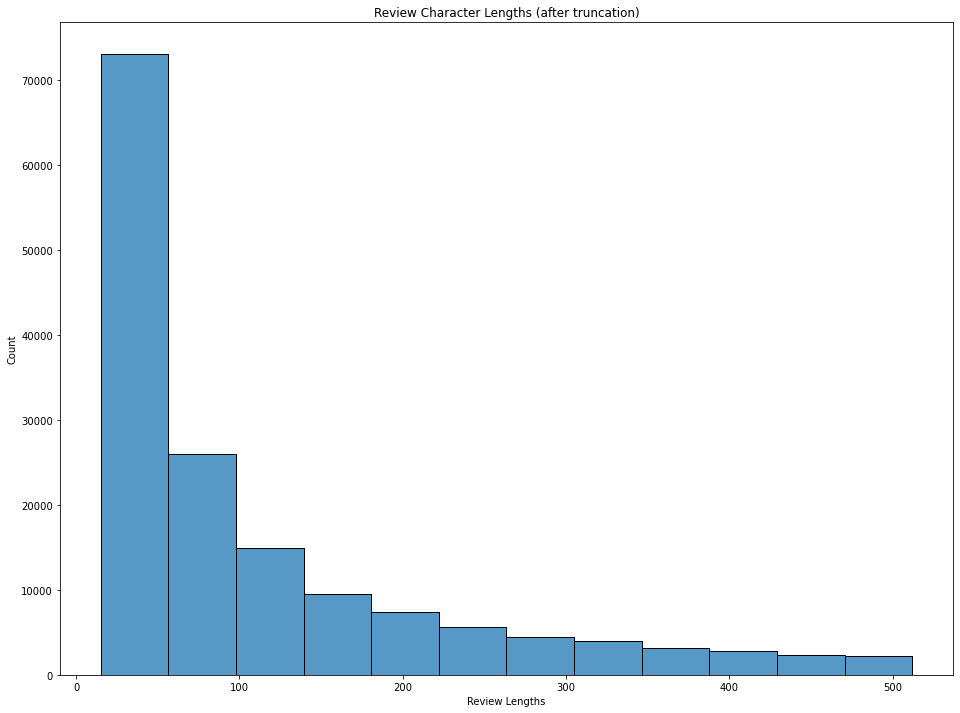

In [42]:
plt.figure(figsize=(16,12))
sns.histplot([len(rev) for rev in elden_ring_reviews['review']], bins=12)
plt.title('Review Character Lengths (after truncation)')
plt.xlabel('Review Lengths')
plt.show()

In [43]:
new_elden_ring_reviews['review_length'] = [len(rev) for rev in new_elden_ring_reviews['review']]

Since we may have some unpropitious reviews that won't distinguish between recommended and non-recommended reviews, we may have to cut out these rows to clean up our data.

Let's begin building our PyTorch class for the reviews below:

## RoBERTa w/ PyTorch

In [44]:
#Building PyTorch Dataset class:

class EldenRingDataset(Dataset):
    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text' : text,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(target, dtype=torch.long)
        }

Now let's split the data into train and test:

In [45]:
#I believe we can split on the rec column as such:
new_elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
26637,111996016,"{'steamid': '76561198089901837', 'num_games_ow...",english,sh*t sucks overrated cant imagine sitting here...,1647031969,1647032788,False,0,0,0.476190,0,True,False,False,"['suck', 'overrate', 'not', 'imagine', 'sit', ...",71,0
8038,112058450,"{'steamid': '76561198090599678', 'num_games_ow...",english,pain\n\n\nbut it's a lotta fun tho,1647112128,1647112128,True,2,0,0.546828,0,True,False,False,"['pain', 'lotta', 'fun', 'tho']",31,1
31620,111890569,"{'steamid': '76561197975616920', 'num_games_ow...",english,He who mistakes difficulty for entertainment i...,1646873530,1646873530,False,0,0,0.000000,0,False,False,False,"['mistake', 'difficulty', 'entertainment', 'fo...",55,0
5848,111631932,"{'steamid': '76561197999988421', 'num_games_ow...",english,This game is sick,1646519267,1646519267,True,1,1,0.523810,0,True,False,False,"['game', 'sick']",17,1
34411,111109851,"{'steamid': '76561197999866470', 'num_games_ow...",english,Unfathomable that a triple-A title could be re...,1645912293,1645912293,False,0,0,0.000000,0,True,False,False,"['unfathomable', 'triple', 'title', 'release',...",158,0


In [46]:
sentiments = ['Not-recommended(0)', 'Recommended(1)']

In [47]:
#Making a logger to keep better track of metrics

def get_logger(filename=os.getcwd()+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    
    return logger

In [48]:
#PyTorch function to create data loaders:

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = EldenRingDataset(
        text = df.review.to_numpy(),
        targets=df.recommended.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(dataset, batch_size=batch_size)
 

In [49]:
#PyTorch Model Definition:

class ERModel(nn.Module):
    def __init__(self, n_classes, config_path=None, pretrained=False):
        
        super(ERModel, self).__init__()
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(MODEL, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(MODEL, return_dict=False)
        else:
            self.model=AutoModel(self.config)
        
        self.drop = nn.Dropout(p=0.3) #increase value to drive regularization strength
        self.out = nn.Linear(self.model.config.hidden_size, n_classes)
        self._init_weights(self.out)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
                
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
                
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

            
    def forward(self, input_ids, attention_mask):        
        _, pooled_output = self.model(
                            input_ids=input_ids,
                            attention_mask=attention_mask                      
        )
        output = self.drop(pooled_output)
        
        return self.out(output)
        
   
    
    
        
    

In [50]:
#Additional helper metrics:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


In [51]:
#model = ERModel(len(sentiments))
#model.to(device)

In [52]:
#Creating the output layer for the network:

#import torch.nn.functional as F

#F.softmax(model(input_ids, attnetion_mask), dim=1)

In [53]:
'''
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
'''

loss_fn = nn.CrossEntropyLoss().to(device)

In [54]:
from tqdm import tqdm

In [55]:
#PyTorch function to train the model: 

def train_model(epoch, model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    #model = model.train()
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=True) #apex
    losses = []
    losses_meter = AverageMeter()
    start = end = time.time()
    correct_predictions = 0
    global_step = 0
    running_loss = 0

    step = 0 #enumerating
    for batch in tqdm(data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        batch_size = targets.size(0)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        loss = torch.masked_select(loss, targets.view(-1, 1) != -1).mean() #NEW
        if gradient_accumulation_steps > 1: #NEW
            loss = loss / gradient_accumulation_steps #NEW
            
        losses_meter.update(loss.item(), batch_size) #NEW
        
        #below 2 for f1 score
        running_loss += loss.item() * targets.size(0)
        correct_predictions += torch.sum(preds == targets)
        
        losses.append(loss.item())
        scaler.scale(loss).backward() #NEW
        #loss.backward() #OLD
        
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) OLD
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        if (step + 1) % gradient_accumulation_steps == 0: #THIS IF IS NEW
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if batch_scheduler:
                scheduler.step()
        
        
        #optimizer.step() OLD
        #scheduler.step() OLD
        #optimizer.zero_grad() OLD
        
        #print(preds)
        #print(targets)        
                
        end = time.time()
        if step % print_freq == 0 or step == (len(data_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(data_loader), 
                          remain=timeSince(start, float(step+1)/len(data_loader)),
                          loss=losses_meter,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))            
            
        step += 1
    
        
    return correct_predictions.double() / n_examples, np.mean(losses)

In [56]:
#Using BERT to evaluate the model
import torch.nn.functional as F

def eval_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    #model = model.eval()
    model.eval()
    losses = []
    losses_meter = AverageMeter()
    preds = []
    start = end = time.time()
    correct_predictions = 0
    
    predictions = []
    real_values = []
    
    with torch.no_grad():
        
        step = 0 #enumerating
        for batch in tqdm(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)
        
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            #all_logits.append(outputs)
            
            batch_size = targets.size(0)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            loss = torch.masked_select(loss, targets.view(-1, 1) != -1).mean() #NEW
            
            if gradient_accumulation_steps > 1: #NEW
                loss = loss / gradient_accumulation_steps #NEW
            
            losses_meter.update(loss.item(), batch_size)
        
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            predictions.extend(preds)
            real_values.extend(targets)
            
            end = time.time()
            
            if step % print_freq == 0 or step == (len(data_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(step, len(data_loader),
                            loss=losses_meter,
                            remain=timeSince(start, float(step+1)/len(data_loader))))
      
            step += 1
        
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    
    
    return correct_predictions.double() / n_examples, np.mean(losses), predictions, real_values

In [57]:
LOGGER = get_logger()

In [58]:
gc.collect()

3676

In [59]:
def get_score(y_true, y_pred):
    score = span_micro_f1(y_true, y_pred)
    return score

In [60]:
#Here is the model training loop:
#Training loop FUNCTION:::
history = defaultdict(list)

def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold+1} training ==========")
    
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    #valid_texts = valid_folds['review'].values
    #valid_labels = create_labels_for_scoring(valid_folds)
    
    train_data_loader = create_data_loader(train_folds, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(valid_folds, tokenizer, MAX_LEN, BATCH_SIZE)
    
    train_len = len(train_folds)
    test_len = len(valid_folds)
    
    model = ERModel(len(sentiments), config_path=None, pretrained=True)
    torch.save(model.config, os.getcwd()+'config.pth')
    model.to(device)

    #####################
    #####################
    #####################
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=encoder_lr, 
                                                decoder_lr=decoder_lr,
                                                weight_decay=weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=encoder_lr, eps=eps, betas=betas)
    
    def get_scheduler(optimizer, num_train_steps):
        if pre_scheduler=='linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps
            )
        elif pre_scheduler=='cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps, num_cycles=num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / BATCH_SIZE * EPOCHS)
    scheduler = get_scheduler(optimizer, num_train_steps)
    
    #####################
    #####################
    #####################
    
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    best_score = 0.
    
    for epoch in range(EPOCHS):
        
        print('-' * 35)
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 35)
        
        train_acc, train_loss = train_model(
            epoch=epoch,
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            scheduler=scheduler,
            n_examples=train_len #MODDED
        )
        
        print(f'Train loss {train_loss} accuracy {train_acc}')
        
        val_acc, val_loss, y_pred, y_true = eval_model(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            scheduler=scheduler,
            n_examples=test_len
        )
        
        #predictions = y_pred.reshape(len(valid_folds), MAX_LEN)
        
        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()
        
        score = f1_score(y_true, y_pred, average="macro")
        
        print(f'Validation F1 Score: {f1_score(y_true, y_pred, average="macro")}')
        print(f'Validation Precision Score: {precision_score(y_true, y_pred, average="macro")}')
        print(f'Validation Recall Score: {recall_score(y_true, y_pred, average="macro")}')
        print()
        print(classification_report(y_true, y_pred, target_names = ['Not Recommended', 'Recommended']))
        print()
        
        history['accuracy'].append(train_acc)
        history['loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
  
        if best_score < score:
            PATH=os.getcwd()+f"{MODEL.replace('/', '-')}_fold{fold}_best.pth"
            best_score = score
            BEST_MODEL_PATH = os.getcwd()+"\\"+f"{MODEL.replace('/', '-')}_fold{fold}_best.pth"
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(),
                       os.getcwd()+"\\"+f"{MODEL.replace('/', '-')}_fold{fold}_best.pth")   #os.getcwd()
        
    #predictions = torch.load(OUTPUT_DIR+f"{MODEL.replace('/', '-')}_fold{fold}_best.pth", 
                             #map_location=torch.device('cpu'))['predictions']
    #valid_folds[[i for i in range(MAX_LEN)]] = predictions    
      
    
    
    torch.cuda.empty_cache()
    gc.collect()
    
    #return valid_folds
    

In [61]:
if __name__ == '__main__':
    
    oof_df = pd.DataFrame()
    for fold in range(N_FOLD):
        
        train_loop(elden_ring_reviews, fold)
        #oof_df = pd.concat([oof_df, _oof_df])
        LOGGER.info(f"========== fold: {fold+1} complete ==========")       #already made this print in train_loop
        #_oof_df.to_pickle(OUTPUT_DIR+'oof_df_{}.pkl'.format(fold))
        
        if SHORT: #To run only one fold
            break
        
    #oof_df = oof_df.reset_index(drop=True)
    #oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
    
    LOGGER.info(f"========== training complete ==========")
    #print(oof_df.head())
        

========== fold: 1 training ==========
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-----------------------------------
Epoch 1/3
-----------------------------------


  0%|          | 0/41431 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch: [1][0/41431] Elapsed 0m 0s (remain 662m 26s) Loss: 0.8731(0.8731) Grad: 774011.1875  LR: 0.00002000  


  0%|          | 100/41431 [00:41<4:48:54,  2.38it/s]

Epoch: [1][100/41431] Elapsed 0m 42s (remain 287m 48s) Loss: 0.0096(0.5175) Grad: 28376.3164  LR: 0.00002000  


  0%|          | 200/41431 [01:23<4:40:41,  2.45it/s]

Epoch: [1][200/41431] Elapsed 1m 23s (remain 286m 12s) Loss: 3.0448(0.6949) Grad: 1176406.2500  LR: 0.00002000  


  1%|          | 300/41431 [02:04<4:45:35,  2.40it/s]

Epoch: [1][300/41431] Elapsed 2m 5s (remain 285m 19s) Loss: 0.0001(0.7034) Grad: 267.2820  LR: 0.00002000  


  1%|          | 400/41431 [02:46<4:53:23,  2.33it/s]

Epoch: [1][400/41431] Elapsed 2m 47s (remain 285m 4s) Loss: 2.3810(0.8296) Grad: 1750053.6250  LR: 0.00002000  


  1%|          | 500/41431 [03:29<4:52:48,  2.33it/s]

Epoch: [1][500/41431] Elapsed 3m 30s (remain 285m 59s) Loss: 0.0000(0.8777) Grad: 99.5387  LR: 0.00002000  


  1%|▏         | 600/41431 [04:13<4:49:31,  2.35it/s]

Epoch: [1][600/41431] Elapsed 4m 13s (remain 286m 57s) Loss: 0.0000(0.8314) Grad: 56.2107  LR: 0.00002000  


  2%|▏         | 700/41431 [04:55<4:48:17,  2.35it/s]

Epoch: [1][700/41431] Elapsed 4m 56s (remain 287m 2s) Loss: 0.0000(0.7445) Grad: 34.4747  LR: 0.00002000  


  2%|▏         | 800/41431 [05:38<4:48:43,  2.35it/s]

Epoch: [1][800/41431] Elapsed 5m 39s (remain 286m 48s) Loss: 0.0000(0.6940) Grad: 522.5977  LR: 0.00002000  


  2%|▏         | 900/41431 [06:21<4:58:53,  2.26it/s]

Epoch: [1][900/41431] Elapsed 6m 22s (remain 286m 29s) Loss: 3.4700(0.7105) Grad: 1070240.1250  LR: 0.00002000  


  2%|▏         | 1000/41431 [07:04<4:47:44,  2.34it/s]

Epoch: [1][1000/41431] Elapsed 7m 5s (remain 286m 10s) Loss: 0.0000(0.6924) Grad: 230.4552  LR: 0.00002000  


  3%|▎         | 1100/41431 [07:47<4:45:39,  2.35it/s]

Epoch: [1][1100/41431] Elapsed 7m 47s (remain 285m 41s) Loss: 2.9434(0.6883) Grad: 53069580.0000  LR: 0.00002000  


  3%|▎         | 1200/41431 [08:30<4:53:05,  2.29it/s]

Epoch: [1][1200/41431] Elapsed 8m 31s (remain 285m 26s) Loss: 0.0490(0.6903) Grad: 558214.1875  LR: 0.00002000  


  3%|▎         | 1300/41431 [09:14<4:48:24,  2.32it/s]

Epoch: [1][1300/41431] Elapsed 9m 14s (remain 285m 9s) Loss: 1.3062(0.6833) Grad: 44895564.0000  LR: 0.00001999  


  3%|▎         | 1400/41431 [09:58<4:47:42,  2.32it/s]

Epoch: [1][1400/41431] Elapsed 9m 58s (remain 285m 0s) Loss: 0.0000(0.6942) Grad: 33.2698  LR: 0.00001999  


  4%|▎         | 1500/41431 [10:42<4:56:14,  2.25it/s]

Epoch: [1][1500/41431] Elapsed 10m 42s (remain 285m 0s) Loss: 2.9149(0.6980) Grad: 22425714.0000  LR: 0.00001999  


  4%|▍         | 1600/41431 [11:27<4:57:22,  2.23it/s]

Epoch: [1][1600/41431] Elapsed 11m 28s (remain 285m 16s) Loss: 0.0000(0.6919) Grad: 12.0431  LR: 0.00001999  


  4%|▍         | 1700/41431 [12:12<4:55:13,  2.24it/s]

Epoch: [1][1700/41431] Elapsed 12m 12s (remain 285m 14s) Loss: 0.0000(0.6762) Grad: 64.6561  LR: 0.00001999  


  4%|▍         | 1800/41431 [12:57<4:53:31,  2.25it/s]

Epoch: [1][1800/41431] Elapsed 12m 57s (remain 285m 7s) Loss: 2.9176(0.6836) Grad: 3851716.2500  LR: 0.00001999  


  5%|▍         | 1900/41431 [13:41<4:53:04,  2.25it/s]

Epoch: [1][1900/41431] Elapsed 13m 42s (remain 284m 55s) Loss: 0.0000(0.6725) Grad: 31.7153  LR: 0.00001999  


  5%|▍         | 2000/41431 [14:26<4:52:17,  2.25it/s]

Epoch: [1][2000/41431] Elapsed 14m 26s (remain 284m 39s) Loss: 0.0000(0.6494) Grad: 116.7119  LR: 0.00001999  


  5%|▌         | 2100/41431 [15:11<4:50:37,  2.26it/s]

Epoch: [1][2100/41431] Elapsed 15m 11s (remain 284m 27s) Loss: 3.7575(0.6418) Grad: 2595629.5000  LR: 0.00001999  


  5%|▌         | 2200/41431 [15:56<4:55:54,  2.21it/s]

Epoch: [1][2200/41431] Elapsed 15m 56s (remain 284m 11s) Loss: 0.0000(0.6309) Grad: 56.3307  LR: 0.00001998  


  6%|▌         | 2300/41431 [16:40<4:54:50,  2.21it/s]

Epoch: [1][2300/41431] Elapsed 16m 41s (remain 283m 47s) Loss: 0.0000(0.6137) Grad: 57.7257  LR: 0.00001998  


  6%|▌         | 2400/41431 [17:25<4:57:57,  2.18it/s]

Epoch: [1][2400/41431] Elapsed 17m 26s (remain 283m 24s) Loss: 0.0001(0.6018) Grad: 1288.0017  LR: 0.00001998  


  6%|▌         | 2500/41431 [18:10<4:47:44,  2.26it/s]

Epoch: [1][2500/41431] Elapsed 18m 10s (remain 282m 59s) Loss: 0.0000(0.5837) Grad: 16.6822  LR: 0.00001998  


  6%|▋         | 2600/41431 [18:55<4:49:35,  2.23it/s]

Epoch: [1][2600/41431] Elapsed 18m 55s (remain 282m 35s) Loss: 0.0000(0.5707) Grad: 14.8506  LR: 0.00001998  


  7%|▋         | 2700/41431 [19:40<4:42:29,  2.29it/s]

Epoch: [1][2700/41431] Elapsed 19m 40s (remain 282m 7s) Loss: 0.0000(0.5591) Grad: 18.2245  LR: 0.00001998  


  7%|▋         | 2800/41431 [20:24<4:52:55,  2.20it/s]

Epoch: [1][2800/41431] Elapsed 20m 25s (remain 281m 38s) Loss: 0.0000(0.5479) Grad: 21.5867  LR: 0.00001997  


  7%|▋         | 2900/41431 [21:09<4:53:54,  2.18it/s]

Epoch: [1][2900/41431] Elapsed 21m 10s (remain 281m 9s) Loss: 0.0000(0.5397) Grad: 147.9733  LR: 0.00001997  


  7%|▋         | 3000/41431 [21:54<4:46:16,  2.24it/s]

Epoch: [1][3000/41431] Elapsed 21m 55s (remain 280m 42s) Loss: 0.0000(0.5291) Grad: 11.9708  LR: 0.00001997  


  7%|▋         | 3100/41431 [22:39<4:52:14,  2.19it/s]

Epoch: [1][3100/41431] Elapsed 22m 40s (remain 280m 13s) Loss: 0.0000(0.5195) Grad: 40.3980  LR: 0.00001997  


  8%|▊         | 3200/41431 [23:24<4:41:06,  2.27it/s]

Epoch: [1][3200/41431] Elapsed 23m 25s (remain 279m 44s) Loss: 0.0000(0.5106) Grad: 15.5962  LR: 0.00001997  


  8%|▊         | 3300/41431 [24:10<4:37:43,  2.29it/s]

Epoch: [1][3300/41431] Elapsed 24m 10s (remain 279m 18s) Loss: 0.0000(0.5060) Grad: 14.3454  LR: 0.00001997  


  8%|▊         | 3400/41431 [24:55<4:36:41,  2.29it/s]

Epoch: [1][3400/41431] Elapsed 24m 55s (remain 278m 47s) Loss: 0.0000(0.4999) Grad: 25.0395  LR: 0.00001996  


  8%|▊         | 3500/41431 [25:40<4:45:21,  2.22it/s]

Epoch: [1][3500/41431] Elapsed 25m 41s (remain 278m 20s) Loss: 0.0000(0.4920) Grad: 227.1338  LR: 0.00001996  


  9%|▊         | 3600/41431 [26:26<4:47:18,  2.19it/s]

Epoch: [1][3600/41431] Elapsed 26m 26s (remain 277m 51s) Loss: 0.0000(0.4838) Grad: 7.0225  LR: 0.00001996  


  9%|▉         | 3700/41431 [27:11<4:48:57,  2.18it/s]

Epoch: [1][3700/41431] Elapsed 27m 12s (remain 277m 21s) Loss: 3.3767(0.4780) Grad: 19441770.0000  LR: 0.00001996  


  9%|▉         | 3800/41431 [27:57<4:47:51,  2.18it/s]

Epoch: [1][3800/41431] Elapsed 27m 57s (remain 276m 50s) Loss: 0.0000(0.4699) Grad: 15.8881  LR: 0.00001995  


  9%|▉         | 3900/41431 [28:42<4:51:05,  2.15it/s]

Epoch: [1][3900/41431] Elapsed 28m 43s (remain 276m 19s) Loss: 0.0000(0.4615) Grad: 12.8268  LR: 0.00001995  


 10%|▉         | 4000/41431 [29:28<4:40:45,  2.22it/s]

Epoch: [1][4000/41431] Elapsed 29m 28s (remain 275m 49s) Loss: 0.0000(0.4607) Grad: 23.1354  LR: 0.00001995  


 10%|▉         | 4100/41431 [30:14<4:41:45,  2.21it/s]

Epoch: [1][4100/41431] Elapsed 30m 14s (remain 275m 16s) Loss: 0.0000(0.4576) Grad: 20.1149  LR: 0.00001995  


 10%|█         | 4200/41431 [30:59<4:56:13,  2.09it/s]

Epoch: [1][4200/41431] Elapsed 31m 0s (remain 274m 43s) Loss: 0.0000(0.4590) Grad: 22.0061  LR: 0.00001994  


 10%|█         | 4300/41431 [31:45<4:41:59,  2.19it/s]

Epoch: [1][4300/41431] Elapsed 31m 45s (remain 274m 12s) Loss: 0.0000(0.4580) Grad: 21.0667  LR: 0.00001994  


 11%|█         | 4400/41431 [32:31<4:45:34,  2.16it/s]

Epoch: [1][4400/41431] Elapsed 32m 31s (remain 273m 41s) Loss: 0.0000(0.4591) Grad: 92.4209  LR: 0.00001994  


 11%|█         | 4500/41431 [33:16<4:41:22,  2.19it/s]

Epoch: [1][4500/41431] Elapsed 33m 17s (remain 273m 8s) Loss: 0.0000(0.4573) Grad: 23.4638  LR: 0.00001994  


 11%|█         | 4600/41431 [34:02<4:35:25,  2.23it/s]

Epoch: [1][4600/41431] Elapsed 34m 2s (remain 272m 31s) Loss: 0.0000(0.4543) Grad: 171.7589  LR: 0.00001993  


 11%|█▏        | 4700/41431 [34:47<4:32:02,  2.25it/s]

Epoch: [1][4700/41431] Elapsed 34m 48s (remain 271m 55s) Loss: 0.0000(0.4576) Grad: 71.6125  LR: 0.00001993  


 12%|█▏        | 4800/41431 [35:33<4:43:28,  2.15it/s]

Epoch: [1][4800/41431] Elapsed 35m 33s (remain 271m 18s) Loss: 0.0002(0.4615) Grad: 65923.4922  LR: 0.00001993  


 12%|█▏        | 4900/41431 [36:18<4:29:49,  2.26it/s]

Epoch: [1][4900/41431] Elapsed 36m 19s (remain 270m 41s) Loss: 0.0000(0.4640) Grad: 25.2803  LR: 0.00001992  


 12%|█▏        | 5000/41431 [37:03<4:42:07,  2.15it/s]

Epoch: [1][5000/41431] Elapsed 37m 4s (remain 270m 3s) Loss: 0.0000(0.4712) Grad: 248.5400  LR: 0.00001992  


 12%|█▏        | 5100/41431 [37:49<4:37:20,  2.18it/s]

Epoch: [1][5100/41431] Elapsed 37m 49s (remain 269m 23s) Loss: 0.0000(0.4796) Grad: 134.9835  LR: 0.00001992  


 13%|█▎        | 5200/41431 [38:34<4:40:07,  2.16it/s]

Epoch: [1][5200/41431] Elapsed 38m 34s (remain 268m 45s) Loss: 0.0000(0.4798) Grad: 16.8255  LR: 0.00001991  


 13%|█▎        | 5300/41431 [39:19<4:28:28,  2.24it/s]

Epoch: [1][5300/41431] Elapsed 39m 20s (remain 268m 7s) Loss: 3.9465(0.4774) Grad: 9520699.0000  LR: 0.00001991  


 13%|█▎        | 5400/41431 [40:05<4:23:33,  2.28it/s]

Epoch: [1][5400/41431] Elapsed 40m 5s (remain 267m 26s) Loss: 0.0000(0.4769) Grad: 355.6113  LR: 0.00001991  


 13%|█▎        | 5500/41431 [40:50<4:30:10,  2.22it/s]

Epoch: [1][5500/41431] Elapsed 40m 50s (remain 266m 47s) Loss: 0.0000(0.4767) Grad: 183.1044  LR: 0.00001990  


 14%|█▎        | 5600/41431 [41:35<4:31:17,  2.20it/s]

Epoch: [1][5600/41431] Elapsed 41m 36s (remain 266m 8s) Loss: 0.0000(0.4778) Grad: 57.5556  LR: 0.00001990  


 14%|█▍        | 5700/41431 [42:21<4:29:30,  2.21it/s]

Epoch: [1][5700/41431] Elapsed 42m 21s (remain 265m 29s) Loss: 0.0000(0.4831) Grad: 175.9891  LR: 0.00001990  


 14%|█▍        | 5800/41431 [43:06<4:22:27,  2.26it/s]

Epoch: [1][5800/41431] Elapsed 43m 6s (remain 264m 49s) Loss: 0.0000(0.4819) Grad: 15.1577  LR: 0.00001989  


 14%|█▍        | 5900/41431 [43:52<4:32:03,  2.18it/s]

Epoch: [1][5900/41431] Elapsed 43m 52s (remain 264m 11s) Loss: 0.0000(0.4895) Grad: 1309.9078  LR: 0.00001989  


 14%|█▍        | 6000/41431 [44:37<4:32:54,  2.16it/s]

Epoch: [1][6000/41431] Elapsed 44m 38s (remain 263m 30s) Loss: 0.0000(0.4912) Grad: 60.1141  LR: 0.00001989  


 15%|█▍        | 6100/41431 [45:23<4:20:09,  2.26it/s]

Epoch: [1][6100/41431] Elapsed 45m 23s (remain 262m 53s) Loss: 0.0000(0.4951) Grad: 196.3615  LR: 0.00001988  


 15%|█▍        | 6200/41431 [46:08<4:27:10,  2.20it/s]

Epoch: [1][6200/41431] Elapsed 46m 9s (remain 262m 13s) Loss: 0.0001(0.5017) Grad: 57819.6719  LR: 0.00001988  


 15%|█▌        | 6300/41431 [46:54<4:19:18,  2.26it/s]

Epoch: [1][6300/41431] Elapsed 46m 54s (remain 261m 33s) Loss: 0.0000(0.5098) Grad: 95.2513  LR: 0.00001987  


 15%|█▌        | 6400/41431 [47:39<4:22:57,  2.22it/s]

Epoch: [1][6400/41431] Elapsed 47m 40s (remain 260m 53s) Loss: 0.0000(0.5173) Grad: 338.7956  LR: 0.00001987  


 16%|█▌        | 6500/41431 [48:25<4:21:08,  2.23it/s]

Epoch: [1][6500/41431] Elapsed 48m 25s (remain 260m 12s) Loss: 0.0000(0.5216) Grad: 817.7114  LR: 0.00001987  


 16%|█▌        | 6600/41431 [49:11<4:24:23,  2.20it/s]

Epoch: [1][6600/41431] Elapsed 49m 11s (remain 259m 33s) Loss: 0.0000(0.5274) Grad: 71.9338  LR: 0.00001986  


 16%|█▌        | 6700/41431 [49:56<4:23:22,  2.20it/s]

Epoch: [1][6700/41431] Elapsed 49m 57s (remain 258m 53s) Loss: 0.0000(0.5373) Grad: 109.0884  LR: 0.00001986  


 16%|█▋        | 6800/41431 [50:42<4:20:16,  2.22it/s]

Epoch: [1][6800/41431] Elapsed 50m 42s (remain 258m 12s) Loss: 0.0000(0.5391) Grad: 89.7765  LR: 0.00001985  


 17%|█▋        | 6900/41431 [51:28<4:28:25,  2.14it/s]

Epoch: [1][6900/41431] Elapsed 51m 28s (remain 257m 33s) Loss: 0.0000(0.5487) Grad: 98.9057  LR: 0.00001985  


 17%|█▋        | 7000/41431 [52:13<4:32:43,  2.10it/s]

Epoch: [1][7000/41431] Elapsed 52m 14s (remain 256m 53s) Loss: 3.8524(0.5565) Grad: 6519898.5000  LR: 0.00001984  


 17%|█▋        | 7100/41431 [52:59<4:23:47,  2.17it/s]

Epoch: [1][7100/41431] Elapsed 52m 59s (remain 256m 13s) Loss: 0.0000(0.5610) Grad: 104.7276  LR: 0.00001984  


 17%|█▋        | 7200/41431 [53:45<4:20:23,  2.19it/s]

Epoch: [1][7200/41431] Elapsed 53m 45s (remain 255m 33s) Loss: 3.6563(0.5721) Grad: 345872096.0000  LR: 0.00001983  


 18%|█▊        | 7300/41431 [54:30<4:09:22,  2.28it/s]

Epoch: [1][7300/41431] Elapsed 54m 31s (remain 254m 52s) Loss: 0.0000(0.5781) Grad: 615.1656  LR: 0.00001983  


 18%|█▊        | 7400/41431 [55:16<4:12:11,  2.25it/s]

Epoch: [1][7400/41431] Elapsed 55m 16s (remain 254m 11s) Loss: 0.0000(0.5843) Grad: 75.3964  LR: 0.00001983  


 18%|█▊        | 7500/41431 [56:02<4:10:02,  2.26it/s]

Epoch: [1][7500/41431] Elapsed 56m 2s (remain 253m 30s) Loss: 0.0000(0.5878) Grad: 177.8175  LR: 0.00001982  


 18%|█▊        | 7600/41431 [56:47<4:22:34,  2.15it/s]

Epoch: [1][7600/41431] Elapsed 56m 48s (remain 252m 48s) Loss: 0.0000(0.6029) Grad: 209.7657  LR: 0.00001982  


 19%|█▊        | 7700/41431 [57:33<4:11:38,  2.23it/s]

Epoch: [1][7700/41431] Elapsed 57m 33s (remain 252m 6s) Loss: 3.7638(0.6090) Grad: 7591584.0000  LR: 0.00001981  


 19%|█▉        | 7800/41431 [58:18<4:09:14,  2.25it/s]

Epoch: [1][7800/41431] Elapsed 58m 19s (remain 251m 24s) Loss: 0.0000(0.6207) Grad: 76.8904  LR: 0.00001981  


 19%|█▉        | 7900/41431 [59:04<4:10:23,  2.23it/s]

Epoch: [1][7900/41431] Elapsed 59m 4s (remain 250m 42s) Loss: 0.0000(0.6241) Grad: 329.1602  LR: 0.00001980  


 19%|█▉        | 8000/41431 [59:49<4:11:12,  2.22it/s]

Epoch: [1][8000/41431] Elapsed 59m 50s (remain 250m 1s) Loss: 2.1847(0.6323) Grad: 689875392.0000  LR: 0.00001980  


 20%|█▉        | 8100/41431 [1:00:35<4:15:23,  2.18it/s]

Epoch: [1][8100/41431] Elapsed 60m 35s (remain 249m 19s) Loss: 0.0000(0.6359) Grad: 123.2666  LR: 0.00001979  


 20%|█▉        | 8200/41431 [1:01:20<4:08:45,  2.23it/s]

Epoch: [1][8200/41431] Elapsed 61m 21s (remain 248m 36s) Loss: 7.6920(0.6439) Grad: 44261996.0000  LR: 0.00001979  


 20%|██        | 8300/41431 [1:02:06<4:07:40,  2.23it/s]

Epoch: [1][8300/41431] Elapsed 62m 7s (remain 247m 55s) Loss: 3.9286(0.6517) Grad: 23699304.0000  LR: 0.00001978  


 20%|██        | 8400/41431 [1:02:52<4:10:10,  2.20it/s]

Epoch: [1][8400/41431] Elapsed 62m 52s (remain 247m 13s) Loss: 0.0000(0.6573) Grad: 2650.2649  LR: 0.00001978  


 21%|██        | 8500/41431 [1:03:38<4:06:42,  2.22it/s]

Epoch: [1][8500/41431] Elapsed 63m 38s (remain 246m 32s) Loss: 0.0011(0.6619) Grad: 4191768.0000  LR: 0.00001977  


 21%|██        | 8600/41431 [1:04:23<4:11:39,  2.17it/s]

Epoch: [1][8600/41431] Elapsed 64m 24s (remain 245m 49s) Loss: 0.0022(0.6706) Grad: 4515651.5000  LR: 0.00001976  


 21%|██        | 8700/41431 [1:05:09<4:16:17,  2.13it/s]

Epoch: [1][8700/41431] Elapsed 65m 9s (remain 245m 7s) Loss: 0.0001(0.6792) Grad: 402476.1250  LR: 0.00001976  


 21%|██        | 8800/41431 [1:05:54<4:11:11,  2.17it/s]

Epoch: [1][8800/41431] Elapsed 65m 55s (remain 244m 24s) Loss: 3.8885(0.6905) Grad: 46161812.0000  LR: 0.00001975  


 21%|██▏       | 8900/41431 [1:06:40<4:11:36,  2.15it/s]

Epoch: [1][8900/41431] Elapsed 66m 41s (remain 243m 43s) Loss: 0.0000(0.6968) Grad: 274.1407  LR: 0.00001975  


 22%|██▏       | 9000/41431 [1:07:26<4:07:12,  2.19it/s]

Epoch: [1][9000/41431] Elapsed 67m 26s (remain 243m 1s) Loss: 0.0000(0.7081) Grad: 649.3560  LR: 0.00001974  


 22%|██▏       | 9100/41431 [1:08:12<4:08:19,  2.17it/s]

Epoch: [1][9100/41431] Elapsed 68m 12s (remain 242m 19s) Loss: 0.0000(0.7166) Grad: 272.8215  LR: 0.00001974  


 22%|██▏       | 9200/41431 [1:08:57<4:01:36,  2.22it/s]

Epoch: [1][9200/41431] Elapsed 68m 58s (remain 241m 36s) Loss: 4.0110(0.7234) Grad: 19990140.0000  LR: 0.00001973  


 22%|██▏       | 9300/41431 [1:09:43<4:04:11,  2.19it/s]

Epoch: [1][9300/41431] Elapsed 69m 44s (remain 240m 54s) Loss: 2.6118(0.7325) Grad: 695980096.0000  LR: 0.00001972  


 23%|██▎       | 9400/41431 [1:10:29<4:06:40,  2.16it/s]

Epoch: [1][9400/41431] Elapsed 70m 29s (remain 240m 11s) Loss: 3.9476(0.7426) Grad: 35045104.0000  LR: 0.00001972  


 23%|██▎       | 9500/41431 [1:11:14<3:50:53,  2.30it/s]

Epoch: [1][9500/41431] Elapsed 71m 15s (remain 239m 28s) Loss: 0.0000(0.7437) Grad: 287.4063  LR: 0.00001971  


 23%|██▎       | 9600/41431 [1:12:00<4:00:51,  2.20it/s]

Epoch: [1][9600/41431] Elapsed 72m 1s (remain 238m 45s) Loss: 0.0000(0.7381) Grad: 35.3384  LR: 0.00001971  


 23%|██▎       | 9700/41431 [1:12:46<3:50:52,  2.29it/s]

Epoch: [1][9700/41431] Elapsed 72m 46s (remain 238m 2s) Loss: 0.0000(0.7331) Grad: 22.5023  LR: 0.00001970  


 24%|██▎       | 9800/41431 [1:13:31<4:01:29,  2.18it/s]

Epoch: [1][9800/41431] Elapsed 73m 32s (remain 237m 19s) Loss: 0.0000(0.7299) Grad: 26.3775  LR: 0.00001969  


 24%|██▍       | 9900/41431 [1:14:17<3:59:15,  2.20it/s]

Epoch: [1][9900/41431] Elapsed 74m 18s (remain 236m 36s) Loss: 0.0000(0.7243) Grad: 20.7177  LR: 0.00001969  


 24%|██▍       | 10000/41431 [1:15:03<4:05:17,  2.14it/s]

Epoch: [1][10000/41431] Elapsed 75m 3s (remain 235m 54s) Loss: 0.0000(0.7181) Grad: 24.8115  LR: 0.00001968  


 24%|██▍       | 10100/41431 [1:15:49<3:55:27,  2.22it/s]

Epoch: [1][10100/41431] Elapsed 75m 49s (remain 235m 11s) Loss: 0.0000(0.7144) Grad: 412.4521  LR: 0.00001968  


 25%|██▍       | 10200/41431 [1:16:35<3:52:16,  2.24it/s]

Epoch: [1][10200/41431] Elapsed 76m 35s (remain 234m 29s) Loss: 0.0000(0.7096) Grad: 20.3479  LR: 0.00001967  


 25%|██▍       | 10300/41431 [1:17:20<3:57:35,  2.18it/s]

Epoch: [1][10300/41431] Elapsed 77m 21s (remain 233m 46s) Loss: 0.0000(0.7061) Grad: 19.5464  LR: 0.00001966  


 25%|██▌       | 10400/41431 [1:18:06<3:48:55,  2.26it/s]

Epoch: [1][10400/41431] Elapsed 78m 6s (remain 233m 2s) Loss: 4.2127(0.7018) Grad: 332662016.0000  LR: 0.00001966  


 25%|██▌       | 10500/41431 [1:18:51<3:53:42,  2.21it/s]

Epoch: [1][10500/41431] Elapsed 78m 52s (remain 232m 18s) Loss: 0.0000(0.6978) Grad: 402.3836  LR: 0.00001965  


 26%|██▌       | 10600/41431 [1:19:37<3:51:50,  2.22it/s]

Epoch: [1][10600/41431] Elapsed 79m 37s (remain 231m 35s) Loss: 0.0000(0.6938) Grad: 34.9267  LR: 0.00001964  


 26%|██▌       | 10700/41431 [1:20:22<3:53:28,  2.19it/s]

Epoch: [1][10700/41431] Elapsed 80m 23s (remain 230m 50s) Loss: 0.0000(0.6905) Grad: 24.5067  LR: 0.00001964  


 26%|██▌       | 10800/41431 [1:21:08<3:53:38,  2.18it/s]

Epoch: [1][10800/41431] Elapsed 81m 8s (remain 230m 6s) Loss: 0.0000(0.6881) Grad: 28.2764  LR: 0.00001963  


 26%|██▋       | 10900/41431 [1:21:53<3:51:01,  2.20it/s]

Epoch: [1][10900/41431] Elapsed 81m 54s (remain 229m 22s) Loss: 4.4337(0.6841) Grad: 293319840.0000  LR: 0.00001962  


 27%|██▋       | 11000/41431 [1:22:39<3:51:13,  2.19it/s]

Epoch: [1][11000/41431] Elapsed 82m 39s (remain 228m 38s) Loss: 0.0000(0.6819) Grad: 18.9845  LR: 0.00001962  


 27%|██▋       | 11100/41431 [1:23:24<3:49:12,  2.21it/s]

Epoch: [1][11100/41431] Elapsed 83m 24s (remain 227m 54s) Loss: 0.0000(0.6781) Grad: 31.8496  LR: 0.00001961  


 27%|██▋       | 11200/41431 [1:24:09<3:48:19,  2.21it/s]

Epoch: [1][11200/41431] Elapsed 84m 10s (remain 227m 9s) Loss: 0.0000(0.6730) Grad: 20.4301  LR: 0.00001960  


 27%|██▋       | 11300/41431 [1:24:55<3:42:31,  2.26it/s]

Epoch: [1][11300/41431] Elapsed 84m 55s (remain 226m 25s) Loss: 0.0000(0.6708) Grad: 11.7133  LR: 0.00001959  


 28%|██▊       | 11400/41431 [1:25:40<3:45:14,  2.22it/s]

Epoch: [1][11400/41431] Elapsed 85m 41s (remain 225m 41s) Loss: 0.0000(0.6688) Grad: 22.8228  LR: 0.00001959  


 28%|██▊       | 11500/41431 [1:26:26<3:41:19,  2.25it/s]

Epoch: [1][11500/41431] Elapsed 86m 26s (remain 224m 58s) Loss: 0.0000(0.6643) Grad: 13.9318  LR: 0.00001958  


 28%|██▊       | 11600/41431 [1:27:11<3:46:17,  2.20it/s]

Epoch: [1][11600/41431] Elapsed 87m 12s (remain 224m 13s) Loss: 0.0000(0.6623) Grad: 15.9799  LR: 0.00001957  


 28%|██▊       | 11700/41431 [1:27:57<3:49:18,  2.16it/s]

Epoch: [1][11700/41431] Elapsed 87m 57s (remain 223m 29s) Loss: 0.0000(0.6577) Grad: 10.7936  LR: 0.00001957  


 28%|██▊       | 11800/41431 [1:28:42<3:44:20,  2.20it/s]

Epoch: [1][11800/41431] Elapsed 88m 43s (remain 222m 45s) Loss: 0.0000(0.6549) Grad: 19.8096  LR: 0.00001956  


 29%|██▊       | 11900/41431 [1:29:28<3:46:44,  2.17it/s]

Epoch: [1][11900/41431] Elapsed 89m 28s (remain 222m 1s) Loss: 0.0000(0.6533) Grad: 28.4222  LR: 0.00001955  


 29%|██▉       | 12000/41431 [1:30:13<3:47:17,  2.16it/s]

Epoch: [1][12000/41431] Elapsed 90m 14s (remain 221m 16s) Loss: 0.0000(0.6492) Grad: 101.3127  LR: 0.00001954  


 29%|██▉       | 12100/41431 [1:30:59<3:35:23,  2.27it/s]

Epoch: [1][12100/41431] Elapsed 90m 59s (remain 220m 32s) Loss: 0.0000(0.6460) Grad: 42.9219  LR: 0.00001954  


 29%|██▉       | 12200/41431 [1:31:44<3:39:58,  2.21it/s]

Epoch: [1][12200/41431] Elapsed 91m 45s (remain 219m 48s) Loss: 0.0000(0.6429) Grad: 26.5738  LR: 0.00001953  


 30%|██▉       | 12300/41431 [1:32:30<3:44:38,  2.16it/s]

Epoch: [1][12300/41431] Elapsed 92m 30s (remain 219m 4s) Loss: 0.0000(0.6426) Grad: 17.0191  LR: 0.00001952  


 30%|██▉       | 12400/41431 [1:33:16<3:41:12,  2.19it/s]

Epoch: [1][12400/41431] Elapsed 93m 16s (remain 218m 21s) Loss: 0.0000(0.6394) Grad: 174895.8594  LR: 0.00001951  


 30%|███       | 12500/41431 [1:34:01<3:42:56,  2.16it/s]

Epoch: [1][12500/41431] Elapsed 94m 1s (remain 217m 36s) Loss: 0.0000(0.6378) Grad: 22.6808  LR: 0.00001950  


 30%|███       | 12600/41431 [1:34:46<3:34:57,  2.24it/s]

Epoch: [1][12600/41431] Elapsed 94m 47s (remain 216m 52s) Loss: 0.0000(0.6359) Grad: 14.6361  LR: 0.00001950  


 31%|███       | 12700/41431 [1:35:32<3:39:58,  2.18it/s]

Epoch: [1][12700/41431] Elapsed 95m 33s (remain 216m 8s) Loss: 0.0000(0.6318) Grad: 16.1801  LR: 0.00001949  


 31%|███       | 12800/41431 [1:36:18<3:41:55,  2.15it/s]

Epoch: [1][12800/41431] Elapsed 96m 18s (remain 215m 24s) Loss: 0.0000(0.6287) Grad: 17.6662  LR: 0.00001948  


 31%|███       | 12900/41431 [1:37:03<3:34:38,  2.22it/s]

Epoch: [1][12900/41431] Elapsed 97m 4s (remain 214m 40s) Loss: 5.3819(0.6273) Grad: 115319616.0000  LR: 0.00001947  


 31%|███▏      | 13000/41431 [1:37:49<3:35:50,  2.20it/s]

Epoch: [1][13000/41431] Elapsed 97m 49s (remain 213m 56s) Loss: 0.0000(0.6251) Grad: 26.7081  LR: 0.00001946  


 32%|███▏      | 13100/41431 [1:38:34<3:34:56,  2.20it/s]

Epoch: [1][13100/41431] Elapsed 98m 35s (remain 213m 11s) Loss: 0.0000(0.6223) Grad: 30.7959  LR: 0.00001946  


 32%|███▏      | 13200/41431 [1:39:20<3:34:51,  2.19it/s]

Epoch: [1][13200/41431] Elapsed 99m 21s (remain 212m 27s) Loss: 0.0000(0.6200) Grad: 32.7835  LR: 0.00001945  


 32%|███▏      | 13300/41431 [1:40:06<3:36:17,  2.17it/s]

Epoch: [1][13300/41431] Elapsed 100m 6s (remain 211m 43s) Loss: 0.0000(0.6193) Grad: 45.5621  LR: 0.00001944  


 32%|███▏      | 13400/41431 [1:40:51<3:25:21,  2.27it/s]

Epoch: [1][13400/41431] Elapsed 100m 52s (remain 210m 58s) Loss: 0.0000(0.6167) Grad: 58021.2617  LR: 0.00001943  


 33%|███▎      | 13500/41431 [1:41:37<3:29:13,  2.22it/s]

Epoch: [1][13500/41431] Elapsed 101m 37s (remain 210m 14s) Loss: 0.0000(0.6144) Grad: 22.0388  LR: 0.00001942  


 33%|███▎      | 13600/41431 [1:42:22<3:41:19,  2.10it/s]

Epoch: [1][13600/41431] Elapsed 102m 23s (remain 209m 30s) Loss: 0.0000(0.6119) Grad: 17.0329  LR: 0.00001941  


 33%|███▎      | 13700/41431 [1:43:08<3:35:12,  2.15it/s]

Epoch: [1][13700/41431] Elapsed 103m 8s (remain 208m 45s) Loss: 0.0000(0.6131) Grad: 20.2866  LR: 0.00001941  


 33%|███▎      | 13800/41431 [1:43:53<3:30:11,  2.19it/s]

Epoch: [1][13800/41431] Elapsed 103m 54s (remain 208m 1s) Loss: 0.0000(0.6120) Grad: 133962.2031  LR: 0.00001940  


 34%|███▎      | 13900/41431 [1:44:38<3:22:51,  2.26it/s]

Epoch: [1][13900/41431] Elapsed 104m 39s (remain 207m 16s) Loss: 0.0000(0.6084) Grad: 96.5282  LR: 0.00001939  


 34%|███▍      | 14000/41431 [1:45:24<3:27:36,  2.20it/s]

Epoch: [1][14000/41431] Elapsed 105m 25s (remain 206m 32s) Loss: 0.0000(0.6059) Grad: 47.9214  LR: 0.00001938  


 34%|███▍      | 14100/41431 [1:46:10<3:27:46,  2.19it/s]

Epoch: [1][14100/41431] Elapsed 106m 10s (remain 205m 47s) Loss: 0.0000(0.6054) Grad: 36.2094  LR: 0.00001937  


 34%|███▍      | 14200/41431 [1:46:55<3:30:59,  2.15it/s]

Epoch: [1][14200/41431] Elapsed 106m 56s (remain 205m 3s) Loss: 0.0000(0.6028) Grad: 101.5537  LR: 0.00001936  


 35%|███▍      | 14300/41431 [1:47:41<3:28:47,  2.17it/s]

Epoch: [1][14300/41431] Elapsed 107m 41s (remain 204m 18s) Loss: 0.0000(0.5995) Grad: 71.2393  LR: 0.00001935  


 35%|███▍      | 14400/41431 [1:48:26<3:23:35,  2.21it/s]

Epoch: [1][14400/41431] Elapsed 108m 27s (remain 203m 33s) Loss: 0.0000(0.5960) Grad: 7.8323  LR: 0.00001934  


 35%|███▍      | 14500/41431 [1:49:12<3:28:48,  2.15it/s]

Epoch: [1][14500/41431] Elapsed 109m 12s (remain 202m 49s) Loss: 0.0000(0.5933) Grad: 18.7192  LR: 0.00001934  


 35%|███▌      | 14600/41431 [1:49:58<3:26:23,  2.17it/s]

Epoch: [1][14600/41431] Elapsed 109m 58s (remain 202m 5s) Loss: 0.0000(0.5920) Grad: 48.4292  LR: 0.00001933  


 35%|███▌      | 14700/41431 [1:50:43<3:18:04,  2.25it/s]

Epoch: [1][14700/41431] Elapsed 110m 43s (remain 201m 20s) Loss: 0.0000(0.5887) Grad: 30.5520  LR: 0.00001932  


 36%|███▌      | 14800/41431 [1:51:29<3:26:30,  2.15it/s]

Epoch: [1][14800/41431] Elapsed 111m 29s (remain 200m 35s) Loss: 0.0000(0.5880) Grad: 21.6454  LR: 0.00001931  


 36%|███▌      | 14900/41431 [1:52:14<3:16:35,  2.25it/s]

Epoch: [1][14900/41431] Elapsed 112m 15s (remain 199m 51s) Loss: 0.0000(0.5862) Grad: 8.6476  LR: 0.00001930  


 36%|███▌      | 15000/41431 [1:53:00<3:19:20,  2.21it/s]

Epoch: [1][15000/41431] Elapsed 113m 0s (remain 199m 6s) Loss: 0.0000(0.5838) Grad: 79192.6328  LR: 0.00001929  


 36%|███▋      | 15100/41431 [1:53:45<3:23:03,  2.16it/s]

Epoch: [1][15100/41431] Elapsed 113m 45s (remain 198m 21s) Loss: 0.0000(0.5815) Grad: 27.8202  LR: 0.00001928  


 37%|███▋      | 15200/41431 [1:54:30<3:20:11,  2.18it/s]

Epoch: [1][15200/41431] Elapsed 114m 31s (remain 197m 36s) Loss: 0.0000(0.5800) Grad: 6.0409  LR: 0.00001927  


 37%|███▋      | 15300/41431 [1:55:16<3:17:56,  2.20it/s]

Epoch: [1][15300/41431] Elapsed 115m 16s (remain 196m 51s) Loss: 0.0000(0.5774) Grad: 15.8539  LR: 0.00001926  


 37%|███▋      | 15400/41431 [1:56:01<3:15:59,  2.21it/s]

Epoch: [1][15400/41431] Elapsed 116m 2s (remain 196m 6s) Loss: 0.0000(0.5753) Grad: 453.2676  LR: 0.00001925  


 37%|███▋      | 15500/41431 [1:56:47<3:13:10,  2.24it/s]

Epoch: [1][15500/41431] Elapsed 116m 47s (remain 195m 22s) Loss: 0.0000(0.5761) Grad: 23.9741  LR: 0.00001924  


 38%|███▊      | 15600/41431 [1:57:32<3:12:53,  2.23it/s]

Epoch: [1][15600/41431] Elapsed 117m 33s (remain 194m 37s) Loss: 0.0000(0.5762) Grad: 262.5982  LR: 0.00001923  


 38%|███▊      | 15700/41431 [1:58:18<3:16:13,  2.19it/s]

Epoch: [1][15700/41431] Elapsed 118m 18s (remain 193m 53s) Loss: 3.8385(0.5756) Grad: 2363746048.0000  LR: 0.00001922  


 38%|███▊      | 15800/41431 [1:59:03<3:14:39,  2.19it/s]

Epoch: [1][15800/41431] Elapsed 119m 4s (remain 193m 8s) Loss: 0.0000(0.5753) Grad: 178.3741  LR: 0.00001921  


 38%|███▊      | 15900/41431 [1:59:49<3:07:12,  2.27it/s]

Epoch: [1][15900/41431] Elapsed 119m 49s (remain 192m 23s) Loss: 4.4647(0.5742) Grad: 636006848.0000  LR: 0.00001920  


 39%|███▊      | 16000/41431 [2:00:34<3:12:42,  2.20it/s]

Epoch: [1][16000/41431] Elapsed 120m 35s (remain 191m 38s) Loss: 0.0000(0.5720) Grad: 19.5108  LR: 0.00001919  


 39%|███▉      | 16100/41431 [2:01:20<3:13:57,  2.18it/s]

Epoch: [1][16100/41431] Elapsed 121m 20s (remain 190m 53s) Loss: 0.0000(0.5699) Grad: 65.5949  LR: 0.00001918  


 39%|███▉      | 16200/41431 [2:02:05<3:13:08,  2.18it/s]

Epoch: [1][16200/41431] Elapsed 122m 6s (remain 190m 9s) Loss: 0.0000(0.5683) Grad: 45.8345  LR: 0.00001917  


 39%|███▉      | 16300/41431 [2:02:51<3:18:12,  2.11it/s]

Epoch: [1][16300/41431] Elapsed 122m 51s (remain 189m 24s) Loss: 0.0000(0.5665) Grad: 39.7501  LR: 0.00001916  


 40%|███▉      | 16400/41431 [2:03:36<3:10:26,  2.19it/s]

Epoch: [1][16400/41431] Elapsed 123m 36s (remain 188m 38s) Loss: 0.0000(0.5653) Grad: 13.6678  LR: 0.00001915  


 40%|███▉      | 16500/41431 [2:04:21<3:09:22,  2.19it/s]

Epoch: [1][16500/41431] Elapsed 124m 22s (remain 187m 53s) Loss: 0.0001(0.5660) Grad: 1622394.7500  LR: 0.00001914  


 40%|████      | 16600/41431 [2:05:07<3:06:06,  2.22it/s]

Epoch: [1][16600/41431] Elapsed 125m 7s (remain 187m 8s) Loss: 0.0000(0.5638) Grad: 64.8915  LR: 0.00001913  


 40%|████      | 16700/41431 [2:05:52<3:02:30,  2.26it/s]

Epoch: [1][16700/41431] Elapsed 125m 52s (remain 186m 23s) Loss: 0.0000(0.5617) Grad: 34.8766  LR: 0.00001912  


 41%|████      | 16800/41431 [2:06:37<3:04:49,  2.22it/s]

Epoch: [1][16800/41431] Elapsed 126m 38s (remain 185m 38s) Loss: 0.0000(0.5604) Grad: 30.4085  LR: 0.00001911  


 41%|████      | 16900/41431 [2:07:23<3:06:26,  2.19it/s]

Epoch: [1][16900/41431] Elapsed 127m 23s (remain 184m 53s) Loss: 0.0000(0.5591) Grad: 15.3369  LR: 0.00001910  


 41%|████      | 17000/41431 [2:08:08<3:07:06,  2.18it/s]

Epoch: [1][17000/41431] Elapsed 128m 8s (remain 184m 8s) Loss: 0.0000(0.5574) Grad: 33.2346  LR: 0.00001909  


 41%|████▏     | 17100/41431 [2:08:53<3:03:04,  2.22it/s]

Epoch: [1][17100/41431] Elapsed 128m 54s (remain 183m 23s) Loss: 0.0000(0.5555) Grad: 867.3931  LR: 0.00001908  


 42%|████▏     | 17200/41431 [2:09:39<3:03:33,  2.20it/s]

Epoch: [1][17200/41431] Elapsed 129m 39s (remain 182m 38s) Loss: 0.0000(0.5556) Grad: 14.8294  LR: 0.00001907  


 42%|████▏     | 17300/41431 [2:10:24<2:56:20,  2.28it/s]

Epoch: [1][17300/41431] Elapsed 130m 24s (remain 181m 53s) Loss: 0.0000(0.5532) Grad: 15.4263  LR: 0.00001906  


 42%|████▏     | 17400/41431 [2:11:10<3:05:00,  2.16it/s]

Epoch: [1][17400/41431] Elapsed 131m 10s (remain 181m 8s) Loss: 0.0000(0.5507) Grad: 17.5626  LR: 0.00001905  


 42%|████▏     | 17500/41431 [2:11:55<2:58:10,  2.24it/s]

Epoch: [1][17500/41431] Elapsed 131m 55s (remain 180m 23s) Loss: 0.0000(0.5478) Grad: 9.3816  LR: 0.00001904  


 42%|████▏     | 17600/41431 [2:12:40<2:58:48,  2.22it/s]

Epoch: [1][17600/41431] Elapsed 132m 41s (remain 179m 38s) Loss: 0.0000(0.5459) Grad: 16.1082  LR: 0.00001903  


 43%|████▎     | 17700/41431 [2:13:26<2:58:51,  2.21it/s]

Epoch: [1][17700/41431] Elapsed 133m 26s (remain 178m 54s) Loss: 0.0000(0.5449) Grad: 6.6861  LR: 0.00001902  


 43%|████▎     | 17800/41431 [2:14:11<2:59:44,  2.19it/s]

Epoch: [1][17800/41431] Elapsed 134m 12s (remain 178m 9s) Loss: 0.0000(0.5430) Grad: 18.2925  LR: 0.00001900  


 43%|████▎     | 17900/41431 [2:14:57<2:57:07,  2.21it/s]

Epoch: [1][17900/41431] Elapsed 134m 57s (remain 177m 23s) Loss: 0.0000(0.5422) Grad: 88.0586  LR: 0.00001899  


 43%|████▎     | 18000/41431 [2:15:42<3:01:22,  2.15it/s]

Epoch: [1][18000/41431] Elapsed 135m 42s (remain 176m 38s) Loss: 0.0000(0.5401) Grad: 83.0758  LR: 0.00001898  


 44%|████▎     | 18100/41431 [2:16:27<2:56:55,  2.20it/s]

Epoch: [1][18100/41431] Elapsed 136m 28s (remain 175m 53s) Loss: 0.1008(0.5391) Grad: 18973491200.0000  LR: 0.00001897  


 44%|████▍     | 18200/41431 [2:17:13<2:56:16,  2.20it/s]

Epoch: [1][18200/41431] Elapsed 137m 13s (remain 175m 8s) Loss: 0.0000(0.5383) Grad: 34.8682  LR: 0.00001896  


 44%|████▍     | 18300/41431 [2:17:58<2:52:43,  2.23it/s]

Epoch: [1][18300/41431] Elapsed 137m 58s (remain 174m 23s) Loss: 0.0000(0.5370) Grad: 18.6294  LR: 0.00001895  


 44%|████▍     | 18400/41431 [2:18:44<2:55:01,  2.19it/s]

Epoch: [1][18400/41431] Elapsed 138m 44s (remain 173m 38s) Loss: 0.0000(0.5352) Grad: 44.7498  LR: 0.00001894  


 45%|████▍     | 18500/41431 [2:19:29<2:53:59,  2.20it/s]

Epoch: [1][18500/41431] Elapsed 139m 29s (remain 172m 53s) Loss: 0.0000(0.5333) Grad: 28.5782  LR: 0.00001893  


 45%|████▍     | 18600/41431 [2:20:14<2:58:08,  2.14it/s]

Epoch: [1][18600/41431] Elapsed 140m 15s (remain 172m 8s) Loss: 0.0000(0.5332) Grad: 10.6170  LR: 0.00001891  


 45%|████▌     | 18700/41431 [2:21:00<2:56:08,  2.15it/s]

Epoch: [1][18700/41431] Elapsed 141m 1s (remain 171m 24s) Loss: 0.0000(0.5323) Grad: 12.0811  LR: 0.00001890  


 45%|████▌     | 18800/41431 [2:21:46<2:54:40,  2.16it/s]

Epoch: [1][18800/41431] Elapsed 141m 46s (remain 170m 39s) Loss: 0.0000(0.5324) Grad: 25.0266  LR: 0.00001889  


 46%|████▌     | 18900/41431 [2:22:31<2:51:14,  2.19it/s]

Epoch: [1][18900/41431] Elapsed 142m 32s (remain 169m 54s) Loss: 0.0000(0.5318) Grad: 276.7640  LR: 0.00001888  


 46%|████▌     | 19000/41431 [2:23:17<2:45:40,  2.26it/s]

Epoch: [1][19000/41431] Elapsed 143m 17s (remain 169m 9s) Loss: 4.9807(0.5314) Grad: 2599690752.0000  LR: 0.00001887  


 46%|████▌     | 19100/41431 [2:24:02<2:50:01,  2.19it/s]

Epoch: [1][19100/41431] Elapsed 144m 3s (remain 168m 24s) Loss: 0.0000(0.5309) Grad: 30.6212  LR: 0.00001886  


 46%|████▋     | 19200/41431 [2:24:48<2:47:05,  2.22it/s]

Epoch: [1][19200/41431] Elapsed 144m 48s (remain 167m 39s) Loss: 5.2730(0.5330) Grad: 2970519296.0000  LR: 0.00001885  


 47%|████▋     | 19300/41431 [2:25:33<2:49:55,  2.17it/s]

Epoch: [1][19300/41431] Elapsed 145m 33s (remain 166m 53s) Loss: 4.2275(0.5326) Grad: 18045130752.0000  LR: 0.00001883  


 47%|████▋     | 19400/41431 [2:26:18<2:47:11,  2.20it/s]

Epoch: [1][19400/41431] Elapsed 146m 19s (remain 166m 8s) Loss: 0.0000(0.5328) Grad: 207.7743  LR: 0.00001882  


 47%|████▋     | 19500/41431 [2:27:03<2:46:27,  2.20it/s]

Epoch: [1][19500/41431] Elapsed 147m 4s (remain 165m 23s) Loss: 0.0000(0.5307) Grad: 17.5611  LR: 0.00001881  


 47%|████▋     | 19600/41431 [2:27:49<2:45:44,  2.20it/s]

Epoch: [1][19600/41431] Elapsed 147m 49s (remain 164m 38s) Loss: 0.0000(0.5297) Grad: 29.2093  LR: 0.00001880  


 48%|████▊     | 19700/41431 [2:28:34<2:47:46,  2.16it/s]

Epoch: [1][19700/41431] Elapsed 148m 34s (remain 163m 53s) Loss: 0.0000(0.5282) Grad: 65.9711  LR: 0.00001879  


 48%|████▊     | 19800/41431 [2:29:19<2:43:24,  2.21it/s]

Epoch: [1][19800/41431] Elapsed 149m 20s (remain 163m 7s) Loss: 0.0000(0.5278) Grad: 19.8315  LR: 0.00001877  


 48%|████▊     | 19900/41431 [2:30:04<2:42:27,  2.21it/s]

Epoch: [1][19900/41431] Elapsed 150m 5s (remain 162m 22s) Loss: 0.0000(0.5281) Grad: 34.9307  LR: 0.00001876  


 48%|████▊     | 20000/41431 [2:30:50<2:41:24,  2.21it/s]

Epoch: [1][20000/41431] Elapsed 150m 50s (remain 161m 37s) Loss: 0.0000(0.5272) Grad: 40.6911  LR: 0.00001875  


 49%|████▊     | 20100/41431 [2:31:35<2:40:01,  2.22it/s]

Epoch: [1][20100/41431] Elapsed 151m 36s (remain 160m 52s) Loss: 0.0000(0.5259) Grad: 108.9311  LR: 0.00001874  


 49%|████▉     | 20200/41431 [2:32:21<2:35:58,  2.27it/s]

Epoch: [1][20200/41431] Elapsed 152m 21s (remain 160m 7s) Loss: 1.1741(0.5256) Grad: 301761593344.0000  LR: 0.00001872  


 49%|████▉     | 20300/41431 [2:33:06<2:41:51,  2.18it/s]

Epoch: [1][20300/41431] Elapsed 153m 7s (remain 159m 22s) Loss: 0.0000(0.5257) Grad: 105.5025  LR: 0.00001871  


 49%|████▉     | 20400/41431 [2:33:52<2:40:36,  2.18it/s]

Epoch: [1][20400/41431] Elapsed 153m 52s (remain 158m 37s) Loss: 0.0000(0.5236) Grad: 36.1180  LR: 0.00001870  


 49%|████▉     | 20500/41431 [2:34:37<2:38:10,  2.21it/s]

Epoch: [1][20500/41431] Elapsed 154m 38s (remain 157m 52s) Loss: 0.0000(0.5231) Grad: 86.0991  LR: 0.00001869  


 50%|████▉     | 20600/41431 [2:35:23<2:38:18,  2.19it/s]

Epoch: [1][20600/41431] Elapsed 155m 23s (remain 157m 7s) Loss: 0.0000(0.5223) Grad: 86.9730  LR: 0.00001867  


 50%|████▉     | 20700/41431 [2:36:08<2:37:38,  2.19it/s]

Epoch: [1][20700/41431] Elapsed 156m 9s (remain 156m 22s) Loss: 0.0000(0.5210) Grad: 720.8610  LR: 0.00001866  


 50%|█████     | 20800/41431 [2:36:54<2:32:58,  2.25it/s]

Epoch: [1][20800/41431] Elapsed 156m 54s (remain 155m 37s) Loss: 0.0000(0.5192) Grad: 579.2017  LR: 0.00001865  


 50%|█████     | 20900/41431 [2:37:39<2:33:10,  2.23it/s]

Epoch: [1][20900/41431] Elapsed 157m 40s (remain 154m 52s) Loss: 0.0000(0.5181) Grad: 104.4510  LR: 0.00001864  


 51%|█████     | 21000/41431 [2:38:24<2:31:35,  2.25it/s]

Epoch: [1][21000/41431] Elapsed 158m 25s (remain 154m 6s) Loss: 0.0000(0.5168) Grad: 148.2807  LR: 0.00001862  


 51%|█████     | 21100/41431 [2:39:10<2:31:44,  2.23it/s]

Epoch: [1][21100/41431] Elapsed 159m 10s (remain 153m 21s) Loss: 0.0000(0.5143) Grad: 26.2718  LR: 0.00001861  


 51%|█████     | 21200/41431 [2:39:56<2:35:04,  2.17it/s]

Epoch: [1][21200/41431] Elapsed 159m 56s (remain 152m 36s) Loss: 0.0000(0.5127) Grad: 70.8706  LR: 0.00001860  


 51%|█████▏    | 21300/41431 [2:40:41<2:28:05,  2.27it/s]

Epoch: [1][21300/41431] Elapsed 160m 41s (remain 151m 51s) Loss: 0.0000(0.5108) Grad: 34.2990  LR: 0.00001859  


 52%|█████▏    | 21400/41431 [2:41:26<2:28:48,  2.24it/s]

Epoch: [1][21400/41431] Elapsed 161m 27s (remain 151m 6s) Loss: 0.0000(0.5100) Grad: 41.6757  LR: 0.00001857  


 52%|█████▏    | 21500/41431 [2:42:12<2:32:37,  2.18it/s]

Epoch: [1][21500/41431] Elapsed 162m 12s (remain 150m 21s) Loss: 0.0000(0.5084) Grad: 32.1973  LR: 0.00001856  


 52%|█████▏    | 21600/41431 [2:42:57<2:29:28,  2.21it/s]

Epoch: [1][21600/41431] Elapsed 162m 58s (remain 149m 36s) Loss: 0.0000(0.5068) Grad: 23.0912  LR: 0.00001855  


 52%|█████▏    | 21700/41431 [2:43:43<2:26:11,  2.25it/s]

Epoch: [1][21700/41431] Elapsed 163m 43s (remain 148m 51s) Loss: 0.0000(0.5054) Grad: 33.0326  LR: 0.00001853  


 53%|█████▎    | 21800/41431 [2:44:29<2:31:53,  2.15it/s]

Epoch: [1][21800/41431] Elapsed 164m 30s (remain 148m 7s) Loss: 0.0000(0.5046) Grad: 28.2853  LR: 0.00001852  


 53%|█████▎    | 21900/41431 [2:45:15<2:26:26,  2.22it/s]

Epoch: [1][21900/41431] Elapsed 165m 15s (remain 147m 22s) Loss: 0.0000(0.5047) Grad: 24.7726  LR: 0.00001851  


 53%|█████▎    | 22000/41431 [2:46:01<2:30:38,  2.15it/s]

Epoch: [1][22000/41431] Elapsed 166m 1s (remain 146m 37s) Loss: 0.0000(0.5029) Grad: 64.4073  LR: 0.00001849  


 53%|█████▎    | 22100/41431 [2:46:46<2:28:23,  2.17it/s]

Epoch: [1][22100/41431] Elapsed 166m 47s (remain 145m 52s) Loss: 0.0000(0.5031) Grad: 103.0251  LR: 0.00001848  


 54%|█████▎    | 22200/41431 [2:47:32<2:26:21,  2.19it/s]

Epoch: [1][22200/41431] Elapsed 167m 32s (remain 145m 7s) Loss: 0.0000(0.5021) Grad: 1170.0859  LR: 0.00001847  


 54%|█████▍    | 22300/41431 [2:48:17<2:25:36,  2.19it/s]

Epoch: [1][22300/41431] Elapsed 168m 18s (remain 144m 22s) Loss: 0.0000(0.5032) Grad: 77.7918  LR: 0.00001845  


 54%|█████▍    | 22400/41431 [2:49:03<2:22:01,  2.23it/s]

Epoch: [1][22400/41431] Elapsed 169m 3s (remain 143m 37s) Loss: 5.8357(0.5027) Grad: 3161148928.0000  LR: 0.00001844  


 54%|█████▍    | 22500/41431 [2:49:49<2:24:30,  2.18it/s]

Epoch: [1][22500/41431] Elapsed 169m 49s (remain 142m 52s) Loss: 0.0006(0.5014) Grad: 420129440.0000  LR: 0.00001843  


 55%|█████▍    | 22600/41431 [2:50:34<2:23:57,  2.18it/s]

Epoch: [1][22600/41431] Elapsed 170m 35s (remain 142m 7s) Loss: 0.0000(0.5011) Grad: 41.4009  LR: 0.00001841  


 55%|█████▍    | 22700/41431 [2:51:20<2:21:43,  2.20it/s]

Epoch: [1][22700/41431] Elapsed 171m 20s (remain 141m 22s) Loss: 0.0000(0.5009) Grad: 101.5211  LR: 0.00001840  


 55%|█████▌    | 22800/41431 [2:52:05<2:16:42,  2.27it/s]

Epoch: [1][22800/41431] Elapsed 172m 6s (remain 140m 37s) Loss: 5.9937(0.5011) Grad: 1684415744.0000  LR: 0.00001838  


 55%|█████▌    | 22900/41431 [2:52:51<2:20:43,  2.19it/s]

Epoch: [1][22900/41431] Elapsed 172m 51s (remain 139m 52s) Loss: 0.0000(0.5010) Grad: 87.2609  LR: 0.00001837  


 56%|█████▌    | 23000/41431 [2:53:36<2:20:55,  2.18it/s]

Epoch: [1][23000/41431] Elapsed 173m 37s (remain 139m 7s) Loss: 5.7965(0.5025) Grad: 4184892928.0000  LR: 0.00001836  


 56%|█████▌    | 23100/41431 [2:54:22<2:20:59,  2.17it/s]

Epoch: [1][23100/41431] Elapsed 174m 23s (remain 138m 22s) Loss: 0.0000(0.5022) Grad: 69.1180  LR: 0.00001834  


 56%|█████▌    | 23200/41431 [2:55:08<2:20:27,  2.16it/s]

Epoch: [1][23200/41431] Elapsed 175m 8s (remain 137m 37s) Loss: 0.0000(0.5014) Grad: 402.7865  LR: 0.00001833  


 56%|█████▌    | 23300/41431 [2:55:53<2:21:46,  2.13it/s]

Epoch: [1][23300/41431] Elapsed 175m 54s (remain 136m 52s) Loss: 0.0000(0.5003) Grad: 582.1496  LR: 0.00001832  


 56%|█████▋    | 23400/41431 [2:56:39<2:17:46,  2.18it/s]

Epoch: [1][23400/41431] Elapsed 176m 40s (remain 136m 7s) Loss: 0.0000(0.4992) Grad: 69.0943  LR: 0.00001830  


 57%|█████▋    | 23500/41431 [2:57:25<2:13:52,  2.23it/s]

Epoch: [1][23500/41431] Elapsed 177m 25s (remain 135m 21s) Loss: 0.0000(0.4977) Grad: 27.9675  LR: 0.00001829  


 57%|█████▋    | 23600/41431 [2:58:10<2:17:36,  2.16it/s]

Epoch: [1][23600/41431] Elapsed 178m 11s (remain 134m 36s) Loss: 0.0000(0.4989) Grad: 71.0039  LR: 0.00001827  


 57%|█████▋    | 23700/41431 [2:58:56<2:14:15,  2.20it/s]

Epoch: [1][23700/41431] Elapsed 178m 56s (remain 133m 51s) Loss: 0.0000(0.4980) Grad: 1694.7201  LR: 0.00001826  


 57%|█████▋    | 23800/41431 [2:59:41<2:15:21,  2.17it/s]

Epoch: [1][23800/41431] Elapsed 179m 42s (remain 133m 6s) Loss: 0.0000(0.4970) Grad: 48.4210  LR: 0.00001824  


 58%|█████▊    | 23900/41431 [3:00:27<2:14:53,  2.17it/s]

Epoch: [1][23900/41431] Elapsed 180m 27s (remain 132m 21s) Loss: 0.0000(0.4961) Grad: 80.2342  LR: 0.00001823  


 58%|█████▊    | 24000/41431 [3:01:13<2:13:29,  2.18it/s]

Epoch: [1][24000/41431] Elapsed 181m 13s (remain 131m 36s) Loss: 0.0000(0.4959) Grad: 1135.6229  LR: 0.00001822  


 58%|█████▊    | 24100/41431 [3:01:58<2:09:17,  2.23it/s]

Epoch: [1][24100/41431] Elapsed 181m 59s (remain 130m 51s) Loss: 0.0000(0.4952) Grad: 74.0874  LR: 0.00001820  


 58%|█████▊    | 24200/41431 [3:02:44<2:12:55,  2.16it/s]

Epoch: [1][24200/41431] Elapsed 182m 44s (remain 130m 6s) Loss: 10.6052(0.4953) Grad: 26937120768.0000  LR: 0.00001819  


 59%|█████▊    | 24300/41431 [3:03:30<2:08:53,  2.22it/s]

Epoch: [1][24300/41431] Elapsed 183m 30s (remain 129m 21s) Loss: 0.0000(0.4951) Grad: 99.8846  LR: 0.00001817  


 59%|█████▉    | 24400/41431 [3:04:16<2:09:30,  2.19it/s]

Epoch: [1][24400/41431] Elapsed 184m 16s (remain 128m 36s) Loss: 0.0000(0.4946) Grad: 92.2893  LR: 0.00001816  


 59%|█████▉    | 24500/41431 [3:05:01<2:10:16,  2.17it/s]

Epoch: [1][24500/41431] Elapsed 185m 2s (remain 127m 51s) Loss: 0.0000(0.4937) Grad: 51.5152  LR: 0.00001814  


 59%|█████▉    | 24600/41431 [3:05:47<2:06:46,  2.21it/s]

Epoch: [1][24600/41431] Elapsed 185m 47s (remain 127m 6s) Loss: 0.0000(0.4933) Grad: 558.5171  LR: 0.00001813  


 60%|█████▉    | 24700/41431 [3:06:33<2:07:38,  2.18it/s]

Epoch: [1][24700/41431] Elapsed 186m 33s (remain 126m 21s) Loss: 0.0000(0.4939) Grad: 132.0478  LR: 0.00001811  


 60%|█████▉    | 24800/41431 [3:07:19<2:07:22,  2.18it/s]

Epoch: [1][24800/41431] Elapsed 187m 19s (remain 125m 36s) Loss: 0.0000(0.4933) Grad: 111.2143  LR: 0.00001810  


 60%|██████    | 24900/41431 [3:08:04<2:05:58,  2.19it/s]

Epoch: [1][24900/41431] Elapsed 188m 5s (remain 124m 51s) Loss: 0.0000(0.4928) Grad: 64.2355  LR: 0.00001808  


 60%|██████    | 25000/41431 [3:08:50<2:04:54,  2.19it/s]

Epoch: [1][25000/41431] Elapsed 188m 51s (remain 124m 6s) Loss: 5.4932(0.4922) Grad: 13811198976.0000  LR: 0.00001807  


 61%|██████    | 25100/41431 [3:09:36<2:05:45,  2.16it/s]

Epoch: [1][25100/41431] Elapsed 189m 36s (remain 123m 21s) Loss: 0.0000(0.4916) Grad: 104.5237  LR: 0.00001805  


 61%|██████    | 25200/41431 [3:10:21<2:02:25,  2.21it/s]

Epoch: [1][25200/41431] Elapsed 190m 22s (remain 122m 36s) Loss: 0.0000(0.4910) Grad: 57.7651  LR: 0.00001804  


 61%|██████    | 25300/41431 [3:11:07<2:01:44,  2.21it/s]

Epoch: [1][25300/41431] Elapsed 191m 8s (remain 121m 51s) Loss: 0.0000(0.4893) Grad: 43.9622  LR: 0.00001802  


 61%|██████▏   | 25400/41431 [3:11:53<2:11:22,  2.03it/s]

Epoch: [1][25400/41431] Elapsed 191m 54s (remain 121m 6s) Loss: 0.0000(0.4883) Grad: 92.8757  LR: 0.00001801  


 62%|██████▏   | 25500/41431 [3:12:39<2:00:01,  2.21it/s]

Epoch: [1][25500/41431] Elapsed 192m 40s (remain 120m 21s) Loss: 0.0000(0.4873) Grad: 138.6294  LR: 0.00001799  


 62%|██████▏   | 25600/41431 [3:13:25<2:01:18,  2.18it/s]

Epoch: [1][25600/41431] Elapsed 193m 25s (remain 119m 36s) Loss: 0.0000(0.4867) Grad: 79.4519  LR: 0.00001798  


 62%|██████▏   | 25700/41431 [3:14:11<1:55:29,  2.27it/s]

Epoch: [1][25700/41431] Elapsed 194m 11s (remain 118m 51s) Loss: 0.0000(0.4879) Grad: 91.3994  LR: 0.00001796  


 62%|██████▏   | 25800/41431 [3:14:56<1:58:09,  2.20it/s]

Epoch: [1][25800/41431] Elapsed 194m 57s (remain 118m 6s) Loss: 0.0000(0.4872) Grad: 157.7540  LR: 0.00001795  


 63%|██████▎   | 25900/41431 [3:15:42<2:00:58,  2.14it/s]

Epoch: [1][25900/41431] Elapsed 195m 42s (remain 117m 20s) Loss: 0.0000(0.4875) Grad: 65.1567  LR: 0.00001793  


 63%|██████▎   | 26000/41431 [3:16:27<1:56:08,  2.21it/s]

Epoch: [1][26000/41431] Elapsed 196m 28s (remain 116m 35s) Loss: 0.0000(0.4889) Grad: 210.2056  LR: 0.00001792  


 63%|██████▎   | 26100/41431 [3:17:13<1:55:21,  2.22it/s]

Epoch: [1][26100/41431] Elapsed 197m 13s (remain 115m 50s) Loss: 5.4121(0.4875) Grad: 32072062976.0000  LR: 0.00001790  


 63%|██████▎   | 26200/41431 [3:17:58<1:58:28,  2.14it/s]

Epoch: [1][26200/41431] Elapsed 197m 59s (remain 115m 5s) Loss: 0.0000(0.4875) Grad: 186.9322  LR: 0.00001789  


 63%|██████▎   | 26300/41431 [3:18:44<1:54:38,  2.20it/s]

Epoch: [1][26300/41431] Elapsed 198m 44s (remain 114m 19s) Loss: 0.0000(0.4863) Grad: 2871.9519  LR: 0.00001787  


 64%|██████▎   | 26400/41431 [3:19:29<1:50:44,  2.26it/s]

Epoch: [1][26400/41431] Elapsed 199m 30s (remain 113m 34s) Loss: 0.0000(0.4855) Grad: 182.5474  LR: 0.00001785  


 64%|██████▍   | 26500/41431 [3:20:15<1:55:53,  2.15it/s]

Epoch: [1][26500/41431] Elapsed 200m 16s (remain 112m 49s) Loss: 0.0000(0.4850) Grad: 232.4550  LR: 0.00001784  


 64%|██████▍   | 26600/41431 [3:21:01<1:51:50,  2.21it/s]

Epoch: [1][26600/41431] Elapsed 201m 1s (remain 112m 4s) Loss: 0.0000(0.4839) Grad: 1084.4503  LR: 0.00001782  


 64%|██████▍   | 26700/41431 [3:21:46<1:49:03,  2.25it/s]

Epoch: [1][26700/41431] Elapsed 201m 46s (remain 111m 18s) Loss: 0.0000(0.4829) Grad: 145.7983  LR: 0.00001781  


 65%|██████▍   | 26800/41431 [3:22:31<1:51:26,  2.19it/s]

Epoch: [1][26800/41431] Elapsed 202m 32s (remain 110m 33s) Loss: 0.0000(0.4817) Grad: 199.8028  LR: 0.00001779  


 65%|██████▍   | 26900/41431 [3:23:17<1:52:35,  2.15it/s]

Epoch: [1][26900/41431] Elapsed 203m 17s (remain 109m 48s) Loss: 0.0000(0.4812) Grad: 150.6926  LR: 0.00001778  


 65%|██████▌   | 27000/41431 [3:24:03<1:48:35,  2.22it/s]

Epoch: [1][27000/41431] Elapsed 204m 3s (remain 109m 3s) Loss: 0.0000(0.4815) Grad: 999.1249  LR: 0.00001776  


 65%|██████▌   | 27100/41431 [3:24:48<1:47:31,  2.22it/s]

Epoch: [1][27100/41431] Elapsed 204m 49s (remain 108m 18s) Loss: 0.0000(0.4803) Grad: 184.0471  LR: 0.00001774  


 66%|██████▌   | 27200/41431 [3:25:34<1:46:10,  2.23it/s]

Epoch: [1][27200/41431] Elapsed 205m 34s (remain 107m 32s) Loss: 0.0000(0.4795) Grad: 84.7529  LR: 0.00001773  


 66%|██████▌   | 27300/41431 [3:26:19<1:48:47,  2.16it/s]

Epoch: [1][27300/41431] Elapsed 206m 20s (remain 106m 47s) Loss: 0.0000(0.4796) Grad: 177.5711  LR: 0.00001771  


 66%|██████▌   | 27400/41431 [3:27:05<1:47:35,  2.17it/s]

Epoch: [1][27400/41431] Elapsed 207m 5s (remain 106m 2s) Loss: 0.0000(0.4794) Grad: 152.0457  LR: 0.00001770  


 66%|██████▋   | 27500/41431 [3:27:51<1:43:17,  2.25it/s]

Epoch: [1][27500/41431] Elapsed 207m 51s (remain 105m 17s) Loss: 0.0000(0.4798) Grad: 150.6353  LR: 0.00001768  


 67%|██████▋   | 27600/41431 [3:28:36<1:45:31,  2.18it/s]

Epoch: [1][27600/41431] Elapsed 208m 37s (remain 104m 31s) Loss: 0.0000(0.4792) Grad: 203.8756  LR: 0.00001766  


 67%|██████▋   | 27700/41431 [3:29:22<1:45:02,  2.18it/s]

Epoch: [1][27700/41431] Elapsed 209m 22s (remain 103m 46s) Loss: 0.0000(0.4781) Grad: 453.9763  LR: 0.00001765  


 67%|██████▋   | 27800/41431 [3:30:08<1:43:18,  2.20it/s]

Epoch: [1][27800/41431] Elapsed 210m 9s (remain 103m 1s) Loss: 0.0000(0.4775) Grad: 130.2576  LR: 0.00001763  


 67%|██████▋   | 27900/41431 [3:30:54<1:42:41,  2.20it/s]

Epoch: [1][27900/41431] Elapsed 210m 54s (remain 102m 16s) Loss: 0.0000(0.4758) Grad: 53.1318  LR: 0.00001761  


 68%|██████▊   | 28000/41431 [3:31:39<1:44:35,  2.14it/s]

Epoch: [1][28000/41431] Elapsed 211m 40s (remain 101m 31s) Loss: 0.0000(0.4760) Grad: 254.7480  LR: 0.00001760  


 68%|██████▊   | 28100/41431 [3:32:25<1:43:00,  2.16it/s]

Epoch: [1][28100/41431] Elapsed 212m 25s (remain 100m 46s) Loss: 0.0000(0.4758) Grad: 258.2235  LR: 0.00001758  


 68%|██████▊   | 28200/41431 [3:33:11<1:42:16,  2.16it/s]

Epoch: [1][28200/41431] Elapsed 213m 11s (remain 100m 1s) Loss: 0.0000(0.4766) Grad: 494.5501  LR: 0.00001757  


 68%|██████▊   | 28300/41431 [3:33:56<1:39:19,  2.20it/s]

Epoch: [1][28300/41431] Elapsed 213m 57s (remain 99m 15s) Loss: 0.0000(0.4772) Grad: 213.1899  LR: 0.00001755  


 69%|██████▊   | 28400/41431 [3:34:42<1:40:16,  2.17it/s]

Epoch: [1][28400/41431] Elapsed 214m 43s (remain 98m 30s) Loss: 0.0000(0.4766) Grad: 275.2982  LR: 0.00001753  


 69%|██████▉   | 28500/41431 [3:35:28<1:37:00,  2.22it/s]

Epoch: [1][28500/41431] Elapsed 215m 28s (remain 97m 45s) Loss: 0.0000(0.4760) Grad: 168.6943  LR: 0.00001752  


 69%|██████▉   | 28600/41431 [3:36:13<1:38:40,  2.17it/s]

Epoch: [1][28600/41431] Elapsed 216m 14s (remain 97m 0s) Loss: 0.0000(0.4757) Grad: 2543.9805  LR: 0.00001750  


 69%|██████▉   | 28700/41431 [3:36:59<1:36:20,  2.20it/s]

Epoch: [1][28700/41431] Elapsed 217m 0s (remain 96m 14s) Loss: 0.0000(0.4754) Grad: 166.2132  LR: 0.00001748  


 70%|██████▉   | 28800/41431 [3:37:45<1:36:20,  2.19it/s]

Epoch: [1][28800/41431] Elapsed 217m 45s (remain 95m 29s) Loss: 0.0000(0.4754) Grad: 283.5876  LR: 0.00001747  


 70%|██████▉   | 28900/41431 [3:38:31<1:35:38,  2.18it/s]

Epoch: [1][28900/41431] Elapsed 218m 31s (remain 94m 44s) Loss: 0.0000(0.4754) Grad: 462.3054  LR: 0.00001745  


 70%|██████▉   | 29000/41431 [3:39:16<1:34:34,  2.19it/s]

Epoch: [1][29000/41431] Elapsed 219m 17s (remain 93m 59s) Loss: 0.0000(0.4748) Grad: 292.0257  LR: 0.00001743  


 70%|███████   | 29100/41431 [3:40:01<1:32:24,  2.22it/s]

Epoch: [1][29100/41431] Elapsed 220m 2s (remain 93m 13s) Loss: 0.0000(0.4743) Grad: 252.8410  LR: 0.00001741  


 70%|███████   | 29200/41431 [3:40:47<1:30:19,  2.26it/s]

Epoch: [1][29200/41431] Elapsed 220m 48s (remain 92m 28s) Loss: 0.0000(0.4745) Grad: 259.3003  LR: 0.00001740  


 71%|███████   | 29300/41431 [3:41:33<1:29:50,  2.25it/s]

Epoch: [1][29300/41431] Elapsed 221m 33s (remain 91m 43s) Loss: 0.0000(0.4742) Grad: 149.4137  LR: 0.00001738  


 71%|███████   | 29400/41431 [3:42:18<1:31:26,  2.19it/s]

Epoch: [1][29400/41431] Elapsed 222m 19s (remain 90m 58s) Loss: 0.0000(0.4740) Grad: 285.9609  LR: 0.00001736  


 71%|███████   | 29500/41431 [3:43:04<1:30:25,  2.20it/s]

Epoch: [1][29500/41431] Elapsed 223m 4s (remain 90m 12s) Loss: 0.0000(0.4736) Grad: 286.4838  LR: 0.00001735  


 71%|███████▏  | 29600/41431 [3:43:49<1:29:37,  2.20it/s]

Epoch: [1][29600/41431] Elapsed 223m 50s (remain 89m 27s) Loss: 0.0000(0.4735) Grad: 222.5758  LR: 0.00001733  


 72%|███████▏  | 29700/41431 [3:44:35<1:28:46,  2.20it/s]

Epoch: [1][29700/41431] Elapsed 224m 35s (remain 88m 42s) Loss: 0.0000(0.4737) Grad: 182.6730  LR: 0.00001731  


 72%|███████▏  | 29800/41431 [3:45:20<1:28:32,  2.19it/s]

Epoch: [1][29800/41431] Elapsed 225m 20s (remain 87m 56s) Loss: 0.0000(0.4737) Grad: 1633.9750  LR: 0.00001729  


 72%|███████▏  | 29900/41431 [3:46:05<1:25:56,  2.24it/s]

Epoch: [1][29900/41431] Elapsed 226m 6s (remain 87m 11s) Loss: 0.0000(0.4744) Grad: 390.4648  LR: 0.00001728  


 72%|███████▏  | 30000/41431 [3:46:51<1:28:36,  2.15it/s]

Epoch: [1][30000/41431] Elapsed 226m 51s (remain 86m 25s) Loss: 4.3150(0.4740) Grad: 2054506151936.0000  LR: 0.00001726  


 73%|███████▎  | 30100/41431 [3:47:36<1:23:25,  2.26it/s]

Epoch: [1][30100/41431] Elapsed 227m 37s (remain 85m 40s) Loss: 0.0000(0.4732) Grad: 345.2458  LR: 0.00001724  


 73%|███████▎  | 30200/41431 [3:48:22<1:21:25,  2.30it/s]

Epoch: [1][30200/41431] Elapsed 228m 22s (remain 84m 55s) Loss: 0.0000(0.4724) Grad: 376.7726  LR: 0.00001723  


 73%|███████▎  | 30300/41431 [3:49:07<1:24:43,  2.19it/s]

Epoch: [1][30300/41431] Elapsed 229m 8s (remain 84m 9s) Loss: 0.0000(0.4737) Grad: 312.3482  LR: 0.00001721  


 73%|███████▎  | 30400/41431 [3:49:53<1:26:01,  2.14it/s]

Epoch: [1][30400/41431] Elapsed 229m 53s (remain 83m 24s) Loss: 0.0000(0.4735) Grad: 1910.0309  LR: 0.00001719  


 74%|███████▎  | 30500/41431 [3:50:38<1:23:02,  2.19it/s]

Epoch: [1][30500/41431] Elapsed 230m 39s (remain 82m 39s) Loss: 0.0000(0.4726) Grad: 349.0764  LR: 0.00001717  


 74%|███████▍  | 30600/41431 [3:51:23<1:20:44,  2.24it/s]

Epoch: [1][30600/41431] Elapsed 231m 24s (remain 81m 53s) Loss: 0.0000(0.4722) Grad: 654.9509  LR: 0.00001715  


 74%|███████▍  | 30700/41431 [3:52:09<1:22:04,  2.18it/s]

Epoch: [1][30700/41431] Elapsed 232m 9s (remain 81m 8s) Loss: 0.0000(0.4715) Grad: 469.4689  LR: 0.00001714  


 74%|███████▍  | 30800/41431 [3:52:55<1:22:46,  2.14it/s]

Epoch: [1][30800/41431] Elapsed 232m 55s (remain 80m 23s) Loss: 0.0000(0.4717) Grad: 5882.1807  LR: 0.00001712  


 75%|███████▍  | 30900/41431 [3:53:40<1:20:37,  2.18it/s]

Epoch: [1][30900/41431] Elapsed 233m 41s (remain 79m 37s) Loss: 0.0000(0.4712) Grad: 884.1050  LR: 0.00001710  


 75%|███████▍  | 31000/41431 [3:54:26<1:18:20,  2.22it/s]

Epoch: [1][31000/41431] Elapsed 234m 26s (remain 78m 52s) Loss: 0.0000(0.4720) Grad: 570.2358  LR: 0.00001708  


 75%|███████▌  | 31100/41431 [3:55:11<1:18:29,  2.19it/s]

Epoch: [1][31100/41431] Elapsed 235m 12s (remain 78m 7s) Loss: 0.0000(0.4720) Grad: 20216.6211  LR: 0.00001707  


 75%|███████▌  | 31200/41431 [3:55:57<1:18:22,  2.18it/s]

Epoch: [1][31200/41431] Elapsed 235m 57s (remain 77m 21s) Loss: 0.0000(0.4719) Grad: 362.5312  LR: 0.00001705  


 76%|███████▌  | 31300/41431 [3:56:42<1:14:18,  2.27it/s]

Epoch: [1][31300/41431] Elapsed 236m 43s (remain 76m 36s) Loss: 0.0000(0.4723) Grad: 2551.3198  LR: 0.00001703  


 76%|███████▌  | 31400/41431 [3:57:28<1:14:15,  2.25it/s]

Epoch: [1][31400/41431] Elapsed 237m 28s (remain 75m 51s) Loss: 4.9500(0.4718) Grad: 358056919040.0000  LR: 0.00001701  


 76%|███████▌  | 31500/41431 [3:58:13<1:15:34,  2.19it/s]

Epoch: [1][31500/41431] Elapsed 238m 14s (remain 75m 5s) Loss: 0.0000(0.4716) Grad: 396.5445  LR: 0.00001699  


 76%|███████▋  | 31600/41431 [3:58:59<1:15:19,  2.18it/s]

Epoch: [1][31600/41431] Elapsed 239m 0s (remain 74m 20s) Loss: 0.0000(0.4717) Grad: 665.8450  LR: 0.00001698  


 77%|███████▋  | 31700/41431 [3:59:45<1:13:03,  2.22it/s]

Epoch: [1][31700/41431] Elapsed 239m 45s (remain 73m 35s) Loss: 0.0000(0.4726) Grad: 367.8434  LR: 0.00001696  


 77%|███████▋  | 31800/41431 [4:00:30<1:14:39,  2.15it/s]

Epoch: [1][31800/41431] Elapsed 240m 31s (remain 72m 50s) Loss: 0.0000(0.4734) Grad: 441.1206  LR: 0.00001694  


 77%|███████▋  | 31900/41431 [4:01:15<1:10:19,  2.26it/s]

Epoch: [1][31900/41431] Elapsed 241m 16s (remain 72m 4s) Loss: 5.9261(0.4741) Grad: 69146607616.0000  LR: 0.00001692  


 77%|███████▋  | 32000/41431 [4:02:01<1:10:19,  2.24it/s]

Epoch: [1][32000/41431] Elapsed 242m 2s (remain 71m 19s) Loss: 0.0000(0.4743) Grad: 795.7023  LR: 0.00001690  


 77%|███████▋  | 32100/41431 [4:02:47<1:11:22,  2.18it/s]

Epoch: [1][32100/41431] Elapsed 242m 47s (remain 70m 34s) Loss: 0.0000(0.4742) Grad: 573681.5625  LR: 0.00001689  


 78%|███████▊  | 32200/41431 [4:03:33<1:11:01,  2.17it/s]

Epoch: [1][32200/41431] Elapsed 243m 33s (remain 69m 48s) Loss: 0.0000(0.4738) Grad: 553.1251  LR: 0.00001687  


 78%|███████▊  | 32300/41431 [4:04:18<1:07:20,  2.26it/s]

Epoch: [1][32300/41431] Elapsed 244m 19s (remain 69m 3s) Loss: 0.0000(0.4736) Grad: 10238.2734  LR: 0.00001685  


 78%|███████▊  | 32400/41431 [4:05:04<1:08:49,  2.19it/s]

Epoch: [1][32400/41431] Elapsed 245m 4s (remain 68m 18s) Loss: 0.0000(0.4737) Grad: 1645.1106  LR: 0.00001683  


 78%|███████▊  | 32500/41431 [4:05:50<1:07:22,  2.21it/s]

Epoch: [1][32500/41431] Elapsed 245m 50s (remain 67m 32s) Loss: 0.0000(0.4743) Grad: 1260.2388  LR: 0.00001681  


 79%|███████▊  | 32600/41431 [4:06:35<1:07:28,  2.18it/s]

Epoch: [1][32600/41431] Elapsed 246m 36s (remain 66m 47s) Loss: 0.0000(0.4732) Grad: 787.1575  LR: 0.00001679  


 79%|███████▉  | 32700/41431 [4:07:21<1:06:12,  2.20it/s]

Epoch: [1][32700/41431] Elapsed 247m 21s (remain 66m 2s) Loss: 0.0000(0.4728) Grad: 58807.9453  LR: 0.00001677  


 79%|███████▉  | 32800/41431 [4:08:06<1:05:40,  2.19it/s]

Epoch: [1][32800/41431] Elapsed 248m 7s (remain 65m 16s) Loss: 0.0000(0.4725) Grad: 19610.1465  LR: 0.00001676  


 79%|███████▉  | 32900/41431 [4:08:52<1:04:20,  2.21it/s]

Epoch: [1][32900/41431] Elapsed 248m 52s (remain 64m 31s) Loss: 0.0000(0.4728) Grad: 660.4752  LR: 0.00001674  


 80%|███████▉  | 33000/41431 [4:09:37<1:02:38,  2.24it/s]

Epoch: [1][33000/41431] Elapsed 249m 37s (remain 63m 46s) Loss: 0.0000(0.4723) Grad: 816.7326  LR: 0.00001672  


 80%|███████▉  | 33100/41431 [4:10:22<1:02:25,  2.22it/s]

Epoch: [1][33100/41431] Elapsed 250m 23s (remain 63m 0s) Loss: 0.0000(0.4714) Grad: 19707.5039  LR: 0.00001670  


 80%|████████  | 33200/41431 [4:11:08<1:03:36,  2.16it/s]

Epoch: [1][33200/41431] Elapsed 251m 8s (remain 62m 15s) Loss: 0.0000(0.4721) Grad: 979.6106  LR: 0.00001668  


 80%|████████  | 33300/41431 [4:11:53<1:01:20,  2.21it/s]

Epoch: [1][33300/41431] Elapsed 251m 53s (remain 61m 29s) Loss: 0.0000(0.4731) Grad: 397.7599  LR: 0.00001666  


 81%|████████  | 33400/41431 [4:12:38<1:02:06,  2.16it/s]

Epoch: [1][33400/41431] Elapsed 252m 39s (remain 60m 44s) Loss: 0.0000(0.4730) Grad: 753.3465  LR: 0.00001664  


 81%|████████  | 33500/41431 [4:13:24<59:35,  2.22it/s]  

Epoch: [1][33500/41431] Elapsed 253m 24s (remain 59m 59s) Loss: 0.0000(0.4736) Grad: 1884.7305  LR: 0.00001662  


 81%|████████  | 33600/41431 [4:14:09<57:44,  2.26it/s]  

Epoch: [1][33600/41431] Elapsed 254m 9s (remain 59m 13s) Loss: 0.0000(0.4736) Grad: 686.5944  LR: 0.00001661  


 81%|████████▏ | 33700/41431 [4:14:54<57:49,  2.23it/s]  

Epoch: [1][33700/41431] Elapsed 254m 55s (remain 58m 28s) Loss: 0.0000(0.4735) Grad: 454.4221  LR: 0.00001659  


 82%|████████▏ | 33800/41431 [4:15:40<57:05,  2.23it/s]  

Epoch: [1][33800/41431] Elapsed 255m 40s (remain 57m 42s) Loss: 0.0000(0.4730) Grad: 1401.8395  LR: 0.00001657  


 82%|████████▏ | 33900/41431 [4:16:25<55:30,  2.26it/s]

Epoch: [1][33900/41431] Elapsed 256m 26s (remain 56m 57s) Loss: 0.0000(0.4730) Grad: 1179.5200  LR: 0.00001655  


 82%|████████▏ | 34000/41431 [4:17:11<56:09,  2.21it/s]

Epoch: [1][34000/41431] Elapsed 257m 11s (remain 56m 12s) Loss: 0.0000(0.4728) Grad: 3184.7263  LR: 0.00001653  


 82%|████████▏ | 34100/41431 [4:17:57<55:14,  2.21it/s]

Epoch: [1][34100/41431] Elapsed 257m 57s (remain 55m 26s) Loss: 0.0000(0.4718) Grad: 9505.2314  LR: 0.00001651  


 83%|████████▎ | 34200/41431 [4:18:42<54:05,  2.23it/s]

Epoch: [1][34200/41431] Elapsed 258m 43s (remain 54m 41s) Loss: 0.0000(0.4714) Grad: 2093.5168  LR: 0.00001649  


 83%|████████▎ | 34300/41431 [4:19:28<55:19,  2.15it/s]

Epoch: [1][34300/41431] Elapsed 259m 28s (remain 53m 56s) Loss: 0.0000(0.4723) Grad: 3344.7007  LR: 0.00001647  


 83%|████████▎ | 34400/41431 [4:20:13<53:52,  2.18it/s]

Epoch: [1][34400/41431] Elapsed 260m 14s (remain 53m 10s) Loss: 0.0000(0.4718) Grad: 1138.0090  LR: 0.00001645  


 83%|████████▎ | 34500/41431 [4:20:59<53:01,  2.18it/s]

Epoch: [1][34500/41431] Elapsed 261m 0s (remain 52m 25s) Loss: 0.0000(0.4717) Grad: 87482.9375  LR: 0.00001643  


 84%|████████▎ | 34600/41431 [4:21:45<52:15,  2.18it/s]

Epoch: [1][34600/41431] Elapsed 261m 45s (remain 51m 40s) Loss: 0.0000(0.4732) Grad: 2414.4321  LR: 0.00001641  


 84%|████████▍ | 34700/41431 [4:22:31<51:23,  2.18it/s]

Epoch: [1][34700/41431] Elapsed 262m 31s (remain 50m 54s) Loss: 0.0000(0.4738) Grad: 1998.7394  LR: 0.00001639  


 84%|████████▍ | 34800/41431 [4:23:16<49:40,  2.23it/s]

Epoch: [1][34800/41431] Elapsed 263m 17s (remain 50m 9s) Loss: 0.0000(0.4736) Grad: 1390.0665  LR: 0.00001637  


 84%|████████▍ | 34900/41431 [4:24:02<50:27,  2.16it/s]

Epoch: [1][34900/41431] Elapsed 264m 3s (remain 49m 24s) Loss: 0.0000(0.4742) Grad: 5347.1743  LR: 0.00001635  


 84%|████████▍ | 35000/41431 [4:24:48<50:00,  2.14it/s]

Epoch: [1][35000/41431] Elapsed 264m 48s (remain 48m 38s) Loss: 0.0000(0.4750) Grad: 37206.0977  LR: 0.00001634  


 85%|████████▍ | 35100/41431 [4:25:34<49:09,  2.15it/s]

Epoch: [1][35100/41431] Elapsed 265m 34s (remain 47m 53s) Loss: 0.0000(0.4747) Grad: 1743.6433  LR: 0.00001632  


 85%|████████▍ | 35200/41431 [4:26:20<49:53,  2.08it/s]

Epoch: [1][35200/41431] Elapsed 266m 20s (remain 47m 8s) Loss: 0.0000(0.4751) Grad: 1331.9529  LR: 0.00001630  


 85%|████████▌ | 35300/41431 [4:27:05<47:23,  2.16it/s]

Epoch: [1][35300/41431] Elapsed 267m 6s (remain 46m 22s) Loss: 0.0000(0.4750) Grad: 1872.0345  LR: 0.00001628  


 85%|████████▌ | 35400/41431 [4:27:51<45:24,  2.21it/s]

Epoch: [1][35400/41431] Elapsed 267m 51s (remain 45m 37s) Loss: 0.0000(0.4750) Grad: 2155.5322  LR: 0.00001626  


 86%|████████▌ | 35500/41431 [4:28:37<44:44,  2.21it/s]

Epoch: [1][35500/41431] Elapsed 268m 37s (remain 44m 52s) Loss: 4.8333(0.4757) Grad: 9584923115520.0000  LR: 0.00001624  


 86%|████████▌ | 35600/41431 [4:29:23<45:19,  2.14it/s]

Epoch: [1][35600/41431] Elapsed 269m 23s (remain 44m 6s) Loss: 0.0000(0.4753) Grad: 1886.2623  LR: 0.00001622  


 86%|████████▌ | 35700/41431 [4:30:08<44:27,  2.15it/s]

Epoch: [1][35700/41431] Elapsed 270m 9s (remain 43m 21s) Loss: 0.0000(0.4758) Grad: 1101.3416  LR: 0.00001620  


 86%|████████▋ | 35800/41431 [4:30:54<41:19,  2.27it/s]

Epoch: [1][35800/41431] Elapsed 270m 54s (remain 42m 36s) Loss: 6.1588(0.4760) Grad: 534095200256.0000  LR: 0.00001618  


 87%|████████▋ | 35900/41431 [4:31:40<43:35,  2.11it/s]

Epoch: [1][35900/41431] Elapsed 271m 40s (remain 41m 50s) Loss: 0.0000(0.4772) Grad: 1417.4495  LR: 0.00001616  


 87%|████████▋ | 36000/41431 [4:32:26<41:17,  2.19it/s]

Epoch: [1][36000/41431] Elapsed 272m 26s (remain 41m 5s) Loss: 0.0000(0.4778) Grad: 4340.8257  LR: 0.00001614  


 87%|████████▋ | 36100/41431 [4:33:11<40:31,  2.19it/s]

Epoch: [1][36100/41431] Elapsed 273m 12s (remain 40m 20s) Loss: 0.0000(0.4801) Grad: 3081.4802  LR: 0.00001612  


 87%|████████▋ | 36200/41431 [4:33:57<41:10,  2.12it/s]

Epoch: [1][36200/41431] Elapsed 273m 58s (remain 39m 34s) Loss: 0.0000(0.4802) Grad: 36089.9766  LR: 0.00001610  


 88%|████████▊ | 36300/41431 [4:34:43<40:29,  2.11it/s]

Epoch: [1][36300/41431] Elapsed 274m 44s (remain 38m 49s) Loss: 0.0000(0.4802) Grad: 2898.1404  LR: 0.00001608  


 88%|████████▊ | 36400/41431 [4:35:29<38:41,  2.17it/s]

Epoch: [1][36400/41431] Elapsed 275m 29s (remain 38m 4s) Loss: 0.0000(0.4808) Grad: 4113.1084  LR: 0.00001606  


 88%|████████▊ | 36500/41431 [4:36:15<37:54,  2.17it/s]

Epoch: [1][36500/41431] Elapsed 276m 15s (remain 37m 18s) Loss: 0.0000(0.4825) Grad: 2979.5325  LR: 0.00001604  


 88%|████████▊ | 36600/41431 [4:37:00<37:47,  2.13it/s]

Epoch: [1][36600/41431] Elapsed 277m 1s (remain 36m 33s) Loss: 0.0000(0.4827) Grad: 13154.4121  LR: 0.00001602  


 89%|████████▊ | 36700/41431 [4:37:46<35:32,  2.22it/s]

Epoch: [1][36700/41431] Elapsed 277m 46s (remain 35m 48s) Loss: 0.0000(0.4834) Grad: 5817.9634  LR: 0.00001600  


 89%|████████▉ | 36800/41431 [4:38:32<35:01,  2.20it/s]

Epoch: [1][36800/41431] Elapsed 278m 32s (remain 35m 2s) Loss: 5.1881(0.4854) Grad: 339266863104.0000  LR: 0.00001598  


 89%|████████▉ | 36900/41431 [4:39:17<35:06,  2.15it/s]

Epoch: [1][36900/41431] Elapsed 279m 18s (remain 34m 17s) Loss: 0.0000(0.4864) Grad: 5240.2246  LR: 0.00001596  


 89%|████████▉ | 37000/41431 [4:40:03<34:02,  2.17it/s]

Epoch: [1][37000/41431] Elapsed 280m 4s (remain 33m 31s) Loss: 0.0000(0.4874) Grad: 10155.8789  LR: 0.00001594  


 90%|████████▉ | 37100/41431 [4:40:49<32:50,  2.20it/s]

Epoch: [1][37100/41431] Elapsed 280m 49s (remain 32m 46s) Loss: 0.0000(0.4889) Grad: 1344.1338  LR: 0.00001592  


 90%|████████▉ | 37200/41431 [4:41:35<31:31,  2.24it/s]

Epoch: [1][37200/41431] Elapsed 281m 35s (remain 32m 1s) Loss: 0.0000(0.4899) Grad: 5451.2495  LR: 0.00001590  


 90%|█████████ | 37300/41431 [4:42:20<31:14,  2.20it/s]

Epoch: [1][37300/41431] Elapsed 282m 21s (remain 31m 15s) Loss: 0.0000(0.4911) Grad: 3593.9668  LR: 0.00001588  


 90%|█████████ | 37400/41431 [4:43:06<30:18,  2.22it/s]

Epoch: [1][37400/41431] Elapsed 283m 7s (remain 30m 30s) Loss: 0.0000(0.4930) Grad: 1291.7504  LR: 0.00001585  


 91%|█████████ | 37500/41431 [4:43:52<29:00,  2.26it/s]

Epoch: [1][37500/41431] Elapsed 283m 52s (remain 29m 44s) Loss: 0.0000(0.4934) Grad: 30198.6562  LR: 0.00001583  


 91%|█████████ | 37600/41431 [4:44:38<29:24,  2.17it/s]

Epoch: [1][37600/41431] Elapsed 284m 38s (remain 28m 59s) Loss: 0.0000(0.4950) Grad: 22249.3125  LR: 0.00001581  


 91%|█████████ | 37700/41431 [4:45:23<28:16,  2.20it/s]

Epoch: [1][37700/41431] Elapsed 285m 24s (remain 28m 14s) Loss: 0.0000(0.4959) Grad: 2838.2224  LR: 0.00001579  


 91%|█████████ | 37800/41431 [4:46:09<27:22,  2.21it/s]

Epoch: [1][37800/41431] Elapsed 286m 10s (remain 27m 28s) Loss: 0.0000(0.4965) Grad: 47773.0000  LR: 0.00001577  


 91%|█████████▏| 37900/41431 [4:46:55<26:57,  2.18it/s]

Epoch: [1][37900/41431] Elapsed 286m 55s (remain 26m 43s) Loss: 0.0000(0.4978) Grad: 107046488.0000  LR: 0.00001575  


 92%|█████████▏| 38000/41431 [4:47:41<26:06,  2.19it/s]

Epoch: [1][38000/41431] Elapsed 287m 41s (remain 25m 58s) Loss: 0.0000(0.4972) Grad: 15346.0527  LR: 0.00001573  


 92%|█████████▏| 38100/41431 [4:48:27<25:12,  2.20it/s]

Epoch: [1][38100/41431] Elapsed 288m 27s (remain 25m 12s) Loss: 0.0000(0.4986) Grad: 45549.4922  LR: 0.00001571  


 92%|█████████▏| 38200/41431 [4:49:12<25:01,  2.15it/s]

Epoch: [1][38200/41431] Elapsed 289m 13s (remain 24m 27s) Loss: 0.0000(0.4987) Grad: 6534.3276  LR: 0.00001569  


 92%|█████████▏| 38300/41431 [4:49:58<23:57,  2.18it/s]

Epoch: [1][38300/41431] Elapsed 289m 59s (remain 23m 41s) Loss: 0.0000(0.4988) Grad: 5709.4219  LR: 0.00001567  


 93%|█████████▎| 38400/41431 [4:50:44<23:12,  2.18it/s]

Epoch: [1][38400/41431] Elapsed 290m 44s (remain 22m 56s) Loss: 0.0000(0.4990) Grad: 11595.7686  LR: 0.00001565  


 93%|█████████▎| 38500/41431 [4:51:30<22:51,  2.14it/s]

Epoch: [1][38500/41431] Elapsed 291m 31s (remain 22m 11s) Loss: 0.0000(0.5004) Grad: 95351.8438  LR: 0.00001563  


 93%|█████████▎| 38600/41431 [4:52:16<21:33,  2.19it/s]

Epoch: [1][38600/41431] Elapsed 292m 16s (remain 21m 25s) Loss: 5.9287(0.5023) Grad: 729197641728.0000  LR: 0.00001561  


 93%|█████████▎| 38700/41431 [4:53:02<20:59,  2.17it/s]

Epoch: [1][38700/41431] Elapsed 293m 2s (remain 20m 40s) Loss: 0.0000(0.5033) Grad: 147817.1094  LR: 0.00001559  


 94%|█████████▎| 38800/41431 [4:53:47<19:46,  2.22it/s]

Epoch: [1][38800/41431] Elapsed 293m 48s (remain 19m 54s) Loss: 0.0000(0.5043) Grad: 3866.2681  LR: 0.00001556  


 94%|█████████▍| 38900/41431 [4:54:33<19:27,  2.17it/s]

Epoch: [1][38900/41431] Elapsed 294m 33s (remain 19m 9s) Loss: 0.0000(0.5067) Grad: 15732.0107  LR: 0.00001554  


 94%|█████████▍| 39000/41431 [4:55:19<18:38,  2.17it/s]

Epoch: [1][39000/41431] Elapsed 295m 19s (remain 18m 24s) Loss: 0.0000(0.5069) Grad: 7436.7451  LR: 0.00001552  


 94%|█████████▍| 39100/41431 [4:56:05<17:22,  2.24it/s]

Epoch: [1][39100/41431] Elapsed 296m 5s (remain 17m 38s) Loss: 0.0000(0.5095) Grad: 71928.3047  LR: 0.00001550  


 95%|█████████▍| 39200/41431 [4:56:51<16:58,  2.19it/s]

Epoch: [1][39200/41431] Elapsed 296m 51s (remain 16m 53s) Loss: 0.0000(0.5110) Grad: 12820.6250  LR: 0.00001548  


 95%|█████████▍| 39300/41431 [4:57:36<16:19,  2.18it/s]

Epoch: [1][39300/41431] Elapsed 297m 37s (remain 16m 7s) Loss: 0.0000(0.5121) Grad: 14573.8496  LR: 0.00001546  


 95%|█████████▌| 39400/41431 [4:58:22<15:23,  2.20it/s]

Epoch: [1][39400/41431] Elapsed 298m 22s (remain 15m 22s) Loss: 0.0000(0.5144) Grad: 5388.4644  LR: 0.00001544  


 95%|█████████▌| 39500/41431 [4:59:08<14:44,  2.18it/s]

Epoch: [1][39500/41431] Elapsed 299m 8s (remain 14m 36s) Loss: 5.4451(0.5165) Grad: 434312577024.0000  LR: 0.00001542  


 96%|█████████▌| 39600/41431 [4:59:53<13:47,  2.21it/s]

Epoch: [1][39600/41431] Elapsed 299m 54s (remain 13m 51s) Loss: 0.0000(0.5194) Grad: 95341.2188  LR: 0.00001540  


 96%|█████████▌| 39700/41431 [5:00:39<13:08,  2.19it/s]

Epoch: [1][39700/41431] Elapsed 300m 39s (remain 13m 6s) Loss: 0.0000(0.5216) Grad: 6574.4717  LR: 0.00001537  


 96%|█████████▌| 39800/41431 [5:01:24<12:26,  2.18it/s]

Epoch: [1][39800/41431] Elapsed 301m 25s (remain 12m 20s) Loss: 6.0123(0.5249) Grad: 2052676517888.0000  LR: 0.00001535  


 96%|█████████▋| 39900/41431 [5:02:10<11:48,  2.16it/s]

Epoch: [1][39900/41431] Elapsed 302m 10s (remain 11m 35s) Loss: 0.0000(0.5269) Grad: 9815.4551  LR: 0.00001533  


 97%|█████████▋| 40000/41431 [5:02:55<11:05,  2.15it/s]

Epoch: [1][40000/41431] Elapsed 302m 56s (remain 10m 49s) Loss: 0.0000(0.5291) Grad: 228833.1406  LR: 0.00001531  


 97%|█████████▋| 40100/41431 [5:03:41<10:01,  2.21it/s]

Epoch: [1][40100/41431] Elapsed 303m 42s (remain 10m 4s) Loss: 0.0000(0.5307) Grad: 755371.6250  LR: 0.00001529  


 97%|█████████▋| 40200/41431 [5:04:27<09:21,  2.19it/s]

Epoch: [1][40200/41431] Elapsed 304m 27s (remain 9m 18s) Loss: 5.7922(0.5329) Grad: 2710665953280.0000  LR: 0.00001527  


 97%|█████████▋| 40300/41431 [5:05:13<08:53,  2.12it/s]

Epoch: [1][40300/41431] Elapsed 305m 14s (remain 8m 33s) Loss: 5.6378(0.5347) Grad: 2607368110080.0000  LR: 0.00001525  


 98%|█████████▊| 40400/41431 [5:05:59<07:56,  2.16it/s]

Epoch: [1][40400/41431] Elapsed 306m 0s (remain 7m 48s) Loss: 0.0000(0.5367) Grad: 18843.5762  LR: 0.00001522  


 98%|█████████▊| 40500/41431 [5:06:45<07:10,  2.17it/s]

Epoch: [1][40500/41431] Elapsed 306m 45s (remain 7m 2s) Loss: 0.0000(0.5378) Grad: 19943.2852  LR: 0.00001520  


 98%|█████████▊| 40600/41431 [5:07:31<06:17,  2.20it/s]

Epoch: [1][40600/41431] Elapsed 307m 32s (remain 6m 17s) Loss: 0.0000(0.5385) Grad: 177673.3281  LR: 0.00001518  


 98%|█████████▊| 40700/41431 [5:08:17<05:36,  2.17it/s]

Epoch: [1][40700/41431] Elapsed 308m 17s (remain 5m 31s) Loss: 0.0000(0.5393) Grad: 13212.0322  LR: 0.00001516  


 98%|█████████▊| 40800/41431 [5:09:02<04:49,  2.18it/s]

Epoch: [1][40800/41431] Elapsed 309m 3s (remain 4m 46s) Loss: 0.0000(0.5397) Grad: 14646.9873  LR: 0.00001514  


 99%|█████████▊| 40900/41431 [5:09:48<04:06,  2.15it/s]

Epoch: [1][40900/41431] Elapsed 309m 48s (remain 4m 0s) Loss: 0.0000(0.5420) Grad: 516998.7188  LR: 0.00001512  


 99%|█████████▉| 41000/41431 [5:10:34<03:16,  2.19it/s]

Epoch: [1][41000/41431] Elapsed 310m 34s (remain 3m 15s) Loss: 6.2307(0.5445) Grad: 2138790297600.0000  LR: 0.00001509  


 99%|█████████▉| 41100/41431 [5:11:20<02:33,  2.16it/s]

Epoch: [1][41100/41431] Elapsed 311m 20s (remain 2m 29s) Loss: 0.0000(0.5459) Grad: 14637.7773  LR: 0.00001507  


 99%|█████████▉| 41200/41431 [5:12:06<01:46,  2.17it/s]

Epoch: [1][41200/41431] Elapsed 312m 6s (remain 1m 44s) Loss: 0.0000(0.5484) Grad: 23266.9551  LR: 0.00001505  


100%|█████████▉| 41300/41431 [5:12:52<01:00,  2.17it/s]

Epoch: [1][41300/41431] Elapsed 312m 52s (remain 0m 59s) Loss: 0.0000(0.5518) Grad: 20690.8730  LR: 0.00001503  


100%|█████████▉| 41400/41431 [5:13:37<00:14,  2.16it/s]

Epoch: [1][41400/41431] Elapsed 313m 38s (remain 0m 13s) Loss: 0.0000(0.5535) Grad: 31112.3184  LR: 0.00001501  


100%|█████████▉| 41430/41431 [5:13:51<00:00,  2.18it/s]

Epoch: [1][41430/41431] Elapsed 313m 52s (remain 0m 0s) Loss: 0.0000(0.5551) Grad: 97304.9766  LR: 0.00001500  


100%|██████████| 41431/41431 [5:13:52<00:00,  2.20it/s]


Train loss 0.5550818787172567 accuracy 0.9563692243328266


  0%|          | 0/10358 [00:00<?, ?it/s]

EVAL: [0/10358] Elapsed 0m 0s (remain 24m 16s) Loss: 0.0000(0.0000) 


  1%|          | 100/10358 [00:14<24:23,  7.01it/s]

EVAL: [100/10358] Elapsed 0m 14s (remain 24m 45s) Loss: 0.0000(0.8752) 


  2%|▏         | 200/10358 [00:28<23:48,  7.11it/s]

EVAL: [200/10358] Elapsed 0m 28s (remain 24m 7s) Loss: 0.0000(0.5261) 


  3%|▎         | 300/10358 [00:42<23:50,  7.03it/s]

EVAL: [300/10358] Elapsed 0m 42s (remain 23m 50s) Loss: 0.0000(0.6141) 


  4%|▍         | 400/10358 [00:56<23:20,  7.11it/s]

EVAL: [400/10358] Elapsed 0m 56s (remain 23m 34s) Loss: 0.0000(0.8402) 


  5%|▍         | 500/10358 [01:10<23:07,  7.10it/s]

EVAL: [500/10358] Elapsed 1m 11s (remain 23m 18s) Loss: 0.0000(0.7703) 


  6%|▌         | 600/10358 [01:25<22:58,  7.08it/s]

EVAL: [600/10358] Elapsed 1m 25s (remain 23m 3s) Loss: 0.0000(0.7029) 


  7%|▋         | 700/10358 [01:39<22:38,  7.11it/s]

EVAL: [700/10358] Elapsed 1m 39s (remain 22m 49s) Loss: 0.0000(0.6209) 


  8%|▊         | 800/10358 [01:53<22:24,  7.11it/s]

EVAL: [800/10358] Elapsed 1m 53s (remain 22m 34s) Loss: 0.0000(0.5805) 


  9%|▊         | 900/10358 [02:07<22:11,  7.10it/s]

EVAL: [900/10358] Elapsed 2m 7s (remain 22m 20s) Loss: 0.0000(0.5430) 


 10%|▉         | 1000/10358 [02:21<21:59,  7.09it/s]

EVAL: [1000/10358] Elapsed 2m 21s (remain 22m 5s) Loss: 0.0000(0.5131) 


 11%|█         | 1100/10358 [02:35<21:42,  7.11it/s]

EVAL: [1100/10358] Elapsed 2m 35s (remain 21m 51s) Loss: 0.0000(0.5174) 


 12%|█▏        | 1200/10358 [02:49<22:11,  6.88it/s]

EVAL: [1200/10358] Elapsed 2m 50s (remain 21m 37s) Loss: 0.0000(0.5080) 


 13%|█▎        | 1300/10358 [03:04<21:29,  7.03it/s]

EVAL: [1300/10358] Elapsed 3m 4s (remain 21m 23s) Loss: 0.0000(0.5678) 


 14%|█▎        | 1400/10358 [03:18<21:03,  7.09it/s]

EVAL: [1400/10358] Elapsed 3m 18s (remain 21m 8s) Loss: 5.1916(0.5853) 


 14%|█▍        | 1500/10358 [03:32<20:46,  7.11it/s]

EVAL: [1500/10358] Elapsed 3m 32s (remain 20m 54s) Loss: 5.4579(0.5995) 


 15%|█▌        | 1600/10358 [03:46<20:38,  7.07it/s]

EVAL: [1600/10358] Elapsed 3m 46s (remain 20m 40s) Loss: 0.0000(0.6367) 


 16%|█▋        | 1700/10358 [04:00<20:20,  7.09it/s]

EVAL: [1700/10358] Elapsed 4m 0s (remain 20m 26s) Loss: 0.0000(0.6955) 


 17%|█▋        | 1800/10358 [04:14<20:09,  7.08it/s]

EVAL: [1800/10358] Elapsed 4m 15s (remain 20m 11s) Loss: 0.0000(0.7780) 


 18%|█▊        | 1900/10358 [04:29<19:50,  7.11it/s]

EVAL: [1900/10358] Elapsed 4m 29s (remain 19m 57s) Loss: 0.0000(0.8360) 


 19%|█▉        | 2000/10358 [04:43<19:45,  7.05it/s]

EVAL: [2000/10358] Elapsed 4m 43s (remain 19m 43s) Loss: 6.3633(0.8983) 


 20%|██        | 2100/10358 [04:57<19:21,  7.11it/s]

EVAL: [2100/10358] Elapsed 4m 57s (remain 19m 29s) Loss: 0.0000(0.9908) 


 21%|██        | 2200/10358 [05:11<19:11,  7.08it/s]

EVAL: [2200/10358] Elapsed 5m 11s (remain 19m 15s) Loss: 5.7586(1.0403) 


 22%|██▏       | 2300/10358 [05:25<18:53,  7.11it/s]

EVAL: [2300/10358] Elapsed 5m 25s (remain 19m 1s) Loss: 0.0000(1.1378) 


 23%|██▎       | 2400/10358 [05:39<18:40,  7.10it/s]

EVAL: [2400/10358] Elapsed 5m 40s (remain 18m 46s) Loss: 0.0000(1.2831) 


 24%|██▍       | 2500/10358 [05:54<18:43,  6.99it/s]

EVAL: [2500/10358] Elapsed 5m 54s (remain 18m 32s) Loss: 0.0000(1.2450) 


 25%|██▌       | 2600/10358 [06:08<18:15,  7.08it/s]

EVAL: [2600/10358] Elapsed 6m 8s (remain 18m 18s) Loss: 0.0000(1.2120) 


 26%|██▌       | 2700/10358 [06:22<17:58,  7.10it/s]

EVAL: [2700/10358] Elapsed 6m 22s (remain 18m 4s) Loss: 0.0000(1.1791) 


 27%|██▋       | 2800/10358 [06:36<17:44,  7.10it/s]

EVAL: [2800/10358] Elapsed 6m 36s (remain 17m 50s) Loss: 0.0000(1.1415) 


 28%|██▊       | 2900/10358 [06:50<17:28,  7.11it/s]

EVAL: [2900/10358] Elapsed 6m 50s (remain 17m 35s) Loss: 0.0000(1.1196) 


 29%|██▉       | 3000/10358 [07:04<17:14,  7.11it/s]

EVAL: [3000/10358] Elapsed 7m 4s (remain 17m 21s) Loss: 0.0000(1.1030) 


 30%|██▉       | 3100/10358 [07:18<17:00,  7.11it/s]

EVAL: [3100/10358] Elapsed 7m 18s (remain 17m 7s) Loss: 0.0000(1.0772) 


 31%|███       | 3200/10358 [07:32<16:48,  7.10it/s]

EVAL: [3200/10358] Elapsed 7m 33s (remain 16m 53s) Loss: 0.0000(1.0595) 


 32%|███▏      | 3300/10358 [07:47<16:33,  7.10it/s]

EVAL: [3300/10358] Elapsed 7m 47s (remain 16m 38s) Loss: 0.0000(1.0375) 


 33%|███▎      | 3400/10358 [08:01<16:18,  7.11it/s]

EVAL: [3400/10358] Elapsed 8m 1s (remain 16m 24s) Loss: 0.0000(1.0173) 


 34%|███▍      | 3500/10358 [08:15<16:04,  7.11it/s]

EVAL: [3500/10358] Elapsed 8m 15s (remain 16m 10s) Loss: 0.0000(0.9988) 


 35%|███▍      | 3600/10358 [08:29<15:51,  7.10it/s]

EVAL: [3600/10358] Elapsed 8m 29s (remain 15m 56s) Loss: 0.0000(0.9825) 


 36%|███▌      | 3700/10358 [08:43<15:58,  6.95it/s]

EVAL: [3700/10358] Elapsed 8m 43s (remain 15m 42s) Loss: 0.0000(0.9645) 


 37%|███▋      | 3800/10358 [08:57<15:26,  7.08it/s]

EVAL: [3800/10358] Elapsed 8m 57s (remain 15m 27s) Loss: 0.0000(0.9484) 


 38%|███▊      | 3900/10358 [09:11<15:08,  7.11it/s]

EVAL: [3900/10358] Elapsed 9m 12s (remain 15m 13s) Loss: 0.0000(0.9435) 


 39%|███▊      | 4000/10358 [09:25<14:54,  7.11it/s]

EVAL: [4000/10358] Elapsed 9m 26s (remain 14m 59s) Loss: 0.0000(0.9320) 


 40%|███▉      | 4100/10358 [09:40<14:41,  7.10it/s]

EVAL: [4100/10358] Elapsed 9m 40s (remain 14m 45s) Loss: 0.0000(0.9246) 


 41%|████      | 4200/10358 [09:54<14:31,  7.07it/s]

EVAL: [4200/10358] Elapsed 9m 54s (remain 14m 31s) Loss: 0.0000(0.9137) 


 42%|████▏     | 4300/10358 [10:08<14:12,  7.11it/s]

EVAL: [4300/10358] Elapsed 10m 8s (remain 14m 16s) Loss: 0.0000(0.9016) 


 42%|████▏     | 4400/10358 [10:22<14:00,  7.09it/s]

EVAL: [4400/10358] Elapsed 10m 22s (remain 14m 2s) Loss: 0.0000(0.8871) 


 43%|████▎     | 4500/10358 [10:36<13:57,  7.00it/s]

EVAL: [4500/10358] Elapsed 10m 36s (remain 13m 48s) Loss: 0.0000(0.8800) 


 44%|████▍     | 4600/10358 [10:50<13:29,  7.11it/s]

EVAL: [4600/10358] Elapsed 10m 50s (remain 13m 34s) Loss: 0.0000(0.8672) 


 45%|████▌     | 4700/10358 [11:04<13:19,  7.08it/s]

EVAL: [4700/10358] Elapsed 11m 5s (remain 13m 20s) Loss: 0.0000(0.8498) 


 46%|████▋     | 4800/10358 [11:19<13:02,  7.10it/s]

EVAL: [4800/10358] Elapsed 11m 19s (remain 13m 6s) Loss: 0.0000(0.8384) 


 47%|████▋     | 4900/10358 [11:33<12:47,  7.11it/s]

EVAL: [4900/10358] Elapsed 11m 33s (remain 12m 51s) Loss: 0.0000(0.8328) 


 48%|████▊     | 5000/10358 [11:47<12:33,  7.11it/s]

EVAL: [5000/10358] Elapsed 11m 47s (remain 12m 37s) Loss: 0.0000(0.8196) 


 49%|████▉     | 5100/10358 [12:01<12:19,  7.11it/s]

EVAL: [5100/10358] Elapsed 12m 1s (remain 12m 23s) Loss: 0.0000(0.8082) 


 50%|█████     | 5200/10358 [12:15<12:08,  7.08it/s]

EVAL: [5200/10358] Elapsed 12m 15s (remain 12m 9s) Loss: 0.0000(0.7950) 


 51%|█████     | 5300/10358 [12:29<12:14,  6.88it/s]

EVAL: [5300/10358] Elapsed 12m 29s (remain 11m 55s) Loss: 0.0000(0.7831) 


 52%|█████▏    | 5400/10358 [12:43<11:45,  7.03it/s]

EVAL: [5400/10358] Elapsed 12m 43s (remain 11m 41s) Loss: 0.0000(0.7727) 


 53%|█████▎    | 5500/10358 [12:57<11:23,  7.10it/s]

EVAL: [5500/10358] Elapsed 12m 58s (remain 11m 26s) Loss: 0.0000(0.7626) 


 54%|█████▍    | 5600/10358 [13:12<11:09,  7.11it/s]

EVAL: [5600/10358] Elapsed 13m 12s (remain 11m 12s) Loss: 0.0000(0.7570) 


 55%|█████▌    | 5700/10358 [13:26<10:54,  7.11it/s]

EVAL: [5700/10358] Elapsed 13m 26s (remain 10m 58s) Loss: 0.0000(0.7513) 


 56%|█████▌    | 5800/10358 [13:40<10:42,  7.09it/s]

EVAL: [5800/10358] Elapsed 13m 40s (remain 10m 44s) Loss: 0.0000(0.7442) 


 57%|█████▋    | 5900/10358 [13:54<10:37,  7.00it/s]

EVAL: [5900/10358] Elapsed 13m 54s (remain 10m 30s) Loss: 0.0000(0.7355) 


 58%|█████▊    | 6000/10358 [14:08<10:12,  7.11it/s]

EVAL: [6000/10358] Elapsed 14m 8s (remain 10m 16s) Loss: 0.0000(0.7285) 


 59%|█████▉    | 6100/10358 [14:22<10:00,  7.09it/s]

EVAL: [6100/10358] Elapsed 14m 22s (remain 10m 2s) Loss: 0.0000(0.7213) 


 60%|█████▉    | 6200/10358 [14:36<09:44,  7.11it/s]

EVAL: [6200/10358] Elapsed 14m 36s (remain 9m 47s) Loss: 0.0000(0.7200) 


 61%|██████    | 6300/10358 [14:50<09:31,  7.11it/s]

EVAL: [6300/10358] Elapsed 14m 51s (remain 9m 33s) Loss: 0.0000(0.7144) 


 62%|██████▏   | 6400/10358 [15:05<09:16,  7.11it/s]

EVAL: [6400/10358] Elapsed 15m 5s (remain 9m 19s) Loss: 0.0000(0.7068) 


 63%|██████▎   | 6500/10358 [15:19<09:02,  7.11it/s]

EVAL: [6500/10358] Elapsed 15m 19s (remain 9m 5s) Loss: 0.0000(0.7041) 


 64%|██████▎   | 6600/10358 [15:33<08:49,  7.10it/s]

EVAL: [6600/10358] Elapsed 15m 33s (remain 8m 51s) Loss: 0.0000(0.6977) 


 65%|██████▍   | 6700/10358 [15:47<08:36,  7.08it/s]

EVAL: [6700/10358] Elapsed 15m 47s (remain 8m 37s) Loss: 0.0000(0.6914) 


 66%|██████▌   | 6800/10358 [16:01<08:21,  7.10it/s]

EVAL: [6800/10358] Elapsed 16m 1s (remain 8m 23s) Loss: 0.0000(0.6909) 


 67%|██████▋   | 6900/10358 [16:15<08:04,  7.13it/s]

EVAL: [6900/10358] Elapsed 16m 15s (remain 8m 8s) Loss: 0.0000(0.6852) 


 68%|██████▊   | 7000/10358 [16:29<07:51,  7.13it/s]

EVAL: [7000/10358] Elapsed 16m 29s (remain 7m 54s) Loss: 0.0000(0.6832) 


 69%|██████▊   | 7100/10358 [16:43<07:34,  7.16it/s]

EVAL: [7100/10358] Elapsed 16m 43s (remain 7m 40s) Loss: 0.0000(0.6837) 


 70%|██████▉   | 7200/10358 [16:57<07:16,  7.24it/s]

EVAL: [7200/10358] Elapsed 16m 57s (remain 7m 26s) Loss: 0.0000(0.6809) 


 70%|███████   | 7300/10358 [17:11<07:08,  7.13it/s]

EVAL: [7300/10358] Elapsed 17m 11s (remain 7m 11s) Loss: 0.0000(0.6771) 


 71%|███████▏  | 7400/10358 [17:25<06:55,  7.12it/s]

EVAL: [7400/10358] Elapsed 17m 25s (remain 6m 57s) Loss: 0.0000(0.6714) 


 72%|███████▏  | 7500/10358 [17:38<06:41,  7.12it/s]

EVAL: [7500/10358] Elapsed 17m 39s (remain 6m 43s) Loss: 0.0000(0.6678) 


 73%|███████▎  | 7600/10358 [17:52<06:26,  7.14it/s]

EVAL: [7600/10358] Elapsed 17m 52s (remain 6m 29s) Loss: 0.0000(0.6650) 


 74%|███████▍  | 7700/10358 [18:07<06:25,  6.89it/s]

EVAL: [7700/10358] Elapsed 18m 7s (remain 6m 15s) Loss: 0.0000(0.6621) 


 75%|███████▌  | 7800/10358 [18:21<06:01,  7.08it/s]

EVAL: [7800/10358] Elapsed 18m 21s (remain 6m 1s) Loss: 0.0000(0.6623) 


 76%|███████▋  | 7900/10358 [18:35<05:45,  7.11it/s]

EVAL: [7900/10358] Elapsed 18m 36s (remain 5m 47s) Loss: 0.0000(0.6577) 


 77%|███████▋  | 8000/10358 [18:49<05:31,  7.11it/s]

EVAL: [8000/10358] Elapsed 18m 50s (remain 5m 32s) Loss: 0.0000(0.6531) 


 78%|███████▊  | 8100/10358 [19:04<05:17,  7.11it/s]

EVAL: [8100/10358] Elapsed 19m 4s (remain 5m 18s) Loss: 0.0000(0.6456) 


 79%|███████▉  | 8200/10358 [19:18<05:03,  7.12it/s]

EVAL: [8200/10358] Elapsed 19m 18s (remain 5m 4s) Loss: 0.0000(0.6415) 


 80%|████████  | 8300/10358 [19:32<04:49,  7.11it/s]

EVAL: [8300/10358] Elapsed 19m 32s (remain 4m 50s) Loss: 4.8923(0.6389) 


 81%|████████  | 8400/10358 [19:46<04:35,  7.10it/s]

EVAL: [8400/10358] Elapsed 19m 46s (remain 4m 36s) Loss: 0.0000(0.6400) 


 82%|████████▏ | 8500/10358 [20:00<04:21,  7.11it/s]

EVAL: [8500/10358] Elapsed 20m 0s (remain 4m 22s) Loss: 0.0000(0.6385) 


 83%|████████▎ | 8600/10358 [20:14<04:07,  7.11it/s]

EVAL: [8600/10358] Elapsed 20m 14s (remain 4m 8s) Loss: 0.0000(0.6388) 


 84%|████████▍ | 8700/10358 [20:28<03:53,  7.11it/s]

EVAL: [8700/10358] Elapsed 20m 28s (remain 3m 53s) Loss: 0.0000(0.6373) 


 85%|████████▍ | 8800/10358 [20:42<03:39,  7.11it/s]

EVAL: [8800/10358] Elapsed 20m 42s (remain 3m 39s) Loss: 6.0981(0.6357) 


 86%|████████▌ | 8900/10358 [20:56<03:25,  7.11it/s]

EVAL: [8900/10358] Elapsed 20m 56s (remain 3m 25s) Loss: 5.6091(0.6354) 


 87%|████████▋ | 9000/10358 [21:10<03:10,  7.11it/s]

EVAL: [9000/10358] Elapsed 21m 10s (remain 3m 11s) Loss: 0.0000(0.6386) 


 88%|████████▊ | 9100/10358 [21:24<02:56,  7.11it/s]

EVAL: [9100/10358] Elapsed 21m 24s (remain 2m 57s) Loss: 0.0000(0.6364) 


 89%|████████▉ | 9200/10358 [21:38<02:42,  7.11it/s]

EVAL: [9200/10358] Elapsed 21m 38s (remain 2m 43s) Loss: 0.0000(0.6372) 


 90%|████████▉ | 9300/10358 [21:52<02:28,  7.10it/s]

EVAL: [9300/10358] Elapsed 21m 53s (remain 2m 29s) Loss: 0.0000(0.6371) 


 91%|█████████ | 9400/10358 [22:06<02:15,  7.10it/s]

EVAL: [9400/10358] Elapsed 22m 7s (remain 2m 15s) Loss: 0.0000(0.6370) 


 92%|█████████▏| 9500/10358 [22:21<02:00,  7.11it/s]

EVAL: [9500/10358] Elapsed 22m 21s (remain 2m 0s) Loss: 0.0000(0.6408) 


 93%|█████████▎| 9600/10358 [22:35<01:46,  7.11it/s]

EVAL: [9600/10358] Elapsed 22m 35s (remain 1m 46s) Loss: 0.0000(0.6403) 


 94%|█████████▎| 9700/10358 [22:49<01:32,  7.11it/s]

EVAL: [9700/10358] Elapsed 22m 49s (remain 1m 32s) Loss: 0.0000(0.6419) 


 95%|█████████▍| 9800/10358 [23:03<01:18,  7.11it/s]

EVAL: [9800/10358] Elapsed 23m 3s (remain 1m 18s) Loss: 0.0000(0.6429) 


 96%|█████████▌| 9900/10358 [23:17<01:04,  7.11it/s]

EVAL: [9900/10358] Elapsed 23m 17s (remain 1m 4s) Loss: 0.0000(0.6527) 


 97%|█████████▋| 10000/10358 [23:31<00:50,  7.11it/s]

EVAL: [10000/10358] Elapsed 23m 31s (remain 0m 50s) Loss: 0.0000(0.6609) 


 98%|█████████▊| 10100/10358 [23:45<00:36,  7.11it/s]

EVAL: [10100/10358] Elapsed 23m 45s (remain 0m 36s) Loss: 0.0000(0.6663) 


 98%|█████████▊| 10200/10358 [23:59<00:22,  7.11it/s]

EVAL: [10200/10358] Elapsed 23m 59s (remain 0m 22s) Loss: 0.0000(0.6683) 


 99%|█████████▉| 10300/10358 [24:13<00:08,  7.11it/s]

EVAL: [10300/10358] Elapsed 24m 13s (remain 0m 8s) Loss: 0.0000(0.6724) 


100%|█████████▉| 10357/10358 [24:21<00:00,  7.11it/s]

EVAL: [10357/10358] Elapsed 24m 21s (remain 0m 0s) Loss: 0.0000(0.6753) 


100%|██████████| 10358/10358 [24:21<00:00,  7.09it/s]


Val loss 0.6752906051482536 accuracy 0.9588080066936989

Validation F1 Score: 0.8714088764457139
Validation Precision Score: 0.918285074462514
Validation Recall Score: 0.8359610839108165

                 precision    recall  f1-score   support

Not Recommended       0.87      0.68      0.77      3057
    Recommended       0.97      0.99      0.98     28017

       accuracy                           0.96     31074
      macro avg       0.92      0.84      0.87     31074
   weighted avg       0.96      0.96      0.96     31074




Epoch 1 - Save Best Score: 0.8714 Model


-----------------------------------
Epoch 2/3
-----------------------------------


  0%|          | 0/41431 [00:00<?, ?it/s]

Epoch: [2][0/41431] Elapsed 0m 0s (remain 291m 14s) Loss: 0.0000(0.0000) Grad: 0.0243  LR: 0.00001500  


  0%|          | 100/41431 [00:45<5:17:57,  2.17it/s]

Epoch: [2][100/41431] Elapsed 0m 46s (remain 314m 48s) Loss: 0.0000(0.7023) Grad: 0.8863  LR: 0.00001498  


  0%|          | 200/41431 [01:31<5:05:41,  2.25it/s]

Epoch: [2][200/41431] Elapsed 1m 31s (remain 313m 10s) Loss: 0.0000(0.6388) Grad: 161.2622  LR: 0.00001496  


  1%|          | 300/41431 [02:16<5:14:28,  2.18it/s]

Epoch: [2][300/41431] Elapsed 2m 17s (remain 312m 4s) Loss: 0.0000(0.5366) Grad: 13.2940  LR: 0.00001493  


  1%|          | 400/41431 [03:02<5:09:59,  2.21it/s]

Epoch: [2][400/41431] Elapsed 3m 2s (remain 311m 31s) Loss: 0.0000(0.5187) Grad: 19.2256  LR: 0.00001491  


  1%|          | 500/41431 [03:47<5:11:54,  2.19it/s]

Epoch: [2][500/41431] Elapsed 3m 48s (remain 310m 40s) Loss: 0.0000(0.4836) Grad: 32.8280  LR: 0.00001489  


  1%|▏         | 600/41431 [04:33<5:13:00,  2.17it/s]

Epoch: [2][600/41431] Elapsed 4m 33s (remain 310m 1s) Loss: 0.0000(0.4599) Grad: 3.2463  LR: 0.00001487  


  2%|▏         | 700/41431 [05:18<5:07:15,  2.21it/s]

Epoch: [2][700/41431] Elapsed 5m 19s (remain 309m 2s) Loss: 0.0000(0.4219) Grad: 1.1986  LR: 0.00001485  


  2%|▏         | 800/41431 [06:04<5:06:50,  2.21it/s]

Epoch: [2][800/41431] Elapsed 6m 4s (remain 308m 8s) Loss: 0.0000(0.3875) Grad: 77.8243  LR: 0.00001482  


  2%|▏         | 900/41431 [06:49<5:08:55,  2.19it/s]

Epoch: [2][900/41431] Elapsed 6m 50s (remain 307m 24s) Loss: 4.0125(0.3984) Grad: 5305224.0000  LR: 0.00001480  


  2%|▏         | 1000/41431 [07:35<5:09:48,  2.18it/s]

Epoch: [2][1000/41431] Elapsed 7m 35s (remain 306m 36s) Loss: 0.0000(0.4053) Grad: 257.2773  LR: 0.00001478  


  3%|▎         | 1100/41431 [08:20<5:11:03,  2.16it/s]

Epoch: [2][1100/41431] Elapsed 8m 20s (remain 305m 43s) Loss: 0.0006(0.4000) Grad: 6775.7651  LR: 0.00001476  


  3%|▎         | 1200/41431 [09:05<5:09:30,  2.17it/s]

Epoch: [2][1200/41431] Elapsed 9m 6s (remain 304m 56s) Loss: 0.0000(0.4152) Grad: 120.5285  LR: 0.00001473  


  3%|▎         | 1300/41431 [09:51<5:06:57,  2.18it/s]

Epoch: [2][1300/41431] Elapsed 9m 51s (remain 304m 6s) Loss: 7.5109(0.4086) Grad: 5015562.0000  LR: 0.00001471  


  3%|▎         | 1400/41431 [10:36<4:58:35,  2.23it/s]

Epoch: [2][1400/41431] Elapsed 10m 36s (remain 303m 18s) Loss: 0.0000(0.4142) Grad: 62.6176  LR: 0.00001469  


  4%|▎         | 1500/41431 [11:21<5:03:13,  2.19it/s]

Epoch: [2][1500/41431] Elapsed 11m 22s (remain 302m 25s) Loss: 0.0001(0.4176) Grad: 609.5026  LR: 0.00001467  


  4%|▍         | 1600/41431 [12:07<4:59:25,  2.22it/s]

Epoch: [2][1600/41431] Elapsed 12m 7s (remain 301m 37s) Loss: 0.0000(0.4088) Grad: 3.9570  LR: 0.00001465  


  4%|▍         | 1700/41431 [12:52<5:09:48,  2.14it/s]

Epoch: [2][1700/41431] Elapsed 12m 52s (remain 300m 49s) Loss: 0.0000(0.3981) Grad: 34.9841  LR: 0.00001462  


  4%|▍         | 1800/41431 [13:37<5:02:07,  2.19it/s]

Epoch: [2][1800/41431] Elapsed 13m 38s (remain 300m 5s) Loss: 0.0000(0.3988) Grad: 58.0864  LR: 0.00001460  


  5%|▍         | 1900/41431 [14:22<5:03:16,  2.17it/s]

Epoch: [2][1900/41431] Elapsed 14m 23s (remain 299m 12s) Loss: 0.0000(0.3927) Grad: 14.9055  LR: 0.00001458  


  5%|▍         | 2000/41431 [15:07<5:02:48,  2.17it/s]

Epoch: [2][2000/41431] Elapsed 15m 8s (remain 298m 19s) Loss: 0.0000(0.3769) Grad: 22.4437  LR: 0.00001456  


  5%|▌         | 2100/41431 [15:52<4:50:52,  2.25it/s]

Epoch: [2][2100/41431] Elapsed 15m 53s (remain 297m 26s) Loss: 3.4657(0.3778) Grad: 4136197.2500  LR: 0.00001453  


  5%|▌         | 2200/41431 [16:38<5:00:45,  2.17it/s]

Epoch: [2][2200/41431] Elapsed 16m 38s (remain 296m 37s) Loss: 0.0000(0.3758) Grad: 27.6192  LR: 0.00001451  


  6%|▌         | 2300/41431 [17:23<4:48:35,  2.26it/s]

Epoch: [2][2300/41431] Elapsed 17m 23s (remain 295m 52s) Loss: 0.0000(0.3677) Grad: 7.4743  LR: 0.00001449  


  6%|▌         | 2400/41431 [18:08<4:50:01,  2.24it/s]

Epoch: [2][2400/41431] Elapsed 18m 9s (remain 295m 6s) Loss: 3.2275(0.3641) Grad: 25350416.0000  LR: 0.00001447  


  6%|▌         | 2500/41431 [18:54<4:54:42,  2.20it/s]

Epoch: [2][2500/41431] Elapsed 18m 54s (remain 294m 19s) Loss: 0.0000(0.3550) Grad: 4.1176  LR: 0.00001444  


  6%|▋         | 2600/41431 [19:39<4:58:24,  2.17it/s]

Epoch: [2][2600/41431] Elapsed 19m 39s (remain 293m 33s) Loss: 0.0000(0.3499) Grad: 60.2247  LR: 0.00001442  


  7%|▋         | 2700/41431 [20:24<4:51:22,  2.22it/s]

Epoch: [2][2700/41431] Elapsed 20m 25s (remain 292m 51s) Loss: 0.0000(0.3454) Grad: 7.5423  LR: 0.00001440  


  7%|▋         | 2800/41431 [21:10<4:47:56,  2.24it/s]

Epoch: [2][2800/41431] Elapsed 21m 10s (remain 292m 3s) Loss: 0.0000(0.3429) Grad: 3.7570  LR: 0.00001437  


  7%|▋         | 2900/41431 [21:55<4:46:11,  2.24it/s]

Epoch: [2][2900/41431] Elapsed 21m 55s (remain 291m 15s) Loss: 0.0000(0.3410) Grad: 87.0776  LR: 0.00001435  


  7%|▋         | 3000/41431 [22:40<4:46:51,  2.23it/s]

Epoch: [2][3000/41431] Elapsed 22m 41s (remain 290m 29s) Loss: 0.0000(0.3329) Grad: 3.8106  LR: 0.00001433  


  7%|▋         | 3100/41431 [23:26<4:59:41,  2.13it/s]

Epoch: [2][3100/41431] Elapsed 23m 26s (remain 289m 45s) Loss: 0.0000(0.3286) Grad: 27.5486  LR: 0.00001431  


  8%|▊         | 3200/41431 [24:11<4:49:59,  2.20it/s]

Epoch: [2][3200/41431] Elapsed 24m 11s (remain 289m 0s) Loss: 0.0000(0.3212) Grad: 7.3853  LR: 0.00001428  


  8%|▊         | 3300/41431 [24:56<4:48:53,  2.20it/s]

Epoch: [2][3300/41431] Elapsed 24m 57s (remain 288m 12s) Loss: 0.0000(0.3203) Grad: 27.3046  LR: 0.00001426  


  8%|▊         | 3400/41431 [25:42<4:51:58,  2.17it/s]

Epoch: [2][3400/41431] Elapsed 25m 42s (remain 287m 28s) Loss: 0.0000(0.3168) Grad: 3.9760  LR: 0.00001424  


  8%|▊         | 3500/41431 [26:27<4:47:07,  2.20it/s]

Epoch: [2][3500/41431] Elapsed 26m 27s (remain 286m 40s) Loss: 0.0000(0.3146) Grad: 110.5978  LR: 0.00001422  


  9%|▊         | 3600/41431 [27:12<4:41:47,  2.24it/s]

Epoch: [2][3600/41431] Elapsed 27m 12s (remain 285m 53s) Loss: 0.0000(0.3084) Grad: 1.7678  LR: 0.00001419  


  9%|▉         | 3700/41431 [27:58<4:45:41,  2.20it/s]

Epoch: [2][3700/41431] Elapsed 27m 58s (remain 285m 11s) Loss: 0.0000(0.3052) Grad: 65.6706  LR: 0.00001417  


  9%|▉         | 3800/41431 [28:43<4:38:48,  2.25it/s]

Epoch: [2][3800/41431] Elapsed 28m 44s (remain 284m 31s) Loss: 0.0000(0.3010) Grad: 44.6051  LR: 0.00001415  


  9%|▉         | 3900/41431 [29:29<4:39:54,  2.23it/s]

Epoch: [2][3900/41431] Elapsed 29m 30s (remain 283m 50s) Loss: 0.0000(0.2955) Grad: 4.5970  LR: 0.00001412  


 10%|▉         | 4000/41431 [30:15<4:44:09,  2.20it/s]

Epoch: [2][4000/41431] Elapsed 30m 15s (remain 283m 8s) Loss: 0.0000(0.2989) Grad: 13.6399  LR: 0.00001410  


 10%|▉         | 4100/41431 [31:00<4:33:42,  2.27it/s]

Epoch: [2][4100/41431] Elapsed 31m 1s (remain 282m 23s) Loss: 0.0000(0.2986) Grad: 8.7449  LR: 0.00001408  


 10%|█         | 4200/41431 [31:46<4:41:09,  2.21it/s]

Epoch: [2][4200/41431] Elapsed 31m 46s (remain 281m 36s) Loss: 0.0000(0.3027) Grad: 10.4803  LR: 0.00001405  


 10%|█         | 4300/41431 [32:31<4:45:10,  2.17it/s]

Epoch: [2][4300/41431] Elapsed 32m 32s (remain 280m 53s) Loss: 0.0000(0.3028) Grad: 23.9998  LR: 0.00001403  


 11%|█         | 4400/41431 [33:16<4:31:19,  2.27it/s]

Epoch: [2][4400/41431] Elapsed 33m 17s (remain 280m 3s) Loss: 0.0000(0.3070) Grad: 186.7415  LR: 0.00001401  


 11%|█         | 4500/41431 [34:02<4:41:30,  2.19it/s]

Epoch: [2][4500/41431] Elapsed 34m 2s (remain 279m 18s) Loss: 0.0000(0.3084) Grad: 6.4289  LR: 0.00001398  


 11%|█         | 4600/41431 [34:47<4:32:28,  2.25it/s]

Epoch: [2][4600/41431] Elapsed 34m 48s (remain 278m 34s) Loss: 0.0000(0.3075) Grad: 78.0133  LR: 0.00001396  


 11%|█▏        | 4700/41431 [35:33<4:37:51,  2.20it/s]

Epoch: [2][4700/41431] Elapsed 35m 33s (remain 277m 49s) Loss: 0.0000(0.3096) Grad: 41.4128  LR: 0.00001394  


 12%|█▏        | 4800/41431 [36:19<4:42:06,  2.16it/s]

Epoch: [2][4800/41431] Elapsed 36m 19s (remain 277m 10s) Loss: 0.0000(0.3123) Grad: 27.5346  LR: 0.00001391  


 12%|█▏        | 4900/41431 [37:04<4:40:24,  2.17it/s]

Epoch: [2][4900/41431] Elapsed 37m 4s (remain 276m 22s) Loss: 0.0000(0.3143) Grad: 24.2151  LR: 0.00001389  


 12%|█▏        | 5000/41431 [37:50<4:33:21,  2.22it/s]

Epoch: [2][5000/41431] Elapsed 37m 50s (remain 275m 39s) Loss: 3.5603(0.3206) Grad: 26869810.0000  LR: 0.00001387  


 12%|█▏        | 5100/41431 [38:35<4:34:54,  2.20it/s]

Epoch: [2][5100/41431] Elapsed 38m 35s (remain 274m 53s) Loss: 0.0000(0.3277) Grad: 284.9008  LR: 0.00001385  


 13%|█▎        | 5200/41431 [39:20<4:38:54,  2.17it/s]

Epoch: [2][5200/41431] Elapsed 39m 21s (remain 274m 7s) Loss: 0.0000(0.3294) Grad: 6.0472  LR: 0.00001382  


 13%|█▎        | 5300/41431 [40:05<4:30:26,  2.23it/s]

Epoch: [2][5300/41431] Elapsed 40m 6s (remain 273m 20s) Loss: 3.4276(0.3288) Grad: 25588186.0000  LR: 0.00001380  


 13%|█▎        | 5400/41431 [40:51<4:32:15,  2.21it/s]

Epoch: [2][5400/41431] Elapsed 40m 51s (remain 272m 36s) Loss: 0.0000(0.3298) Grad: 344.6086  LR: 0.00001377  


 13%|█▎        | 5500/41431 [41:36<4:35:38,  2.17it/s]

Epoch: [2][5500/41431] Elapsed 41m 37s (remain 271m 49s) Loss: 0.0000(0.3308) Grad: 90.7949  LR: 0.00001375  


 14%|█▎        | 5600/41431 [42:22<4:37:47,  2.15it/s]

Epoch: [2][5600/41431] Elapsed 42m 22s (remain 271m 4s) Loss: 0.0000(0.3336) Grad: 35.5189  LR: 0.00001373  


 14%|█▍        | 5700/41431 [43:07<4:35:38,  2.16it/s]

Epoch: [2][5700/41431] Elapsed 43m 7s (remain 270m 17s) Loss: 0.0000(0.3379) Grad: 13.8066  LR: 0.00001370  


 14%|█▍        | 5800/41431 [43:52<4:33:20,  2.17it/s]

Epoch: [2][5800/41431] Elapsed 43m 53s (remain 269m 32s) Loss: 0.0000(0.3388) Grad: 105.5365  LR: 0.00001368  


 14%|█▍        | 5900/41431 [44:37<4:29:08,  2.20it/s]

Epoch: [2][5900/41431] Elapsed 44m 38s (remain 268m 46s) Loss: 0.0000(0.3479) Grad: 87.2975  LR: 0.00001366  


 14%|█▍        | 6000/41431 [45:23<4:27:16,  2.21it/s]

Epoch: [2][6000/41431] Elapsed 45m 23s (remain 267m 59s) Loss: 0.0000(0.3495) Grad: 17.7748  LR: 0.00001363  


 15%|█▍        | 6100/41431 [46:08<4:23:59,  2.23it/s]

Epoch: [2][6100/41431] Elapsed 46m 8s (remain 267m 13s) Loss: 0.0000(0.3543) Grad: 66.2884  LR: 0.00001361  


 15%|█▍        | 6200/41431 [46:53<4:32:21,  2.16it/s]

Epoch: [2][6200/41431] Elapsed 46m 54s (remain 266m 27s) Loss: 0.0000(0.3606) Grad: 349.2039  LR: 0.00001359  


 15%|█▌        | 6300/41431 [47:39<4:28:08,  2.18it/s]

Epoch: [2][6300/41431] Elapsed 47m 39s (remain 265m 43s) Loss: 0.0000(0.3666) Grad: 148.8620  LR: 0.00001356  


 15%|█▌        | 6400/41431 [48:24<4:25:13,  2.20it/s]

Epoch: [2][6400/41431] Elapsed 48m 25s (remain 264m 58s) Loss: 0.0000(0.3750) Grad: 130.4272  LR: 0.00001354  


 16%|█▌        | 6500/41431 [49:10<4:17:43,  2.26it/s]

Epoch: [2][6500/41431] Elapsed 49m 10s (remain 264m 13s) Loss: 0.0000(0.3790) Grad: 462.4457  LR: 0.00001352  


 16%|█▌        | 6600/41431 [49:55<4:23:47,  2.20it/s]

Epoch: [2][6600/41431] Elapsed 49m 55s (remain 263m 27s) Loss: 0.0000(0.3830) Grad: 65.4531  LR: 0.00001349  


 16%|█▌        | 6700/41431 [50:40<4:20:49,  2.22it/s]

Epoch: [2][6700/41431] Elapsed 50m 41s (remain 262m 42s) Loss: 0.0000(0.3930) Grad: 172.0348  LR: 0.00001347  


 16%|█▋        | 6800/41431 [51:26<4:21:50,  2.20it/s]

Epoch: [2][6800/41431] Elapsed 51m 26s (remain 261m 55s) Loss: 0.0000(0.3951) Grad: 112.9365  LR: 0.00001344  


 17%|█▋        | 6900/41431 [52:11<4:23:05,  2.19it/s]

Epoch: [2][6900/41431] Elapsed 52m 12s (remain 261m 11s) Loss: 0.0000(0.4054) Grad: 57.6432  LR: 0.00001342  


 17%|█▋        | 7000/41431 [52:56<4:15:57,  2.24it/s]

Epoch: [2][7000/41431] Elapsed 52m 57s (remain 260m 24s) Loss: 4.1273(0.4142) Grad: 7550999.0000  LR: 0.00001340  


 17%|█▋        | 7100/41431 [53:42<4:27:58,  2.14it/s]

Epoch: [2][7100/41431] Elapsed 53m 42s (remain 259m 39s) Loss: 0.0000(0.4241) Grad: 90.7456  LR: 0.00001337  


 17%|█▋        | 7200/41431 [54:27<4:28:04,  2.13it/s]

Epoch: [2][7200/41431] Elapsed 54m 28s (remain 258m 54s) Loss: 0.0000(0.4354) Grad: 1953.8213  LR: 0.00001335  


 18%|█▊        | 7300/41431 [55:12<4:20:07,  2.19it/s]

Epoch: [2][7300/41431] Elapsed 55m 13s (remain 258m 9s) Loss: 0.0000(0.4419) Grad: 47.7480  LR: 0.00001333  


 18%|█▊        | 7400/41431 [55:58<4:13:33,  2.24it/s]

Epoch: [2][7400/41431] Elapsed 55m 58s (remain 257m 22s) Loss: 0.0000(0.4462) Grad: 14.6402  LR: 0.00001330  


 18%|█▊        | 7500/41431 [56:43<4:19:11,  2.18it/s]

Epoch: [2][7500/41431] Elapsed 56m 43s (remain 256m 37s) Loss: 0.0000(0.4509) Grad: 89.7181  LR: 0.00001328  


 18%|█▊        | 7600/41431 [57:28<4:14:15,  2.22it/s]

Epoch: [2][7600/41431] Elapsed 57m 29s (remain 255m 51s) Loss: 0.0000(0.4642) Grad: 17055.8398  LR: 0.00001325  


 19%|█▊        | 7700/41431 [58:13<4:04:53,  2.30it/s]

Epoch: [2][7700/41431] Elapsed 58m 14s (remain 255m 4s) Loss: 3.8384(0.4709) Grad: 11851757.0000  LR: 0.00001323  


 19%|█▉        | 7800/41431 [58:59<4:18:51,  2.17it/s]

Epoch: [2][7800/41431] Elapsed 58m 59s (remain 254m 20s) Loss: 0.0000(0.4819) Grad: 53.2787  LR: 0.00001321  


 19%|█▉        | 7900/41431 [59:44<4:06:07,  2.27it/s]

Epoch: [2][7900/41431] Elapsed 59m 45s (remain 253m 34s) Loss: 0.0000(0.4871) Grad: 140.2190  LR: 0.00001318  


 19%|█▉        | 8000/41431 [1:00:30<4:22:23,  2.12it/s]

Epoch: [2][8000/41431] Elapsed 60m 30s (remain 252m 49s) Loss: 0.0000(0.4976) Grad: 1228.1014  LR: 0.00001316  


 20%|█▉        | 8100/41431 [1:01:15<4:14:22,  2.18it/s]

Epoch: [2][8100/41431] Elapsed 61m 16s (remain 252m 4s) Loss: 0.0000(0.5034) Grad: 208.1836  LR: 0.00001313  


 20%|█▉        | 8200/41431 [1:02:00<4:06:18,  2.25it/s]

Epoch: [2][8200/41431] Elapsed 62m 0s (remain 251m 16s) Loss: 8.7519(0.5132) Grad: 37145648.0000  LR: 0.00001311  


 20%|██        | 8300/41431 [1:02:45<4:18:19,  2.14it/s]

Epoch: [2][8300/41431] Elapsed 62m 46s (remain 250m 30s) Loss: 0.0000(0.5241) Grad: 313.8339  LR: 0.00001309  


 20%|██        | 8400/41431 [1:03:31<4:13:13,  2.17it/s]

Epoch: [2][8400/41431] Elapsed 63m 32s (remain 249m 48s) Loss: 0.0000(0.5291) Grad: 4361.7651  LR: 0.00001306  


 21%|██        | 8500/41431 [1:04:17<4:22:22,  2.09it/s]

Epoch: [2][8500/41431] Elapsed 64m 18s (remain 249m 5s) Loss: 1.2258(0.5348) Grad: 2446863360.0000  LR: 0.00001304  


 21%|██        | 8600/41431 [1:05:03<4:05:02,  2.23it/s]

Epoch: [2][8600/41431] Elapsed 65m 4s (remain 248m 22s) Loss: 0.0000(0.5447) Grad: 1289.7545  LR: 0.00001301  


 21%|██        | 8700/41431 [1:05:49<4:12:56,  2.16it/s]

Epoch: [2][8700/41431] Elapsed 65m 49s (remain 247m 36s) Loss: 0.0000(0.5554) Grad: 397.3468  LR: 0.00001299  


 21%|██        | 8800/41431 [1:06:35<4:08:06,  2.19it/s]

Epoch: [2][8800/41431] Elapsed 66m 35s (remain 246m 54s) Loss: 3.7453(0.5695) Grad: 43685816.0000  LR: 0.00001297  


 21%|██▏       | 8900/41431 [1:07:20<4:04:06,  2.22it/s]

Epoch: [2][8900/41431] Elapsed 67m 20s (remain 246m 7s) Loss: 0.0000(0.5760) Grad: 675.6478  LR: 0.00001294  


 22%|██▏       | 9000/41431 [1:08:06<4:06:02,  2.20it/s]

Epoch: [2][9000/41431] Elapsed 68m 6s (remain 245m 24s) Loss: 0.0000(0.5871) Grad: 391.8135  LR: 0.00001292  


 22%|██▏       | 9100/41431 [1:08:51<4:07:01,  2.18it/s]

Epoch: [2][9100/41431] Elapsed 68m 51s (remain 244m 36s) Loss: 0.0000(0.5945) Grad: 939.5073  LR: 0.00001289  


 22%|██▏       | 9200/41431 [1:09:35<4:05:13,  2.19it/s]

Epoch: [2][9200/41431] Elapsed 69m 36s (remain 243m 49s) Loss: 0.0003(0.6012) Grad: 443162.7188  LR: 0.00001287  


 22%|██▏       | 9300/41431 [1:10:20<4:02:54,  2.20it/s]

Epoch: [2][9300/41431] Elapsed 70m 21s (remain 243m 2s) Loss: 4.6015(0.6114) Grad: 32013194.0000  LR: 0.00001285  


 23%|██▎       | 9400/41431 [1:11:06<4:02:25,  2.20it/s]

Epoch: [2][9400/41431] Elapsed 71m 7s (remain 242m 18s) Loss: 7.3718(0.6217) Grad: 172330016.0000  LR: 0.00001282  


 23%|██▎       | 9500/41431 [1:11:51<3:57:14,  2.24it/s]

Epoch: [2][9500/41431] Elapsed 71m 51s (remain 241m 31s) Loss: 0.0000(0.6250) Grad: 224.6187  LR: 0.00001280  


 23%|██▎       | 9600/41431 [1:12:36<4:07:16,  2.15it/s]

Epoch: [2][9600/41431] Elapsed 72m 37s (remain 240m 45s) Loss: 0.0000(0.6208) Grad: 29.5172  LR: 0.00001277  


 23%|██▎       | 9700/41431 [1:13:21<3:53:26,  2.27it/s]

Epoch: [2][9700/41431] Elapsed 73m 21s (remain 239m 57s) Loss: 0.0000(0.6156) Grad: 16.8796  LR: 0.00001275  


 24%|██▎       | 9800/41431 [1:14:05<3:49:13,  2.30it/s]

Epoch: [2][9800/41431] Elapsed 74m 6s (remain 239m 9s) Loss: 0.0000(0.6126) Grad: 11.7874  LR: 0.00001272  


 24%|██▍       | 9900/41431 [1:14:50<3:50:30,  2.28it/s]

Epoch: [2][9900/41431] Elapsed 74m 50s (remain 238m 20s) Loss: 0.0000(0.6082) Grad: 24.7151  LR: 0.00001270  


 24%|██▍       | 10000/41431 [1:15:34<3:51:09,  2.27it/s]

Epoch: [2][10000/41431] Elapsed 75m 34s (remain 237m 31s) Loss: 0.0000(0.6021) Grad: 14.1375  LR: 0.00001268  


 24%|██▍       | 10100/41431 [1:16:19<3:51:27,  2.26it/s]

Epoch: [2][10100/41431] Elapsed 76m 19s (remain 236m 44s) Loss: 0.0000(0.5998) Grad: 129.5173  LR: 0.00001265  


 25%|██▍       | 10200/41431 [1:17:03<3:45:49,  2.30it/s]

Epoch: [2][10200/41431] Elapsed 77m 3s (remain 235m 56s) Loss: 0.0000(0.5959) Grad: 23.3004  LR: 0.00001263  


 25%|██▍       | 10300/41431 [1:17:47<3:57:34,  2.18it/s]

Epoch: [2][10300/41431] Elapsed 77m 48s (remain 235m 8s) Loss: 0.0000(0.5927) Grad: 24.0936  LR: 0.00001260  


 25%|██▌       | 10400/41431 [1:18:33<3:56:59,  2.18it/s]

Epoch: [2][10400/41431] Elapsed 78m 34s (remain 234m 24s) Loss: 4.3776(0.5904) Grad: 151469072.0000  LR: 0.00001258  


 25%|██▌       | 10500/41431 [1:19:18<3:53:50,  2.20it/s]

Epoch: [2][10500/41431] Elapsed 79m 18s (remain 233m 37s) Loss: 0.0000(0.5877) Grad: 789.4774  LR: 0.00001255  


 26%|██▌       | 10600/41431 [1:20:02<3:51:22,  2.22it/s]

Epoch: [2][10600/41431] Elapsed 80m 3s (remain 232m 48s) Loss: 0.0000(0.5845) Grad: 13.3081  LR: 0.00001253  


 26%|██▌       | 10700/41431 [1:20:47<3:41:56,  2.31it/s]

Epoch: [2][10700/41431] Elapsed 80m 47s (remain 232m 1s) Loss: 0.0000(0.5814) Grad: 20.1033  LR: 0.00001250  


 26%|██▌       | 10800/41431 [1:21:31<3:42:39,  2.29it/s]

Epoch: [2][10800/41431] Elapsed 81m 32s (remain 231m 14s) Loss: 0.0000(0.5800) Grad: 8.7753  LR: 0.00001248  


 26%|██▋       | 10900/41431 [1:22:17<3:59:23,  2.13it/s]

Epoch: [2][10900/41431] Elapsed 82m 17s (remain 230m 28s) Loss: 4.2864(0.5772) Grad: 223426960.0000  LR: 0.00001246  


 27%|██▋       | 11000/41431 [1:23:02<3:52:42,  2.18it/s]

Epoch: [2][11000/41431] Elapsed 83m 2s (remain 229m 42s) Loss: 0.0000(0.5762) Grad: 13.5560  LR: 0.00001243  


 27%|██▋       | 11100/41431 [1:23:48<3:41:11,  2.29it/s]

Epoch: [2][11100/41431] Elapsed 83m 48s (remain 228m 59s) Loss: 0.0000(0.5732) Grad: 14.3537  LR: 0.00001241  


 27%|██▋       | 11200/41431 [1:24:32<3:41:43,  2.27it/s]

Epoch: [2][11200/41431] Elapsed 84m 32s (remain 228m 11s) Loss: 0.0000(0.5695) Grad: 9.9118  LR: 0.00001238  


 27%|██▋       | 11300/41431 [1:25:17<3:45:02,  2.23it/s]

Epoch: [2][11300/41431] Elapsed 85m 17s (remain 227m 23s) Loss: 0.0000(0.5671) Grad: 12.9352  LR: 0.00001236  


 28%|██▊       | 11400/41431 [1:26:01<3:41:47,  2.26it/s]

Epoch: [2][11400/41431] Elapsed 86m 1s (remain 226m 36s) Loss: 0.0000(0.5663) Grad: 11.9655  LR: 0.00001233  


 28%|██▊       | 11500/41431 [1:26:47<3:44:46,  2.22it/s]

Epoch: [2][11500/41431] Elapsed 86m 47s (remain 225m 52s) Loss: 0.0000(0.5629) Grad: 15.8810  LR: 0.00001231  


 28%|██▊       | 11600/41431 [1:27:31<3:44:23,  2.22it/s]

Epoch: [2][11600/41431] Elapsed 87m 32s (remain 225m 5s) Loss: 0.0000(0.5607) Grad: 5.8897  LR: 0.00001228  


 28%|██▊       | 11700/41431 [1:28:17<3:47:17,  2.18it/s]

Epoch: [2][11700/41431] Elapsed 88m 17s (remain 224m 20s) Loss: 0.0000(0.5571) Grad: 16.2490  LR: 0.00001226  


 28%|██▊       | 11800/41431 [1:29:02<3:46:45,  2.18it/s]

Epoch: [2][11800/41431] Elapsed 89m 2s (remain 223m 34s) Loss: 0.0000(0.5551) Grad: 10.2066  LR: 0.00001223  


 29%|██▊       | 11900/41431 [1:29:46<3:46:11,  2.18it/s]

Epoch: [2][11900/41431] Elapsed 89m 47s (remain 222m 47s) Loss: 0.0000(0.5541) Grad: 11.6955  LR: 0.00001221  


 29%|██▉       | 12000/41431 [1:30:30<3:44:43,  2.18it/s]

Epoch: [2][12000/41431] Elapsed 90m 31s (remain 221m 59s) Loss: 0.0000(0.5504) Grad: 17.8943  LR: 0.00001218  


 29%|██▉       | 12100/41431 [1:31:16<3:42:18,  2.20it/s]

Epoch: [2][12100/41431] Elapsed 91m 16s (remain 221m 14s) Loss: 0.0000(0.5479) Grad: 26.8285  LR: 0.00001216  


 29%|██▉       | 12200/41431 [1:32:01<3:38:40,  2.23it/s]

Epoch: [2][12200/41431] Elapsed 92m 1s (remain 220m 28s) Loss: 0.0000(0.5452) Grad: 12.9901  LR: 0.00001214  


 30%|██▉       | 12300/41431 [1:32:46<3:37:50,  2.23it/s]

Epoch: [2][12300/41431] Elapsed 92m 46s (remain 219m 42s) Loss: 0.0000(0.5460) Grad: 18.0792  LR: 0.00001211  


 30%|██▉       | 12400/41431 [1:33:30<3:43:17,  2.17it/s]

Epoch: [2][12400/41431] Elapsed 93m 31s (remain 218m 55s) Loss: 0.0000(0.5432) Grad: 46.8569  LR: 0.00001209  


 30%|███       | 12500/41431 [1:34:16<3:39:44,  2.19it/s]

Epoch: [2][12500/41431] Elapsed 94m 16s (remain 218m 10s) Loss: 0.0000(0.5423) Grad: 21.3613  LR: 0.00001206  


 30%|███       | 12600/41431 [1:35:01<3:37:30,  2.21it/s]

Epoch: [2][12600/41431] Elapsed 95m 2s (remain 217m 25s) Loss: 0.0000(0.5413) Grad: 25.4675  LR: 0.00001204  


 31%|███       | 12700/41431 [1:35:47<3:38:04,  2.20it/s]

Epoch: [2][12700/41431] Elapsed 95m 47s (remain 216m 41s) Loss: 0.0000(0.5388) Grad: 15.7367  LR: 0.00001201  


 31%|███       | 12800/41431 [1:36:32<3:31:11,  2.26it/s]

Epoch: [2][12800/41431] Elapsed 96m 32s (remain 215m 56s) Loss: 0.0000(0.5360) Grad: 14.6973  LR: 0.00001199  


 31%|███       | 12900/41431 [1:37:17<3:35:05,  2.21it/s]

Epoch: [2][12900/41431] Elapsed 97m 18s (remain 215m 10s) Loss: 4.9567(0.5352) Grad: 437150240.0000  LR: 0.00001196  


 31%|███▏      | 13000/41431 [1:38:02<3:39:58,  2.15it/s]

Epoch: [2][13000/41431] Elapsed 98m 3s (remain 214m 25s) Loss: 0.0000(0.5345) Grad: 87.3425  LR: 0.00001194  


 32%|███▏      | 13100/41431 [1:38:47<3:34:45,  2.20it/s]

Epoch: [2][13100/41431] Elapsed 98m 48s (remain 213m 39s) Loss: 0.0000(0.5320) Grad: 17.2970  LR: 0.00001191  


 32%|███▏      | 13200/41431 [1:39:33<3:38:18,  2.16it/s]

Epoch: [2][13200/41431] Elapsed 99m 33s (remain 212m 54s) Loss: 0.0000(0.5299) Grad: 9.8481  LR: 0.00001189  


 32%|███▏      | 13300/41431 [1:40:18<3:33:45,  2.19it/s]

Epoch: [2][13300/41431] Elapsed 100m 19s (remain 212m 9s) Loss: 0.0000(0.5291) Grad: 75.6711  LR: 0.00001186  


 32%|███▏      | 13400/41431 [1:41:03<3:30:22,  2.22it/s]

Epoch: [2][13400/41431] Elapsed 101m 3s (remain 211m 23s) Loss: 0.0000(0.5274) Grad: 390.9524  LR: 0.00001184  


 33%|███▎      | 13500/41431 [1:41:47<3:28:11,  2.24it/s]

Epoch: [2][13500/41431] Elapsed 101m 48s (remain 210m 36s) Loss: 0.0000(0.5255) Grad: 12.4706  LR: 0.00001181  


 33%|███▎      | 13600/41431 [1:42:32<3:34:52,  2.16it/s]

Epoch: [2][13600/41431] Elapsed 102m 32s (remain 209m 49s) Loss: 0.0000(0.5231) Grad: 11.0297  LR: 0.00001179  


 33%|███▎      | 13700/41431 [1:43:16<3:34:37,  2.15it/s]

Epoch: [2][13700/41431] Elapsed 103m 17s (remain 209m 3s) Loss: 0.0000(0.5239) Grad: 54.5962  LR: 0.00001176  


 33%|███▎      | 13800/41431 [1:44:02<3:30:12,  2.19it/s]

Epoch: [2][13800/41431] Elapsed 104m 3s (remain 208m 18s) Loss: 4.3466(0.5237) Grad: 299181184.0000  LR: 0.00001174  


 34%|███▎      | 13900/41431 [1:44:47<3:20:20,  2.29it/s]

Epoch: [2][13900/41431] Elapsed 104m 47s (remain 207m 31s) Loss: 0.0000(0.5206) Grad: 1049.6002  LR: 0.00001171  


 34%|███▍      | 14000/41431 [1:45:32<3:22:39,  2.26it/s]

Epoch: [2][14000/41431] Elapsed 105m 33s (remain 206m 47s) Loss: 0.0000(0.5185) Grad: 31.6541  LR: 0.00001169  


 34%|███▍      | 14100/41431 [1:46:17<3:22:54,  2.24it/s]

Epoch: [2][14100/41431] Elapsed 106m 17s (remain 206m 1s) Loss: 0.0000(0.5188) Grad: 27.5602  LR: 0.00001166  


 34%|███▍      | 14200/41431 [1:47:01<3:19:19,  2.28it/s]

Epoch: [2][14200/41431] Elapsed 107m 2s (remain 205m 14s) Loss: 0.0000(0.5172) Grad: 33.1303  LR: 0.00001164  


 35%|███▍      | 14300/41431 [1:47:46<3:42:41,  2.03it/s]

Epoch: [2][14300/41431] Elapsed 107m 46s (remain 204m 27s) Loss: 0.0000(0.5145) Grad: 366.6154  LR: 0.00001161  


 35%|███▍      | 14400/41431 [1:48:31<3:21:10,  2.24it/s]

Epoch: [2][14400/41431] Elapsed 108m 31s (remain 203m 42s) Loss: 0.0000(0.5122) Grad: 16.4923  LR: 0.00001159  


 35%|███▍      | 14500/41431 [1:49:17<3:23:42,  2.20it/s]

Epoch: [2][14500/41431] Elapsed 109m 17s (remain 202m 58s) Loss: 0.0000(0.5103) Grad: 28.1953  LR: 0.00001156  


 35%|███▌      | 14600/41431 [1:50:01<3:25:55,  2.17it/s]

Epoch: [2][14600/41431] Elapsed 110m 2s (remain 202m 11s) Loss: 0.0000(0.5094) Grad: 136.3343  LR: 0.00001154  


 35%|███▌      | 14700/41431 [1:50:47<3:26:26,  2.16it/s]

Epoch: [2][14700/41431] Elapsed 110m 47s (remain 201m 27s) Loss: 0.0000(0.5070) Grad: 18.4246  LR: 0.00001151  


 36%|███▌      | 14800/41431 [1:51:34<3:15:58,  2.26it/s]

Epoch: [2][14800/41431] Elapsed 111m 34s (remain 200m 44s) Loss: 0.0000(0.5071) Grad: 17.4906  LR: 0.00001149  


 36%|███▌      | 14900/41431 [1:52:19<3:24:39,  2.16it/s]

Epoch: [2][14900/41431] Elapsed 112m 19s (remain 199m 59s) Loss: 0.0000(0.5060) Grad: 13.4293  LR: 0.00001146  


 36%|███▌      | 15000/41431 [1:53:05<3:15:19,  2.26it/s]

Epoch: [2][15000/41431] Elapsed 113m 5s (remain 199m 15s) Loss: 0.0000(0.5044) Grad: 14279.2402  LR: 0.00001144  


 36%|███▋      | 15100/41431 [1:53:50<3:23:49,  2.15it/s]

Epoch: [2][15100/41431] Elapsed 113m 50s (remain 198m 29s) Loss: 0.0000(0.5028) Grad: 14.4708  LR: 0.00001141  


 37%|███▋      | 15200/41431 [1:54:36<3:19:42,  2.19it/s]

Epoch: [2][15200/41431] Elapsed 114m 36s (remain 197m 45s) Loss: 0.0000(0.5019) Grad: 14.2874  LR: 0.00001139  


 37%|███▋      | 15300/41431 [1:55:22<3:14:42,  2.24it/s]

Epoch: [2][15300/41431] Elapsed 115m 22s (remain 197m 2s) Loss: 0.0000(0.4998) Grad: 7.9621  LR: 0.00001136  


 37%|███▋      | 15400/41431 [1:56:06<3:11:29,  2.27it/s]

Epoch: [2][15400/41431] Elapsed 116m 7s (remain 196m 16s) Loss: 0.0000(0.4983) Grad: 234.3255  LR: 0.00001134  


 37%|███▋      | 15500/41431 [1:56:51<3:10:00,  2.27it/s]

Epoch: [2][15500/41431] Elapsed 116m 52s (remain 195m 30s) Loss: 0.0000(0.4977) Grad: 106.9119  LR: 0.00001131  


 38%|███▊      | 15600/41431 [1:57:36<3:09:52,  2.27it/s]

Epoch: [2][15600/41431] Elapsed 117m 36s (remain 194m 43s) Loss: 0.0000(0.4980) Grad: 207.9630  LR: 0.00001129  


 38%|███▊      | 15700/41431 [1:58:20<3:09:25,  2.26it/s]

Epoch: [2][15700/41431] Elapsed 118m 20s (remain 193m 56s) Loss: 4.5124(0.4980) Grad: 413209632.0000  LR: 0.00001126  


 38%|███▊      | 15800/41431 [1:59:04<3:12:48,  2.22it/s]

Epoch: [2][15800/41431] Elapsed 119m 5s (remain 193m 10s) Loss: 0.0000(0.4978) Grad: 99.1862  LR: 0.00001124  


 38%|███▊      | 15900/41431 [1:59:49<3:16:08,  2.17it/s]

Epoch: [2][15900/41431] Elapsed 119m 50s (remain 192m 24s) Loss: 4.5838(0.4973) Grad: 371519552.0000  LR: 0.00001121  


 39%|███▊      | 16000/41431 [2:00:34<3:04:31,  2.30it/s]

Epoch: [2][16000/41431] Elapsed 120m 35s (remain 191m 39s) Loss: 0.0000(0.4965) Grad: 55.5906  LR: 0.00001119  


 39%|███▉      | 16100/41431 [2:01:20<3:03:29,  2.30it/s]

Epoch: [2][16100/41431] Elapsed 121m 20s (remain 190m 53s) Loss: 0.0000(0.4959) Grad: 40.0060  LR: 0.00001116  


 39%|███▉      | 16200/41431 [2:02:05<3:07:06,  2.25it/s]

Epoch: [2][16200/41431] Elapsed 122m 6s (remain 190m 9s) Loss: 0.0000(0.4948) Grad: 26.8614  LR: 0.00001114  


 39%|███▉      | 16300/41431 [2:02:50<3:06:07,  2.25it/s]

Epoch: [2][16300/41431] Elapsed 122m 50s (remain 189m 22s) Loss: 0.0000(0.4942) Grad: 117.4972  LR: 0.00001111  


 40%|███▉      | 16400/41431 [2:03:34<3:12:12,  2.17it/s]

Epoch: [2][16400/41431] Elapsed 123m 35s (remain 188m 36s) Loss: 0.0000(0.4935) Grad: 28.5728  LR: 0.00001109  


 40%|███▉      | 16500/41431 [2:04:20<3:04:32,  2.25it/s]

Epoch: [2][16500/41431] Elapsed 124m 21s (remain 187m 52s) Loss: 4.6984(0.4950) Grad: 2025878656.0000  LR: 0.00001106  


 40%|████      | 16600/41431 [2:05:04<3:00:53,  2.29it/s]

Epoch: [2][16600/41431] Elapsed 125m 5s (remain 187m 5s) Loss: 0.0000(0.4937) Grad: 254.7081  LR: 0.00001104  


 40%|████      | 16700/41431 [2:05:50<3:14:39,  2.12it/s]

Epoch: [2][16700/41431] Elapsed 125m 50s (remain 186m 20s) Loss: 0.0000(0.4920) Grad: 38.3682  LR: 0.00001101  


 41%|████      | 16800/41431 [2:06:34<2:59:11,  2.29it/s]

Epoch: [2][16800/41431] Elapsed 126m 35s (remain 185m 34s) Loss: 0.0000(0.4908) Grad: 21.4435  LR: 0.00001099  


 41%|████      | 16900/41431 [2:07:19<3:07:42,  2.18it/s]

Epoch: [2][16900/41431] Elapsed 127m 20s (remain 184m 49s) Loss: 0.0000(0.4905) Grad: 118.2937  LR: 0.00001096  


 41%|████      | 17000/41431 [2:08:05<3:00:25,  2.26it/s]

Epoch: [2][17000/41431] Elapsed 128m 5s (remain 184m 4s) Loss: 0.0000(0.4891) Grad: 9.8840  LR: 0.00001094  


 41%|████▏     | 17100/41431 [2:08:50<3:07:23,  2.16it/s]

Epoch: [2][17100/41431] Elapsed 128m 51s (remain 183m 19s) Loss: 0.0000(0.4876) Grad: 8449.4795  LR: 0.00001091  


 42%|████▏     | 17200/41431 [2:09:36<3:05:42,  2.17it/s]

Epoch: [2][17200/41431] Elapsed 129m 37s (remain 182m 35s) Loss: 0.0000(0.4882) Grad: 14.7793  LR: 0.00001089  


 42%|████▏     | 17300/41431 [2:10:21<3:03:22,  2.19it/s]

Epoch: [2][17300/41431] Elapsed 130m 22s (remain 181m 50s) Loss: 0.0000(0.4863) Grad: 15.9091  LR: 0.00001086  


 42%|████▏     | 17400/41431 [2:11:06<3:03:34,  2.18it/s]

Epoch: [2][17400/41431] Elapsed 131m 6s (remain 181m 3s) Loss: 0.0000(0.4840) Grad: 16.4381  LR: 0.00001084  


 42%|████▏     | 17500/41431 [2:11:52<3:03:31,  2.17it/s]

Epoch: [2][17500/41431] Elapsed 131m 52s (remain 180m 19s) Loss: 0.0000(0.4816) Grad: 10.9721  LR: 0.00001081  


 42%|████▏     | 17600/41431 [2:12:37<2:55:22,  2.26it/s]

Epoch: [2][17600/41431] Elapsed 132m 38s (remain 179m 34s) Loss: 0.0000(0.4800) Grad: 18.5923  LR: 0.00001079  


 43%|████▎     | 17700/41431 [2:13:22<3:03:52,  2.15it/s]

Epoch: [2][17700/41431] Elapsed 133m 23s (remain 178m 48s) Loss: 0.0000(0.4798) Grad: 9.7981  LR: 0.00001076  


 43%|████▎     | 17800/41431 [2:14:08<3:01:10,  2.17it/s]

Epoch: [2][17800/41431] Elapsed 134m 8s (remain 178m 4s) Loss: 0.0000(0.4784) Grad: 28.5636  LR: 0.00001074  


 43%|████▎     | 17900/41431 [2:14:53<2:58:43,  2.19it/s]

Epoch: [2][17900/41431] Elapsed 134m 54s (remain 177m 19s) Loss: 0.0000(0.4778) Grad: 265.6405  LR: 0.00001071  


 43%|████▎     | 18000/41431 [2:15:38<2:56:26,  2.21it/s]

Epoch: [2][18000/41431] Elapsed 135m 39s (remain 176m 34s) Loss: 0.0000(0.4757) Grad: 99.3618  LR: 0.00001069  


 44%|████▎     | 18100/41431 [2:16:24<2:52:14,  2.26it/s]

Epoch: [2][18100/41431] Elapsed 136m 24s (remain 175m 49s) Loss: 0.0000(0.4751) Grad: 1038918.6250  LR: 0.00001066  


 44%|████▍     | 18200/41431 [2:17:08<2:58:43,  2.17it/s]

Epoch: [2][18200/41431] Elapsed 137m 9s (remain 175m 3s) Loss: 0.0000(0.4745) Grad: 104.7407  LR: 0.00001064  


 44%|████▍     | 18300/41431 [2:17:54<2:56:57,  2.18it/s]

Epoch: [2][18300/41431] Elapsed 137m 54s (remain 174m 18s) Loss: 0.0000(0.4737) Grad: 52.1952  LR: 0.00001061  


 44%|████▍     | 18400/41431 [2:18:39<2:48:49,  2.27it/s]

Epoch: [2][18400/41431] Elapsed 138m 40s (remain 173m 33s) Loss: 0.0000(0.4717) Grad: 60.8556  LR: 0.00001058  


 45%|████▍     | 18500/41431 [2:19:24<2:49:33,  2.25it/s]

Epoch: [2][18500/41431] Elapsed 139m 24s (remain 172m 47s) Loss: 0.0000(0.4705) Grad: 35.5369  LR: 0.00001056  


 45%|████▍     | 18600/41431 [2:20:09<2:50:30,  2.23it/s]

Epoch: [2][18600/41431] Elapsed 140m 9s (remain 172m 1s) Loss: 0.0000(0.4705) Grad: 20.1266  LR: 0.00001053  


 45%|████▌     | 18700/41431 [2:20:54<2:55:02,  2.16it/s]

Epoch: [2][18700/41431] Elapsed 140m 54s (remain 171m 16s) Loss: 0.0000(0.4696) Grad: 45.8524  LR: 0.00001051  


 45%|████▌     | 18800/41431 [2:21:39<2:53:14,  2.18it/s]

Epoch: [2][18800/41431] Elapsed 141m 40s (remain 170m 31s) Loss: 0.0000(0.4700) Grad: 52.7958  LR: 0.00001048  


 46%|████▌     | 18900/41431 [2:22:25<2:50:04,  2.21it/s]

Epoch: [2][18900/41431] Elapsed 142m 25s (remain 169m 46s) Loss: 0.0000(0.4701) Grad: 49.1239  LR: 0.00001046  


 46%|████▌     | 19000/41431 [2:23:09<2:49:39,  2.20it/s]

Epoch: [2][19000/41431] Elapsed 143m 10s (remain 169m 0s) Loss: 5.4920(0.4700) Grad: 3094027520.0000  LR: 0.00001043  


 46%|████▌     | 19100/41431 [2:23:53<2:41:58,  2.30it/s]

Epoch: [2][19100/41431] Elapsed 143m 54s (remain 168m 14s) Loss: 0.0000(0.4701) Grad: 22.7384  LR: 0.00001041  


 46%|████▋     | 19200/41431 [2:24:38<2:40:59,  2.30it/s]

Epoch: [2][19200/41431] Elapsed 144m 38s (remain 167m 27s) Loss: 0.0000(0.4718) Grad: 64853.9727  LR: 0.00001038  


 47%|████▋     | 19300/41431 [2:25:23<2:44:32,  2.24it/s]

Epoch: [2][19300/41431] Elapsed 145m 24s (remain 166m 42s) Loss: 0.0000(0.4715) Grad: 390.9395  LR: 0.00001036  


 47%|████▋     | 19400/41431 [2:26:08<2:41:22,  2.28it/s]

Epoch: [2][19400/41431] Elapsed 146m 8s (remain 165m 56s) Loss: 0.0000(0.4717) Grad: 202.2007  LR: 0.00001033  


 47%|████▋     | 19500/41431 [2:26:52<2:36:34,  2.33it/s]

Epoch: [2][19500/41431] Elapsed 146m 52s (remain 165m 10s) Loss: 0.0000(0.4697) Grad: 25.0828  LR: 0.00001031  


 47%|████▋     | 19600/41431 [2:27:36<2:36:02,  2.33it/s]

Epoch: [2][19600/41431] Elapsed 147m 36s (remain 164m 23s) Loss: 0.0000(0.4686) Grad: 268.0906  LR: 0.00001028  


 48%|████▊     | 19700/41431 [2:28:20<2:36:42,  2.31it/s]

Epoch: [2][19700/41431] Elapsed 148m 20s (remain 163m 37s) Loss: 0.0000(0.4675) Grad: 102.0927  LR: 0.00001026  


 48%|████▊     | 19800/41431 [2:29:04<2:41:44,  2.23it/s]

Epoch: [2][19800/41431] Elapsed 149m 5s (remain 162m 51s) Loss: 0.0000(0.4675) Grad: 22.1921  LR: 0.00001023  


 48%|████▊     | 19900/41431 [2:29:48<2:38:26,  2.26it/s]

Epoch: [2][19900/41431] Elapsed 149m 49s (remain 162m 5s) Loss: 0.0000(0.4681) Grad: 22.0282  LR: 0.00001021  


 48%|████▊     | 20000/41431 [2:30:32<2:37:50,  2.26it/s]

Epoch: [2][20000/41431] Elapsed 150m 33s (remain 161m 18s) Loss: 0.0000(0.4673) Grad: 35.6186  LR: 0.00001018  


 49%|████▊     | 20100/41431 [2:31:17<2:44:27,  2.16it/s]

Epoch: [2][20100/41431] Elapsed 151m 18s (remain 160m 33s) Loss: 0.0000(0.4666) Grad: 65.0295  LR: 0.00001016  


 49%|████▉     | 20200/41431 [2:32:02<2:42:05,  2.18it/s]

Epoch: [2][20200/41431] Elapsed 152m 3s (remain 159m 47s) Loss: 0.0000(0.4668) Grad: 1461.3396  LR: 0.00001013  


 49%|████▉     | 20300/41431 [2:32:48<2:42:12,  2.17it/s]

Epoch: [2][20300/41431] Elapsed 152m 49s (remain 159m 3s) Loss: 0.0000(0.4673) Grad: 24.4852  LR: 0.00001010  


 49%|████▉     | 20400/41431 [2:33:34<2:36:18,  2.24it/s]

Epoch: [2][20400/41431] Elapsed 153m 34s (remain 158m 18s) Loss: 0.0000(0.4652) Grad: 60.8859  LR: 0.00001008  


 49%|████▉     | 20500/41431 [2:34:18<2:30:18,  2.32it/s]

Epoch: [2][20500/41431] Elapsed 154m 18s (remain 157m 32s) Loss: 0.0000(0.4649) Grad: 94.7276  LR: 0.00001005  


 50%|████▉     | 20600/41431 [2:35:02<2:33:21,  2.26it/s]

Epoch: [2][20600/41431] Elapsed 155m 3s (remain 156m 46s) Loss: 0.0000(0.4648) Grad: 36.8971  LR: 0.00001003  


 50%|████▉     | 20700/41431 [2:35:48<2:34:24,  2.24it/s]

Epoch: [2][20700/41431] Elapsed 155m 48s (remain 156m 1s) Loss: 0.0000(0.4635) Grad: 57.2535  LR: 0.00001000  


 50%|█████     | 20800/41431 [2:36:33<2:36:15,  2.20it/s]

Epoch: [2][20800/41431] Elapsed 156m 34s (remain 155m 17s) Loss: 0.0000(0.4624) Grad: 604.6410  LR: 0.00000998  


 50%|█████     | 20900/41431 [2:37:18<2:37:26,  2.17it/s]

Epoch: [2][20900/41431] Elapsed 157m 18s (remain 154m 31s) Loss: 0.0000(0.4609) Grad: 87.0338  LR: 0.00000995  


 51%|█████     | 21000/41431 [2:38:03<2:32:38,  2.23it/s]

Epoch: [2][21000/41431] Elapsed 158m 4s (remain 153m 46s) Loss: 0.0000(0.4600) Grad: 154.0541  LR: 0.00000993  


 51%|█████     | 21100/41431 [2:38:47<2:32:57,  2.22it/s]

Epoch: [2][21100/41431] Elapsed 158m 48s (remain 153m 0s) Loss: 0.0000(0.4578) Grad: 22.2477  LR: 0.00000990  


 51%|█████     | 21200/41431 [2:39:33<2:34:21,  2.18it/s]

Epoch: [2][21200/41431] Elapsed 159m 33s (remain 152m 15s) Loss: 0.0000(0.4564) Grad: 119.1291  LR: 0.00000988  


 51%|█████▏    | 21300/41431 [2:40:17<2:31:56,  2.21it/s]

Epoch: [2][21300/41431] Elapsed 160m 18s (remain 151m 29s) Loss: 0.0000(0.4548) Grad: 38.0884  LR: 0.00000985  


 52%|█████▏    | 21400/41431 [2:41:02<2:28:46,  2.24it/s]

Epoch: [2][21400/41431] Elapsed 161m 2s (remain 150m 43s) Loss: 0.0000(0.4539) Grad: 34.0167  LR: 0.00000983  


 52%|█████▏    | 21500/41431 [2:41:47<2:31:39,  2.19it/s]

Epoch: [2][21500/41431] Elapsed 161m 48s (remain 149m 58s) Loss: 0.0000(0.4529) Grad: 20.6779  LR: 0.00000980  


 52%|█████▏    | 21600/41431 [2:42:33<2:29:32,  2.21it/s]

Epoch: [2][21600/41431] Elapsed 162m 33s (remain 149m 14s) Loss: 0.0000(0.4516) Grad: 43.5621  LR: 0.00000978  


 52%|█████▏    | 21700/41431 [2:43:18<2:27:15,  2.23it/s]

Epoch: [2][21700/41431] Elapsed 163m 18s (remain 148m 28s) Loss: 0.0000(0.4502) Grad: 34.7459  LR: 0.00000975  


 53%|█████▎    | 21800/41431 [2:44:02<2:23:10,  2.29it/s]

Epoch: [2][21800/41431] Elapsed 164m 2s (remain 147m 42s) Loss: 0.0000(0.4491) Grad: 67.2843  LR: 0.00000973  


 53%|█████▎    | 21900/41431 [2:44:46<2:19:14,  2.34it/s]

Epoch: [2][21900/41431] Elapsed 164m 46s (remain 146m 56s) Loss: 0.0000(0.4498) Grad: 40.2071  LR: 0.00000970  


 53%|█████▎    | 22000/41431 [2:45:30<2:26:40,  2.21it/s]

Epoch: [2][22000/41431] Elapsed 165m 31s (remain 146m 10s) Loss: 0.0000(0.4485) Grad: 72.2404  LR: 0.00000968  


 53%|█████▎    | 22100/41431 [2:46:16<2:22:58,  2.25it/s]

Epoch: [2][22100/41431] Elapsed 166m 16s (remain 145m 26s) Loss: 0.0000(0.4491) Grad: 66.1968  LR: 0.00000965  


 54%|█████▎    | 22200/41431 [2:47:01<2:23:43,  2.23it/s]

Epoch: [2][22200/41431] Elapsed 167m 1s (remain 144m 40s) Loss: 0.0000(0.4481) Grad: 61882.1016  LR: 0.00000962  


 54%|█████▍    | 22300/41431 [2:47:45<2:21:31,  2.25it/s]

Epoch: [2][22300/41431] Elapsed 167m 45s (remain 143m 54s) Loss: 0.0000(0.4487) Grad: 88.1386  LR: 0.00000960  


 54%|█████▍    | 22400/41431 [2:48:30<2:24:17,  2.20it/s]

Epoch: [2][22400/41431] Elapsed 168m 30s (remain 143m 9s) Loss: 5.8282(0.4483) Grad: 2510589952.0000  LR: 0.00000957  


 54%|█████▍    | 22500/41431 [2:49:15<2:24:43,  2.18it/s]

Epoch: [2][22500/41431] Elapsed 169m 15s (remain 142m 23s) Loss: 0.0000(0.4476) Grad: 18943.5820  LR: 0.00000955  


 55%|█████▍    | 22600/41431 [2:50:00<2:16:23,  2.30it/s]

Epoch: [2][22600/41431] Elapsed 170m 1s (remain 141m 39s) Loss: 0.0000(0.4471) Grad: 164.2798  LR: 0.00000952  


 55%|█████▍    | 22700/41431 [2:50:44<2:14:51,  2.31it/s]

Epoch: [2][22700/41431] Elapsed 170m 45s (remain 140m 53s) Loss: 0.0000(0.4470) Grad: 55.3714  LR: 0.00000950  


 55%|█████▌    | 22800/41431 [2:51:29<2:16:27,  2.28it/s]

Epoch: [2][22800/41431] Elapsed 171m 29s (remain 140m 7s) Loss: 5.8479(0.4473) Grad: 1666034432.0000  LR: 0.00000947  


 55%|█████▌    | 22900/41431 [2:52:13<2:18:58,  2.22it/s]

Epoch: [2][22900/41431] Elapsed 172m 13s (remain 139m 21s) Loss: 0.0000(0.4480) Grad: 87.8170  LR: 0.00000945  


 56%|█████▌    | 23000/41431 [2:52:57<2:15:06,  2.27it/s]

Epoch: [2][23000/41431] Elapsed 172m 57s (remain 138m 35s) Loss: 5.7531(0.4493) Grad: 12703056896.0000  LR: 0.00000942  


 56%|█████▌    | 23100/41431 [2:53:41<2:16:06,  2.24it/s]

Epoch: [2][23100/41431] Elapsed 173m 42s (remain 137m 49s) Loss: 0.0000(0.4489) Grad: 72.6978  LR: 0.00000940  


 56%|█████▌    | 23200/41431 [2:54:25<2:14:00,  2.27it/s]

Epoch: [2][23200/41431] Elapsed 174m 26s (remain 137m 3s) Loss: 0.0000(0.4484) Grad: 299.3664  LR: 0.00000937  


 56%|█████▌    | 23300/41431 [2:55:09<2:15:00,  2.24it/s]

Epoch: [2][23300/41431] Elapsed 175m 10s (remain 136m 17s) Loss: 0.0000(0.4478) Grad: 72.9012  LR: 0.00000935  


 56%|█████▋    | 23400/41431 [2:55:54<2:12:34,  2.27it/s]

Epoch: [2][23400/41431] Elapsed 175m 54s (remain 135m 31s) Loss: 0.0000(0.4468) Grad: 70.8505  LR: 0.00000932  


 57%|█████▋    | 23500/41431 [2:56:38<2:16:34,  2.19it/s]

Epoch: [2][23500/41431] Elapsed 176m 38s (remain 134m 46s) Loss: 0.0000(0.4454) Grad: 257.7172  LR: 0.00000930  


 57%|█████▋    | 23600/41431 [2:57:23<2:13:54,  2.22it/s]

Epoch: [2][23600/41431] Elapsed 177m 24s (remain 134m 1s) Loss: 0.0000(0.4461) Grad: 69.1934  LR: 0.00000927  


 57%|█████▋    | 23700/41431 [2:58:08<2:08:59,  2.29it/s]

Epoch: [2][23700/41431] Elapsed 178m 8s (remain 133m 15s) Loss: 0.0000(0.4454) Grad: 917.9316  LR: 0.00000925  


 57%|█████▋    | 23800/41431 [2:58:52<2:08:00,  2.30it/s]

Epoch: [2][23800/41431] Elapsed 178m 52s (remain 132m 29s) Loss: 0.0000(0.4444) Grad: 121.9730  LR: 0.00000922  


 58%|█████▊    | 23900/41431 [2:59:36<2:12:49,  2.20it/s]

Epoch: [2][23900/41431] Elapsed 179m 36s (remain 131m 44s) Loss: 0.0000(0.4437) Grad: 83.4059  LR: 0.00000920  


 58%|█████▊    | 24000/41431 [3:00:20<2:08:05,  2.27it/s]

Epoch: [2][24000/41431] Elapsed 180m 20s (remain 130m 58s) Loss: 0.0000(0.4435) Grad: 1181.5154  LR: 0.00000917  


 58%|█████▊    | 24100/41431 [3:01:04<2:06:19,  2.29it/s]

Epoch: [2][24100/41431] Elapsed 181m 4s (remain 130m 12s) Loss: 0.0000(0.4432) Grad: 542.1620  LR: 0.00000915  


 58%|█████▊    | 24200/41431 [3:01:48<2:11:10,  2.19it/s]

Epoch: [2][24200/41431] Elapsed 181m 49s (remain 129m 26s) Loss: 10.1469(0.4436) Grad: 25826207744.0000  LR: 0.00000912  


 59%|█████▊    | 24300/41431 [3:02:33<2:03:55,  2.30it/s]

Epoch: [2][24300/41431] Elapsed 182m 33s (remain 128m 41s) Loss: 0.0000(0.4434) Grad: 157.6782  LR: 0.00000909  


 59%|█████▉    | 24400/41431 [3:03:17<2:05:06,  2.27it/s]

Epoch: [2][24400/41431] Elapsed 183m 18s (remain 127m 55s) Loss: 0.0000(0.4431) Grad: 87.6538  LR: 0.00000907  


 59%|█████▉    | 24500/41431 [3:04:02<2:02:10,  2.31it/s]

Epoch: [2][24500/41431] Elapsed 184m 2s (remain 127m 10s) Loss: 0.0000(0.4422) Grad: 140.8146  LR: 0.00000904  


 59%|█████▉    | 24600/41431 [3:04:46<1:59:19,  2.35it/s]

Epoch: [2][24600/41431] Elapsed 184m 47s (remain 126m 24s) Loss: 0.0000(0.4422) Grad: 116.9158  LR: 0.00000902  


 60%|█████▉    | 24700/41431 [3:05:30<2:02:56,  2.27it/s]

Epoch: [2][24700/41431] Elapsed 185m 31s (remain 125m 39s) Loss: 0.0000(0.4429) Grad: 88.6479  LR: 0.00000899  


 60%|█████▉    | 24800/41431 [3:06:14<2:02:18,  2.27it/s]

Epoch: [2][24800/41431] Elapsed 186m 15s (remain 124m 53s) Loss: 0.0000(0.4423) Grad: 151.0391  LR: 0.00000897  


 60%|██████    | 24900/41431 [3:06:59<2:01:14,  2.27it/s]

Epoch: [2][24900/41431] Elapsed 186m 59s (remain 124m 7s) Loss: 0.0000(0.4420) Grad: 76.8565  LR: 0.00000894  


 60%|██████    | 25000/41431 [3:07:43<1:59:24,  2.29it/s]

Epoch: [2][25000/41431] Elapsed 187m 43s (remain 123m 22s) Loss: 5.8361(0.4413) Grad: 7793963008.0000  LR: 0.00000892  


 61%|██████    | 25100/41431 [3:08:27<1:57:40,  2.31it/s]

Epoch: [2][25100/41431] Elapsed 188m 27s (remain 122m 36s) Loss: 0.0000(0.4408) Grad: 84.9921  LR: 0.00000889  


 61%|██████    | 25200/41431 [3:09:11<2:01:16,  2.23it/s]

Epoch: [2][25200/41431] Elapsed 189m 11s (remain 121m 50s) Loss: 0.0000(0.4407) Grad: 162.0721  LR: 0.00000887  


 61%|██████    | 25300/41431 [3:09:55<1:57:29,  2.29it/s]

Epoch: [2][25300/41431] Elapsed 189m 55s (remain 121m 5s) Loss: 0.0000(0.4399) Grad: 128.9206  LR: 0.00000884  


 61%|██████▏   | 25400/41431 [3:10:39<1:59:22,  2.24it/s]

Epoch: [2][25400/41431] Elapsed 190m 39s (remain 120m 19s) Loss: 0.0000(0.4391) Grad: 65.0070  LR: 0.00000882  


 62%|██████▏   | 25500/41431 [3:11:23<1:58:31,  2.24it/s]

Epoch: [2][25500/41431] Elapsed 191m 23s (remain 119m 33s) Loss: 0.0000(0.4382) Grad: 78.0836  LR: 0.00000879  


 62%|██████▏   | 25600/41431 [3:12:07<1:56:42,  2.26it/s]

Epoch: [2][25600/41431] Elapsed 192m 7s (remain 118m 48s) Loss: 0.0000(0.4378) Grad: 73.2378  LR: 0.00000877  


 62%|██████▏   | 25700/41431 [3:12:51<1:57:06,  2.24it/s]

Epoch: [2][25700/41431] Elapsed 192m 52s (remain 118m 2s) Loss: 0.0000(0.4385) Grad: 134.8984  LR: 0.00000874  


 62%|██████▏   | 25800/41431 [3:13:35<1:54:01,  2.28it/s]

Epoch: [2][25800/41431] Elapsed 193m 36s (remain 117m 17s) Loss: 0.0000(0.4376) Grad: 87.0705  LR: 0.00000872  


 63%|██████▎   | 25900/41431 [3:14:19<1:51:45,  2.32it/s]

Epoch: [2][25900/41431] Elapsed 194m 20s (remain 116m 31s) Loss: 0.0000(0.4378) Grad: 125.6790  LR: 0.00000869  


 63%|██████▎   | 26000/41431 [3:15:04<1:51:38,  2.30it/s]

Epoch: [2][26000/41431] Elapsed 195m 4s (remain 115m 45s) Loss: 0.0000(0.4394) Grad: 193.3526  LR: 0.00000867  


 63%|██████▎   | 26100/41431 [3:15:48<1:54:30,  2.23it/s]

Epoch: [2][26100/41431] Elapsed 195m 48s (remain 115m 0s) Loss: 5.1662(0.4386) Grad: 55298392064.0000  LR: 0.00000864  


 63%|██████▎   | 26200/41431 [3:16:33<1:53:15,  2.24it/s]

Epoch: [2][26200/41431] Elapsed 196m 34s (remain 114m 15s) Loss: 0.0000(0.4389) Grad: 161.7862  LR: 0.00000862  


 63%|██████▎   | 26300/41431 [3:17:18<1:55:59,  2.17it/s]

Epoch: [2][26300/41431] Elapsed 197m 18s (remain 113m 30s) Loss: 0.0000(0.4387) Grad: 3749.7810  LR: 0.00000859  


 64%|██████▎   | 26400/41431 [3:18:02<1:49:54,  2.28it/s]

Epoch: [2][26400/41431] Elapsed 198m 3s (remain 112m 45s) Loss: 0.0000(0.4382) Grad: 163.3270  LR: 0.00000857  


 64%|██████▍   | 26500/41431 [3:18:46<1:47:02,  2.32it/s]

Epoch: [2][26500/41431] Elapsed 198m 47s (remain 111m 59s) Loss: 0.0000(0.4377) Grad: 169.8546  LR: 0.00000854  


 64%|██████▍   | 26600/41431 [3:19:30<1:46:54,  2.31it/s]

Epoch: [2][26600/41431] Elapsed 199m 31s (remain 111m 13s) Loss: 0.0000(0.4367) Grad: 1681.7482  LR: 0.00000852  


 64%|██████▍   | 26700/41431 [3:20:14<1:44:14,  2.36it/s]

Epoch: [2][26700/41431] Elapsed 200m 15s (remain 110m 28s) Loss: 0.0000(0.4361) Grad: 212.3909  LR: 0.00000849  


 65%|██████▍   | 26800/41431 [3:21:00<1:50:16,  2.21it/s]

Epoch: [2][26800/41431] Elapsed 201m 0s (remain 109m 43s) Loss: 0.0000(0.4352) Grad: 169.0675  LR: 0.00000847  


 65%|██████▍   | 26900/41431 [3:21:44<1:48:13,  2.24it/s]

Epoch: [2][26900/41431] Elapsed 201m 45s (remain 108m 58s) Loss: 0.0000(0.4346) Grad: 741.7090  LR: 0.00000844  


 65%|██████▌   | 27000/41431 [3:22:28<1:45:05,  2.29it/s]

Epoch: [2][27000/41431] Elapsed 202m 29s (remain 108m 12s) Loss: 0.0000(0.4345) Grad: 4868.6792  LR: 0.00000842  


 65%|██████▌   | 27100/41431 [3:23:12<1:44:35,  2.28it/s]

Epoch: [2][27100/41431] Elapsed 203m 13s (remain 107m 27s) Loss: 0.0000(0.4337) Grad: 226.7497  LR: 0.00000839  


 66%|██████▌   | 27200/41431 [3:23:56<1:42:00,  2.33it/s]

Epoch: [2][27200/41431] Elapsed 203m 57s (remain 106m 41s) Loss: 0.0000(0.4327) Grad: 138.6315  LR: 0.00000837  


 66%|██████▌   | 27300/41431 [3:24:40<1:44:10,  2.26it/s]

Epoch: [2][27300/41431] Elapsed 204m 41s (remain 105m 56s) Loss: 0.0000(0.4325) Grad: 346.1107  LR: 0.00000834  


 66%|██████▌   | 27400/41431 [3:25:24<1:41:54,  2.29it/s]

Epoch: [2][27400/41431] Elapsed 205m 25s (remain 105m 10s) Loss: 0.0000(0.4323) Grad: 594.2631  LR: 0.00000832  


 66%|██████▋   | 27500/41431 [3:26:09<1:44:49,  2.21it/s]

Epoch: [2][27500/41431] Elapsed 206m 9s (remain 104m 25s) Loss: 0.0000(0.4322) Grad: 162.9876  LR: 0.00000829  


 67%|██████▋   | 27600/41431 [3:26:53<1:39:18,  2.32it/s]

Epoch: [2][27600/41431] Elapsed 206m 53s (remain 103m 40s) Loss: 0.0000(0.4314) Grad: 172.4395  LR: 0.00000827  


 67%|██████▋   | 27700/41431 [3:27:37<1:38:39,  2.32it/s]

Epoch: [2][27700/41431] Elapsed 207m 37s (remain 102m 54s) Loss: 0.0000(0.4306) Grad: 187.5980  LR: 0.00000824  


 67%|██████▋   | 27800/41431 [3:28:21<1:38:58,  2.30it/s]

Epoch: [2][27800/41431] Elapsed 208m 21s (remain 102m 9s) Loss: 0.0000(0.4300) Grad: 144.5362  LR: 0.00000822  


 67%|██████▋   | 27900/41431 [3:29:05<1:36:57,  2.33it/s]

Epoch: [2][27900/41431] Elapsed 209m 5s (remain 101m 23s) Loss: 0.0000(0.4288) Grad: 207.6066  LR: 0.00000819  


 68%|██████▊   | 28000/41431 [3:29:49<1:37:10,  2.30it/s]

Epoch: [2][28000/41431] Elapsed 209m 49s (remain 100m 38s) Loss: 0.0000(0.4291) Grad: 520.0096  LR: 0.00000817  


 68%|██████▊   | 28100/41431 [3:30:33<1:43:42,  2.14it/s]

Epoch: [2][28100/41431] Elapsed 210m 34s (remain 99m 53s) Loss: 0.0000(0.4290) Grad: 985.4388  LR: 0.00000814  


 68%|██████▊   | 28200/41431 [3:31:17<1:36:07,  2.29it/s]

Epoch: [2][28200/41431] Elapsed 211m 17s (remain 99m 7s) Loss: 0.0000(0.4298) Grad: 734.4978  LR: 0.00000812  


 68%|██████▊   | 28300/41431 [3:32:01<1:37:51,  2.24it/s]

Epoch: [2][28300/41431] Elapsed 212m 2s (remain 98m 22s) Loss: 0.0000(0.4305) Grad: 602.0538  LR: 0.00000809  


 69%|██████▊   | 28400/41431 [3:32:45<1:33:29,  2.32it/s]

Epoch: [2][28400/41431] Elapsed 212m 46s (remain 97m 37s) Loss: 0.0000(0.4298) Grad: 296.7827  LR: 0.00000807  


 69%|██████▉   | 28500/41431 [3:33:29<1:34:27,  2.28it/s]

Epoch: [2][28500/41431] Elapsed 213m 30s (remain 96m 51s) Loss: 0.0000(0.4295) Grad: 408.0841  LR: 0.00000804  


 69%|██████▉   | 28600/41431 [3:34:13<1:31:55,  2.33it/s]

Epoch: [2][28600/41431] Elapsed 214m 14s (remain 96m 6s) Loss: 0.0000(0.4293) Grad: 2441.5667  LR: 0.00000802  


 69%|██████▉   | 28700/41431 [3:34:57<1:32:46,  2.29it/s]

Epoch: [2][28700/41431] Elapsed 214m 58s (remain 95m 20s) Loss: 0.0000(0.4295) Grad: 201.2167  LR: 0.00000800  


 70%|██████▉   | 28800/41431 [3:35:41<1:33:13,  2.26it/s]

Epoch: [2][28800/41431] Elapsed 215m 42s (remain 94m 35s) Loss: 0.0000(0.4294) Grad: 311.8214  LR: 0.00000797  


 70%|██████▉   | 28900/41431 [3:36:25<1:34:07,  2.22it/s]

Epoch: [2][28900/41431] Elapsed 216m 26s (remain 93m 50s) Loss: 0.0000(0.4295) Grad: 486.0663  LR: 0.00000795  


 70%|██████▉   | 29000/41431 [3:37:09<1:31:13,  2.27it/s]

Epoch: [2][29000/41431] Elapsed 217m 10s (remain 93m 4s) Loss: 0.0000(0.4293) Grad: 505.6186  LR: 0.00000792  


 70%|███████   | 29100/41431 [3:37:53<1:29:39,  2.29it/s]

Epoch: [2][29100/41431] Elapsed 217m 54s (remain 92m 19s) Loss: 0.0000(0.4291) Grad: 354.4930  LR: 0.00000790  


 70%|███████   | 29200/41431 [3:38:37<1:30:53,  2.24it/s]

Epoch: [2][29200/41431] Elapsed 218m 38s (remain 91m 34s) Loss: 0.0000(0.4289) Grad: 318.8123  LR: 0.00000787  


 71%|███████   | 29300/41431 [3:39:21<1:26:47,  2.33it/s]

Epoch: [2][29300/41431] Elapsed 219m 21s (remain 90m 48s) Loss: 0.0000(0.4287) Grad: 521.1804  LR: 0.00000785  


 71%|███████   | 29400/41431 [3:40:06<1:31:09,  2.20it/s]

Epoch: [2][29400/41431] Elapsed 220m 6s (remain 90m 3s) Loss: 0.0000(0.4287) Grad: 516.7804  LR: 0.00000782  


 71%|███████   | 29500/41431 [3:40:50<1:26:53,  2.29it/s]

Epoch: [2][29500/41431] Elapsed 220m 50s (remain 89m 18s) Loss: 0.0000(0.4284) Grad: 155.2477  LR: 0.00000780  


 71%|███████▏  | 29600/41431 [3:41:34<1:26:09,  2.29it/s]

Epoch: [2][29600/41431] Elapsed 221m 34s (remain 88m 33s) Loss: 0.0000(0.4279) Grad: 387.8315  LR: 0.00000777  


 72%|███████▏  | 29700/41431 [3:42:18<1:25:12,  2.29it/s]

Epoch: [2][29700/41431] Elapsed 222m 18s (remain 87m 47s) Loss: 0.0000(0.4282) Grad: 522.9832  LR: 0.00000775  


 72%|███████▏  | 29800/41431 [3:43:02<1:27:31,  2.21it/s]

Epoch: [2][29800/41431] Elapsed 223m 2s (remain 87m 2s) Loss: 0.0000(0.4280) Grad: 2276.1260  LR: 0.00000772  


 72%|███████▏  | 29900/41431 [3:43:46<1:23:52,  2.29it/s]

Epoch: [2][29900/41431] Elapsed 223m 46s (remain 86m 17s) Loss: 0.0000(0.4287) Grad: 353.8313  LR: 0.00000770  


 72%|███████▏  | 30000/41431 [3:44:30<1:25:57,  2.22it/s]

Epoch: [2][30000/41431] Elapsed 224m 30s (remain 85m 32s) Loss: 0.0026(0.4282) Grad: 28028092416.0000  LR: 0.00000767  


 73%|███████▎  | 30100/41431 [3:45:14<1:22:31,  2.29it/s]

Epoch: [2][30100/41431] Elapsed 225m 14s (remain 84m 47s) Loss: 0.0000(0.4275) Grad: 586.0610  LR: 0.00000765  


 73%|███████▎  | 30200/41431 [3:45:58<1:22:10,  2.28it/s]

Epoch: [2][30200/41431] Elapsed 225m 59s (remain 84m 1s) Loss: 0.0000(0.4266) Grad: 652.8723  LR: 0.00000763  


 73%|███████▎  | 30300/41431 [3:46:42<1:20:47,  2.30it/s]

Epoch: [2][30300/41431] Elapsed 226m 43s (remain 83m 16s) Loss: 0.0000(0.4278) Grad: 905.5363  LR: 0.00000760  


 73%|███████▎  | 30400/41431 [3:47:27<1:23:29,  2.20it/s]

Epoch: [2][30400/41431] Elapsed 227m 27s (remain 82m 31s) Loss: 0.0000(0.4275) Grad: 1618.0496  LR: 0.00000758  


 74%|███████▎  | 30500/41431 [3:48:11<1:18:34,  2.32it/s]

Epoch: [2][30500/41431] Elapsed 228m 11s (remain 81m 46s) Loss: 0.0000(0.4268) Grad: 1171.6599  LR: 0.00000755  


 74%|███████▍  | 30600/41431 [3:48:55<1:19:35,  2.27it/s]

Epoch: [2][30600/41431] Elapsed 228m 55s (remain 81m 1s) Loss: 0.0000(0.4266) Grad: 590.4133  LR: 0.00000753  


 74%|███████▍  | 30700/41431 [3:49:40<1:20:55,  2.21it/s]

Epoch: [2][30700/41431] Elapsed 229m 40s (remain 80m 16s) Loss: 0.0000(0.4259) Grad: 406.7979  LR: 0.00000750  


 74%|███████▍  | 30800/41431 [3:50:25<1:18:49,  2.25it/s]

Epoch: [2][30800/41431] Elapsed 230m 25s (remain 79m 31s) Loss: 0.0000(0.4258) Grad: 16395.6855  LR: 0.00000748  


 75%|███████▍  | 30900/41431 [3:51:09<1:17:44,  2.26it/s]

Epoch: [2][30900/41431] Elapsed 231m 10s (remain 78m 46s) Loss: 0.0000(0.4254) Grad: 812.1965  LR: 0.00000745  


 75%|███████▍  | 31000/41431 [3:51:53<1:17:19,  2.25it/s]

Epoch: [2][31000/41431] Elapsed 231m 54s (remain 78m 1s) Loss: 0.0000(0.4261) Grad: 1101.0144  LR: 0.00000743  


 75%|███████▌  | 31100/41431 [3:52:37<1:14:46,  2.30it/s]

Epoch: [2][31100/41431] Elapsed 232m 38s (remain 77m 16s) Loss: 0.0000(0.4260) Grad: 3115.1357  LR: 0.00000741  


 75%|███████▌  | 31200/41431 [3:53:22<1:13:20,  2.33it/s]

Epoch: [2][31200/41431] Elapsed 233m 22s (remain 76m 31s) Loss: 0.0000(0.4262) Grad: 568.7280  LR: 0.00000738  


 76%|███████▌  | 31300/41431 [3:54:06<1:16:04,  2.22it/s]

Epoch: [2][31300/41431] Elapsed 234m 7s (remain 75m 46s) Loss: 0.0000(0.4266) Grad: 21927.2773  LR: 0.00000736  


 76%|███████▌  | 31400/41431 [3:54:50<1:12:58,  2.29it/s]

Epoch: [2][31400/41431] Elapsed 234m 50s (remain 75m 0s) Loss: 5.3810(0.4267) Grad: 249519063040.0000  LR: 0.00000733  


 76%|███████▌  | 31500/41431 [3:55:34<1:11:51,  2.30it/s]

Epoch: [2][31500/41431] Elapsed 235m 35s (remain 74m 15s) Loss: 0.0000(0.4267) Grad: 920.2410  LR: 0.00000731  


 76%|███████▋  | 31600/41431 [3:56:18<1:12:50,  2.25it/s]

Epoch: [2][31600/41431] Elapsed 236m 18s (remain 73m 30s) Loss: 0.0000(0.4267) Grad: 1512.8649  LR: 0.00000728  


 77%|███████▋  | 31700/41431 [3:57:03<1:11:19,  2.27it/s]

Epoch: [2][31700/41431] Elapsed 237m 3s (remain 72m 45s) Loss: 0.0000(0.4278) Grad: 314.9868  LR: 0.00000726  


 77%|███████▋  | 31800/41431 [3:57:47<1:14:17,  2.16it/s]

Epoch: [2][31800/41431] Elapsed 237m 48s (remain 72m 0s) Loss: 0.0000(0.4291) Grad: 704.6767  LR: 0.00000723  


 77%|███████▋  | 31900/41431 [3:58:33<1:09:59,  2.27it/s]

Epoch: [2][31900/41431] Elapsed 238m 33s (remain 71m 16s) Loss: 5.1409(0.4295) Grad: 308684554240.0000  LR: 0.00000721  


 77%|███████▋  | 32000/41431 [3:59:17<1:10:23,  2.23it/s]

Epoch: [2][32000/41431] Elapsed 239m 18s (remain 70m 31s) Loss: 0.0000(0.4298) Grad: 2169.9097  LR: 0.00000719  


 77%|███████▋  | 32100/41431 [4:00:02<1:08:31,  2.27it/s]

Epoch: [2][32100/41431] Elapsed 240m 2s (remain 69m 46s) Loss: 4.9031(0.4297) Grad: 124723961856.0000  LR: 0.00000716  


 78%|███████▊  | 32200/41431 [4:00:46<1:07:17,  2.29it/s]

Epoch: [2][32200/41431] Elapsed 240m 46s (remain 69m 1s) Loss: 0.0000(0.4291) Grad: 1155.6226  LR: 0.00000714  


 78%|███████▊  | 32300/41431 [4:01:30<1:08:31,  2.22it/s]

Epoch: [2][32300/41431] Elapsed 241m 31s (remain 68m 15s) Loss: 0.0000(0.4288) Grad: 84597.4062  LR: 0.00000711  


 78%|███████▊  | 32400/41431 [4:02:14<1:05:51,  2.29it/s]

Epoch: [2][32400/41431] Elapsed 242m 15s (remain 67m 30s) Loss: 0.0000(0.4290) Grad: 1373.0500  LR: 0.00000709  


 78%|███████▊  | 32500/41431 [4:02:58<1:05:47,  2.26it/s]

Epoch: [2][32500/41431] Elapsed 242m 59s (remain 66m 45s) Loss: 0.0000(0.4295) Grad: 1832.9061  LR: 0.00000706  


 79%|███████▊  | 32600/41431 [4:03:43<1:07:10,  2.19it/s]

Epoch: [2][32600/41431] Elapsed 243m 43s (remain 66m 0s) Loss: 0.0000(0.4285) Grad: 1161.2047  LR: 0.00000704  


 79%|███████▉  | 32700/41431 [4:04:28<1:05:36,  2.22it/s]

Epoch: [2][32700/41431] Elapsed 244m 28s (remain 65m 15s) Loss: 0.0000(0.4280) Grad: 1126.6349  LR: 0.00000702  


 79%|███████▉  | 32800/41431 [4:05:12<1:03:40,  2.26it/s]

Epoch: [2][32800/41431] Elapsed 245m 12s (remain 64m 30s) Loss: 0.0000(0.4280) Grad: 850143.0625  LR: 0.00000699  


 79%|███████▉  | 32900/41431 [4:05:56<1:03:08,  2.25it/s]

Epoch: [2][32900/41431] Elapsed 245m 56s (remain 63m 45s) Loss: 0.0000(0.4283) Grad: 1635.0168  LR: 0.00000697  


 80%|███████▉  | 33000/41431 [4:06:40<1:05:33,  2.14it/s]

Epoch: [2][33000/41431] Elapsed 246m 41s (remain 63m 0s) Loss: 0.0000(0.4277) Grad: 1528.5959  LR: 0.00000694  


 80%|███████▉  | 33100/41431 [4:07:24<1:00:02,  2.31it/s]

Epoch: [2][33100/41431] Elapsed 247m 25s (remain 62m 15s) Loss: 0.0000(0.4269) Grad: 74807.5469  LR: 0.00000692  


 80%|████████  | 33200/41431 [4:08:08<1:01:21,  2.24it/s]

Epoch: [2][33200/41431] Elapsed 248m 9s (remain 61m 30s) Loss: 0.0000(0.4277) Grad: 3400.5579  LR: 0.00000690  


 80%|████████  | 33300/41431 [4:08:53<1:00:21,  2.25it/s]

Epoch: [2][33300/41431] Elapsed 248m 53s (remain 60m 45s) Loss: 0.0000(0.4285) Grad: 715.9979  LR: 0.00000687  


 81%|████████  | 33400/41431 [4:09:37<59:00,  2.27it/s]  

Epoch: [2][33400/41431] Elapsed 249m 37s (remain 60m 0s) Loss: 0.0000(0.4286) Grad: 1367.1785  LR: 0.00000685  


 81%|████████  | 33500/41431 [4:10:21<1:00:28,  2.19it/s]

Epoch: [2][33500/41431] Elapsed 250m 21s (remain 59m 15s) Loss: 0.0000(0.4288) Grad: 2289.3975  LR: 0.00000682  


 81%|████████  | 33600/41431 [4:11:05<56:42,  2.30it/s]  

Epoch: [2][33600/41431] Elapsed 251m 6s (remain 58m 30s) Loss: 0.0000(0.4291) Grad: 1095.4521  LR: 0.00000680  


 81%|████████▏ | 33700/41431 [4:11:49<56:19,  2.29it/s]

Epoch: [2][33700/41431] Elapsed 251m 49s (remain 57m 45s) Loss: 0.0000(0.4288) Grad: 1460.4291  LR: 0.00000678  


 82%|████████▏ | 33800/41431 [4:12:33<56:33,  2.25it/s]

Epoch: [2][33800/41431] Elapsed 252m 34s (remain 57m 0s) Loss: 0.0000(0.4281) Grad: 855.3146  LR: 0.00000675  


 82%|████████▏ | 33900/41431 [4:13:18<55:09,  2.28it/s]

Epoch: [2][33900/41431] Elapsed 253m 18s (remain 56m 15s) Loss: 0.0000(0.4278) Grad: 712.1879  LR: 0.00000673  


 82%|████████▏ | 34000/41431 [4:14:02<55:04,  2.25it/s]  

Epoch: [2][34000/41431] Elapsed 254m 2s (remain 55m 30s) Loss: 0.0000(0.4274) Grad: 65398.7266  LR: 0.00000670  


 82%|████████▏ | 34100/41431 [4:14:47<54:24,  2.25it/s]  

Epoch: [2][34100/41431] Elapsed 254m 47s (remain 54m 46s) Loss: 0.0000(0.4265) Grad: 1856.9341  LR: 0.00000668  


 83%|████████▎ | 34200/41431 [4:15:31<52:28,  2.30it/s]

Epoch: [2][34200/41431] Elapsed 255m 32s (remain 54m 1s) Loss: 0.0000(0.4262) Grad: 2701.8796  LR: 0.00000666  


 83%|████████▎ | 34300/41431 [4:16:16<52:07,  2.28it/s]

Epoch: [2][34300/41431] Elapsed 256m 16s (remain 53m 16s) Loss: 0.0000(0.4272) Grad: 2761.3916  LR: 0.00000663  


 83%|████████▎ | 34400/41431 [4:17:00<50:58,  2.30it/s]

Epoch: [2][34400/41431] Elapsed 257m 0s (remain 52m 31s) Loss: 0.0000(0.4265) Grad: 2032.5227  LR: 0.00000661  


 83%|████████▎ | 34500/41431 [4:17:44<51:36,  2.24it/s]

Epoch: [2][34500/41431] Elapsed 257m 44s (remain 51m 46s) Loss: 0.0000(0.4264) Grad: 177463.5312  LR: 0.00000659  


 84%|████████▎ | 34600/41431 [4:18:28<50:12,  2.27it/s]

Epoch: [2][34600/41431] Elapsed 258m 28s (remain 51m 1s) Loss: 0.0000(0.4276) Grad: 16558.9453  LR: 0.00000656  


 84%|████████▍ | 34700/41431 [4:19:12<48:39,  2.31it/s]

Epoch: [2][34700/41431] Elapsed 259m 13s (remain 50m 16s) Loss: 0.0000(0.4281) Grad: 3045.4375  LR: 0.00000654  


 84%|████████▍ | 34800/41431 [4:19:56<48:29,  2.28it/s]

Epoch: [2][34800/41431] Elapsed 259m 57s (remain 49m 31s) Loss: 0.0000(0.4278) Grad: 1738.1683  LR: 0.00000651  


 84%|████████▍ | 34900/41431 [4:20:41<49:07,  2.22it/s]

Epoch: [2][34900/41431] Elapsed 260m 41s (remain 48m 46s) Loss: 0.0000(0.4279) Grad: 10592.3223  LR: 0.00000649  


 84%|████████▍ | 35000/41431 [4:21:25<47:37,  2.25it/s]

Epoch: [2][35000/41431] Elapsed 261m 26s (remain 48m 1s) Loss: 0.0000(0.4282) Grad: 44505.4727  LR: 0.00000647  


 85%|████████▍ | 35100/41431 [4:22:09<46:34,  2.27it/s]

Epoch: [2][35100/41431] Elapsed 262m 10s (remain 47m 16s) Loss: 0.0000(0.4280) Grad: 2665.4622  LR: 0.00000644  


 85%|████████▍ | 35200/41431 [4:22:54<45:32,  2.28it/s]

Epoch: [2][35200/41431] Elapsed 262m 54s (remain 46m 31s) Loss: 0.0000(0.4283) Grad: 2260.1418  LR: 0.00000642  


 85%|████████▌ | 35300/41431 [4:23:38<45:35,  2.24it/s]

Epoch: [2][35300/41431] Elapsed 263m 38s (remain 45m 46s) Loss: 0.0000(0.4286) Grad: 3252.3818  LR: 0.00000640  


 85%|████████▌ | 35400/41431 [4:24:22<45:10,  2.23it/s]

Epoch: [2][35400/41431] Elapsed 264m 23s (remain 45m 2s) Loss: 0.0000(0.4287) Grad: 3442.4653  LR: 0.00000637  


 86%|████████▌ | 35500/41431 [4:25:06<43:33,  2.27it/s]

Epoch: [2][35500/41431] Elapsed 265m 7s (remain 44m 17s) Loss: 0.7709(0.4291) Grad: 43917382778880.0000  LR: 0.00000635  


 86%|████████▌ | 35600/41431 [4:25:51<42:56,  2.26it/s]

Epoch: [2][35600/41431] Elapsed 265m 51s (remain 43m 32s) Loss: 0.0000(0.4291) Grad: 2535.4568  LR: 0.00000633  


 86%|████████▌ | 35700/41431 [4:26:35<44:20,  2.15it/s]

Epoch: [2][35700/41431] Elapsed 266m 35s (remain 42m 47s) Loss: 0.0000(0.4298) Grad: 2793.9907  LR: 0.00000630  


 86%|████████▋ | 35800/41431 [4:27:19<41:39,  2.25it/s]

Epoch: [2][35800/41431] Elapsed 267m 20s (remain 42m 2s) Loss: 0.0000(0.4298) Grad: 592251.2500  LR: 0.00000628  


 87%|████████▋ | 35900/41431 [4:28:03<40:24,  2.28it/s]

Epoch: [2][35900/41431] Elapsed 268m 4s (remain 41m 17s) Loss: 0.0000(0.4306) Grad: 2079.4253  LR: 0.00000626  


 87%|████████▋ | 36000/41431 [4:28:49<40:05,  2.26it/s]

Epoch: [2][36000/41431] Elapsed 268m 50s (remain 40m 32s) Loss: 0.0000(0.4310) Grad: 4094.4099  LR: 0.00000623  


 87%|████████▋ | 36100/41431 [4:29:34<39:14,  2.26it/s]

Epoch: [2][36100/41431] Elapsed 269m 34s (remain 39m 48s) Loss: 0.0000(0.4329) Grad: 5382.4312  LR: 0.00000621  


 87%|████████▋ | 36200/41431 [4:30:18<38:27,  2.27it/s]

Epoch: [2][36200/41431] Elapsed 270m 18s (remain 39m 3s) Loss: 0.0000(0.4331) Grad: 37675.1484  LR: 0.00000619  


 88%|████████▊ | 36300/41431 [4:31:03<39:11,  2.18it/s]

Epoch: [2][36300/41431] Elapsed 271m 3s (remain 38m 18s) Loss: 0.0000(0.4334) Grad: 4030.8135  LR: 0.00000616  


 88%|████████▊ | 36400/41431 [4:31:47<36:46,  2.28it/s]

Epoch: [2][36400/41431] Elapsed 271m 47s (remain 37m 33s) Loss: 0.0000(0.4338) Grad: 5640.4619  LR: 0.00000614  


 88%|████████▊ | 36500/41431 [4:32:31<36:56,  2.22it/s]

Epoch: [2][36500/41431] Elapsed 272m 31s (remain 36m 48s) Loss: 0.0000(0.4352) Grad: 5486.7520  LR: 0.00000612  


 88%|████████▊ | 36600/41431 [4:33:15<35:04,  2.30it/s]

Epoch: [2][36600/41431] Elapsed 273m 16s (remain 36m 3s) Loss: 0.0000(0.4348) Grad: 208422.5156  LR: 0.00000609  


 89%|████████▊ | 36700/41431 [4:33:59<35:09,  2.24it/s]

Epoch: [2][36700/41431] Elapsed 274m 0s (remain 35m 18s) Loss: 0.0000(0.4353) Grad: 5394.2871  LR: 0.00000607  


 89%|████████▉ | 36800/41431 [4:34:43<33:38,  2.29it/s]

Epoch: [2][36800/41431] Elapsed 274m 44s (remain 34m 33s) Loss: 5.2058(0.4374) Grad: 659086770176.0000  LR: 0.00000605  


 89%|████████▉ | 36900/41431 [4:35:28<33:41,  2.24it/s]

Epoch: [2][36900/41431] Elapsed 275m 28s (remain 33m 49s) Loss: 0.0000(0.4381) Grad: 5502.6328  LR: 0.00000602  


 89%|████████▉ | 37000/41431 [4:36:12<33:14,  2.22it/s]

Epoch: [2][37000/41431] Elapsed 276m 12s (remain 33m 4s) Loss: 0.0000(0.4390) Grad: 6002.4697  LR: 0.00000600  


 90%|████████▉ | 37100/41431 [4:36:56<31:26,  2.30it/s]

Epoch: [2][37100/41431] Elapsed 276m 56s (remain 32m 19s) Loss: 0.0000(0.4401) Grad: 2526.5854  LR: 0.00000598  


 90%|████████▉ | 37200/41431 [4:37:40<30:27,  2.31it/s]

Epoch: [2][37200/41431] Elapsed 277m 41s (remain 31m 34s) Loss: 0.0000(0.4409) Grad: 4725.2993  LR: 0.00000595  


 90%|█████████ | 37300/41431 [4:38:25<31:13,  2.20it/s]

Epoch: [2][37300/41431] Elapsed 278m 25s (remain 30m 49s) Loss: 0.0000(0.4416) Grad: 8611.6680  LR: 0.00000593  


 90%|█████████ | 37400/41431 [4:39:09<29:34,  2.27it/s]

Epoch: [2][37400/41431] Elapsed 279m 10s (remain 30m 4s) Loss: 0.0000(0.4432) Grad: 6717.5771  LR: 0.00000591  


 91%|█████████ | 37500/41431 [4:39:54<28:46,  2.28it/s]

Epoch: [2][37500/41431] Elapsed 279m 54s (remain 29m 20s) Loss: 0.0000(0.4439) Grad: 68336.3594  LR: 0.00000588  


 91%|█████████ | 37600/41431 [4:40:38<28:50,  2.21it/s]

Epoch: [2][37600/41431] Elapsed 280m 38s (remain 28m 35s) Loss: 0.0000(0.4448) Grad: 29753.3105  LR: 0.00000586  


 91%|█████████ | 37700/41431 [4:41:22<28:01,  2.22it/s]

Epoch: [2][37700/41431] Elapsed 281m 23s (remain 27m 50s) Loss: 0.0000(0.4457) Grad: 22048.6484  LR: 0.00000584  


 91%|█████████ | 37800/41431 [4:42:07<27:56,  2.17it/s]

Epoch: [2][37800/41431] Elapsed 282m 7s (remain 27m 5s) Loss: 0.0000(0.4461) Grad: 231506.8750  LR: 0.00000581  


 91%|█████████▏| 37900/41431 [4:42:51<25:19,  2.32it/s]

Epoch: [2][37900/41431] Elapsed 282m 51s (remain 26m 20s) Loss: 0.0000(0.4476) Grad: 651914.8750  LR: 0.00000579  


 92%|█████████▏| 38000/41431 [4:43:35<25:50,  2.21it/s]

Epoch: [2][38000/41431] Elapsed 283m 35s (remain 25m 35s) Loss: 0.0000(0.4477) Grad: 18537.6133  LR: 0.00000577  


 92%|█████████▏| 38100/41431 [4:44:19<23:54,  2.32it/s]

Epoch: [2][38100/41431] Elapsed 284m 19s (remain 24m 51s) Loss: 0.0000(0.4488) Grad: 63991.2930  LR: 0.00000575  


 92%|█████████▏| 38200/41431 [4:45:03<24:14,  2.22it/s]

Epoch: [2][38200/41431] Elapsed 285m 4s (remain 24m 6s) Loss: 0.0000(0.4493) Grad: 13991.2539  LR: 0.00000572  


 92%|█████████▏| 38300/41431 [4:45:47<22:55,  2.28it/s]

Epoch: [2][38300/41431] Elapsed 285m 48s (remain 23m 21s) Loss: 0.0000(0.4494) Grad: 14415.7607  LR: 0.00000570  


 93%|█████████▎| 38400/41431 [4:46:31<22:25,  2.25it/s]

Epoch: [2][38400/41431] Elapsed 286m 32s (remain 22m 36s) Loss: 0.0000(0.4498) Grad: 17857.7324  LR: 0.00000568  


 93%|█████████▎| 38500/41431 [4:47:16<21:26,  2.28it/s]

Epoch: [2][38500/41431] Elapsed 287m 16s (remain 21m 51s) Loss: 0.0000(0.4512) Grad: 194197.4062  LR: 0.00000565  


 93%|█████████▎| 38600/41431 [4:48:00<20:32,  2.30it/s]

Epoch: [2][38600/41431] Elapsed 288m 0s (remain 21m 6s) Loss: 6.1731(0.4528) Grad: 1090935128064.0000  LR: 0.00000563  


 93%|█████████▎| 38700/41431 [4:48:44<19:54,  2.29it/s]

Epoch: [2][38700/41431] Elapsed 288m 44s (remain 20m 22s) Loss: 0.0000(0.4541) Grad: 297040.4375  LR: 0.00000561  


 94%|█████████▎| 38800/41431 [4:49:28<19:31,  2.25it/s]

Epoch: [2][38800/41431] Elapsed 289m 29s (remain 19m 37s) Loss: 0.0000(0.4555) Grad: 12077.0547  LR: 0.00000559  


 94%|█████████▍| 38900/41431 [4:50:12<18:42,  2.25it/s]

Epoch: [2][38900/41431] Elapsed 290m 13s (remain 18m 52s) Loss: 0.0000(0.4571) Grad: 30131.8984  LR: 0.00000556  


 94%|█████████▍| 39000/41431 [4:50:56<17:57,  2.26it/s]

Epoch: [2][39000/41431] Elapsed 290m 57s (remain 18m 7s) Loss: 0.0000(0.4573) Grad: 9732.5439  LR: 0.00000554  


 94%|█████████▍| 39100/41431 [4:51:40<17:16,  2.25it/s]

Epoch: [2][39100/41431] Elapsed 291m 41s (remain 17m 22s) Loss: 0.0000(0.4593) Grad: 67249.2188  LR: 0.00000552  


 95%|█████████▍| 39200/41431 [4:52:24<16:48,  2.21it/s]

Epoch: [2][39200/41431] Elapsed 292m 25s (remain 16m 38s) Loss: 0.0000(0.4603) Grad: 58033.9023  LR: 0.00000550  


 95%|█████████▍| 39300/41431 [4:53:09<16:02,  2.21it/s]

Epoch: [2][39300/41431] Elapsed 293m 9s (remain 15m 53s) Loss: 0.0000(0.4610) Grad: 237001.5469  LR: 0.00000547  


 95%|█████████▌| 39400/41431 [4:53:53<14:40,  2.31it/s]

Epoch: [2][39400/41431] Elapsed 293m 53s (remain 15m 8s) Loss: 0.0000(0.4634) Grad: 11779.5264  LR: 0.00000545  


 95%|█████████▌| 39500/41431 [4:54:37<14:16,  2.25it/s]

Epoch: [2][39500/41431] Elapsed 294m 37s (remain 14m 23s) Loss: 5.0953(0.4651) Grad: 705375174656.0000  LR: 0.00000543  


 96%|█████████▌| 39600/41431 [4:55:21<13:29,  2.26it/s]

Epoch: [2][39600/41431] Elapsed 295m 21s (remain 13m 38s) Loss: 3.2946(0.4673) Grad: 30481588420608.0000  LR: 0.00000541  


 96%|█████████▌| 39700/41431 [4:56:05<13:13,  2.18it/s]

Epoch: [2][39700/41431] Elapsed 296m 6s (remain 12m 54s) Loss: 0.0000(0.4690) Grad: 10155.8008  LR: 0.00000538  


 96%|█████████▌| 39800/41431 [4:56:49<11:42,  2.32it/s]

Epoch: [2][39800/41431] Elapsed 296m 50s (remain 12m 9s) Loss: 6.1621(0.4723) Grad: 924368240640.0000  LR: 0.00000536  


 96%|█████████▋| 39900/41431 [4:57:34<11:46,  2.17it/s]

Epoch: [2][39900/41431] Elapsed 297m 34s (remain 11m 24s) Loss: 0.0000(0.4737) Grad: 11392.1934  LR: 0.00000534  


 97%|█████████▋| 40000/41431 [4:58:18<10:40,  2.23it/s]

Epoch: [2][40000/41431] Elapsed 298m 18s (remain 10m 39s) Loss: 0.0000(0.4763) Grad: 326259.1250  LR: 0.00000532  


 97%|█████████▋| 40100/41431 [4:59:02<10:01,  2.21it/s]

Epoch: [2][40100/41431] Elapsed 299m 2s (remain 9m 55s) Loss: 0.0000(0.4775) Grad: 128587.0078  LR: 0.00000529  


 97%|█████████▋| 40200/41431 [4:59:46<09:07,  2.25it/s]

Epoch: [2][40200/41431] Elapsed 299m 47s (remain 9m 10s) Loss: 5.3682(0.4793) Grad: 7292819865600.0000  LR: 0.00000527  


 97%|█████████▋| 40300/41431 [5:00:30<08:19,  2.26it/s]

Epoch: [2][40300/41431] Elapsed 300m 31s (remain 8m 25s) Loss: 4.3787(0.4806) Grad: 20831530909696.0000  LR: 0.00000525  


 98%|█████████▊| 40400/41431 [5:01:14<07:38,  2.25it/s]

Epoch: [2][40400/41431] Elapsed 301m 15s (remain 7m 40s) Loss: 0.0000(0.4823) Grad: 138643.7188  LR: 0.00000523  


 98%|█████████▊| 40500/41431 [5:01:59<06:51,  2.26it/s]

Epoch: [2][40500/41431] Elapsed 301m 59s (remain 6m 56s) Loss: 0.0000(0.4840) Grad: 22180.6797  LR: 0.00000520  


 98%|█████████▊| 40600/41431 [5:02:43<06:16,  2.20it/s]

Epoch: [2][40600/41431] Elapsed 302m 43s (remain 6m 11s) Loss: 0.0000(0.4849) Grad: 677163.1250  LR: 0.00000518  


 98%|█████████▊| 40700/41431 [5:03:27<05:27,  2.23it/s]

Epoch: [2][40700/41431] Elapsed 303m 27s (remain 5m 26s) Loss: 0.0000(0.4862) Grad: 39717.8359  LR: 0.00000516  


 98%|█████████▊| 40800/41431 [5:04:11<04:38,  2.27it/s]

Epoch: [2][40800/41431] Elapsed 304m 11s (remain 4m 41s) Loss: 0.0000(0.4865) Grad: 16024.8643  LR: 0.00000514  


 99%|█████████▊| 40900/41431 [5:04:55<04:00,  2.21it/s]

Epoch: [2][40900/41431] Elapsed 304m 56s (remain 3m 57s) Loss: 0.0000(0.4885) Grad: 7258833.5000  LR: 0.00000512  


 99%|█████████▉| 41000/41431 [5:05:39<03:11,  2.25it/s]

Epoch: [2][41000/41431] Elapsed 305m 40s (remain 3m 12s) Loss: 5.7297(0.4905) Grad: 2431742640128.0000  LR: 0.00000509  


 99%|█████████▉| 41100/41431 [5:06:24<02:22,  2.32it/s]

Epoch: [2][41100/41431] Elapsed 306m 24s (remain 2m 27s) Loss: 0.0000(0.4921) Grad: 11850.3506  LR: 0.00000507  


 99%|█████████▉| 41200/41431 [5:07:08<01:40,  2.29it/s]

Epoch: [2][41200/41431] Elapsed 307m 8s (remain 1m 42s) Loss: 0.0000(0.4942) Grad: 36147.3008  LR: 0.00000505  


100%|█████████▉| 41300/41431 [5:07:52<00:56,  2.30it/s]

Epoch: [2][41300/41431] Elapsed 307m 52s (remain 0m 58s) Loss: 0.0000(0.4972) Grad: 27404.7383  LR: 0.00000503  


100%|█████████▉| 41400/41431 [5:08:36<00:13,  2.28it/s]

Epoch: [2][41400/41431] Elapsed 308m 36s (remain 0m 13s) Loss: 0.0000(0.4992) Grad: 339827.5625  LR: 0.00000501  


100%|█████████▉| 41430/41431 [5:08:49<00:00,  2.23it/s]

Epoch: [2][41430/41431] Elapsed 308m 49s (remain 0m 0s) Loss: 0.0000(0.5008) Grad: 187627.5938  LR: 0.00000500  


100%|██████████| 41431/41431 [5:08:49<00:00,  2.24it/s]


Train loss 0.5008159391862016 accuracy 0.9622907162913439


  0%|          | 0/10358 [00:00<?, ?it/s]

EVAL: [0/10358] Elapsed 0m 0s (remain 21m 34s) Loss: 0.0000(0.0000) 


  1%|          | 100/10358 [00:13<22:42,  7.53it/s]

EVAL: [100/10358] Elapsed 0m 13s (remain 22m 39s) Loss: 0.0000(0.7566) 


  2%|▏         | 200/10358 [00:26<22:29,  7.53it/s]

EVAL: [200/10358] Elapsed 0m 26s (remain 22m 25s) Loss: 0.0000(0.4554) 


  3%|▎         | 300/10358 [00:39<22:06,  7.58it/s]

EVAL: [300/10358] Elapsed 0m 39s (remain 22m 12s) Loss: 0.0000(0.5647) 


  4%|▍         | 400/10358 [00:53<22:35,  7.35it/s]

EVAL: [400/10358] Elapsed 0m 53s (remain 21m 59s) Loss: 0.0000(0.8266) 


  5%|▍         | 500/10358 [01:06<22:01,  7.46it/s]

EVAL: [500/10358] Elapsed 1m 6s (remain 21m 46s) Loss: 0.0000(0.7408) 


  6%|▌         | 600/10358 [01:19<22:52,  7.11it/s]

EVAL: [600/10358] Elapsed 1m 19s (remain 21m 38s) Loss: 0.0000(0.6866) 


  7%|▋         | 700/10358 [01:33<21:18,  7.55it/s]

EVAL: [700/10358] Elapsed 1m 33s (remain 21m 28s) Loss: 0.0000(0.6055) 


  8%|▊         | 800/10358 [01:46<21:12,  7.51it/s]

EVAL: [800/10358] Elapsed 1m 46s (remain 21m 16s) Loss: 0.0000(0.5706) 


  9%|▊         | 900/10358 [02:00<21:36,  7.29it/s]

EVAL: [900/10358] Elapsed 2m 0s (remain 21m 4s) Loss: 0.0000(0.5325) 


 10%|▉         | 1000/10358 [02:13<20:33,  7.58it/s]

EVAL: [1000/10358] Elapsed 2m 13s (remain 20m 52s) Loss: 0.0000(0.5033) 


 11%|█         | 1100/10358 [02:27<20:55,  7.38it/s]

EVAL: [1100/10358] Elapsed 2m 27s (remain 20m 39s) Loss: 0.0000(0.5070) 


 12%|█▏        | 1200/10358 [02:41<21:17,  7.17it/s]

EVAL: [1200/10358] Elapsed 2m 41s (remain 20m 29s) Loss: 0.0000(0.5015) 


 13%|█▎        | 1300/10358 [02:55<21:54,  6.89it/s]

EVAL: [1300/10358] Elapsed 2m 55s (remain 20m 23s) Loss: 0.0000(0.5412) 


 14%|█▎        | 1400/10358 [03:10<21:27,  6.96it/s]

EVAL: [1400/10358] Elapsed 3m 10s (remain 20m 16s) Loss: 4.9894(0.5526) 


 14%|█▍        | 1500/10358 [03:24<21:50,  6.76it/s]

EVAL: [1500/10358] Elapsed 3m 24s (remain 20m 8s) Loss: 0.0000(0.5552) 


 15%|█▌        | 1600/10358 [03:39<20:59,  6.96it/s]

EVAL: [1600/10358] Elapsed 3m 39s (remain 20m 0s) Loss: 0.0000(0.5880) 


 16%|█▋        | 1700/10358 [03:53<19:27,  7.41it/s]

EVAL: [1700/10358] Elapsed 3m 53s (remain 19m 48s) Loss: 0.0000(0.6533) 


 17%|█▋        | 1800/10358 [04:06<19:20,  7.38it/s]

EVAL: [1800/10358] Elapsed 4m 7s (remain 19m 33s) Loss: 0.0000(0.7397) 


 18%|█▊        | 1900/10358 [04:20<19:17,  7.30it/s]

EVAL: [1900/10358] Elapsed 4m 20s (remain 19m 19s) Loss: 0.0000(0.7940) 


 19%|█▉        | 2000/10358 [04:33<19:48,  7.03it/s]

EVAL: [2000/10358] Elapsed 4m 34s (remain 19m 4s) Loss: 6.2594(0.8468) 


 20%|██        | 2100/10358 [04:48<20:18,  6.78it/s]

EVAL: [2100/10358] Elapsed 4m 48s (remain 18m 54s) Loss: 0.0000(0.9371) 


 21%|██        | 2200/10358 [05:03<20:08,  6.75it/s]

EVAL: [2200/10358] Elapsed 5m 3s (remain 18m 43s) Loss: 5.7725(0.9886) 


 22%|██▏       | 2300/10358 [05:17<18:14,  7.36it/s]

EVAL: [2300/10358] Elapsed 5m 17s (remain 18m 32s) Loss: 0.0000(1.0770) 


 23%|██▎       | 2400/10358 [05:31<17:42,  7.49it/s]

EVAL: [2400/10358] Elapsed 5m 31s (remain 18m 17s) Loss: 0.0000(1.2274) 


 24%|██▍       | 2500/10358 [05:44<17:58,  7.29it/s]

EVAL: [2500/10358] Elapsed 5m 44s (remain 18m 3s) Loss: 0.0000(1.1932) 


 25%|██▌       | 2600/10358 [05:58<16:57,  7.62it/s]

EVAL: [2600/10358] Elapsed 5m 58s (remain 17m 48s) Loss: 0.0000(1.1657) 


 26%|██▌       | 2700/10358 [06:11<17:11,  7.43it/s]

EVAL: [2700/10358] Elapsed 6m 11s (remain 17m 33s) Loss: 0.0000(1.1361) 


 27%|██▋       | 2800/10358 [06:25<16:47,  7.50it/s]

EVAL: [2800/10358] Elapsed 6m 25s (remain 17m 19s) Loss: 0.0000(1.0997) 


 28%|██▊       | 2900/10358 [06:38<16:56,  7.34it/s]

EVAL: [2900/10358] Elapsed 6m 38s (remain 17m 4s) Loss: 0.0000(1.0758) 


 29%|██▉       | 3000/10358 [06:51<15:59,  7.66it/s]

EVAL: [3000/10358] Elapsed 6m 51s (remain 16m 49s) Loss: 0.0000(1.0567) 


 30%|██▉       | 3100/10358 [07:04<15:54,  7.61it/s]

EVAL: [3100/10358] Elapsed 7m 5s (remain 16m 34s) Loss: 0.0000(1.0312) 


 31%|███       | 3200/10358 [07:18<16:00,  7.45it/s]

EVAL: [3200/10358] Elapsed 7m 18s (remain 16m 20s) Loss: 0.0000(1.0153) 


 32%|███▏      | 3300/10358 [07:31<15:47,  7.45it/s]

EVAL: [3300/10358] Elapsed 7m 31s (remain 16m 5s) Loss: 0.0000(0.9924) 


 33%|███▎      | 3400/10358 [07:45<16:18,  7.11it/s]

EVAL: [3400/10358] Elapsed 7m 45s (remain 15m 51s) Loss: 0.0000(0.9774) 


 34%|███▍      | 3500/10358 [07:59<16:04,  7.11it/s]

EVAL: [3500/10358] Elapsed 7m 59s (remain 15m 38s) Loss: 0.0000(0.9606) 


 35%|███▍      | 3600/10358 [08:13<15:50,  7.11it/s]

EVAL: [3600/10358] Elapsed 8m 13s (remain 15m 25s) Loss: 0.0000(0.9458) 


 36%|███▌      | 3700/10358 [08:27<16:07,  6.88it/s]

EVAL: [3700/10358] Elapsed 8m 27s (remain 15m 12s) Loss: 0.0000(0.9290) 


 37%|███▋      | 3800/10358 [08:41<15:21,  7.12it/s]

EVAL: [3800/10358] Elapsed 8m 41s (remain 14m 59s) Loss: 0.0000(0.9114) 


 38%|███▊      | 3900/10358 [08:54<14:39,  7.34it/s]

EVAL: [3900/10358] Elapsed 8m 54s (remain 14m 45s) Loss: 0.0000(0.9086) 


 39%|███▊      | 4000/10358 [09:07<13:55,  7.61it/s]

EVAL: [4000/10358] Elapsed 9m 8s (remain 14m 30s) Loss: 0.0000(0.8960) 


 40%|███▉      | 4100/10358 [09:21<13:59,  7.46it/s]

EVAL: [4100/10358] Elapsed 9m 21s (remain 14m 16s) Loss: 0.0000(0.8898) 


 41%|████      | 4200/10358 [09:34<13:47,  7.44it/s]

EVAL: [4200/10358] Elapsed 9m 34s (remain 14m 2s) Loss: 0.0000(0.8785) 


 42%|████▏     | 4300/10358 [09:48<14:04,  7.18it/s]

EVAL: [4300/10358] Elapsed 9m 48s (remain 13m 48s) Loss: 0.0000(0.8657) 


 42%|████▏     | 4400/10358 [10:02<14:27,  6.87it/s]

EVAL: [4400/10358] Elapsed 10m 2s (remain 13m 35s) Loss: 0.0000(0.8522) 


 43%|████▎     | 4500/10358 [10:16<13:39,  7.15it/s]

EVAL: [4500/10358] Elapsed 10m 16s (remain 13m 22s) Loss: 0.0000(0.8435) 


 44%|████▍     | 4600/10358 [10:30<12:36,  7.61it/s]

EVAL: [4600/10358] Elapsed 10m 30s (remain 13m 8s) Loss: 0.0000(0.8315) 


 45%|████▌     | 4700/10358 [10:43<12:18,  7.66it/s]

EVAL: [4700/10358] Elapsed 10m 43s (remain 12m 54s) Loss: 0.0000(0.8148) 


 46%|████▋     | 4800/10358 [10:56<12:26,  7.45it/s]

EVAL: [4800/10358] Elapsed 10m 56s (remain 12m 40s) Loss: 0.0000(0.8038) 


 47%|████▋     | 4900/10358 [11:09<12:05,  7.53it/s]

EVAL: [4900/10358] Elapsed 11m 10s (remain 12m 26s) Loss: 0.0000(0.7980) 


 48%|████▊     | 5000/10358 [11:23<12:32,  7.12it/s]

EVAL: [5000/10358] Elapsed 11m 23s (remain 12m 12s) Loss: 0.0000(0.7865) 


 49%|████▉     | 5100/10358 [11:36<11:30,  7.62it/s]

EVAL: [5100/10358] Elapsed 11m 36s (remain 11m 58s) Loss: 0.0000(0.7753) 


 50%|█████     | 5200/10358 [11:50<11:28,  7.49it/s]

EVAL: [5200/10358] Elapsed 11m 50s (remain 11m 44s) Loss: 0.0000(0.7640) 


 51%|█████     | 5300/10358 [12:03<11:18,  7.46it/s]

EVAL: [5300/10358] Elapsed 12m 3s (remain 11m 30s) Loss: 0.0000(0.7519) 


 52%|█████▏    | 5400/10358 [12:16<11:39,  7.09it/s]

EVAL: [5400/10358] Elapsed 12m 16s (remain 11m 16s) Loss: 0.0000(0.7431) 


 53%|█████▎    | 5500/10358 [12:29<10:39,  7.60it/s]

EVAL: [5500/10358] Elapsed 12m 30s (remain 11m 2s) Loss: 0.0000(0.7332) 


 54%|█████▍    | 5600/10358 [12:43<10:23,  7.63it/s]

EVAL: [5600/10358] Elapsed 12m 43s (remain 10m 48s) Loss: 0.0000(0.7280) 


 55%|█████▌    | 5700/10358 [12:56<10:24,  7.46it/s]

EVAL: [5700/10358] Elapsed 12m 56s (remain 10m 34s) Loss: 0.0000(0.7226) 


 56%|█████▌    | 5800/10358 [13:10<10:12,  7.45it/s]

EVAL: [5800/10358] Elapsed 13m 10s (remain 10m 20s) Loss: 0.0000(0.7159) 


 57%|█████▋    | 5900/10358 [13:23<09:55,  7.49it/s]

EVAL: [5900/10358] Elapsed 13m 23s (remain 10m 7s) Loss: 0.0000(0.7075) 


 58%|█████▊    | 6000/10358 [13:37<09:56,  7.30it/s]

EVAL: [6000/10358] Elapsed 13m 37s (remain 9m 53s) Loss: 0.0000(0.7014) 


 59%|█████▉    | 6100/10358 [13:50<09:18,  7.62it/s]

EVAL: [6100/10358] Elapsed 13m 50s (remain 9m 39s) Loss: 0.0000(0.6953) 


 60%|█████▉    | 6200/10358 [14:03<09:13,  7.51it/s]

EVAL: [6200/10358] Elapsed 14m 3s (remain 9m 25s) Loss: 0.0000(0.6931) 


 61%|██████    | 6300/10358 [14:16<09:05,  7.45it/s]

EVAL: [6300/10358] Elapsed 14m 16s (remain 9m 11s) Loss: 0.0000(0.6881) 


 62%|██████▏   | 6400/10358 [14:30<08:41,  7.59it/s]

EVAL: [6400/10358] Elapsed 14m 30s (remain 8m 58s) Loss: 0.0000(0.6801) 


 63%|██████▎   | 6500/10358 [14:43<08:38,  7.45it/s]

EVAL: [6500/10358] Elapsed 14m 43s (remain 8m 44s) Loss: 0.0000(0.6774) 


 64%|██████▎   | 6600/10358 [14:56<08:06,  7.72it/s]

EVAL: [6600/10358] Elapsed 14m 56s (remain 8m 30s) Loss: 0.0000(0.6719) 


 65%|██████▍   | 6700/10358 [15:09<07:53,  7.72it/s]

EVAL: [6700/10358] Elapsed 15m 10s (remain 8m 16s) Loss: 0.0000(0.6650) 


 66%|██████▌   | 6800/10358 [15:23<07:40,  7.72it/s]

EVAL: [6800/10358] Elapsed 15m 23s (remain 8m 2s) Loss: 0.0000(0.6657) 


 67%|██████▋   | 6900/10358 [15:36<07:43,  7.46it/s]

EVAL: [6900/10358] Elapsed 15m 36s (remain 7m 49s) Loss: 0.0000(0.6599) 


 68%|██████▊   | 7000/10358 [15:49<07:28,  7.49it/s]

EVAL: [7000/10358] Elapsed 15m 49s (remain 7m 35s) Loss: 0.0000(0.6579) 


 69%|██████▊   | 7100/10358 [16:02<07:16,  7.47it/s]

EVAL: [7100/10358] Elapsed 16m 3s (remain 7m 21s) Loss: 0.0000(0.6573) 


 70%|██████▉   | 7200/10358 [16:16<07:03,  7.46it/s]

EVAL: [7200/10358] Elapsed 16m 16s (remain 7m 7s) Loss: 0.0000(0.6533) 


 70%|███████   | 7300/10358 [16:29<06:50,  7.45it/s]

EVAL: [7300/10358] Elapsed 16m 29s (remain 6m 54s) Loss: 0.0000(0.6505) 


 71%|███████▏  | 7400/10358 [16:42<06:36,  7.46it/s]

EVAL: [7400/10358] Elapsed 16m 42s (remain 6m 40s) Loss: 0.0000(0.6455) 


 72%|███████▏  | 7500/10358 [16:55<06:23,  7.45it/s]

EVAL: [7500/10358] Elapsed 16m 55s (remain 6m 26s) Loss: 0.0000(0.6426) 


 73%|███████▎  | 7600/10358 [17:09<06:10,  7.45it/s]

EVAL: [7600/10358] Elapsed 17m 9s (remain 6m 13s) Loss: 0.0000(0.6392) 


 74%|███████▍  | 7700/10358 [17:22<05:57,  7.44it/s]

EVAL: [7700/10358] Elapsed 17m 22s (remain 5m 59s) Loss: 0.0000(0.6351) 


 75%|███████▌  | 7800/10358 [17:35<05:37,  7.58it/s]

EVAL: [7800/10358] Elapsed 17m 36s (remain 5m 46s) Loss: 0.0000(0.6350) 


 76%|███████▋  | 7900/10358 [17:49<05:32,  7.39it/s]

EVAL: [7900/10358] Elapsed 17m 49s (remain 5m 32s) Loss: 0.0000(0.6318) 


 77%|███████▋  | 8000/10358 [18:02<05:02,  7.79it/s]

EVAL: [8000/10358] Elapsed 18m 2s (remain 5m 18s) Loss: 0.0000(0.6268) 


 78%|███████▊  | 8100/10358 [18:15<05:03,  7.43it/s]

EVAL: [8100/10358] Elapsed 18m 15s (remain 5m 5s) Loss: 0.0000(0.6203) 


 79%|███████▉  | 8200/10358 [18:29<04:40,  7.69it/s]

EVAL: [8200/10358] Elapsed 18m 29s (remain 4m 51s) Loss: 0.0000(0.6173) 


 80%|████████  | 8300/10358 [18:42<04:33,  7.54it/s]

EVAL: [8300/10358] Elapsed 18m 42s (remain 4m 38s) Loss: 4.9980(0.6144) 


 81%|████████  | 8400/10358 [18:55<04:20,  7.53it/s]

EVAL: [8400/10358] Elapsed 18m 55s (remain 4m 24s) Loss: 4.9542(0.6146) 


 82%|████████▏ | 8500/10358 [19:08<04:10,  7.43it/s]

EVAL: [8500/10358] Elapsed 19m 8s (remain 4m 10s) Loss: 0.0000(0.6106) 


 83%|████████▎ | 8600/10358 [19:22<03:55,  7.45it/s]

EVAL: [8600/10358] Elapsed 19m 22s (remain 3m 57s) Loss: 0.0000(0.6115) 


 84%|████████▍ | 8700/10358 [19:35<03:42,  7.46it/s]

EVAL: [8700/10358] Elapsed 19m 35s (remain 3m 43s) Loss: 0.0000(0.6114) 


 85%|████████▍ | 8800/10358 [19:48<03:28,  7.47it/s]

EVAL: [8800/10358] Elapsed 19m 48s (remain 3m 30s) Loss: 5.8570(0.6099) 


 86%|████████▌ | 8900/10358 [20:01<03:15,  7.47it/s]

EVAL: [8900/10358] Elapsed 20m 1s (remain 3m 16s) Loss: 5.8062(0.6096) 


 87%|████████▋ | 9000/10358 [20:15<03:02,  7.45it/s]

EVAL: [9000/10358] Elapsed 20m 15s (remain 3m 3s) Loss: 0.0000(0.6122) 


 88%|████████▊ | 9100/10358 [20:28<02:45,  7.62it/s]

EVAL: [9100/10358] Elapsed 20m 28s (remain 2m 49s) Loss: 0.0000(0.6103) 


 89%|████████▉ | 9200/10358 [20:41<02:32,  7.61it/s]

EVAL: [9200/10358] Elapsed 20m 41s (remain 2m 36s) Loss: 0.0000(0.6096) 


 90%|████████▉ | 9300/10358 [20:54<02:19,  7.61it/s]

EVAL: [9300/10358] Elapsed 20m 55s (remain 2m 22s) Loss: 0.0000(0.6094) 


 91%|█████████ | 9400/10358 [21:08<02:08,  7.45it/s]

EVAL: [9400/10358] Elapsed 21m 8s (remain 2m 9s) Loss: 0.0000(0.6097) 


 92%|█████████▏| 9500/10358 [21:21<01:52,  7.62it/s]

EVAL: [9500/10358] Elapsed 21m 21s (remain 1m 55s) Loss: 0.0000(0.6121) 


 93%|█████████▎| 9600/10358 [21:34<01:41,  7.45it/s]

EVAL: [9600/10358] Elapsed 21m 34s (remain 1m 42s) Loss: 0.0000(0.6124) 


 94%|█████████▎| 9700/10358 [21:47<01:26,  7.61it/s]

EVAL: [9700/10358] Elapsed 21m 48s (remain 1m 28s) Loss: 0.0000(0.6132) 


 95%|█████████▍| 9800/10358 [22:01<01:14,  7.45it/s]

EVAL: [9800/10358] Elapsed 22m 1s (remain 1m 15s) Loss: 0.0000(0.6149) 


 96%|█████████▌| 9900/10358 [22:14<01:00,  7.61it/s]

EVAL: [9900/10358] Elapsed 22m 14s (remain 1m 1s) Loss: 0.0000(0.6234) 


 97%|█████████▋| 10000/10358 [22:27<00:48,  7.45it/s]

EVAL: [10000/10358] Elapsed 22m 27s (remain 0m 48s) Loss: 0.0000(0.6305) 


 98%|█████████▊| 10100/10358 [22:40<00:34,  7.45it/s]

EVAL: [10100/10358] Elapsed 22m 41s (remain 0m 34s) Loss: 0.0000(0.6367) 


 98%|█████████▊| 10200/10358 [22:54<00:21,  7.43it/s]

EVAL: [10200/10358] Elapsed 22m 54s (remain 0m 21s) Loss: 0.0000(0.6390) 


 99%|█████████▉| 10300/10358 [23:07<00:07,  7.45it/s]

EVAL: [10300/10358] Elapsed 23m 7s (remain 0m 7s) Loss: 0.0000(0.6414) 


100%|█████████▉| 10357/10358 [23:14<00:00,  7.61it/s]

EVAL: [10357/10358] Elapsed 23m 15s (remain 0m 0s) Loss: 0.0000(0.6447) 


100%|██████████| 10358/10358 [23:15<00:00,  7.42it/s]


Val loss 0.64467353316342 accuracy 0.9595481753234215

Validation F1 Score: 0.8752668393465446
Validation Precision Score: 0.9158077573194792
Validation Recall Score: 0.8435114731091873

                 precision    recall  f1-score   support

Not Recommended       0.86      0.70      0.77      3057
    Recommended       0.97      0.99      0.98     28017

       accuracy                           0.96     31074
      macro avg       0.92      0.84      0.88     31074
   weighted avg       0.96      0.96      0.96     31074




Epoch 2 - Save Best Score: 0.8753 Model


-----------------------------------
Epoch 3/3
-----------------------------------


  0%|          | 0/41431 [00:00<?, ?it/s]

Epoch: [3][0/41431] Elapsed 0m 0s (remain 453m 18s) Loss: 0.0000(0.0000) Grad: 0.0166  LR: 0.00000500  


  0%|          | 100/41431 [00:43<4:58:39,  2.31it/s]

Epoch: [3][100/41431] Elapsed 0m 43s (remain 298m 27s) Loss: 0.0000(0.2060) Grad: 0.0190  LR: 0.00000498  


  0%|          | 200/41431 [01:27<4:56:55,  2.31it/s]

Epoch: [3][200/41431] Elapsed 1m 27s (remain 299m 20s) Loss: 0.0000(0.2795) Grad: 2.9942  LR: 0.00000496  


  1%|          | 300/41431 [02:11<5:10:04,  2.21it/s]

Epoch: [3][300/41431] Elapsed 2m 12s (remain 300m 59s) Loss: 0.0000(0.2687) Grad: 0.3002  LR: 0.00000493  


  1%|          | 400/41431 [02:55<4:55:39,  2.31it/s]

Epoch: [3][400/41431] Elapsed 2m 56s (remain 300m 34s) Loss: 0.0000(0.3222) Grad: 4.4147  LR: 0.00000491  


  1%|          | 500/41431 [03:39<4:53:27,  2.32it/s]

Epoch: [3][500/41431] Elapsed 3m 39s (remain 299m 32s) Loss: 0.0000(0.3102) Grad: 2.0624  LR: 0.00000489  


  1%|▏         | 600/41431 [04:23<4:56:53,  2.29it/s]

Epoch: [3][600/41431] Elapsed 4m 23s (remain 298m 44s) Loss: 0.0000(0.2901) Grad: 1.3425  LR: 0.00000487  


  2%|▏         | 700/41431 [05:07<5:26:06,  2.08it/s]

Epoch: [3][700/41431] Elapsed 5m 7s (remain 298m 3s) Loss: 0.0000(0.2767) Grad: 2.2194  LR: 0.00000485  


  2%|▏         | 800/41431 [05:51<4:50:30,  2.33it/s]

Epoch: [3][800/41431] Elapsed 5m 52s (remain 297m 40s) Loss: 0.0000(0.2463) Grad: 4.3885  LR: 0.00000483  


  2%|▏         | 900/41431 [06:35<4:52:48,  2.31it/s]

Epoch: [3][900/41431] Elapsed 6m 35s (remain 296m 39s) Loss: 0.0001(0.2409) Grad: 956.1099  LR: 0.00000480  


  2%|▏         | 1000/41431 [07:19<4:58:31,  2.26it/s]

Epoch: [3][1000/41431] Elapsed 7m 19s (remain 295m 56s) Loss: 0.0000(0.2456) Grad: 141.6844  LR: 0.00000478  


  3%|▎         | 1100/41431 [08:02<4:55:25,  2.28it/s]

Epoch: [3][1100/41431] Elapsed 8m 3s (remain 295m 6s) Loss: 0.0000(0.2431) Grad: 104.3604  LR: 0.00000476  


  3%|▎         | 1200/41431 [08:46<4:46:23,  2.34it/s]

Epoch: [3][1200/41431] Elapsed 8m 46s (remain 294m 2s) Loss: 0.0000(0.2492) Grad: 37.9160  LR: 0.00000474  


  3%|▎         | 1300/41431 [09:29<4:43:52,  2.36it/s]

Epoch: [3][1300/41431] Elapsed 9m 30s (remain 293m 10s) Loss: 3.9607(0.2419) Grad: 9319853.0000  LR: 0.00000472  


  3%|▎         | 1400/41431 [10:13<5:07:42,  2.17it/s]

Epoch: [3][1400/41431] Elapsed 10m 14s (remain 292m 24s) Loss: 0.0000(0.2350) Grad: 1.5430  LR: 0.00000470  


  4%|▎         | 1500/41431 [10:57<4:55:34,  2.25it/s]

Epoch: [3][1500/41431] Elapsed 10m 57s (remain 291m 34s) Loss: 0.0000(0.2487) Grad: 16.8071  LR: 0.00000468  


  4%|▍         | 1600/41431 [11:40<4:46:23,  2.32it/s]

Epoch: [3][1600/41431] Elapsed 11m 41s (remain 290m 46s) Loss: 0.0000(0.2416) Grad: 2.3705  LR: 0.00000465  


  4%|▍         | 1700/41431 [12:24<4:54:05,  2.25it/s]

Epoch: [3][1700/41431] Elapsed 12m 24s (remain 289m 54s) Loss: 0.0000(0.2341) Grad: 84.4434  LR: 0.00000463  


  4%|▍         | 1800/41431 [13:08<4:52:09,  2.26it/s]

Epoch: [3][1800/41431] Elapsed 13m 8s (remain 289m 9s) Loss: 0.0000(0.2322) Grad: 2.7943  LR: 0.00000461  


  5%|▍         | 1900/41431 [13:51<4:54:04,  2.24it/s]

Epoch: [3][1900/41431] Elapsed 13m 52s (remain 288m 21s) Loss: 0.0000(0.2357) Grad: 3.4832  LR: 0.00000459  


  5%|▍         | 2000/41431 [14:35<4:42:54,  2.32it/s]

Epoch: [3][2000/41431] Elapsed 14m 35s (remain 287m 33s) Loss: 0.0000(0.2261) Grad: 2.7388  LR: 0.00000457  


  5%|▌         | 2100/41431 [15:18<4:54:03,  2.23it/s]

Epoch: [3][2100/41431] Elapsed 15m 19s (remain 286m 44s) Loss: 0.0015(0.2324) Grad: 703728.5625  LR: 0.00000455  


  5%|▌         | 2200/41431 [16:01<4:42:13,  2.32it/s]

Epoch: [3][2200/41431] Elapsed 16m 2s (remain 285m 54s) Loss: 0.0000(0.2341) Grad: 15.9373  LR: 0.00000453  


  6%|▌         | 2300/41431 [16:45<4:49:21,  2.25it/s]

Epoch: [3][2300/41431] Elapsed 16m 46s (remain 285m 14s) Loss: 0.0000(0.2271) Grad: 4.3794  LR: 0.00000451  


  6%|▌         | 2400/41431 [17:29<4:40:17,  2.32it/s]

Epoch: [3][2400/41431] Elapsed 17m 29s (remain 284m 26s) Loss: 0.0000(0.2202) Grad: 203.2620  LR: 0.00000448  


  6%|▌         | 2500/41431 [18:13<4:44:55,  2.28it/s]

Epoch: [3][2500/41431] Elapsed 18m 13s (remain 283m 47s) Loss: 0.0000(0.2139) Grad: 2.1208  LR: 0.00000446  


  6%|▋         | 2600/41431 [18:56<4:36:13,  2.34it/s]

Epoch: [3][2600/41431] Elapsed 18m 57s (remain 282m 57s) Loss: 0.0000(0.2108) Grad: 2.2690  LR: 0.00000444  


  7%|▋         | 2700/41431 [19:40<4:44:54,  2.27it/s]

Epoch: [3][2700/41431] Elapsed 19m 40s (remain 282m 12s) Loss: 0.0000(0.2088) Grad: 2.2467  LR: 0.00000442  


  7%|▋         | 2800/41431 [20:24<4:36:02,  2.33it/s]

Epoch: [3][2800/41431] Elapsed 20m 24s (remain 281m 27s) Loss: 0.0000(0.2085) Grad: 4.4576  LR: 0.00000440  


  7%|▋         | 2900/41431 [21:07<4:51:13,  2.21it/s]

Epoch: [3][2900/41431] Elapsed 21m 7s (remain 280m 40s) Loss: 0.0000(0.2054) Grad: 62.1310  LR: 0.00000438  


  7%|▋         | 3000/41431 [21:51<4:42:28,  2.27it/s]

Epoch: [3][3000/41431] Elapsed 21m 51s (remain 279m 54s) Loss: 0.0000(0.2022) Grad: 1.1831  LR: 0.00000436  


  7%|▋         | 3100/41431 [22:34<4:36:28,  2.31it/s]

Epoch: [3][3100/41431] Elapsed 22m 35s (remain 279m 9s) Loss: 0.0000(0.2011) Grad: 10.5448  LR: 0.00000434  


  8%|▊         | 3200/41431 [23:18<4:38:06,  2.29it/s]

Epoch: [3][3200/41431] Elapsed 23m 18s (remain 278m 23s) Loss: 0.0000(0.1981) Grad: 1.7499  LR: 0.00000432  


  8%|▊         | 3300/41431 [24:01<4:35:15,  2.31it/s]

Epoch: [3][3300/41431] Elapsed 24m 2s (remain 277m 37s) Loss: 0.0000(0.1989) Grad: 4.0975  LR: 0.00000430  


  8%|▊         | 3400/41431 [24:45<4:49:28,  2.19it/s]

Epoch: [3][3400/41431] Elapsed 24m 45s (remain 276m 54s) Loss: 0.0000(0.1997) Grad: 2.0851  LR: 0.00000427  


  8%|▊         | 3500/41431 [25:29<4:33:37,  2.31it/s]

Epoch: [3][3500/41431] Elapsed 25m 29s (remain 276m 10s) Loss: 0.0000(0.1971) Grad: 17.9613  LR: 0.00000425  


  9%|▊         | 3600/41431 [26:12<4:29:48,  2.34it/s]

Epoch: [3][3600/41431] Elapsed 26m 13s (remain 275m 27s) Loss: 0.0000(0.1927) Grad: 1.3530  LR: 0.00000423  


  9%|▉         | 3700/41431 [26:56<4:38:55,  2.25it/s]

Epoch: [3][3700/41431] Elapsed 26m 56s (remain 274m 42s) Loss: 0.0000(0.1896) Grad: 106.3467  LR: 0.00000421  


  9%|▉         | 3800/41431 [27:40<4:37:48,  2.26it/s]

Epoch: [3][3800/41431] Elapsed 27m 40s (remain 274m 1s) Loss: 0.0000(0.1872) Grad: 42.3399  LR: 0.00000419  


  9%|▉         | 3900/41431 [28:24<4:38:30,  2.25it/s]

Epoch: [3][3900/41431] Elapsed 28m 24s (remain 273m 21s) Loss: 0.0000(0.1840) Grad: 10.4272  LR: 0.00000417  


 10%|▉         | 4000/41431 [29:08<4:29:49,  2.31it/s]

Epoch: [3][4000/41431] Elapsed 29m 8s (remain 272m 37s) Loss: 0.0000(0.1864) Grad: 5.8453  LR: 0.00000415  


 10%|▉         | 4100/41431 [29:51<4:29:13,  2.31it/s]

Epoch: [3][4100/41431] Elapsed 29m 52s (remain 271m 52s) Loss: 0.0000(0.1861) Grad: 1.4835  LR: 0.00000413  


 10%|█         | 4200/41431 [30:35<4:47:38,  2.16it/s]

Epoch: [3][4200/41431] Elapsed 30m 35s (remain 271m 10s) Loss: 0.0000(0.1922) Grad: 2.4518  LR: 0.00000411  


 10%|█         | 4300/41431 [31:19<4:33:51,  2.26it/s]

Epoch: [3][4300/41431] Elapsed 31m 19s (remain 270m 28s) Loss: 0.0000(0.1946) Grad: 4.5207  LR: 0.00000409  


 11%|█         | 4400/41431 [32:03<4:33:07,  2.26it/s]

Epoch: [3][4400/41431] Elapsed 32m 3s (remain 269m 46s) Loss: 0.0000(0.1998) Grad: 361.6548  LR: 0.00000407  


 11%|█         | 4500/41431 [32:46<4:20:18,  2.36it/s]

Epoch: [3][4500/41431] Elapsed 32m 46s (remain 268m 58s) Loss: 0.0000(0.2024) Grad: 2.6000  LR: 0.00000405  


 11%|█         | 4600/41431 [33:30<4:20:59,  2.35it/s]

Epoch: [3][4600/41431] Elapsed 33m 30s (remain 268m 14s) Loss: 0.0000(0.2041) Grad: 32.6750  LR: 0.00000403  


 11%|█▏        | 4700/41431 [34:13<4:23:41,  2.32it/s]

Epoch: [3][4700/41431] Elapsed 34m 14s (remain 267m 29s) Loss: 0.0000(0.2065) Grad: 38.8154  LR: 0.00000401  


 12%|█▏        | 4800/41431 [34:57<4:33:32,  2.23it/s]

Epoch: [3][4800/41431] Elapsed 34m 57s (remain 266m 43s) Loss: 0.0000(0.2096) Grad: 70.0212  LR: 0.00000399  


 12%|█▏        | 4900/41431 [35:40<4:23:44,  2.31it/s]

Epoch: [3][4900/41431] Elapsed 35m 41s (remain 265m 59s) Loss: 0.0000(0.2123) Grad: 17.2038  LR: 0.00000397  


 12%|█▏        | 5000/41431 [36:24<4:29:04,  2.26it/s]

Epoch: [3][5000/41431] Elapsed 36m 24s (remain 265m 15s) Loss: 2.7255(0.2163) Grad: 152246288.0000  LR: 0.00000395  


 12%|█▏        | 5100/41431 [37:07<4:23:46,  2.30it/s]

Epoch: [3][5100/41431] Elapsed 37m 8s (remain 264m 31s) Loss: 0.0000(0.2208) Grad: 37.9600  LR: 0.00000393  


 13%|█▎        | 5200/41431 [37:51<4:27:24,  2.26it/s]

Epoch: [3][5200/41431] Elapsed 37m 52s (remain 263m 47s) Loss: 0.0000(0.2226) Grad: 6.4269  LR: 0.00000391  


 13%|█▎        | 5300/41431 [38:35<4:18:56,  2.33it/s]

Epoch: [3][5300/41431] Elapsed 38m 35s (remain 263m 2s) Loss: 3.4211(0.2229) Grad: 15237147.0000  LR: 0.00000389  


 13%|█▎        | 5400/41431 [39:18<4:36:08,  2.17it/s]

Epoch: [3][5400/41431] Elapsed 39m 19s (remain 262m 17s) Loss: 0.0000(0.2246) Grad: 30.6694  LR: 0.00000387  


 13%|█▎        | 5500/41431 [40:02<4:19:26,  2.31it/s]

Epoch: [3][5500/41431] Elapsed 40m 2s (remain 261m 32s) Loss: 0.0000(0.2263) Grad: 60.8683  LR: 0.00000385  


 14%|█▎        | 5600/41431 [40:45<4:15:27,  2.34it/s]

Epoch: [3][5600/41431] Elapsed 40m 46s (remain 260m 49s) Loss: 0.0000(0.2271) Grad: 35.0468  LR: 0.00000383  


 14%|█▍        | 5700/41431 [41:29<4:14:41,  2.34it/s]

Epoch: [3][5700/41431] Elapsed 41m 30s (remain 260m 6s) Loss: 0.0000(0.2295) Grad: 10.6651  LR: 0.00000381  


 14%|█▍        | 5800/41431 [42:13<4:16:13,  2.32it/s]

Epoch: [3][5800/41431] Elapsed 42m 14s (remain 259m 24s) Loss: 0.0000(0.2303) Grad: 67.4229  LR: 0.00000379  


 14%|█▍        | 5900/41431 [42:56<4:22:10,  2.26it/s]

Epoch: [3][5900/41431] Elapsed 42m 57s (remain 258m 38s) Loss: 0.0000(0.2378) Grad: 85.7594  LR: 0.00000377  


 14%|█▍        | 6000/41431 [43:40<4:11:36,  2.35it/s]

Epoch: [3][6000/41431] Elapsed 43m 40s (remain 257m 54s) Loss: 0.0000(0.2386) Grad: 30.7030  LR: 0.00000375  


 15%|█▍        | 6100/41431 [44:24<4:19:27,  2.27it/s]

Epoch: [3][6100/41431] Elapsed 44m 24s (remain 257m 10s) Loss: 0.0000(0.2440) Grad: 288.3484  LR: 0.00000373  


 15%|█▍        | 6200/41431 [45:07<4:13:21,  2.32it/s]

Epoch: [3][6200/41431] Elapsed 45m 8s (remain 256m 26s) Loss: 0.0000(0.2503) Grad: 181.9737  LR: 0.00000371  


 15%|█▌        | 6300/41431 [45:51<4:15:13,  2.29it/s]

Epoch: [3][6300/41431] Elapsed 45m 51s (remain 255m 42s) Loss: 0.0000(0.2572) Grad: 37.0370  LR: 0.00000369  


 15%|█▌        | 6400/41431 [46:35<4:21:41,  2.23it/s]

Epoch: [3][6400/41431] Elapsed 46m 35s (remain 254m 58s) Loss: 0.0000(0.2635) Grad: 141.1899  LR: 0.00000367  


 16%|█▌        | 6500/41431 [47:18<4:10:24,  2.32it/s]

Epoch: [3][6500/41431] Elapsed 47m 19s (remain 254m 14s) Loss: 0.0000(0.2679) Grad: 263.6423  LR: 0.00000365  


 16%|█▌        | 6600/41431 [48:02<4:08:51,  2.33it/s]

Epoch: [3][6600/41431] Elapsed 48m 2s (remain 253m 31s) Loss: 0.0000(0.2709) Grad: 75.1281  LR: 0.00000363  


 16%|█▌        | 6700/41431 [48:46<4:11:03,  2.31it/s]

Epoch: [3][6700/41431] Elapsed 48m 46s (remain 252m 48s) Loss: 0.0000(0.2800) Grad: 75.1916  LR: 0.00000361  


 16%|█▋        | 6800/41431 [49:29<4:13:41,  2.28it/s]

Epoch: [3][6800/41431] Elapsed 49m 30s (remain 252m 4s) Loss: 0.0000(0.2835) Grad: 18.7086  LR: 0.00000359  


 17%|█▋        | 6900/41431 [50:13<4:13:31,  2.27it/s]

Epoch: [3][6900/41431] Elapsed 50m 13s (remain 251m 20s) Loss: 0.0000(0.2924) Grad: 141.1139  LR: 0.00000357  


 17%|█▋        | 7000/41431 [50:57<4:07:24,  2.32it/s]

Epoch: [3][7000/41431] Elapsed 50m 57s (remain 250m 37s) Loss: 3.4652(0.2982) Grad: 284502016.0000  LR: 0.00000355  


 17%|█▋        | 7100/41431 [51:40<4:07:36,  2.31it/s]

Epoch: [3][7100/41431] Elapsed 51m 41s (remain 249m 52s) Loss: 0.0000(0.3065) Grad: 868.0372  LR: 0.00000353  


 17%|█▋        | 7200/41431 [52:24<4:01:56,  2.36it/s]

Epoch: [3][7200/41431] Elapsed 52m 25s (remain 249m 9s) Loss: 0.0000(0.3177) Grad: 20551.8770  LR: 0.00000352  


 18%|█▊        | 7300/41431 [53:08<4:02:53,  2.34it/s]

Epoch: [3][7300/41431] Elapsed 53m 9s (remain 248m 28s) Loss: 0.0000(0.3249) Grad: 340.2966  LR: 0.00000350  


 18%|█▊        | 7400/41431 [53:52<4:02:58,  2.33it/s]

Epoch: [3][7400/41431] Elapsed 53m 52s (remain 247m 44s) Loss: 0.0000(0.3306) Grad: 29.2183  LR: 0.00000348  


 18%|█▊        | 7500/41431 [54:35<4:08:45,  2.27it/s]

Epoch: [3][7500/41431] Elapsed 54m 36s (remain 246m 59s) Loss: 0.0000(0.3327) Grad: 355.3774  LR: 0.00000346  


 18%|█▊        | 7600/41431 [55:19<4:14:07,  2.22it/s]

Epoch: [3][7600/41431] Elapsed 55m 20s (remain 246m 16s) Loss: 0.0000(0.3468) Grad: 184.7837  LR: 0.00000344  


 19%|█▊        | 7700/41431 [56:03<4:03:42,  2.31it/s]

Epoch: [3][7700/41431] Elapsed 56m 3s (remain 245m 33s) Loss: 3.6102(0.3539) Grad: 25815312.0000  LR: 0.00000342  


 19%|█▉        | 7800/41431 [56:47<4:00:46,  2.33it/s]

Epoch: [3][7800/41431] Elapsed 56m 47s (remain 244m 50s) Loss: 0.0000(0.3640) Grad: 41.1133  LR: 0.00000340  


 19%|█▉        | 7900/41431 [57:31<4:15:14,  2.19it/s]

Epoch: [3][7900/41431] Elapsed 57m 31s (remain 244m 7s) Loss: 0.0000(0.3683) Grad: 408.3602  LR: 0.00000338  


 19%|█▉        | 8000/41431 [58:14<4:02:24,  2.30it/s]

Epoch: [3][8000/41431] Elapsed 58m 14s (remain 243m 22s) Loss: 0.0000(0.3786) Grad: 1444.6119  LR: 0.00000336  


 20%|█▉        | 8100/41431 [58:58<3:58:08,  2.33it/s]

Epoch: [3][8100/41431] Elapsed 58m 58s (remain 242m 39s) Loss: 0.0000(0.3869) Grad: 37.2572  LR: 0.00000334  


 20%|█▉        | 8200/41431 [59:42<4:06:41,  2.25it/s]

Epoch: [3][8200/41431] Elapsed 59m 42s (remain 241m 56s) Loss: 7.7654(0.3959) Grad: 213266768.0000  LR: 0.00000332  


 20%|██        | 8300/41431 [1:00:25<3:57:53,  2.32it/s]

Epoch: [3][8300/41431] Elapsed 60m 26s (remain 241m 13s) Loss: 0.0000(0.4056) Grad: 40.2563  LR: 0.00000331  


 20%|██        | 8400/41431 [1:01:09<4:04:06,  2.26it/s]

Epoch: [3][8400/41431] Elapsed 61m 10s (remain 240m 29s) Loss: 3.8889(0.4125) Grad: 45763204.0000  LR: 0.00000329  


 21%|██        | 8500/41431 [1:01:53<3:58:59,  2.30it/s]

Epoch: [3][8500/41431] Elapsed 61m 53s (remain 239m 45s) Loss: 0.1047(0.4181) Grad: 582139264.0000  LR: 0.00000327  


 21%|██        | 8600/41431 [1:02:37<3:56:52,  2.31it/s]

Epoch: [3][8600/41431] Elapsed 62m 37s (remain 239m 2s) Loss: 0.0000(0.4286) Grad: 2757.5303  LR: 0.00000325  


 21%|██        | 8700/41431 [1:03:20<4:00:37,  2.27it/s]

Epoch: [3][8700/41431] Elapsed 63m 21s (remain 238m 19s) Loss: 0.0000(0.4392) Grad: 376.8379  LR: 0.00000323  


 21%|██        | 8800/41431 [1:04:04<4:04:04,  2.23it/s]

Epoch: [3][8800/41431] Elapsed 64m 5s (remain 237m 36s) Loss: 0.0000(0.4508) Grad: 2735.1643  LR: 0.00000321  


 21%|██▏       | 8900/41431 [1:04:48<3:58:01,  2.28it/s]

Epoch: [3][8900/41431] Elapsed 64m 48s (remain 236m 52s) Loss: 0.0000(0.4585) Grad: 304.2694  LR: 0.00000319  


 22%|██▏       | 9000/41431 [1:05:32<4:01:18,  2.24it/s]

Epoch: [3][9000/41431] Elapsed 65m 32s (remain 236m 8s) Loss: 0.0000(0.4714) Grad: 44.0424  LR: 0.00000318  


 22%|██▏       | 9100/41431 [1:06:16<3:49:42,  2.35it/s]

Epoch: [3][9100/41431] Elapsed 66m 16s (remain 235m 25s) Loss: 0.0000(0.4813) Grad: 388.6981  LR: 0.00000316  


 22%|██▏       | 9200/41431 [1:06:59<3:50:10,  2.33it/s]

Epoch: [3][9200/41431] Elapsed 66m 59s (remain 234m 41s) Loss: 0.0002(0.4883) Grad: 330335.7188  LR: 0.00000314  


 22%|██▏       | 9300/41431 [1:07:43<3:49:10,  2.34it/s]

Epoch: [3][9300/41431] Elapsed 67m 43s (remain 233m 57s) Loss: 3.9178(0.5003) Grad: 201880192.0000  LR: 0.00000312  


 23%|██▎       | 9400/41431 [1:08:26<3:51:13,  2.31it/s]

Epoch: [3][9400/41431] Elapsed 68m 27s (remain 233m 14s) Loss: 7.3469(0.5112) Grad: 279767776.0000  LR: 0.00000310  


 23%|██▎       | 9500/41431 [1:09:10<3:47:47,  2.34it/s]

Epoch: [3][9500/41431] Elapsed 69m 11s (remain 232m 30s) Loss: 0.0000(0.5140) Grad: 715.3727  LR: 0.00000308  


 23%|██▎       | 9600/41431 [1:09:54<3:54:04,  2.27it/s]

Epoch: [3][9600/41431] Elapsed 69m 54s (remain 231m 46s) Loss: 0.0000(0.5141) Grad: 347.2838  LR: 0.00000307  


 23%|██▎       | 9700/41431 [1:10:37<3:57:04,  2.23it/s]

Epoch: [3][9700/41431] Elapsed 70m 37s (remain 231m 1s) Loss: 0.0000(0.5115) Grad: 6.8795  LR: 0.00000305  


 24%|██▎       | 9800/41431 [1:11:20<3:46:43,  2.33it/s]

Epoch: [3][9800/41431] Elapsed 71m 21s (remain 230m 17s) Loss: 0.0000(0.5091) Grad: 68.4315  LR: 0.00000303  


 24%|██▍       | 9900/41431 [1:12:04<3:47:02,  2.31it/s]

Epoch: [3][9900/41431] Elapsed 72m 4s (remain 229m 32s) Loss: 0.0000(0.5062) Grad: 53.7788  LR: 0.00000301  


 24%|██▍       | 10000/41431 [1:12:47<3:42:24,  2.36it/s]

Epoch: [3][10000/41431] Elapsed 72m 48s (remain 228m 48s) Loss: 0.0000(0.5020) Grad: 16.3199  LR: 0.00000299  


 24%|██▍       | 10100/41431 [1:13:31<3:51:57,  2.25it/s]

Epoch: [3][10100/41431] Elapsed 73m 31s (remain 228m 3s) Loss: 0.0000(0.5011) Grad: 30.5860  LR: 0.00000297  


 25%|██▍       | 10200/41431 [1:14:14<3:45:14,  2.31it/s]

Epoch: [3][10200/41431] Elapsed 74m 15s (remain 227m 19s) Loss: 0.0000(0.4984) Grad: 32.6387  LR: 0.00000296  


 25%|██▍       | 10300/41431 [1:14:58<3:43:10,  2.32it/s]

Epoch: [3][10300/41431] Elapsed 74m 58s (remain 226m 34s) Loss: 0.0000(0.4974) Grad: 83.6808  LR: 0.00000294  


 25%|██▌       | 10400/41431 [1:15:42<3:44:17,  2.31it/s]

Epoch: [3][10400/41431] Elapsed 75m 42s (remain 225m 51s) Loss: 0.3177(0.4947) Grad: 4221146112.0000  LR: 0.00000292  


 25%|██▌       | 10500/41431 [1:16:25<3:43:33,  2.31it/s]

Epoch: [3][10500/41431] Elapsed 76m 25s (remain 225m 7s) Loss: 0.0000(0.4928) Grad: 310.7067  LR: 0.00000290  


 26%|██▌       | 10600/41431 [1:17:08<3:52:54,  2.21it/s]

Epoch: [3][10600/41431] Elapsed 77m 9s (remain 224m 23s) Loss: 0.0000(0.4895) Grad: 15.4585  LR: 0.00000289  


 26%|██▌       | 10700/41431 [1:17:52<3:43:31,  2.29it/s]

Epoch: [3][10700/41431] Elapsed 77m 52s (remain 223m 39s) Loss: 0.0000(0.4875) Grad: 19.2245  LR: 0.00000287  


 26%|██▌       | 10800/41431 [1:18:36<3:38:29,  2.34it/s]

Epoch: [3][10800/41431] Elapsed 78m 36s (remain 222m 55s) Loss: 0.0000(0.4861) Grad: 5.7839  LR: 0.00000285  


 26%|██▋       | 10900/41431 [1:19:19<3:46:15,  2.25it/s]

Epoch: [3][10900/41431] Elapsed 79m 19s (remain 222m 10s) Loss: 3.4115(0.4843) Grad: 943824896.0000  LR: 0.00000283  


 27%|██▋       | 11000/41431 [1:20:02<3:40:09,  2.30it/s]

Epoch: [3][11000/41431] Elapsed 80m 3s (remain 221m 26s) Loss: 0.0000(0.4835) Grad: 14.2750  LR: 0.00000281  


 27%|██▋       | 11100/41431 [1:20:46<3:34:14,  2.36it/s]

Epoch: [3][11100/41431] Elapsed 80m 46s (remain 220m 42s) Loss: 0.0000(0.4813) Grad: 7.1649  LR: 0.00000280  


 27%|██▋       | 11200/41431 [1:21:29<3:37:38,  2.32it/s]

Epoch: [3][11200/41431] Elapsed 81m 30s (remain 219m 58s) Loss: 0.0000(0.4781) Grad: 8.6479  LR: 0.00000278  


 27%|██▋       | 11300/41431 [1:22:13<3:36:50,  2.32it/s]

Epoch: [3][11300/41431] Elapsed 82m 13s (remain 219m 14s) Loss: 0.0000(0.4771) Grad: 26.9260  LR: 0.00000276  


 28%|██▊       | 11400/41431 [1:22:57<3:38:38,  2.29it/s]

Epoch: [3][11400/41431] Elapsed 82m 57s (remain 218m 30s) Loss: 0.0000(0.4771) Grad: 11.4432  LR: 0.00000274  


 28%|██▊       | 11500/41431 [1:23:40<3:37:12,  2.30it/s]

Epoch: [3][11500/41431] Elapsed 83m 40s (remain 217m 45s) Loss: 0.0000(0.4730) Grad: 4.0733  LR: 0.00000273  


 28%|██▊       | 11600/41431 [1:24:23<3:39:56,  2.26it/s]

Epoch: [3][11600/41431] Elapsed 84m 23s (remain 217m 1s) Loss: 0.0000(0.4717) Grad: 6.3783  LR: 0.00000271  


 28%|██▊       | 11700/41431 [1:25:06<3:38:02,  2.27it/s]

Epoch: [3][11700/41431] Elapsed 85m 7s (remain 216m 16s) Loss: 0.0000(0.4695) Grad: 14.1116  LR: 0.00000269  


 28%|██▊       | 11800/41431 [1:25:50<3:31:32,  2.33it/s]

Epoch: [3][11800/41431] Elapsed 85m 50s (remain 215m 31s) Loss: 0.0000(0.4683) Grad: 4.8020  LR: 0.00000268  


 29%|██▊       | 11900/41431 [1:26:33<3:31:00,  2.33it/s]

Epoch: [3][11900/41431] Elapsed 86m 33s (remain 214m 47s) Loss: 0.0000(0.4676) Grad: 3.1777  LR: 0.00000266  


 29%|██▉       | 12000/41431 [1:27:17<3:34:33,  2.29it/s]

Epoch: [3][12000/41431] Elapsed 87m 17s (remain 214m 4s) Loss: 0.0000(0.4646) Grad: 101.3431  LR: 0.00000264  


 29%|██▉       | 12100/41431 [1:28:00<3:29:51,  2.33it/s]

Epoch: [3][12100/41431] Elapsed 88m 0s (remain 213m 19s) Loss: 0.0000(0.4628) Grad: 59.7057  LR: 0.00000262  


 29%|██▉       | 12200/41431 [1:28:44<3:29:37,  2.32it/s]

Epoch: [3][12200/41431] Elapsed 88m 44s (remain 212m 36s) Loss: 0.0000(0.4606) Grad: 24.0296  LR: 0.00000261  


 30%|██▉       | 12300/41431 [1:29:27<3:27:49,  2.34it/s]

Epoch: [3][12300/41431] Elapsed 89m 28s (remain 211m 52s) Loss: 0.0000(0.4611) Grad: 8.0332  LR: 0.00000259  


 30%|██▉       | 12400/41431 [1:30:11<3:26:32,  2.34it/s]

Epoch: [3][12400/41431] Elapsed 90m 11s (remain 211m 7s) Loss: 0.0000(0.4592) Grad: 462.4273  LR: 0.00000257  


 30%|███       | 12500/41431 [1:30:54<3:25:48,  2.34it/s]

Epoch: [3][12500/41431] Elapsed 90m 54s (remain 210m 24s) Loss: 0.0000(0.4583) Grad: 40.2363  LR: 0.00000256  


 30%|███       | 12600/41431 [1:31:38<3:29:00,  2.30it/s]

Epoch: [3][12600/41431] Elapsed 91m 38s (remain 209m 40s) Loss: 0.0000(0.4581) Grad: 4.8025  LR: 0.00000254  


 31%|███       | 12700/41431 [1:32:21<3:30:18,  2.28it/s]

Epoch: [3][12700/41431] Elapsed 92m 22s (remain 208m 56s) Loss: 0.0000(0.4568) Grad: 16.5124  LR: 0.00000252  


 31%|███       | 12800/41431 [1:33:05<3:25:57,  2.32it/s]

Epoch: [3][12800/41431] Elapsed 93m 5s (remain 208m 12s) Loss: 0.0000(0.4547) Grad: 79.7595  LR: 0.00000251  


 31%|███       | 12900/41431 [1:33:48<3:25:06,  2.32it/s]

Epoch: [3][12900/41431] Elapsed 93m 48s (remain 207m 28s) Loss: 4.8490(0.4537) Grad: 422294080.0000  LR: 0.00000249  


 31%|███▏      | 13000/41431 [1:34:31<3:29:52,  2.26it/s]

Epoch: [3][13000/41431] Elapsed 94m 32s (remain 206m 43s) Loss: 0.0000(0.4531) Grad: 201.8679  LR: 0.00000247  


 32%|███▏      | 13100/41431 [1:35:15<3:26:09,  2.29it/s]

Epoch: [3][13100/41431] Elapsed 95m 15s (remain 205m 59s) Loss: 0.0000(0.4514) Grad: 34.3855  LR: 0.00000246  


 32%|███▏      | 13200/41431 [1:35:58<3:34:51,  2.19it/s]

Epoch: [3][13200/41431] Elapsed 95m 59s (remain 205m 15s) Loss: 0.0000(0.4499) Grad: 8.6306  LR: 0.00000244  


 32%|███▏      | 13300/41431 [1:36:42<3:25:46,  2.28it/s]

Epoch: [3][13300/41431] Elapsed 96m 42s (remain 204m 31s) Loss: 0.0000(0.4501) Grad: 289.3108  LR: 0.00000242  


 32%|███▏      | 13400/41431 [1:37:25<3:20:56,  2.33it/s]

Epoch: [3][13400/41431] Elapsed 97m 25s (remain 203m 46s) Loss: 0.0000(0.4483) Grad: 835.5296  LR: 0.00000241  


 33%|███▎      | 13500/41431 [1:38:08<3:21:01,  2.32it/s]

Epoch: [3][13500/41431] Elapsed 98m 9s (remain 203m 3s) Loss: 0.0000(0.4473) Grad: 14.9359  LR: 0.00000239  


 33%|███▎      | 13600/41431 [1:38:51<3:19:04,  2.33it/s]

Epoch: [3][13600/41431] Elapsed 98m 52s (remain 202m 18s) Loss: 0.0000(0.4453) Grad: 12.2428  LR: 0.00000237  


 33%|███▎      | 13700/41431 [1:39:35<3:22:52,  2.28it/s]

Epoch: [3][13700/41431] Elapsed 99m 35s (remain 201m 34s) Loss: 0.0000(0.4478) Grad: 15.9923  LR: 0.00000236  


 33%|███▎      | 13800/41431 [1:40:18<3:15:34,  2.35it/s]

Epoch: [3][13800/41431] Elapsed 100m 19s (remain 200m 50s) Loss: 3.7199(0.4486) Grad: 871352384.0000  LR: 0.00000234  


 34%|███▎      | 13900/41431 [1:41:02<3:16:38,  2.33it/s]

Epoch: [3][13900/41431] Elapsed 101m 2s (remain 200m 6s) Loss: 0.0000(0.4463) Grad: 473.0817  LR: 0.00000232  


 34%|███▍      | 14000/41431 [1:41:45<3:15:00,  2.34it/s]

Epoch: [3][14000/41431] Elapsed 101m 45s (remain 199m 22s) Loss: 0.0000(0.4451) Grad: 26.3997  LR: 0.00000231  


 34%|███▍      | 14100/41431 [1:42:28<3:17:17,  2.31it/s]

Epoch: [3][14100/41431] Elapsed 102m 29s (remain 198m 38s) Loss: 0.0000(0.4456) Grad: 32.1243  LR: 0.00000229  


 34%|███▍      | 14200/41431 [1:43:12<3:14:33,  2.33it/s]

Epoch: [3][14200/41431] Elapsed 103m 12s (remain 197m 54s) Loss: 0.0000(0.4445) Grad: 42.7129  LR: 0.00000228  


 35%|███▍      | 14300/41431 [1:43:55<3:16:43,  2.30it/s]

Epoch: [3][14300/41431] Elapsed 103m 56s (remain 197m 10s) Loss: 0.0000(0.4420) Grad: 46.6758  LR: 0.00000226  


 35%|███▍      | 14400/41431 [1:44:39<3:17:53,  2.28it/s]

Epoch: [3][14400/41431] Elapsed 104m 39s (remain 196m 26s) Loss: 0.0000(0.4393) Grad: 14.2765  LR: 0.00000224  


 35%|███▍      | 14500/41431 [1:45:22<3:11:22,  2.35it/s]

Epoch: [3][14500/41431] Elapsed 105m 23s (remain 195m 42s) Loss: 0.0000(0.4378) Grad: 19.4574  LR: 0.00000223  


 35%|███▌      | 14600/41431 [1:46:05<3:14:16,  2.30it/s]

Epoch: [3][14600/41431] Elapsed 106m 6s (remain 194m 58s) Loss: 0.0000(0.4370) Grad: 71.9391  LR: 0.00000221  


 35%|███▌      | 14700/41431 [1:46:49<3:14:20,  2.29it/s]

Epoch: [3][14700/41431] Elapsed 106m 49s (remain 194m 14s) Loss: 0.0000(0.4351) Grad: 20.1847  LR: 0.00000220  


 36%|███▌      | 14800/41431 [1:47:33<3:11:44,  2.31it/s]

Epoch: [3][14800/41431] Elapsed 107m 33s (remain 193m 31s) Loss: 0.0000(0.4351) Grad: 105.7028  LR: 0.00000218  


 36%|███▌      | 14900/41431 [1:48:16<3:15:05,  2.27it/s]

Epoch: [3][14900/41431] Elapsed 108m 17s (remain 192m 47s) Loss: 0.0000(0.4343) Grad: 14.7130  LR: 0.00000217  


 36%|███▌      | 15000/41431 [1:48:59<3:12:40,  2.29it/s]

Epoch: [3][15000/41431] Elapsed 109m 0s (remain 192m 3s) Loss: 0.0000(0.4329) Grad: 729.2981  LR: 0.00000215  


 36%|███▋      | 15100/41431 [1:49:43<3:12:47,  2.28it/s]

Epoch: [3][15100/41431] Elapsed 109m 43s (remain 191m 19s) Loss: 0.0000(0.4315) Grad: 25.8335  LR: 0.00000213  


 37%|███▋      | 15200/41431 [1:50:26<3:06:31,  2.34it/s]

Epoch: [3][15200/41431] Elapsed 110m 27s (remain 190m 35s) Loss: 0.0000(0.4308) Grad: 17.6063  LR: 0.00000212  


 37%|███▋      | 15300/41431 [1:51:09<3:04:26,  2.36it/s]

Epoch: [3][15300/41431] Elapsed 111m 10s (remain 189m 51s) Loss: 0.0000(0.4294) Grad: 7.6053  LR: 0.00000210  


 37%|███▋      | 15400/41431 [1:51:53<3:09:11,  2.29it/s]

Epoch: [3][15400/41431] Elapsed 111m 53s (remain 189m 6s) Loss: 0.0000(0.4279) Grad: 1699.2537  LR: 0.00000209  


 37%|███▋      | 15500/41431 [1:52:36<3:12:50,  2.24it/s]

Epoch: [3][15500/41431] Elapsed 112m 36s (remain 188m 22s) Loss: 0.0000(0.4290) Grad: 48.0996  LR: 0.00000207  


 38%|███▊      | 15600/41431 [1:53:20<3:03:20,  2.35it/s]

Epoch: [3][15600/41431] Elapsed 113m 20s (remain 187m 39s) Loss: 0.0000(0.4294) Grad: 28939.6855  LR: 0.00000206  


 38%|███▊      | 15700/41431 [1:54:03<3:07:22,  2.29it/s]

Epoch: [3][15700/41431] Elapsed 114m 3s (remain 186m 55s) Loss: 4.0530(0.4297) Grad: 593438336.0000  LR: 0.00000204  


 38%|███▊      | 15800/41431 [1:54:46<3:02:45,  2.34it/s]

Epoch: [3][15800/41431] Elapsed 114m 47s (remain 186m 11s) Loss: 0.0000(0.4299) Grad: 102.6262  LR: 0.00000203  


 38%|███▊      | 15900/41431 [1:55:30<3:06:50,  2.28it/s]

Epoch: [3][15900/41431] Elapsed 115m 30s (remain 185m 27s) Loss: 4.3955(0.4302) Grad: 631727360.0000  LR: 0.00000201  


 39%|███▊      | 16000/41431 [1:56:13<3:06:40,  2.27it/s]

Epoch: [3][16000/41431] Elapsed 116m 13s (remain 184m 43s) Loss: 0.0000(0.4292) Grad: 19.9088  LR: 0.00000200  


 39%|███▉      | 16100/41431 [1:56:56<3:05:07,  2.28it/s]

Epoch: [3][16100/41431] Elapsed 116m 57s (remain 183m 59s) Loss: 0.0000(0.4282) Grad: 85.9751  LR: 0.00000198  


 39%|███▉      | 16200/41431 [1:57:40<3:02:35,  2.30it/s]

Epoch: [3][16200/41431] Elapsed 117m 40s (remain 183m 16s) Loss: 0.0000(0.4275) Grad: 48.1682  LR: 0.00000197  


 39%|███▉      | 16300/41431 [1:58:24<2:59:36,  2.33it/s]

Epoch: [3][16300/41431] Elapsed 118m 24s (remain 182m 32s) Loss: 0.0000(0.4262) Grad: 204.3107  LR: 0.00000195  


 40%|███▉      | 16400/41431 [1:59:07<2:59:58,  2.32it/s]

Epoch: [3][16400/41431] Elapsed 119m 8s (remain 181m 48s) Loss: 0.0000(0.4262) Grad: 55.9303  LR: 0.00000194  


 40%|███▉      | 16500/41431 [1:59:50<2:57:53,  2.34it/s]

Epoch: [3][16500/41431] Elapsed 119m 51s (remain 181m 4s) Loss: 0.0000(0.4273) Grad: 1029.1757  LR: 0.00000192  


 40%|████      | 16600/41431 [2:00:34<3:04:39,  2.24it/s]

Epoch: [3][16600/41431] Elapsed 120m 34s (remain 180m 21s) Loss: 0.0000(0.4258) Grad: 76.1073  LR: 0.00000191  


 40%|████      | 16700/41431 [2:01:17<3:01:12,  2.27it/s]

Epoch: [3][16700/41431] Elapsed 121m 18s (remain 179m 36s) Loss: 0.0000(0.4245) Grad: 36.7972  LR: 0.00000189  


 41%|████      | 16800/41431 [2:02:01<2:57:50,  2.31it/s]

Epoch: [3][16800/41431] Elapsed 122m 1s (remain 178m 53s) Loss: 0.0000(0.4234) Grad: 34.9480  LR: 0.00000188  


 41%|████      | 16900/41431 [2:02:44<3:00:05,  2.27it/s]

Epoch: [3][16900/41431] Elapsed 122m 44s (remain 178m 9s) Loss: 0.0000(0.4235) Grad: 116.2431  LR: 0.00000186  


 41%|████      | 17000/41431 [2:03:27<2:53:49,  2.34it/s]

Epoch: [3][17000/41431] Elapsed 123m 28s (remain 177m 25s) Loss: 0.0000(0.4215) Grad: 54.5137  LR: 0.00000185  


 41%|████▏     | 17100/41431 [2:04:10<2:52:46,  2.35it/s]

Epoch: [3][17100/41431] Elapsed 124m 11s (remain 176m 41s) Loss: 0.0000(0.4199) Grad: 1926.5065  LR: 0.00000183  


 42%|████▏     | 17200/41431 [2:04:54<2:55:40,  2.30it/s]

Epoch: [3][17200/41431] Elapsed 124m 54s (remain 175m 57s) Loss: 0.0000(0.4200) Grad: 32.9565  LR: 0.00000182  


 42%|████▏     | 17300/41431 [2:05:37<2:51:25,  2.35it/s]

Epoch: [3][17300/41431] Elapsed 125m 38s (remain 175m 13s) Loss: 0.0000(0.4187) Grad: 29.9175  LR: 0.00000180  


 42%|████▏     | 17400/41431 [2:06:21<2:51:27,  2.34it/s]

Epoch: [3][17400/41431] Elapsed 126m 21s (remain 174m 29s) Loss: 0.0000(0.4168) Grad: 127.5331  LR: 0.00000179  


 42%|████▏     | 17500/41431 [2:07:04<2:50:45,  2.34it/s]

Epoch: [3][17500/41431] Elapsed 127m 4s (remain 173m 45s) Loss: 0.0000(0.4149) Grad: 59.7646  LR: 0.00000177  


 42%|████▏     | 17600/41431 [2:07:47<2:49:03,  2.35it/s]

Epoch: [3][17600/41431] Elapsed 127m 48s (remain 173m 2s) Loss: 0.0000(0.4136) Grad: 146.3323  LR: 0.00000176  


 43%|████▎     | 17700/41431 [2:08:31<2:51:43,  2.30it/s]

Epoch: [3][17700/41431] Elapsed 128m 32s (remain 172m 19s) Loss: 0.0000(0.4135) Grad: 8.2238  LR: 0.00000175  


 43%|████▎     | 17800/41431 [2:09:15<2:50:25,  2.31it/s]

Epoch: [3][17800/41431] Elapsed 129m 15s (remain 171m 35s) Loss: 0.0000(0.4122) Grad: 30.9955  LR: 0.00000173  


 43%|████▎     | 17900/41431 [2:09:58<2:53:43,  2.26it/s]

Epoch: [3][17900/41431] Elapsed 129m 59s (remain 170m 51s) Loss: 0.0000(0.4122) Grad: 807.9244  LR: 0.00000172  


 43%|████▎     | 18000/41431 [2:10:42<2:54:25,  2.24it/s]

Epoch: [3][18000/41431] Elapsed 130m 43s (remain 170m 8s) Loss: 0.0000(0.4104) Grad: 43.4574  LR: 0.00000170  


 44%|████▎     | 18100/41431 [2:11:26<2:46:03,  2.34it/s]

Epoch: [3][18100/41431] Elapsed 131m 26s (remain 169m 24s) Loss: 0.0000(0.4097) Grad: 125365.8750  LR: 0.00000169  


 44%|████▍     | 18200/41431 [2:12:09<2:47:43,  2.31it/s]

Epoch: [3][18200/41431] Elapsed 132m 9s (remain 168m 40s) Loss: 0.0000(0.4095) Grad: 682.3020  LR: 0.00000167  


 44%|████▍     | 18300/41431 [2:12:52<2:47:35,  2.30it/s]

Epoch: [3][18300/41431] Elapsed 132m 53s (remain 167m 57s) Loss: 0.0000(0.4086) Grad: 131.6100  LR: 0.00000166  


 44%|████▍     | 18400/41431 [2:13:35<2:46:26,  2.31it/s]

Epoch: [3][18400/41431] Elapsed 133m 36s (remain 167m 13s) Loss: 0.0000(0.4073) Grad: 210.0917  LR: 0.00000165  


 45%|████▍     | 18500/41431 [2:14:19<2:50:24,  2.24it/s]

Epoch: [3][18500/41431] Elapsed 134m 20s (remain 166m 29s) Loss: 0.0000(0.4060) Grad: 209.3809  LR: 0.00000163  


 45%|████▍     | 18600/41431 [2:15:03<2:43:18,  2.33it/s]

Epoch: [3][18600/41431] Elapsed 135m 3s (remain 165m 45s) Loss: 0.0000(0.4061) Grad: 66.8140  LR: 0.00000162  


 45%|████▌     | 18700/41431 [2:15:46<2:42:11,  2.34it/s]

Epoch: [3][18700/41431] Elapsed 135m 46s (remain 165m 1s) Loss: 0.0000(0.4054) Grad: 57.9531  LR: 0.00000161  


 45%|████▌     | 18800/41431 [2:16:29<2:44:58,  2.29it/s]

Epoch: [3][18800/41431] Elapsed 136m 30s (remain 164m 18s) Loss: 0.0000(0.4065) Grad: 152.1540  LR: 0.00000159  


 46%|████▌     | 18900/41431 [2:17:13<2:40:49,  2.33it/s]

Epoch: [3][18900/41431] Elapsed 137m 13s (remain 163m 34s) Loss: 0.0000(0.4067) Grad: 159.4980  LR: 0.00000158  


 46%|████▌     | 19000/41431 [2:17:56<2:42:46,  2.30it/s]

Epoch: [3][19000/41431] Elapsed 137m 57s (remain 162m 50s) Loss: 5.6437(0.4065) Grad: 3211811328.0000  LR: 0.00000156  


 46%|████▌     | 19100/41431 [2:18:40<2:52:01,  2.16it/s]

Epoch: [3][19100/41431] Elapsed 138m 40s (remain 162m 7s) Loss: 0.0000(0.4074) Grad: 32.9029  LR: 0.00000155  


 46%|████▋     | 19200/41431 [2:19:23<2:43:48,  2.26it/s]

Epoch: [3][19200/41431] Elapsed 139m 24s (remain 161m 23s) Loss: 4.8926(0.4086) Grad: 4744655872.0000  LR: 0.00000154  


 47%|████▋     | 19300/41431 [2:20:07<2:45:34,  2.23it/s]

Epoch: [3][19300/41431] Elapsed 140m 7s (remain 160m 39s) Loss: 0.0000(0.4083) Grad: 5440.8398  LR: 0.00000152  


 47%|████▋     | 19400/41431 [2:20:50<2:39:41,  2.30it/s]

Epoch: [3][19400/41431] Elapsed 140m 51s (remain 159m 56s) Loss: 0.0000(0.4087) Grad: 221.7864  LR: 0.00000151  


 47%|████▋     | 19500/41431 [2:21:34<2:36:42,  2.33it/s]

Epoch: [3][19500/41431] Elapsed 141m 34s (remain 159m 12s) Loss: 0.0000(0.4072) Grad: 33.4788  LR: 0.00000150  


 47%|████▋     | 19600/41431 [2:22:17<2:43:38,  2.22it/s]

Epoch: [3][19600/41431] Elapsed 142m 18s (remain 158m 28s) Loss: 0.0000(0.4064) Grad: 73.3051  LR: 0.00000148  


 48%|████▊     | 19700/41431 [2:23:00<2:36:28,  2.31it/s]

Epoch: [3][19700/41431] Elapsed 143m 1s (remain 157m 45s) Loss: 0.0000(0.4053) Grad: 72.7552  LR: 0.00000147  


 48%|████▊     | 19800/41431 [2:23:44<2:39:18,  2.26it/s]

Epoch: [3][19800/41431] Elapsed 143m 44s (remain 157m 1s) Loss: 0.0000(0.4053) Grad: 67.3525  LR: 0.00000146  


 48%|████▊     | 19900/41431 [2:24:27<2:41:33,  2.22it/s]

Epoch: [3][19900/41431] Elapsed 144m 28s (remain 156m 17s) Loss: 0.0000(0.4058) Grad: 85.2831  LR: 0.00000144  


 48%|████▊     | 20000/41431 [2:25:11<2:34:01,  2.32it/s]

Epoch: [3][20000/41431] Elapsed 145m 11s (remain 155m 33s) Loss: 0.0000(0.4054) Grad: 61.0355  LR: 0.00000143  


 49%|████▊     | 20100/41431 [2:25:54<2:37:03,  2.26it/s]

Epoch: [3][20100/41431] Elapsed 145m 54s (remain 154m 50s) Loss: 0.0000(0.4050) Grad: 563.3134  LR: 0.00000142  


 49%|████▉     | 20200/41431 [2:26:37<2:31:08,  2.34it/s]

Epoch: [3][20200/41431] Elapsed 146m 38s (remain 154m 6s) Loss: 0.0000(0.4050) Grad: 8490.6270  LR: 0.00000141  


 49%|████▉     | 20300/41431 [2:27:21<2:36:26,  2.25it/s]

Epoch: [3][20300/41431] Elapsed 147m 21s (remain 153m 22s) Loss: 0.0000(0.4056) Grad: 33.3056  LR: 0.00000139  


 49%|████▉     | 20400/41431 [2:28:04<2:33:00,  2.29it/s]

Epoch: [3][20400/41431] Elapsed 148m 5s (remain 152m 39s) Loss: 0.0000(0.4039) Grad: 67.8957  LR: 0.00000138  


 49%|████▉     | 20500/41431 [2:28:47<2:28:59,  2.34it/s]

Epoch: [3][20500/41431] Elapsed 148m 48s (remain 151m 55s) Loss: 0.0000(0.4042) Grad: 75.0858  LR: 0.00000137  


 50%|████▉     | 20600/41431 [2:29:31<2:31:55,  2.29it/s]

Epoch: [3][20600/41431] Elapsed 149m 31s (remain 151m 11s) Loss: 0.0000(0.4038) Grad: 98.6243  LR: 0.00000135  


 50%|████▉     | 20700/41431 [2:30:14<2:29:21,  2.31it/s]

Epoch: [3][20700/41431] Elapsed 150m 14s (remain 150m 27s) Loss: 0.0000(0.4031) Grad: 118.3768  LR: 0.00000134  


 50%|█████     | 20800/41431 [2:30:57<2:27:31,  2.33it/s]

Epoch: [3][20800/41431] Elapsed 150m 58s (remain 149m 43s) Loss: 0.0000(0.4017) Grad: 542.1775  LR: 0.00000133  


 50%|█████     | 20900/41431 [2:31:41<2:24:31,  2.37it/s]

Epoch: [3][20900/41431] Elapsed 151m 41s (remain 148m 59s) Loss: 0.0000(0.4005) Grad: 133.6163  LR: 0.00000132  


 51%|█████     | 21000/41431 [2:32:24<2:26:12,  2.33it/s]

Epoch: [3][21000/41431] Elapsed 152m 25s (remain 148m 16s) Loss: 0.0000(0.3998) Grad: 2808.2229  LR: 0.00000130  


 51%|█████     | 21100/41431 [2:33:08<2:26:58,  2.31it/s]

Epoch: [3][21100/41431] Elapsed 153m 8s (remain 147m 32s) Loss: 0.0000(0.3981) Grad: 193.3245  LR: 0.00000129  


 51%|█████     | 21200/41431 [2:33:51<2:25:36,  2.32it/s]

Epoch: [3][21200/41431] Elapsed 153m 51s (remain 146m 49s) Loss: 0.0000(0.3970) Grad: 197.4747  LR: 0.00000128  


 51%|█████▏    | 21300/41431 [2:34:34<2:22:32,  2.35it/s]

Epoch: [3][21300/41431] Elapsed 154m 35s (remain 146m 5s) Loss: 0.0000(0.3956) Grad: 109.3462  LR: 0.00000127  


 52%|█████▏    | 21400/41431 [2:35:17<2:26:26,  2.28it/s]

Epoch: [3][21400/41431] Elapsed 155m 18s (remain 145m 21s) Loss: 0.0000(0.3948) Grad: 373.9113  LR: 0.00000125  


 52%|█████▏    | 21500/41431 [2:36:01<2:21:21,  2.35it/s]

Epoch: [3][21500/41431] Elapsed 156m 1s (remain 144m 37s) Loss: 0.0000(0.3940) Grad: 50.8167  LR: 0.00000124  


 52%|█████▏    | 21600/41431 [2:36:44<2:23:17,  2.31it/s]

Epoch: [3][21600/41431] Elapsed 156m 45s (remain 143m 54s) Loss: 0.0000(0.3929) Grad: 59.1710  LR: 0.00000123  


 52%|█████▏    | 21700/41431 [2:37:28<2:22:34,  2.31it/s]

Epoch: [3][21700/41431] Elapsed 157m 28s (remain 143m 10s) Loss: 0.0000(0.3917) Grad: 74.6916  LR: 0.00000122  


 53%|█████▎    | 21800/41431 [2:38:11<2:25:56,  2.24it/s]

Epoch: [3][21800/41431] Elapsed 158m 12s (remain 142m 26s) Loss: 0.0000(0.3912) Grad: 97.0255  LR: 0.00000121  


 53%|█████▎    | 21900/41431 [2:38:55<2:19:31,  2.33it/s]

Epoch: [3][21900/41431] Elapsed 158m 55s (remain 141m 43s) Loss: 0.0000(0.3919) Grad: 65.7017  LR: 0.00000119  


 53%|█████▎    | 22000/41431 [2:39:38<2:23:22,  2.26it/s]

Epoch: [3][22000/41431] Elapsed 159m 39s (remain 140m 59s) Loss: 0.0000(0.3906) Grad: 2322.9680  LR: 0.00000118  


 53%|█████▎    | 22100/41431 [2:40:21<2:19:25,  2.31it/s]

Epoch: [3][22100/41431] Elapsed 160m 22s (remain 140m 15s) Loss: 0.0000(0.3907) Grad: 118.1010  LR: 0.00000117  


 54%|█████▎    | 22200/41431 [2:41:05<2:19:40,  2.29it/s]

Epoch: [3][22200/41431] Elapsed 161m 5s (remain 139m 31s) Loss: 0.0013(0.3899) Grad: 1341473280.0000  LR: 0.00000116  


 54%|█████▍    | 22300/41431 [2:41:48<2:20:15,  2.27it/s]

Epoch: [3][22300/41431] Elapsed 161m 48s (remain 138m 48s) Loss: 0.0000(0.3909) Grad: 150.5505  LR: 0.00000115  


 54%|█████▍    | 22400/41431 [2:42:31<2:16:44,  2.32it/s]

Epoch: [3][22400/41431] Elapsed 162m 31s (remain 138m 4s) Loss: 4.9858(0.3906) Grad: 8748774400.0000  LR: 0.00000113  


 54%|█████▍    | 22500/41431 [2:43:15<2:15:35,  2.33it/s]

Epoch: [3][22500/41431] Elapsed 163m 15s (remain 137m 20s) Loss: 0.4387(0.3899) Grad: 331747852288.0000  LR: 0.00000112  


 55%|█████▍    | 22600/41431 [2:43:58<2:14:22,  2.34it/s]

Epoch: [3][22600/41431] Elapsed 163m 59s (remain 136m 37s) Loss: 0.0000(0.3900) Grad: 218.3686  LR: 0.00000111  


 55%|█████▍    | 22700/41431 [2:44:41<2:18:23,  2.26it/s]

Epoch: [3][22700/41431] Elapsed 164m 42s (remain 135m 53s) Loss: 0.0000(0.3902) Grad: 290.6550  LR: 0.00000110  


 55%|█████▌    | 22800/41431 [2:45:25<2:17:52,  2.25it/s]

Epoch: [3][22800/41431] Elapsed 165m 25s (remain 135m 10s) Loss: 6.0732(0.3904) Grad: 2006091520.0000  LR: 0.00000109  


 55%|█████▌    | 22900/41431 [2:46:08<2:16:08,  2.27it/s]

Epoch: [3][22900/41431] Elapsed 166m 9s (remain 134m 26s) Loss: 0.0000(0.3903) Grad: 198.3724  LR: 0.00000108  


 56%|█████▌    | 23000/41431 [2:46:52<2:12:11,  2.32it/s]

Epoch: [3][23000/41431] Elapsed 166m 52s (remain 133m 42s) Loss: 5.3028(0.3917) Grad: 9000176640.0000  LR: 0.00000107  


 56%|█████▌    | 23100/41431 [2:47:35<2:13:38,  2.29it/s]

Epoch: [3][23100/41431] Elapsed 167m 36s (remain 132m 59s) Loss: 0.0000(0.3915) Grad: 98.7082  LR: 0.00000105  


 56%|█████▌    | 23200/41431 [2:48:19<2:14:41,  2.26it/s]

Epoch: [3][23200/41431] Elapsed 168m 19s (remain 132m 15s) Loss: 0.0000(0.3911) Grad: 4625.7642  LR: 0.00000104  


 56%|█████▌    | 23300/41431 [2:49:02<2:10:18,  2.32it/s]

Epoch: [3][23300/41431] Elapsed 169m 2s (remain 131m 31s) Loss: 0.0000(0.3907) Grad: 166.1432  LR: 0.00000103  


 56%|█████▋    | 23400/41431 [2:49:45<2:16:45,  2.20it/s]

Epoch: [3][23400/41431] Elapsed 169m 46s (remain 130m 48s) Loss: 0.0000(0.3902) Grad: 88.6115  LR: 0.00000102  


 57%|█████▋    | 23500/41431 [2:50:29<2:12:23,  2.26it/s]

Epoch: [3][23500/41431] Elapsed 170m 29s (remain 130m 4s) Loss: 0.0000(0.3895) Grad: 106.1283  LR: 0.00000101  


 57%|█████▋    | 23600/41431 [2:51:12<2:09:09,  2.30it/s]

Epoch: [3][23600/41431] Elapsed 171m 12s (remain 129m 20s) Loss: 0.0000(0.3906) Grad: 137.9684  LR: 0.00000100  


 57%|█████▋    | 23700/41431 [2:51:55<2:06:12,  2.34it/s]

Epoch: [3][23700/41431] Elapsed 171m 56s (remain 128m 37s) Loss: 0.0000(0.3898) Grad: 2086.9241  LR: 0.00000099  


 57%|█████▋    | 23800/41431 [2:52:39<2:05:19,  2.34it/s]

Epoch: [3][23800/41431] Elapsed 172m 39s (remain 127m 53s) Loss: 0.0000(0.3894) Grad: 171.5584  LR: 0.00000098  


 58%|█████▊    | 23900/41431 [2:53:22<2:07:21,  2.29it/s]

Epoch: [3][23900/41431] Elapsed 173m 22s (remain 127m 9s) Loss: 0.0000(0.3890) Grad: 253.2109  LR: 0.00000097  


 58%|█████▊    | 24000/41431 [2:54:05<2:07:08,  2.28it/s]

Epoch: [3][24000/41431] Elapsed 174m 6s (remain 126m 26s) Loss: 0.0000(0.3890) Grad: 3166.8984  LR: 0.00000095  


 58%|█████▊    | 24100/41431 [2:54:49<2:09:07,  2.24it/s]

Epoch: [3][24100/41431] Elapsed 174m 49s (remain 125m 42s) Loss: 0.0000(0.3887) Grad: 4236.4448  LR: 0.00000094  


 58%|█████▊    | 24200/41431 [2:55:32<2:05:54,  2.28it/s]

Epoch: [3][24200/41431] Elapsed 175m 33s (remain 124m 59s) Loss: 9.6992(0.3889) Grad: 34103832576.0000  LR: 0.00000093  


 59%|█████▊    | 24300/41431 [2:56:16<2:05:00,  2.28it/s]

Epoch: [3][24300/41431] Elapsed 176m 16s (remain 124m 15s) Loss: 0.0000(0.3893) Grad: 431.2188  LR: 0.00000092  


 59%|█████▉    | 24400/41431 [2:56:59<2:01:49,  2.33it/s]

Epoch: [3][24400/41431] Elapsed 177m 0s (remain 123m 31s) Loss: 0.0000(0.3893) Grad: 435.6422  LR: 0.00000091  


 59%|█████▉    | 24500/41431 [2:57:43<1:59:39,  2.36it/s]

Epoch: [3][24500/41431] Elapsed 177m 43s (remain 122m 48s) Loss: 0.0000(0.3891) Grad: 133.4215  LR: 0.00000090  


 59%|█████▉    | 24600/41431 [2:58:26<2:06:33,  2.22it/s]

Epoch: [3][24600/41431] Elapsed 178m 26s (remain 122m 4s) Loss: 0.0000(0.3890) Grad: 83.1900  LR: 0.00000089  


 60%|█████▉    | 24700/41431 [2:59:10<1:58:54,  2.35it/s]

Epoch: [3][24700/41431] Elapsed 179m 10s (remain 121m 21s) Loss: 0.0000(0.3899) Grad: 688.4053  LR: 0.00000088  


 60%|█████▉    | 24800/41431 [2:59:53<1:59:26,  2.32it/s]

Epoch: [3][24800/41431] Elapsed 179m 54s (remain 120m 37s) Loss: 0.0000(0.3899) Grad: 194.4164  LR: 0.00000087  


 60%|██████    | 24900/41431 [3:00:37<2:05:35,  2.19it/s]

Epoch: [3][24900/41431] Elapsed 180m 37s (remain 119m 54s) Loss: 0.0000(0.3896) Grad: 425.7218  LR: 0.00000086  


 60%|██████    | 25000/41431 [3:01:20<1:58:52,  2.30it/s]

Epoch: [3][25000/41431] Elapsed 181m 20s (remain 119m 10s) Loss: 5.7804(0.3892) Grad: 18304948224.0000  LR: 0.00000085  


 61%|██████    | 25100/41431 [3:02:03<1:57:55,  2.31it/s]

Epoch: [3][25100/41431] Elapsed 182m 4s (remain 118m 27s) Loss: 0.0000(0.3898) Grad: 240.1877  LR: 0.00000084  


 61%|██████    | 25200/41431 [3:02:47<1:54:59,  2.35it/s]

Epoch: [3][25200/41431] Elapsed 182m 47s (remain 117m 43s) Loss: 0.0000(0.3899) Grad: 590.3977  LR: 0.00000083  


 61%|██████    | 25300/41431 [3:03:30<1:59:03,  2.26it/s]

Epoch: [3][25300/41431] Elapsed 183m 31s (remain 116m 59s) Loss: 0.0000(0.3889) Grad: 678.6575  LR: 0.00000082  


 61%|██████▏   | 25400/41431 [3:04:14<1:56:40,  2.29it/s]

Epoch: [3][25400/41431] Elapsed 184m 14s (remain 116m 16s) Loss: 0.0000(0.3880) Grad: 517.6993  LR: 0.00000081  


 62%|██████▏   | 25500/41431 [3:04:57<1:58:04,  2.25it/s]

Epoch: [3][25500/41431] Elapsed 184m 58s (remain 115m 32s) Loss: 0.0000(0.3874) Grad: 1017.2458  LR: 0.00000080  


 62%|██████▏   | 25600/41431 [3:05:41<1:57:19,  2.25it/s]

Epoch: [3][25600/41431] Elapsed 185m 41s (remain 114m 49s) Loss: 0.0000(0.3869) Grad: 443.3212  LR: 0.00000079  


 62%|██████▏   | 25700/41431 [3:06:24<1:52:42,  2.33it/s]

Epoch: [3][25700/41431] Elapsed 186m 25s (remain 114m 5s) Loss: 0.0000(0.3881) Grad: 342.6416  LR: 0.00000078  


 62%|██████▏   | 25800/41431 [3:07:07<1:59:55,  2.17it/s]

Epoch: [3][25800/41431] Elapsed 187m 8s (remain 113m 22s) Loss: 0.0000(0.3879) Grad: 1540.9110  LR: 0.00000077  


 63%|██████▎   | 25900/41431 [3:07:51<1:51:19,  2.33it/s]

Epoch: [3][25900/41431] Elapsed 187m 51s (remain 112m 38s) Loss: 0.0000(0.3882) Grad: 313.5508  LR: 0.00000076  


 63%|██████▎   | 26000/41431 [3:08:34<1:49:50,  2.34it/s]

Epoch: [3][26000/41431] Elapsed 188m 35s (remain 111m 54s) Loss: 0.0000(0.3894) Grad: 6132.2485  LR: 0.00000075  


 63%|██████▎   | 26100/41431 [3:09:18<1:49:04,  2.34it/s]

Epoch: [3][26100/41431] Elapsed 189m 19s (remain 111m 11s) Loss: 0.0002(0.3886) Grad: 714172992.0000  LR: 0.00000074  


 63%|██████▎   | 26200/41431 [3:10:02<1:48:58,  2.33it/s]

Epoch: [3][26200/41431] Elapsed 190m 2s (remain 110m 28s) Loss: 0.0000(0.3886) Grad: 317.2695  LR: 0.00000073  


 63%|██████▎   | 26300/41431 [3:10:45<1:49:30,  2.30it/s]

Epoch: [3][26300/41431] Elapsed 190m 46s (remain 109m 44s) Loss: 0.0000(0.3882) Grad: 46580.9453  LR: 0.00000072  


 64%|██████▎   | 26400/41431 [3:11:29<1:48:25,  2.31it/s]

Epoch: [3][26400/41431] Elapsed 191m 29s (remain 109m 1s) Loss: 0.0000(0.3875) Grad: 486.0312  LR: 0.00000071  


 64%|██████▍   | 26500/41431 [3:12:12<1:47:18,  2.32it/s]

Epoch: [3][26500/41431] Elapsed 192m 13s (remain 108m 17s) Loss: 0.0000(0.3875) Grad: 521.1513  LR: 0.00000070  


 64%|██████▍   | 26600/41431 [3:12:56<1:48:48,  2.27it/s]

Epoch: [3][26600/41431] Elapsed 192m 56s (remain 107m 33s) Loss: 0.0000(0.3866) Grad: 7364.9824  LR: 0.00000069  


 64%|██████▍   | 26700/41431 [3:13:39<1:48:05,  2.27it/s]

Epoch: [3][26700/41431] Elapsed 193m 40s (remain 106m 50s) Loss: 0.0000(0.3859) Grad: 3652.5967  LR: 0.00000069  


 65%|██████▍   | 26800/41431 [3:14:23<1:48:11,  2.25it/s]

Epoch: [3][26800/41431] Elapsed 194m 23s (remain 106m 6s) Loss: 0.0000(0.3854) Grad: 668.8350  LR: 0.00000068  


 65%|██████▍   | 26900/41431 [3:15:06<1:43:41,  2.34it/s]

Epoch: [3][26900/41431] Elapsed 195m 7s (remain 105m 23s) Loss: 0.0000(0.3849) Grad: 297.7052  LR: 0.00000067  


 65%|██████▌   | 27000/41431 [3:15:50<1:46:31,  2.26it/s]

Epoch: [3][27000/41431] Elapsed 195m 51s (remain 104m 40s) Loss: 0.0000(0.3849) Grad: 19997.8379  LR: 0.00000066  


 65%|██████▌   | 27100/41431 [3:16:34<1:43:28,  2.31it/s]

Epoch: [3][27100/41431] Elapsed 196m 34s (remain 103m 56s) Loss: 0.0000(0.3842) Grad: 2202.9246  LR: 0.00000065  


 66%|██████▌   | 27200/41431 [3:17:17<1:43:06,  2.30it/s]

Epoch: [3][27200/41431] Elapsed 197m 18s (remain 103m 12s) Loss: 0.0000(0.3835) Grad: 970.6276  LR: 0.00000064  


 66%|██████▌   | 27300/41431 [3:18:01<1:42:34,  2.30it/s]

Epoch: [3][27300/41431] Elapsed 198m 1s (remain 102m 29s) Loss: 0.0000(0.3838) Grad: 309.5994  LR: 0.00000063  


 66%|██████▌   | 27400/41431 [3:18:44<1:43:22,  2.26it/s]

Epoch: [3][27400/41431] Elapsed 198m 44s (remain 101m 45s) Loss: 0.0000(0.3838) Grad: 1173.6764  LR: 0.00000062  


 66%|██████▋   | 27500/41431 [3:19:27<1:39:05,  2.34it/s]

Epoch: [3][27500/41431] Elapsed 199m 28s (remain 101m 2s) Loss: 0.0000(0.3843) Grad: 421.2202  LR: 0.00000061  


 67%|██████▋   | 27600/41431 [3:20:11<1:44:21,  2.21it/s]

Epoch: [3][27600/41431] Elapsed 200m 12s (remain 100m 18s) Loss: 0.0000(0.3837) Grad: 980.0093  LR: 0.00000060  


 67%|██████▋   | 27700/41431 [3:20:55<1:37:34,  2.35it/s]

Epoch: [3][27700/41431] Elapsed 200m 55s (remain 99m 35s) Loss: 0.0000(0.3832) Grad: 4849.6851  LR: 0.00000060  


 67%|██████▋   | 27800/41431 [3:21:38<1:37:39,  2.33it/s]

Epoch: [3][27800/41431] Elapsed 201m 38s (remain 98m 51s) Loss: 0.0000(0.3827) Grad: 908.3714  LR: 0.00000059  


 67%|██████▋   | 27900/41431 [3:22:22<1:38:06,  2.30it/s]

Epoch: [3][27900/41431] Elapsed 202m 22s (remain 98m 8s) Loss: 0.0000(0.3817) Grad: 416.3081  LR: 0.00000058  


 68%|██████▊   | 28000/41431 [3:23:05<1:36:14,  2.33it/s]

Epoch: [3][28000/41431] Elapsed 203m 5s (remain 97m 24s) Loss: 0.0000(0.3821) Grad: 3448.2456  LR: 0.00000057  


 68%|██████▊   | 28100/41431 [3:23:48<1:37:06,  2.29it/s]

Epoch: [3][28100/41431] Elapsed 203m 49s (remain 96m 41s) Loss: 0.0000(0.3820) Grad: 870.1830  LR: 0.00000056  


 68%|██████▊   | 28200/41431 [3:24:32<1:37:40,  2.26it/s]

Epoch: [3][28200/41431] Elapsed 204m 32s (remain 95m 57s) Loss: 0.0000(0.3830) Grad: 2674.9353  LR: 0.00000055  


 68%|██████▊   | 28300/41431 [3:25:16<1:35:48,  2.28it/s]

Epoch: [3][28300/41431] Elapsed 205m 16s (remain 95m 14s) Loss: 0.0000(0.3839) Grad: 594.7537  LR: 0.00000055  


 69%|██████▊   | 28400/41431 [3:25:59<1:33:50,  2.31it/s]

Epoch: [3][28400/41431] Elapsed 205m 59s (remain 94m 30s) Loss: 0.0000(0.3835) Grad: 1825.9059  LR: 0.00000054  


 69%|██████▉   | 28500/41431 [3:26:42<1:34:14,  2.29it/s]

Epoch: [3][28500/41431] Elapsed 206m 43s (remain 93m 47s) Loss: 0.0000(0.3830) Grad: 785.6802  LR: 0.00000053  


 69%|██████▉   | 28600/41431 [3:27:26<1:35:32,  2.24it/s]

Epoch: [3][28600/41431] Elapsed 207m 26s (remain 93m 3s) Loss: 0.0000(0.3829) Grad: 102771.3594  LR: 0.00000052  


 69%|██████▉   | 28700/41431 [3:28:10<1:31:56,  2.31it/s]

Epoch: [3][28700/41431] Elapsed 208m 10s (remain 92m 20s) Loss: 0.0000(0.3829) Grad: 730.4407  LR: 0.00000051  


 70%|██████▉   | 28800/41431 [3:28:54<1:34:05,  2.24it/s]

Epoch: [3][28800/41431] Elapsed 208m 54s (remain 91m 36s) Loss: 0.0000(0.3829) Grad: 766.8149  LR: 0.00000051  


 70%|██████▉   | 28900/41431 [3:29:37<1:29:09,  2.34it/s]

Epoch: [3][28900/41431] Elapsed 209m 37s (remain 90m 53s) Loss: 0.0000(0.3825) Grad: 665.4786  LR: 0.00000050  


 70%|██████▉   | 29000/41431 [3:30:21<1:31:20,  2.27it/s]

Epoch: [3][29000/41431] Elapsed 210m 21s (remain 90m 9s) Loss: 0.0000(0.3825) Grad: 1750.2316  LR: 0.00000049  


 70%|███████   | 29100/41431 [3:31:04<1:27:56,  2.34it/s]

Epoch: [3][29100/41431] Elapsed 211m 5s (remain 89m 26s) Loss: 0.0000(0.3823) Grad: 2164.4248  LR: 0.00000048  


 70%|███████   | 29200/41431 [3:31:48<1:31:44,  2.22it/s]

Epoch: [3][29200/41431] Elapsed 211m 49s (remain 88m 42s) Loss: 0.0000(0.3825) Grad: 868.7731  LR: 0.00000047  


 71%|███████   | 29300/41431 [3:32:32<1:29:16,  2.26it/s]

Epoch: [3][29300/41431] Elapsed 212m 32s (remain 87m 59s) Loss: 0.0000(0.3830) Grad: 655.0916  LR: 0.00000047  


 71%|███████   | 29400/41431 [3:33:15<1:27:44,  2.29it/s]

Epoch: [3][29400/41431] Elapsed 213m 16s (remain 87m 15s) Loss: 0.0000(0.3834) Grad: 34599.2227  LR: 0.00000046  


 71%|███████   | 29500/41431 [3:33:59<1:25:09,  2.34it/s]

Epoch: [3][29500/41431] Elapsed 214m 0s (remain 86m 32s) Loss: 0.0000(0.3830) Grad: 1946.7040  LR: 0.00000045  


 71%|███████▏  | 29600/41431 [3:34:43<1:24:45,  2.33it/s]

Epoch: [3][29600/41431] Elapsed 214m 43s (remain 85m 48s) Loss: 0.0000(0.3826) Grad: 2171.9004  LR: 0.00000044  


 72%|███████▏  | 29700/41431 [3:35:26<1:27:52,  2.23it/s]

Epoch: [3][29700/41431] Elapsed 215m 26s (remain 85m 5s) Loss: 0.0000(0.3832) Grad: 778.9605  LR: 0.00000044  


 72%|███████▏  | 29800/41431 [3:36:10<1:35:53,  2.02it/s]

Epoch: [3][29800/41431] Elapsed 216m 10s (remain 84m 21s) Loss: 0.0000(0.3831) Grad: 10667.3447  LR: 0.00000043  


 72%|███████▏  | 29900/41431 [3:36:53<1:23:37,  2.30it/s]

Epoch: [3][29900/41431] Elapsed 216m 54s (remain 83m 38s) Loss: 0.0000(0.3837) Grad: 631.1820  LR: 0.00000042  


 72%|███████▏  | 30000/41431 [3:37:37<1:24:10,  2.26it/s]

Epoch: [3][30000/41431] Elapsed 217m 38s (remain 82m 55s) Loss: 0.0000(0.3833) Grad: 7221502.5000  LR: 0.00000041  


 73%|███████▎  | 30100/41431 [3:38:21<1:25:43,  2.20it/s]

Epoch: [3][30100/41431] Elapsed 218m 22s (remain 82m 11s) Loss: 0.0000(0.3826) Grad: 1203.0240  LR: 0.00000041  


 73%|███████▎  | 30200/41431 [3:39:05<1:23:30,  2.24it/s]

Epoch: [3][30200/41431] Elapsed 219m 5s (remain 81m 28s) Loss: 0.0000(0.3820) Grad: 1841.3722  LR: 0.00000040  


 73%|███████▎  | 30300/41431 [3:39:49<1:21:19,  2.28it/s]

Epoch: [3][30300/41431] Elapsed 219m 49s (remain 80m 44s) Loss: 0.0000(0.3836) Grad: 1709.4956  LR: 0.00000039  


 73%|███████▎  | 30400/41431 [3:40:33<1:21:07,  2.27it/s]

Epoch: [3][30400/41431] Elapsed 220m 33s (remain 80m 1s) Loss: 0.0000(0.3835) Grad: 48056.4141  LR: 0.00000039  


 74%|███████▎  | 30500/41431 [3:41:16<1:18:45,  2.31it/s]

Epoch: [3][30500/41431] Elapsed 221m 17s (remain 79m 17s) Loss: 0.0000(0.3828) Grad: 1443.9718  LR: 0.00000038  


 74%|███████▍  | 30600/41431 [3:42:00<1:19:14,  2.28it/s]

Epoch: [3][30600/41431] Elapsed 222m 1s (remain 78m 34s) Loss: 0.0000(0.3826) Grad: 1159.2437  LR: 0.00000037  


 74%|███████▍  | 30700/41431 [3:42:44<1:19:29,  2.25it/s]

Epoch: [3][30700/41431] Elapsed 222m 44s (remain 77m 51s) Loss: 0.0000(0.3818) Grad: 1836.7316  LR: 0.00000037  


 74%|███████▍  | 30800/41431 [3:43:27<1:18:21,  2.26it/s]

Epoch: [3][30800/41431] Elapsed 223m 28s (remain 77m 7s) Loss: 0.0000(0.3818) Grad: 181935.9219  LR: 0.00000036  


 75%|███████▍  | 30900/41431 [3:44:11<1:16:01,  2.31it/s]

Epoch: [3][30900/41431] Elapsed 224m 12s (remain 76m 24s) Loss: 0.0000(0.3816) Grad: 1291.4575  LR: 0.00000035  


 75%|███████▍  | 31000/41431 [3:44:55<1:16:38,  2.27it/s]

Epoch: [3][31000/41431] Elapsed 224m 56s (remain 75m 40s) Loss: 0.0000(0.3821) Grad: 4976.4199  LR: 0.00000035  


 75%|███████▌  | 31100/41431 [3:45:40<1:19:01,  2.18it/s]

Epoch: [3][31100/41431] Elapsed 225m 40s (remain 74m 57s) Loss: 0.0000(0.3825) Grad: 161990.3594  LR: 0.00000034  


 75%|███████▌  | 31200/41431 [3:46:23<1:14:02,  2.30it/s]

Epoch: [3][31200/41431] Elapsed 226m 24s (remain 74m 13s) Loss: 0.0000(0.3826) Grad: 3773.7478  LR: 0.00000033  


 76%|███████▌  | 31300/41431 [3:47:07<1:12:08,  2.34it/s]

Epoch: [3][31300/41431] Elapsed 227m 8s (remain 73m 30s) Loss: 0.0000(0.3833) Grad: 527807.3750  LR: 0.00000033  


 76%|███████▌  | 31400/41431 [3:47:51<1:13:23,  2.28it/s]

Epoch: [3][31400/41431] Elapsed 227m 52s (remain 72m 47s) Loss: 4.9623(0.3833) Grad: 206942011392.0000  LR: 0.00000032  


 76%|███████▌  | 31500/41431 [3:48:35<1:13:11,  2.26it/s]

Epoch: [3][31500/41431] Elapsed 228m 36s (remain 72m 3s) Loss: 0.0000(0.3831) Grad: 3729.0405  LR: 0.00000031  


 76%|███████▋  | 31600/41431 [3:49:19<1:12:21,  2.26it/s]

Epoch: [3][31600/41431] Elapsed 229m 20s (remain 71m 20s) Loss: 0.0000(0.3833) Grad: 9560.2266  LR: 0.00000031  


 77%|███████▋  | 31700/41431 [3:50:03<1:10:32,  2.30it/s]

Epoch: [3][31700/41431] Elapsed 230m 4s (remain 70m 36s) Loss: 0.0000(0.3843) Grad: 1103.9491  LR: 0.00000030  


 77%|███████▋  | 31800/41431 [3:50:48<1:10:48,  2.27it/s]

Epoch: [3][31800/41431] Elapsed 230m 48s (remain 69m 53s) Loss: 0.0000(0.3855) Grad: 1403.1959  LR: 0.00000029  


 77%|███████▋  | 31900/41431 [3:51:32<1:10:37,  2.25it/s]

Epoch: [3][31900/41431] Elapsed 231m 32s (remain 69m 10s) Loss: 4.9034(0.3859) Grad: 212096221184.0000  LR: 0.00000029  


 77%|███████▋  | 32000/41431 [3:52:15<1:11:03,  2.21it/s]

Epoch: [3][32000/41431] Elapsed 232m 16s (remain 68m 26s) Loss: 0.0000(0.3862) Grad: 1630.8087  LR: 0.00000028  


 77%|███████▋  | 32100/41431 [3:52:59<1:08:04,  2.28it/s]

Epoch: [3][32100/41431] Elapsed 233m 0s (remain 67m 43s) Loss: 6.0186(0.3865) Grad: 5353557196800.0000  LR: 0.00000028  


 78%|███████▊  | 32200/41431 [3:53:44<1:09:45,  2.21it/s]

Epoch: [3][32200/41431] Elapsed 233m 44s (remain 66m 59s) Loss: 0.0000(0.3861) Grad: 2526.4775  LR: 0.00000027  


 78%|███████▊  | 32300/41431 [3:54:28<1:07:40,  2.25it/s]

Epoch: [3][32300/41431] Elapsed 234m 28s (remain 66m 16s) Loss: 0.0000(0.3861) Grad: 286074.5625  LR: 0.00000027  


 78%|███████▊  | 32400/41431 [3:55:12<1:07:11,  2.24it/s]

Epoch: [3][32400/41431] Elapsed 235m 12s (remain 65m 33s) Loss: 0.0000(0.3863) Grad: 6888.5439  LR: 0.00000026  


 78%|███████▊  | 32500/41431 [3:55:56<1:05:47,  2.26it/s]

Epoch: [3][32500/41431] Elapsed 235m 56s (remain 64m 49s) Loss: 0.0000(0.3870) Grad: 4395.2241  LR: 0.00000025  


 79%|███████▊  | 32600/41431 [3:56:40<1:04:19,  2.29it/s]

Epoch: [3][32600/41431] Elapsed 236m 40s (remain 64m 6s) Loss: 0.0000(0.3860) Grad: 9953.1836  LR: 0.00000025  


 79%|███████▉  | 32700/41431 [3:57:24<1:04:19,  2.26it/s]

Epoch: [3][32700/41431] Elapsed 237m 24s (remain 63m 22s) Loss: 0.0000(0.3859) Grad: 49649.7812  LR: 0.00000024  


 79%|███████▉  | 32800/41431 [3:58:08<1:04:38,  2.23it/s]

Epoch: [3][32800/41431] Elapsed 238m 8s (remain 62m 39s) Loss: 0.0000(0.3858) Grad: 213775.2656  LR: 0.00000024  


 79%|███████▉  | 32900/41431 [3:58:52<1:01:51,  2.30it/s]

Epoch: [3][32900/41431] Elapsed 238m 52s (remain 61m 55s) Loss: 0.0000(0.3860) Grad: 4421.6069  LR: 0.00000023  


 80%|███████▉  | 33000/41431 [3:59:36<1:01:35,  2.28it/s]

Epoch: [3][33000/41431] Elapsed 239m 36s (remain 61m 12s) Loss: 0.0000(0.3856) Grad: 7312.1851  LR: 0.00000023  


 80%|███████▉  | 33100/41431 [4:00:20<59:39,  2.33it/s]  

Epoch: [3][33100/41431] Elapsed 240m 20s (remain 60m 29s) Loss: 0.0000(0.3849) Grad: 164814.5625  LR: 0.00000022  


 80%|████████  | 33200/41431 [4:01:04<1:00:04,  2.28it/s]

Epoch: [3][33200/41431] Elapsed 241m 4s (remain 59m 45s) Loss: 0.0000(0.3856) Grad: 3448.7996  LR: 0.00000022  


 80%|████████  | 33300/41431 [4:01:48<1:00:01,  2.26it/s]

Epoch: [3][33300/41431] Elapsed 241m 48s (remain 59m 2s) Loss: 0.0000(0.3864) Grad: 11190.0918  LR: 0.00000021  


 81%|████████  | 33400/41431 [4:02:32<58:53,  2.27it/s]  

Epoch: [3][33400/41431] Elapsed 242m 32s (remain 58m 18s) Loss: 0.0000(0.3872) Grad: 2548.2454  LR: 0.00000021  


 81%|████████  | 33500/41431 [4:03:16<58:22,  2.26it/s]  

Epoch: [3][33500/41431] Elapsed 243m 16s (remain 57m 35s) Loss: 0.0000(0.3876) Grad: 8136.4902  LR: 0.00000020  


 81%|████████  | 33600/41431 [4:04:00<56:43,  2.30it/s]  

Epoch: [3][33600/41431] Elapsed 244m 0s (remain 56m 51s) Loss: 0.0000(0.3879) Grad: 13359.1904  LR: 0.00000020  


 81%|████████▏ | 33700/41431 [4:04:44<55:40,  2.31it/s]

Epoch: [3][33700/41431] Elapsed 244m 44s (remain 56m 8s) Loss: 0.0000(0.3879) Grad: 4148.2114  LR: 0.00000019  


 82%|████████▏ | 33800/41431 [4:05:28<55:00,  2.31it/s]

Epoch: [3][33800/41431] Elapsed 245m 28s (remain 55m 24s) Loss: 0.0000(0.3872) Grad: 2639.9514  LR: 0.00000019  


 82%|████████▏ | 33900/41431 [4:06:11<54:57,  2.28it/s]

Epoch: [3][33900/41431] Elapsed 246m 12s (remain 54m 41s) Loss: 0.0000(0.3875) Grad: 2112.1572  LR: 0.00000018  


 82%|████████▏ | 34000/41431 [4:06:55<55:52,  2.22it/s]

Epoch: [3][34000/41431] Elapsed 246m 56s (remain 53m 57s) Loss: 0.0000(0.3874) Grad: 1107168.0000  LR: 0.00000018  


 82%|████████▏ | 34100/41431 [4:07:40<53:55,  2.27it/s]

Epoch: [3][34100/41431] Elapsed 247m 40s (remain 53m 14s) Loss: 0.0000(0.3866) Grad: 2543698.2500  LR: 0.00000017  


 83%|████████▎ | 34200/41431 [4:08:24<53:45,  2.24it/s]

Epoch: [3][34200/41431] Elapsed 248m 24s (remain 52m 30s) Loss: 0.0000(0.3863) Grad: 32485.5410  LR: 0.00000017  


 83%|████████▎ | 34300/41431 [4:09:08<51:54,  2.29it/s]

Epoch: [3][34300/41431] Elapsed 249m 8s (remain 51m 47s) Loss: 0.0000(0.3873) Grad: 12652.8125  LR: 0.00000016  


 83%|████████▎ | 34400/41431 [4:09:52<51:18,  2.28it/s]

Epoch: [3][34400/41431] Elapsed 249m 52s (remain 51m 3s) Loss: 0.0000(0.3867) Grad: 5620.4941  LR: 0.00000016  


 83%|████████▎ | 34500/41431 [4:10:36<51:07,  2.26it/s]

Epoch: [3][34500/41431] Elapsed 250m 36s (remain 50m 20s) Loss: 0.0000(0.3867) Grad: 1069285.5000  LR: 0.00000015  


 84%|████████▎ | 34600/41431 [4:11:20<49:31,  2.30it/s]

Epoch: [3][34600/41431] Elapsed 251m 21s (remain 49m 36s) Loss: 0.0000(0.3879) Grad: 235724.2344  LR: 0.00000015  


 84%|████████▍ | 34700/41431 [4:12:04<50:12,  2.23it/s]

Epoch: [3][34700/41431] Elapsed 252m 5s (remain 48m 53s) Loss: 0.0000(0.3884) Grad: 13037.0146  LR: 0.00000014  


 84%|████████▍ | 34800/41431 [4:12:48<50:08,  2.20it/s]

Epoch: [3][34800/41431] Elapsed 252m 49s (remain 48m 9s) Loss: 0.0000(0.3883) Grad: 6406.6479  LR: 0.00000014  


 84%|████████▍ | 34900/41431 [4:13:33<47:59,  2.27it/s]

Epoch: [3][34900/41431] Elapsed 253m 33s (remain 47m 26s) Loss: 0.0000(0.3885) Grad: 766341.0000  LR: 0.00000014  


 84%|████████▍ | 35000/41431 [4:14:17<47:06,  2.27it/s]

Epoch: [3][35000/41431] Elapsed 254m 17s (remain 46m 42s) Loss: 0.0000(0.3892) Grad: 1413298.5000  LR: 0.00000013  


 85%|████████▍ | 35100/41431 [4:15:01<45:37,  2.31it/s]

Epoch: [3][35100/41431] Elapsed 255m 1s (remain 45m 59s) Loss: 0.0000(0.3890) Grad: 6454.9863  LR: 0.00000013  


 85%|████████▍ | 35200/41431 [4:15:45<48:00,  2.16it/s]

Epoch: [3][35200/41431] Elapsed 255m 45s (remain 45m 15s) Loss: 0.0000(0.3892) Grad: 6393.3301  LR: 0.00000012  


 85%|████████▌ | 35300/41431 [4:16:29<44:18,  2.31it/s]

Epoch: [3][35300/41431] Elapsed 256m 30s (remain 44m 32s) Loss: 0.0000(0.3896) Grad: 36098.5156  LR: 0.00000012  


 85%|████████▌ | 35400/41431 [4:17:13<44:06,  2.28it/s]

Epoch: [3][35400/41431] Elapsed 257m 14s (remain 43m 48s) Loss: 0.0000(0.3900) Grad: 8086.8252  LR: 0.00000012  


 86%|████████▌ | 35500/41431 [4:17:57<42:55,  2.30it/s]

Epoch: [3][35500/41431] Elapsed 257m 58s (remain 43m 5s) Loss: 0.0000(0.3903) Grad: 24743828.0000  LR: 0.00000011  


 86%|████████▌ | 35600/41431 [4:18:41<44:00,  2.21it/s]

Epoch: [3][35600/41431] Elapsed 258m 42s (remain 42m 21s) Loss: 0.0000(0.3902) Grad: 6580.7925  LR: 0.00000011  


 86%|████████▌ | 35700/41431 [4:19:25<41:55,  2.28it/s]

Epoch: [3][35700/41431] Elapsed 259m 26s (remain 41m 38s) Loss: 0.0000(0.3907) Grad: 55626.4727  LR: 0.00000010  


 86%|████████▋ | 35800/41431 [4:20:10<41:14,  2.28it/s]

Epoch: [3][35800/41431] Elapsed 260m 10s (remain 40m 54s) Loss: 5.0046(0.3906) Grad: 1638234193920.0000  LR: 0.00000010  


 87%|████████▋ | 35900/41431 [4:20:54<40:22,  2.28it/s]

Epoch: [3][35900/41431] Elapsed 260m 54s (remain 40m 11s) Loss: 0.0000(0.3914) Grad: 5052.3159  LR: 0.00000010  


 87%|████████▋ | 36000/41431 [4:21:38<39:46,  2.28it/s]

Epoch: [3][36000/41431] Elapsed 261m 38s (remain 39m 27s) Loss: 0.0000(0.3923) Grad: 33627.6641  LR: 0.00000009  


 87%|████████▋ | 36100/41431 [4:22:22<38:30,  2.31it/s]

Epoch: [3][36100/41431] Elapsed 262m 22s (remain 38m 44s) Loss: 0.0000(0.3941) Grad: 33974.8750  LR: 0.00000009  


 87%|████████▋ | 36200/41431 [4:23:06<37:54,  2.30it/s]

Epoch: [3][36200/41431] Elapsed 263m 7s (remain 38m 0s) Loss: 0.0000(0.3942) Grad: 287316.1250  LR: 0.00000009  


 88%|████████▊ | 36300/41431 [4:23:51<38:08,  2.24it/s]

Epoch: [3][36300/41431] Elapsed 263m 51s (remain 37m 17s) Loss: 0.0000(0.3945) Grad: 9834.3809  LR: 0.00000008  


 88%|████████▊ | 36400/41431 [4:24:34<36:47,  2.28it/s]

Epoch: [3][36400/41431] Elapsed 264m 35s (remain 36m 33s) Loss: 0.0000(0.3948) Grad: 35660.0234  LR: 0.00000008  


 88%|████████▊ | 36500/41431 [4:25:19<36:11,  2.27it/s]

Epoch: [3][36500/41431] Elapsed 265m 19s (remain 35m 50s) Loss: 0.0000(0.3963) Grad: 28227.5098  LR: 0.00000008  


 88%|████████▊ | 36600/41431 [4:26:03<35:23,  2.27it/s]

Epoch: [3][36600/41431] Elapsed 266m 3s (remain 35m 6s) Loss: 0.0000(0.3964) Grad: 6790734.5000  LR: 0.00000007  


 89%|████████▊ | 36700/41431 [4:26:47<35:51,  2.20it/s]

Epoch: [3][36700/41431] Elapsed 266m 47s (remain 34m 23s) Loss: 0.0000(0.3971) Grad: 11742.9482  LR: 0.00000007  


 89%|████████▉ | 36800/41431 [4:27:31<33:46,  2.28it/s]

Epoch: [3][36800/41431] Elapsed 267m 31s (remain 33m 39s) Loss: 4.4523(0.3988) Grad: 780751142912.0000  LR: 0.00000007  


 89%|████████▉ | 36900/41431 [4:28:15<32:48,  2.30it/s]

Epoch: [3][36900/41431] Elapsed 268m 15s (remain 32m 55s) Loss: 0.0000(0.3998) Grad: 47457.6250  LR: 0.00000007  


 89%|████████▉ | 37000/41431 [4:28:59<32:34,  2.27it/s]

Epoch: [3][37000/41431] Elapsed 268m 59s (remain 32m 12s) Loss: 0.0000(0.4009) Grad: 56250.6484  LR: 0.00000006  


 90%|████████▉ | 37100/41431 [4:29:43<31:34,  2.29it/s]

Epoch: [3][37100/41431] Elapsed 269m 44s (remain 31m 28s) Loss: 0.0000(0.4015) Grad: 8824.8320  LR: 0.00000006  


 90%|████████▉ | 37200/41431 [4:30:27<30:33,  2.31it/s]

Epoch: [3][37200/41431] Elapsed 270m 28s (remain 30m 45s) Loss: 0.0000(0.4028) Grad: 17999.2676  LR: 0.00000006  


 90%|█████████ | 37300/41431 [4:31:11<30:01,  2.29it/s]

Epoch: [3][37300/41431] Elapsed 271m 12s (remain 30m 1s) Loss: 0.0000(0.4035) Grad: 6521.4663  LR: 0.00000005  


 90%|█████████ | 37400/41431 [4:31:56<29:33,  2.27it/s]

Epoch: [3][37400/41431] Elapsed 271m 56s (remain 29m 18s) Loss: 0.0000(0.4047) Grad: 25611.1973  LR: 0.00000005  


 91%|█████████ | 37500/41431 [4:32:40<28:34,  2.29it/s]

Epoch: [3][37500/41431] Elapsed 272m 41s (remain 28m 34s) Loss: 0.0000(0.4053) Grad: 1826375.7500  LR: 0.00000005  


 91%|█████████ | 37600/41431 [4:33:24<28:41,  2.23it/s]

Epoch: [3][37600/41431] Elapsed 273m 25s (remain 27m 51s) Loss: 0.0000(0.4067) Grad: 108287.0703  LR: 0.00000005  


 91%|█████████ | 37700/41431 [4:34:09<27:11,  2.29it/s]

Epoch: [3][37700/41431] Elapsed 274m 9s (remain 27m 7s) Loss: 0.0000(0.4076) Grad: 18809.6816  LR: 0.00000004  


 91%|█████████ | 37800/41431 [4:34:53<26:52,  2.25it/s]

Epoch: [3][37800/41431] Elapsed 274m 53s (remain 26m 23s) Loss: 0.0000(0.4079) Grad: 527585.9375  LR: 0.00000004  


 91%|█████████▏| 37900/41431 [4:35:37<26:02,  2.26it/s]

Epoch: [3][37900/41431] Elapsed 275m 38s (remain 25m 40s) Loss: 0.0001(0.4092) Grad: 7678283776.0000  LR: 0.00000004  


 92%|█████████▏| 38000/41431 [4:36:21<24:52,  2.30it/s]

Epoch: [3][38000/41431] Elapsed 276m 22s (remain 24m 56s) Loss: 0.0000(0.4089) Grad: 23394.0391  LR: 0.00000004  


 92%|█████████▏| 38100/41431 [4:37:06<24:21,  2.28it/s]

Epoch: [3][38100/41431] Elapsed 277m 6s (remain 24m 13s) Loss: 0.0000(0.4092) Grad: 518594.1875  LR: 0.00000004  


 92%|█████████▏| 38200/41431 [4:37:50<25:17,  2.13it/s]

Epoch: [3][38200/41431] Elapsed 277m 51s (remain 23m 29s) Loss: 0.0000(0.4093) Grad: 58882.6289  LR: 0.00000003  


 92%|█████████▏| 38300/41431 [4:38:34<24:07,  2.16it/s]

Epoch: [3][38300/41431] Elapsed 278m 35s (remain 22m 46s) Loss: 0.0000(0.4094) Grad: 33069.1797  LR: 0.00000003  


 93%|█████████▎| 38400/41431 [4:39:19<22:12,  2.27it/s]

Epoch: [3][38400/41431] Elapsed 279m 19s (remain 22m 2s) Loss: 0.0000(0.4100) Grad: 37128.4336  LR: 0.00000003  


 93%|█████████▎| 38500/41431 [4:40:03<21:25,  2.28it/s]

Epoch: [3][38500/41431] Elapsed 280m 3s (remain 21m 18s) Loss: 0.0000(0.4109) Grad: 550564.8750  LR: 0.00000003  


 93%|█████████▎| 38600/41431 [4:40:47<20:33,  2.30it/s]

Epoch: [3][38600/41431] Elapsed 280m 48s (remain 20m 35s) Loss: 5.3268(0.4124) Grad: 2754058649600.0000  LR: 0.00000003  


 93%|█████████▎| 38700/41431 [4:41:32<21:34,  2.11it/s]

Epoch: [3][38700/41431] Elapsed 281m 33s (remain 19m 51s) Loss: 0.0000(0.4134) Grad: 586257.3125  LR: 0.00000002  


 94%|█████████▎| 38800/41431 [4:42:16<18:56,  2.32it/s]

Epoch: [3][38800/41431] Elapsed 282m 17s (remain 19m 8s) Loss: 0.0000(0.4145) Grad: 60637.9180  LR: 0.00000002  


 94%|█████████▍| 38900/41431 [4:43:01<18:21,  2.30it/s]

Epoch: [3][38900/41431] Elapsed 283m 1s (remain 18m 24s) Loss: 0.0000(0.4162) Grad: 379425.0312  LR: 0.00000002  


 94%|█████████▍| 39000/41431 [4:43:45<17:46,  2.28it/s]

Epoch: [3][39000/41431] Elapsed 283m 45s (remain 17m 40s) Loss: 0.0000(0.4168) Grad: 36477.4492  LR: 0.00000002  


 94%|█████████▍| 39100/41431 [4:44:29<16:38,  2.33it/s]

Epoch: [3][39100/41431] Elapsed 284m 29s (remain 16m 57s) Loss: 0.0000(0.4187) Grad: 574692.2500  LR: 0.00000002  


 95%|█████████▍| 39200/41431 [4:45:13<16:49,  2.21it/s]

Epoch: [3][39200/41431] Elapsed 285m 14s (remain 16m 13s) Loss: 0.0000(0.4194) Grad: 199763.0781  LR: 0.00000002  


 95%|█████████▍| 39300/41431 [4:45:58<15:38,  2.27it/s]

Epoch: [3][39300/41431] Elapsed 285m 58s (remain 15m 29s) Loss: 0.0000(0.4204) Grad: 433997.3750  LR: 0.00000001  


 95%|█████████▌| 39400/41431 [4:46:42<15:03,  2.25it/s]

Epoch: [3][39400/41431] Elapsed 286m 42s (remain 14m 46s) Loss: 0.0000(0.4227) Grad: 171199.8281  LR: 0.00000001  


 95%|█████████▌| 39500/41431 [4:47:26<14:10,  2.27it/s]

Epoch: [3][39500/41431] Elapsed 287m 26s (remain 14m 2s) Loss: 4.7589(0.4246) Grad: 655791685632.0000  LR: 0.00000001  


 96%|█████████▌| 39600/41431 [4:48:10<13:15,  2.30it/s]

Epoch: [3][39600/41431] Elapsed 288m 11s (remain 13m 19s) Loss: 0.0000(0.4266) Grad: 1133519.2500  LR: 0.00000001  


 96%|█████████▌| 39700/41431 [4:48:55<12:31,  2.30it/s]

Epoch: [3][39700/41431] Elapsed 288m 55s (remain 12m 35s) Loss: 0.0000(0.4282) Grad: 26995.5566  LR: 0.00000001  


 96%|█████████▌| 39800/41431 [4:49:39<12:21,  2.20it/s]

Epoch: [3][39800/41431] Elapsed 289m 40s (remain 11m 51s) Loss: 4.6779(0.4315) Grad: 5653895053312.0000  LR: 0.00000001  


 96%|█████████▋| 39900/41431 [4:50:24<11:15,  2.26it/s]

Epoch: [3][39900/41431] Elapsed 290m 25s (remain 11m 8s) Loss: 0.0000(0.4335) Grad: 72762.1797  LR: 0.00000001  


 97%|█████████▋| 40000/41431 [4:51:09<10:43,  2.22it/s]

Epoch: [3][40000/41431] Elapsed 291m 9s (remain 10m 24s) Loss: 0.0000(0.4357) Grad: 2364801.0000  LR: 0.00000001  


 97%|█████████▋| 40100/41431 [4:51:53<09:41,  2.29it/s]

Epoch: [3][40100/41431] Elapsed 291m 53s (remain 9m 40s) Loss: 0.0000(0.4368) Grad: 1600909.2500  LR: 0.00000001  


 97%|█████████▋| 40200/41431 [4:52:37<08:59,  2.28it/s]

Epoch: [3][40200/41431] Elapsed 292m 38s (remain 8m 57s) Loss: 5.4451(0.4388) Grad: 5353695084544.0000  LR: 0.00000000  


 97%|█████████▋| 40300/41431 [4:53:21<08:18,  2.27it/s]

Epoch: [3][40300/41431] Elapsed 293m 22s (remain 8m 13s) Loss: 3.7759(0.4399) Grad: 12507608514560.0000  LR: 0.00000000  


 98%|█████████▊| 40400/41431 [4:54:06<07:32,  2.28it/s]

Epoch: [3][40400/41431] Elapsed 294m 6s (remain 7m 29s) Loss: 0.0000(0.4415) Grad: 11507662.0000  LR: 0.00000000  


 98%|█████████▊| 40500/41431 [4:54:50<06:49,  2.27it/s]

Epoch: [3][40500/41431] Elapsed 294m 51s (remain 6m 46s) Loss: 0.0000(0.4429) Grad: 999239.0625  LR: 0.00000000  


 98%|█████████▊| 40600/41431 [4:55:34<06:11,  2.24it/s]

Epoch: [3][40600/41431] Elapsed 295m 35s (remain 6m 2s) Loss: 0.0000(0.4437) Grad: 2005462.1250  LR: 0.00000000  


 98%|█████████▊| 40700/41431 [4:56:19<05:34,  2.19it/s]

Epoch: [3][40700/41431] Elapsed 296m 19s (remain 5m 18s) Loss: 0.0000(0.4450) Grad: 101282.9688  LR: 0.00000000  


 98%|█████████▊| 40800/41431 [4:57:03<04:36,  2.29it/s]

Epoch: [3][40800/41431] Elapsed 297m 4s (remain 4m 35s) Loss: 0.0000(0.4455) Grad: 56731.9062  LR: 0.00000000  


 99%|█████████▊| 40900/41431 [4:57:48<04:04,  2.18it/s]

Epoch: [3][40900/41431] Elapsed 297m 49s (remain 3m 51s) Loss: 4.3376(0.4472) Grad: 7593027174400.0000  LR: 0.00000000  


 99%|█████████▉| 41000/41431 [4:58:35<03:23,  2.12it/s]

Epoch: [3][41000/41431] Elapsed 298m 35s (remain 3m 7s) Loss: 2.4914(0.4487) Grad: 86852518281216.0000  LR: 0.00000000  


 99%|█████████▉| 41100/41431 [4:59:21<02:26,  2.26it/s]

Epoch: [3][41100/41431] Elapsed 299m 21s (remain 2m 24s) Loss: 0.0000(0.4499) Grad: 371518.6250  LR: 0.00000000  


 99%|█████████▉| 41200/41431 [5:00:07<01:45,  2.19it/s]

Epoch: [3][41200/41431] Elapsed 300m 7s (remain 1m 40s) Loss: 0.0000(0.4519) Grad: 113830.1016  LR: 0.00000000  


100%|█████████▉| 41300/41431 [5:00:53<00:59,  2.19it/s]

Epoch: [3][41300/41431] Elapsed 300m 53s (remain 0m 56s) Loss: 0.0000(0.4546) Grad: 55142.0273  LR: 0.00000000  


100%|█████████▉| 41400/41431 [5:01:39<00:13,  2.24it/s]

Epoch: [3][41400/41431] Elapsed 301m 39s (remain 0m 13s) Loss: 0.0000(0.4564) Grad: 638823.9375  LR: 0.00000000  


100%|█████████▉| 41430/41431 [5:01:53<00:00,  2.15it/s]

Epoch: [3][41430/41431] Elapsed 301m 53s (remain 0m 0s) Loss: 0.0000(0.4576) Grad: 1573227.2500  LR: 0.00000000  


100%|██████████| 41431/41431 [5:01:53<00:00,  2.29it/s]


Train loss 0.45759147940433775 accuracy 0.9644469117327605


  0%|          | 0/10358 [00:00<?, ?it/s]

EVAL: [0/10358] Elapsed 0m 0s (remain 22m 23s) Loss: 0.0000(0.0000) 


  1%|          | 100/10358 [00:13<23:00,  7.43it/s]

EVAL: [100/10358] Elapsed 0m 14s (remain 23m 44s) Loss: 0.0000(0.7492) 


  2%|▏         | 200/10358 [00:27<24:33,  6.89it/s]

EVAL: [200/10358] Elapsed 0m 27s (remain 23m 16s) Loss: 0.0000(0.4445) 


  3%|▎         | 300/10358 [00:42<23:52,  7.02it/s]

EVAL: [300/10358] Elapsed 0m 42s (remain 23m 30s) Loss: 0.0000(0.5321) 


  4%|▍         | 400/10358 [00:56<24:31,  6.77it/s]

EVAL: [400/10358] Elapsed 0m 56s (remain 23m 31s) Loss: 0.0000(0.7649) 


  5%|▍         | 500/10358 [01:11<22:50,  7.19it/s]

EVAL: [500/10358] Elapsed 1m 11s (remain 23m 20s) Loss: 0.0000(0.6891) 


  6%|▌         | 600/10358 [01:24<22:36,  7.19it/s]

EVAL: [600/10358] Elapsed 1m 24s (remain 22m 58s) Loss: 0.0000(0.6440) 


  7%|▋         | 700/10358 [01:38<21:57,  7.33it/s]

EVAL: [700/10358] Elapsed 1m 38s (remain 22m 37s) Loss: 0.0000(0.5727) 


  8%|▊         | 800/10358 [01:51<21:47,  7.31it/s]

EVAL: [800/10358] Elapsed 1m 52s (remain 22m 17s) Loss: 0.0000(0.5390) 


  9%|▊         | 900/10358 [02:05<20:55,  7.53it/s]

EVAL: [900/10358] Elapsed 2m 5s (remain 21m 58s) Loss: 0.0000(0.5027) 


 10%|▉         | 1000/10358 [02:18<20:38,  7.56it/s]

EVAL: [1000/10358] Elapsed 2m 19s (remain 21m 40s) Loss: 0.0000(0.4748) 


 11%|█         | 1100/10358 [02:32<20:26,  7.55it/s]

EVAL: [1100/10358] Elapsed 2m 32s (remain 21m 21s) Loss: 0.0000(0.4811) 


 12%|█▏        | 1200/10358 [02:45<20:42,  7.37it/s]

EVAL: [1200/10358] Elapsed 2m 45s (remain 21m 4s) Loss: 0.0000(0.4670) 


 13%|█▎        | 1300/10358 [02:59<20:35,  7.33it/s]

EVAL: [1300/10358] Elapsed 2m 59s (remain 20m 47s) Loss: 0.0000(0.5054) 


 14%|█▎        | 1400/10358 [03:13<22:03,  6.77it/s]

EVAL: [1400/10358] Elapsed 3m 13s (remain 20m 35s) Loss: 3.3169(0.5079) 


 14%|█▍        | 1500/10358 [03:27<21:49,  6.76it/s]

EVAL: [1500/10358] Elapsed 3m 27s (remain 20m 26s) Loss: 0.0000(0.5089) 


 15%|█▌        | 1600/10358 [03:42<21:38,  6.75it/s]

EVAL: [1600/10358] Elapsed 3m 42s (remain 20m 16s) Loss: 0.0000(0.5349) 


 16%|█▋        | 1700/10358 [03:56<19:37,  7.36it/s]

EVAL: [1700/10358] Elapsed 3m 56s (remain 20m 3s) Loss: 0.0000(0.6006) 


 17%|█▋        | 1800/10358 [04:09<18:56,  7.53it/s]

EVAL: [1800/10358] Elapsed 4m 9s (remain 19m 47s) Loss: 0.0000(0.6731) 


 18%|█▊        | 1900/10358 [04:23<20:10,  6.99it/s]

EVAL: [1900/10358] Elapsed 4m 24s (remain 19m 35s) Loss: 0.0000(0.7220) 


 19%|█▉        | 2000/10358 [04:38<20:29,  6.80it/s]

EVAL: [2000/10358] Elapsed 4m 38s (remain 19m 24s) Loss: 5.9769(0.7729) 


 20%|██        | 2100/10358 [04:52<18:57,  7.26it/s]

EVAL: [2100/10358] Elapsed 4m 52s (remain 19m 9s) Loss: 0.0000(0.8486) 


 21%|██        | 2200/10358 [05:06<17:57,  7.57it/s]

EVAL: [2200/10358] Elapsed 5m 6s (remain 18m 54s) Loss: 5.7387(0.9015) 


 22%|██▏       | 2300/10358 [05:20<19:09,  7.01it/s]

EVAL: [2300/10358] Elapsed 5m 20s (remain 18m 41s) Loss: 0.0166(0.9808) 


 23%|██▎       | 2400/10358 [05:35<19:37,  6.76it/s]

EVAL: [2400/10358] Elapsed 5m 35s (remain 18m 31s) Loss: 0.0000(1.1112) 


 24%|██▍       | 2500/10358 [05:49<19:07,  6.85it/s]

EVAL: [2500/10358] Elapsed 5m 49s (remain 18m 19s) Loss: 0.0000(1.0807) 


 25%|██▌       | 2600/10358 [06:03<17:25,  7.42it/s]

EVAL: [2600/10358] Elapsed 6m 3s (remain 18m 3s) Loss: 0.0000(1.0561) 


 26%|██▌       | 2700/10358 [06:16<17:18,  7.37it/s]

EVAL: [2700/10358] Elapsed 6m 16s (remain 17m 48s) Loss: 0.0000(1.0314) 


 27%|██▋       | 2800/10358 [06:30<16:43,  7.53it/s]

EVAL: [2800/10358] Elapsed 6m 30s (remain 17m 33s) Loss: 0.0000(0.9985) 


 28%|██▊       | 2900/10358 [06:43<16:33,  7.51it/s]

EVAL: [2900/10358] Elapsed 6m 43s (remain 17m 18s) Loss: 0.0000(0.9768) 


 29%|██▉       | 3000/10358 [06:57<16:15,  7.55it/s]

EVAL: [3000/10358] Elapsed 6m 57s (remain 17m 2s) Loss: 0.0000(0.9590) 


 30%|██▉       | 3100/10358 [07:10<16:04,  7.52it/s]

EVAL: [3100/10358] Elapsed 7m 10s (remain 16m 47s) Loss: 0.0000(0.9346) 


 31%|███       | 3200/10358 [07:24<15:59,  7.46it/s]

EVAL: [3200/10358] Elapsed 7m 24s (remain 16m 33s) Loss: 0.0000(0.9200) 


 32%|███▏      | 3300/10358 [07:37<15:57,  7.37it/s]

EVAL: [3300/10358] Elapsed 7m 37s (remain 16m 18s) Loss: 0.0000(0.9000) 


 33%|███▎      | 3400/10358 [07:50<15:20,  7.56it/s]

EVAL: [3400/10358] Elapsed 7m 51s (remain 16m 3s) Loss: 0.0000(0.8867) 


 34%|███▍      | 3500/10358 [08:04<15:16,  7.49it/s]

EVAL: [3500/10358] Elapsed 8m 4s (remain 15m 49s) Loss: 0.0000(0.8693) 


 35%|███▍      | 3600/10358 [08:17<15:13,  7.40it/s]

EVAL: [3600/10358] Elapsed 8m 18s (remain 15m 34s) Loss: 0.0000(0.8558) 


 36%|███▌      | 3700/10358 [08:31<14:52,  7.46it/s]

EVAL: [3700/10358] Elapsed 8m 31s (remain 15m 20s) Loss: 0.0000(0.8416) 


 37%|███▋      | 3800/10358 [08:44<14:27,  7.56it/s]

EVAL: [3800/10358] Elapsed 8m 44s (remain 15m 5s) Loss: 0.0000(0.8262) 


 38%|███▊      | 3900/10358 [08:58<14:49,  7.26it/s]

EVAL: [3900/10358] Elapsed 8m 58s (remain 14m 51s) Loss: 0.0000(0.8216) 


 39%|███▊      | 4000/10358 [09:11<13:28,  7.86it/s]

EVAL: [4000/10358] Elapsed 9m 11s (remain 14m 36s) Loss: 0.0000(0.8106) 


 40%|███▉      | 4100/10358 [09:24<13:55,  7.49it/s]

EVAL: [4100/10358] Elapsed 9m 25s (remain 14m 22s) Loss: 0.0000(0.8062) 


 41%|████      | 4200/10358 [09:38<13:55,  7.37it/s]

EVAL: [4200/10358] Elapsed 9m 38s (remain 14m 7s) Loss: 0.0000(0.7950) 


 42%|████▏     | 4300/10358 [09:51<13:26,  7.51it/s]

EVAL: [4300/10358] Elapsed 9m 51s (remain 13m 53s) Loss: 0.0000(0.7845) 


 42%|████▏     | 4400/10358 [10:05<12:53,  7.70it/s]

EVAL: [4400/10358] Elapsed 10m 5s (remain 13m 39s) Loss: 0.0000(0.7738) 


 43%|████▎     | 4500/10358 [10:18<12:51,  7.59it/s]

EVAL: [4500/10358] Elapsed 10m 18s (remain 13m 24s) Loss: 0.0000(0.7666) 


 44%|████▍     | 4600/10358 [10:31<12:26,  7.71it/s]

EVAL: [4600/10358] Elapsed 10m 31s (remain 13m 10s) Loss: 0.0000(0.7544) 


 45%|████▌     | 4700/10358 [10:44<12:32,  7.52it/s]

EVAL: [4700/10358] Elapsed 10m 44s (remain 12m 56s) Loss: 0.0000(0.7392) 


 46%|████▋     | 4800/10358 [10:57<12:14,  7.57it/s]

EVAL: [4800/10358] Elapsed 10m 58s (remain 12m 41s) Loss: 0.0000(0.7297) 


 47%|████▋     | 4900/10358 [11:11<12:52,  7.07it/s]

EVAL: [4900/10358] Elapsed 11m 11s (remain 12m 28s) Loss: 0.0000(0.7244) 


 48%|████▊     | 5000/10358 [11:25<12:14,  7.30it/s]

EVAL: [5000/10358] Elapsed 11m 25s (remain 12m 14s) Loss: 0.0000(0.7135) 


 49%|████▉     | 5100/10358 [11:38<11:28,  7.63it/s]

EVAL: [5100/10358] Elapsed 11m 38s (remain 11m 59s) Loss: 0.0000(0.7032) 


 50%|█████     | 5200/10358 [11:51<11:35,  7.42it/s]

EVAL: [5200/10358] Elapsed 11m 51s (remain 11m 45s) Loss: 0.0000(0.6926) 


 51%|█████     | 5300/10358 [12:05<11:18,  7.46it/s]

EVAL: [5300/10358] Elapsed 12m 5s (remain 11m 31s) Loss: 0.0000(0.6826) 


 52%|█████▏    | 5400/10358 [12:18<10:59,  7.51it/s]

EVAL: [5400/10358] Elapsed 12m 18s (remain 11m 17s) Loss: 0.0000(0.6738) 


 53%|█████▎    | 5500/10358 [12:31<10:53,  7.43it/s]

EVAL: [5500/10358] Elapsed 12m 32s (remain 11m 3s) Loss: 0.0000(0.6647) 


 54%|█████▍    | 5600/10358 [12:45<10:32,  7.52it/s]

EVAL: [5600/10358] Elapsed 12m 45s (remain 10m 50s) Loss: 0.0000(0.6599) 


 55%|█████▌    | 5700/10358 [12:59<11:22,  6.82it/s]

EVAL: [5700/10358] Elapsed 12m 59s (remain 10m 36s) Loss: 0.0000(0.6557) 


 56%|█████▌    | 5800/10358 [13:14<11:07,  6.83it/s]

EVAL: [5800/10358] Elapsed 13m 14s (remain 10m 23s) Loss: 0.0000(0.6503) 


 57%|█████▋    | 5900/10358 [13:28<10:47,  6.88it/s]

EVAL: [5900/10358] Elapsed 13m 28s (remain 10m 10s) Loss: 0.0000(0.6418) 


 58%|█████▊    | 6000/10358 [13:43<09:39,  7.51it/s]

EVAL: [6000/10358] Elapsed 13m 43s (remain 9m 57s) Loss: 0.0000(0.6363) 


 59%|█████▉    | 6100/10358 [13:56<09:48,  7.23it/s]

EVAL: [6100/10358] Elapsed 13m 56s (remain 9m 43s) Loss: 0.0000(0.6303) 


 60%|█████▉    | 6200/10358 [14:10<09:18,  7.44it/s]

EVAL: [6200/10358] Elapsed 14m 10s (remain 9m 29s) Loss: 0.0000(0.6293) 


 61%|██████    | 6300/10358 [14:23<08:59,  7.53it/s]

EVAL: [6300/10358] Elapsed 14m 23s (remain 9m 16s) Loss: 0.0000(0.6232) 


 62%|██████▏   | 6400/10358 [14:36<08:44,  7.55it/s]

EVAL: [6400/10358] Elapsed 14m 37s (remain 9m 2s) Loss: 0.0000(0.6157) 


 63%|██████▎   | 6500/10358 [14:50<08:35,  7.49it/s]

EVAL: [6500/10358] Elapsed 14m 50s (remain 8m 48s) Loss: 0.0000(0.6132) 


 64%|██████▎   | 6600/10358 [15:03<08:37,  7.27it/s]

EVAL: [6600/10358] Elapsed 15m 4s (remain 8m 34s) Loss: 0.0000(0.6076) 


 65%|██████▍   | 6700/10358 [15:17<08:46,  6.95it/s]

EVAL: [6700/10358] Elapsed 15m 18s (remain 8m 20s) Loss: 0.0000(0.6015) 


 66%|██████▌   | 6800/10358 [15:32<08:41,  6.83it/s]

EVAL: [6800/10358] Elapsed 15m 32s (remain 8m 7s) Loss: 0.0000(0.6026) 


 67%|██████▋   | 6900/10358 [15:46<08:24,  6.85it/s]

EVAL: [6900/10358] Elapsed 15m 47s (remain 7m 54s) Loss: 0.0000(0.5972) 


 68%|██████▊   | 7000/10358 [16:01<08:16,  6.76it/s]

EVAL: [7000/10358] Elapsed 16m 1s (remain 7m 41s) Loss: 0.0000(0.5950) 


 69%|██████▊   | 7100/10358 [16:15<07:14,  7.49it/s]

EVAL: [7100/10358] Elapsed 16m 15s (remain 7m 27s) Loss: 0.0000(0.5941) 


 70%|██████▉   | 7200/10358 [16:29<07:10,  7.33it/s]

EVAL: [7200/10358] Elapsed 16m 29s (remain 7m 13s) Loss: 0.0000(0.5912) 


 70%|███████   | 7300/10358 [16:43<07:06,  7.18it/s]

EVAL: [7300/10358] Elapsed 16m 43s (remain 7m 0s) Loss: 0.0000(0.5892) 


 71%|███████▏  | 7400/10358 [16:57<07:09,  6.88it/s]

EVAL: [7400/10358] Elapsed 16m 58s (remain 6m 46s) Loss: 0.0000(0.5851) 


 72%|███████▏  | 7500/10358 [17:12<06:57,  6.84it/s]

EVAL: [7500/10358] Elapsed 17m 12s (remain 6m 33s) Loss: 0.0000(0.5841) 


 73%|███████▎  | 7600/10358 [17:26<06:14,  7.36it/s]

EVAL: [7600/10358] Elapsed 17m 26s (remain 6m 19s) Loss: 0.0000(0.5820) 


 74%|███████▍  | 7700/10358 [17:39<05:52,  7.54it/s]

EVAL: [7700/10358] Elapsed 17m 40s (remain 6m 5s) Loss: 0.0000(0.5783) 


 75%|███████▌  | 7800/10358 [17:53<05:39,  7.53it/s]

EVAL: [7800/10358] Elapsed 17m 53s (remain 5m 51s) Loss: 0.0000(0.5782) 


 76%|███████▋  | 7900/10358 [18:06<05:27,  7.51it/s]

EVAL: [7900/10358] Elapsed 18m 7s (remain 5m 38s) Loss: 0.0000(0.5758) 


 77%|███████▋  | 8000/10358 [18:20<05:23,  7.28it/s]

EVAL: [8000/10358] Elapsed 18m 20s (remain 5m 24s) Loss: 0.0000(0.5719) 


 78%|███████▊  | 8100/10358 [18:33<05:06,  7.36it/s]

EVAL: [8100/10358] Elapsed 18m 34s (remain 5m 10s) Loss: 0.0000(0.5660) 


 79%|███████▉  | 8200/10358 [18:47<04:46,  7.53it/s]

EVAL: [8200/10358] Elapsed 18m 47s (remain 4m 56s) Loss: 0.0000(0.5627) 


 80%|████████  | 8300/10358 [19:01<04:41,  7.30it/s]

EVAL: [8300/10358] Elapsed 19m 1s (remain 4m 42s) Loss: 4.6843(0.5599) 


 81%|████████  | 8400/10358 [19:14<04:21,  7.50it/s]

EVAL: [8400/10358] Elapsed 19m 14s (remain 4m 28s) Loss: 4.1149(0.5603) 


 82%|████████▏ | 8500/10358 [19:28<04:34,  6.76it/s]

EVAL: [8500/10358] Elapsed 19m 29s (remain 4m 15s) Loss: 0.0000(0.5568) 


 83%|████████▎ | 8600/10358 [19:43<04:19,  6.78it/s]

EVAL: [8600/10358] Elapsed 19m 43s (remain 4m 1s) Loss: 0.0000(0.5578) 


 84%|████████▍ | 8700/10358 [19:57<03:47,  7.30it/s]

EVAL: [8700/10358] Elapsed 19m 57s (remain 3m 48s) Loss: 0.0000(0.5595) 


 85%|████████▍ | 8800/10358 [20:11<03:32,  7.34it/s]

EVAL: [8800/10358] Elapsed 20m 11s (remain 3m 34s) Loss: 5.5048(0.5577) 


 86%|████████▌ | 8900/10358 [20:25<03:23,  7.17it/s]

EVAL: [8900/10358] Elapsed 20m 25s (remain 3m 20s) Loss: 5.6400(0.5575) 


 87%|████████▋ | 9000/10358 [20:38<03:06,  7.27it/s]

EVAL: [9000/10358] Elapsed 20m 39s (remain 3m 6s) Loss: 0.0000(0.5608) 


 88%|████████▊ | 9100/10358 [20:52<02:46,  7.57it/s]

EVAL: [9100/10358] Elapsed 20m 52s (remain 2m 53s) Loss: 0.0000(0.5608) 


 89%|████████▉ | 9200/10358 [21:06<02:35,  7.43it/s]

EVAL: [9200/10358] Elapsed 21m 6s (remain 2m 39s) Loss: 0.0000(0.5595) 


 90%|████████▉ | 9300/10358 [21:20<02:33,  6.90it/s]

EVAL: [9300/10358] Elapsed 21m 20s (remain 2m 25s) Loss: 0.0000(0.5600) 


 91%|█████████ | 9400/10358 [21:34<02:19,  6.84it/s]

EVAL: [9400/10358] Elapsed 21m 34s (remain 2m 11s) Loss: 0.0267(0.5592) 


 92%|█████████▏| 9500/10358 [21:49<02:05,  6.86it/s]

EVAL: [9500/10358] Elapsed 21m 49s (remain 1m 58s) Loss: 0.0000(0.5609) 


 93%|█████████▎| 9600/10358 [22:03<01:41,  7.47it/s]

EVAL: [9600/10358] Elapsed 22m 3s (remain 1m 44s) Loss: 0.0000(0.5606) 


 94%|█████████▎| 9700/10358 [22:17<01:34,  7.00it/s]

EVAL: [9700/10358] Elapsed 22m 17s (remain 1m 30s) Loss: 0.0000(0.5611) 


 95%|█████████▍| 9800/10358 [22:31<01:21,  6.88it/s]

EVAL: [9800/10358] Elapsed 22m 31s (remain 1m 16s) Loss: 0.0000(0.5626) 


 96%|█████████▌| 9900/10358 [22:46<01:06,  6.84it/s]

EVAL: [9900/10358] Elapsed 22m 46s (remain 1m 3s) Loss: 0.0000(0.5710) 


 97%|█████████▋| 10000/10358 [23:00<00:52,  6.79it/s]

EVAL: [10000/10358] Elapsed 23m 0s (remain 0m 49s) Loss: 0.0000(0.5771) 


 98%|█████████▊| 10100/10358 [23:15<00:37,  6.84it/s]

EVAL: [10100/10358] Elapsed 23m 15s (remain 0m 35s) Loss: 0.0000(0.5843) 


 98%|█████████▊| 10200/10358 [23:29<00:22,  6.92it/s]

EVAL: [10200/10358] Elapsed 23m 30s (remain 0m 21s) Loss: 0.0000(0.5864) 


 99%|█████████▉| 10300/10358 [23:44<00:07,  7.51it/s]

EVAL: [10300/10358] Elapsed 23m 44s (remain 0m 7s) Loss: 0.0000(0.5889) 


100%|█████████▉| 10357/10358 [23:52<00:00,  7.01it/s]

EVAL: [10357/10358] Elapsed 23m 52s (remain 0m 0s) Loss: 0.0000(0.5920) 


100%|██████████| 10358/10358 [23:52<00:00,  7.23it/s]


Val loss 0.5919779026602415 accuracy 0.95887236918324

Validation F1 Score: 0.8732036765091278
Validation Precision Score: 0.913437659930894
Validation Recall Score: 0.8416795732774469

                 precision    recall  f1-score   support

Not Recommended       0.86      0.70      0.77      3057
    Recommended       0.97      0.99      0.98     28017

       accuracy                           0.96     31074
      macro avg       0.91      0.84      0.87     31074
   weighted avg       0.96      0.96      0.96     31074




========== fold: 1 complete ==========
========== training complete ==========


After 1 Epoch of the first fold, we got an F1 Score of 0.87, which is better than the most previous classification model we tried (Logistic Regression).

Since training the model on every fold on just 3 epochs with the highest batch size my machine is able to train with would take more than 3 and a half days straight, I am going to only train the model on one fold of the data for the sake of time and computer health. In a realistic environment, I would of course train the model on all folds.

In [62]:
BEST_MODEL_PATH = os.getcwd()+"\\"+f"{MODEL.replace('/', '-')}_fold{fold}_best.pth"

## Making Predictions 
Below is a small sample of predictions from the short version of the model trained above. Again, since time, memory, and computer health were concerns, the RoBERTa model used here was fine-tuned on just one fold. On a more powerful and optimal machine, I of course would train and run the entire model.

Since we used fold 0 for training/fine-tuning, I will use data from fold 1 to make some sample predictions.

In [63]:
#Setting the fold to 1 to create new data loaders with new data samples:

train_folds = elden_ring_reviews[elden_ring_reviews['fold'] != 1].reset_index(drop=True)
valid_folds = elden_ring_reviews[elden_ring_reviews['fold'] == 1].reset_index(drop=True)
    
train_data_loader = create_data_loader(train_folds, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(valid_folds, tokenizer, MAX_LEN, BATCH_SIZE)
    
train_len = len(train_folds)
test_len = len(valid_folds)

In [64]:
with torch.no_grad():
    
    modelz = ERModel(len(sentiments), pretrained=True)
    modelz.load_state_dict(torch.load(BEST_MODEL_PATH))
    modelz.eval()
    
    for i, data in enumerate(train_data_loader):
        
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["targets"].to(device)
        modelz = modelz.to(device)
        
        outputs = modelz(
            input_ids=input_ids,
            attention_mask=attention_mask
        )  
            
        batch_size = targets.size(0)
            
        _, preds = torch.max(outputs, dim=1)
    
    
        print("********** Making Predictions (Sample) **********\n")
        print("********** 0 -> Not Recommended | 1 -> Recommended **********\n")
        for j in range(BATCH_SIZE):
            print(f"TEXT SAMPLE {j+1}:")
            print(data['text'][j])
            
        print()
        print('True Values: ', targets.cpu().numpy())
        print('Predicted Values: ', preds.cpu().numpy())
        
    
        if i == 0:
            break
      

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


********** Making Predictions (Sample) **********

********** 0 -> Not Recommended | 1 -> Recommended **********

TEXT SAMPLE 1:
First time with a Dark Souls type game and loving it. I am 52 so apparently it's never too late to get good.
TEXT SAMPLE 2:
The note said "chest ahead" at the edge of a cliff with nothing in sight...there were plenty of bloodstains but they must've missed the jump... I had to be sure

TEXT SAMPLE 3:
you can hug a woman

True Values:  [1 1 1]
Predicted Values:  [1 1 1]


## Closing Remarks:

* Now we're able to classify the sentiments of reviews that recommended and did not recommend the game. Of course it is more difficult for the model to classify non-recommended reviews since we have not nearly as many reviews that are not recommended (hence the lower recall score for those reviews).

It's great that we can do this to predict sentiments, but what does all of this mean in restrospect? Next, I'll dig deep into the contexts of the overarching topics within the textual data and perform topic modeling techniques such as LSA and LDA.